#### Auszuführen mit Environment "tf"

#### Importe & Definitionen

In [1]:
import tensorflow as tf
from keras import backend as K
import tifffile
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import json
import csv
import random
from time import time
import shutil


# Definition des Data-Generators
class CustomDataGenerator(tf.keras.utils.Sequence):
 
    def __init__(self, batch_size, img_directory, msk_directory, shuffle= False, augment= False):
        self.batch_size = batch_size
        self.img_directory = img_directory
        self.msk_directory = msk_directory
        self.list_img_IDs = os.listdir(self.img_directory)
        self.list_msk_IDs = os.listdir(self.msk_directory)
        self.shuffle = shuffle
        self.augment = augment

    def augment_data(self, x, y):     
        x_flip = x
        y_flip = y

        # zufällige horizontale & vertikale Flips
        horiz = random.randint(0, 9)
        if horiz <= 4:
            x_flip = np.fliplr(x)
            y_flip = np.fliplr(y)

        vert = random.randint(0, 9)
        if vert <= 4:
            x_flip = np.flipud(x_flip)
            y_flip = np.flipud(y_flip)
        
        return x_flip, y_flip

    def __len__(self):

        return len(os.listdir(self.img_directory)) // self.batch_size
    
    def __getitem__(self, index):
        batch_img_IDs = self.list_img_IDs[index*self.batch_size : (index+1)*self.batch_size]
        batch_msk_IDs = self.list_msk_IDs[index*self.batch_size : (index+1)*self.batch_size]

        images = []
        masks = []
        for img_id, msk_id in zip(batch_img_IDs, batch_msk_IDs):
            # einlesen Bild
            img_path = os.path.join(self.img_directory, img_id)
            with open(img_path, 'rb') as f:
                image = tifffile.imread(f)

            # Transformation in "channels_last"-Format
            image = np.moveaxis(image, 0, -1)
            
            # einlesen Maske
            msk_path = os.path.join(self.msk_directory, msk_id)
            with open(msk_path, 'rb') as f:
                mask = tifffile.imread(f)

            # Erstellen einer zusätzlichen Achse um Tensor-Dimension zu erreichen
            mask = mask[:, :, np.newaxis]

            # Data Augmentation
            if self.augment:
                image, mask = self.augment_data(image, mask)

            # Skalierung der Werte
            images.append((image / 127.5) - 1)
            masks.append(mask/255)
        
        return (np.array(images), np.array(masks))
    
    def on_epoch_end(self):
        if self.shuffle:
            a = self.list_img_IDs
            b = self.list_msk_IDs

            c = list(zip(a, b))

            random.shuffle(c)

            self.list_img_IDs, self.list_msk_IDs = zip(*c)


# Definition des Dice-Koeffizienten
def Dice_coefficient(y_true, y_pred, smooth=10e-6):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice


# Ableitung einer zu minimierenden Loss-Funktion aus Dice-Koeffzient
def Dice_loss(y_true, y_pred):
    return 1 - Dice_coefficient(y_true, y_pred)


# Rückgängig machen der Normalisierung zur korrekten Anzeige der Bilder
def reverse_scaling(image):
    return (((image + 1) / 2 )* 255).astype(np.uint8)


def load_model(model_type):
    # Speicherpfade der verschiedenen Architekturen
    model_dict = {
        'BASIC': './model_config_files/conf.json',
        'CONV': './model_config_files/conf_RGB_addConv3.json',
        'SPLIT': './model_config_files/conf_splitRGB.json'
        }

    # Auswahl der Architektur entsprechend der verwendeten Variante
    path = model_dict[model_type]

    # Laden der JSON
    with open(path, 'r', encoding='utf-8') as f:
        new_conf = json.load(f)

    # Laden des Modells aus JSON
    unet = tf.keras.Model().from_config(new_conf)

    # Wo die shape der Gewichte des Layers es zulässt, werden immer die selben zufällig initialisierten Gewichte verwendet
    random_path = './saved_weights/unet_resnet50v2_random.npy'

    # entsprechend der Variante müssen Gewichte unterschiedlich gesetzt werden
    if model_type == 'BASIC':
        loaded_weights = np.load(random_path, allow_pickle= True)
        unet.set_weights(loaded_weights)


    elif model_type == 'CONV':
        # zufällige Gewichte des neu erstellten U-Nets
        unet_weights = unet.get_weights()

        # gespeicherte zufällige Gewichte für den einheitlichen Decoder-Teil des U-Nets
        loaded_weights = np.load(random_path, allow_pickle= True)

        # Leere Liste für neue Gewichte
        updated_weights = []

        # kernel und bias Gewichte des zusätzlichen Convolution-layer
        for i in range(2):
            updated_weights.append(unet_weights[i])

        # einfügen aller weiteren Gewichte
        for unet_w, loaded_w in zip(unet_weights[2:], loaded_weights):
            # für den 2. Convolution-layer passt die shape nicht, bleibt daher unberührt
            if unet_w.shape != loaded_w.shape:
                updated_weights.append(unet_w)

            # alle anderen werden durch die geladenen ersetzt
            else:
                updated_weights.append(loaded_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)

    elif model_type == 'SPLIT':
        # zufällige Gewichte des neu erstellten U-Nets
        unet_weights = unet.get_weights()

        # gespeicherte zufällige Gewichte für den einheitlichen Decoder-Teil des U-Nets
        loaded_weights = np.load(random_path, allow_pickle= True)

        # Leere Liste für neue Gewichte
        updated_weights = []

        # kernel und bias Gewichte des zusätzlichen Convolution-layer
        for i in range(4):
            updated_weights.append(unet_weights[i])

        # einfügen aller weiteren Gewichte
        for unet_w, loaded_w in zip(unet_weights[4:], loaded_weights[2:]):
            # für den 2. Convolution-layer passt die shape nicht, bleibt daher unberührt
            if unet_w.shape != loaded_w.shape:
                updated_weights.append(unet_w)

            # alle anderen werden durch die geladenen ersetzt
            else:
                updated_weights.append(loaded_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)

    return unet


def set_dropout(unet, rgb_drop, ir_drop):
    rgb_names = ['dropout_r', 'dropout_g', 'dropout_b']
    ir_name = 'dropout_ir'

    for layer in unet.layers:
        if layer.name in rgb_names:
            layer.rate = rgb_drop

        if layer.name in ir_name:
            layer.rate = ir_drop


def set_weight_decay(unet, l1, l2):
    regularizer = tf.keras.regularizers.L1L2(l1= l1, l2= l2)

    for layer in unet.layers:
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer.kernel_regularizer = regularizer


def mean_of_RGB_weights(weights):
  # Mittelwert entlang der Kanal-Achse (=-2)
  mean_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)
  # Squeeze um Kanalachse = 1 zu kollabieren
  mean_weights = np.squeeze(mean_weights, axis= -2)
  return(mean_weights)
  

def set_pretrained_weights(unet, option):
    unet = unet
    unet_weights = unet.get_weights()

    # Laden der Gewichte des vortrainierten ResNet aus Keras
    RGB_weights_path = './saved_weights/orig_resnet50v2_imagenet_weights.npy'
    saved_weights = np.load(RGB_weights_path, allow_pickle= True)

    # Abschneiden der Classifier-Gewichte
    saved_weights = saved_weights[:-2]


    # Übernehmen der RGB Gewichte für 1. Convolution-layer, IR Gewichte Mittelwert aus RGB
    if option == 'AVG':
        # Gewichte setzen für den Encoder-Teil:
        for i, layer in enumerate(unet_weights):
            # Ende des Encoder-Teils
            if i == len(saved_weights):
                break
            
            # 1. Conv-layer ist i=0
            if i == 0:
                layer[:,:, 3, :] = mean_of_RGB_weights(saved_weights[i])
                layer[:,:, 0:3, :] = saved_weights[i][...]

            # alle anderen Gewichte können übernommen werden
            else:
                layer[...] = saved_weights[i][...]
                
        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(unet_weights)


    # Übernehmen der RGB Gewichte für 1. Convolution-layer, IR Gewichte zufällig
    if option == 'RNDM_IR':
        # Leere Liste für aktualisierte Gewichte
        updated_weights = []

        # Iterieren über geladene Gewichte und zufällige
        for unet_w, loaded_w in zip(unet_weights, saved_weights):
            # Für 1. Conv-Layer stimmt shape nicht überein
            if (unet_w.shape != loaded_w.shape):
                new_weights = unet_w
                # Gewichte für RGB-Channel werden übernommen, IR bleibt wie er ist
                new_weights[:,:, 0:3, :] = loaded_w
                updated_weights.append(new_weights)

            # alle anderen shapes stimmen überein und können übernommen werden
            else:
                updated_weights.append(loaded_w)

        # hinzufügen der zufälligen Gewichte des Decoder-parts
        for unet_w in unet_weights[len(saved_weights):]:
            updated_weights.append(unet_w)

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)


    # Zusätzlicher Convolution-Layer vor Encoder
    if option == 'RGB':
        # Gewichte setzen für den Encoder-Teil:
        # Beginn ab i=2 durch eingeschobenen Conv-Layer, bis Bottleneck i=269+2
        for i, layer in enumerate(unet_weights):
            if 2 <= i <= 269+2:
                layer[...] = saved_weights[i-2][...]
                
        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(unet_weights)


    # seperate Convolution Layer für RGB und IR
    if option == 'RGB_SPLIT':
        loaded = np.load('./saved_weights/orig_resnet50v2_imagenet_weight_paths.npy', allow_pickle= True)
        loaded = loaded[()]

        # Leere Liste für aktualisierte Gewichte
        updated_weights = []

        # Liste mit Layernamen die später übersprungen werden
        skip_BN = ['conv2_block1_preact_bn.gamma', 'conv2_block1_preact_bn.beta', 'conv2_block1_preact_bn.moving_mean', 'conv2_block1_preact_bn.moving_variance']

        # Iteriere über Layer des Modells
        for l in unet.layers:
            # Falls Gewichte vorhanden für diesen Layer, iteriere über diese   
            if (len(l.weights) > 0):
                for w in l.weights:
                    try:
                        # standardisieren der Layernamen aus layer.weigths und model.get_weigths
                        w_name = w.name.replace('/', '.')[:-2]
                        # durch die beiden Convolutional-Layer verdoppelt sich auch die Anzahl der BN-Gewichte, diese können daher nicht übernommen werden
                        if w_name in skip_BN:
                            updated_weights.append(w)
                            #print(w.name, "not replaced")

                        # für die übrigen Layer werden die Gewichte übernommen, sofern der Layername im Dict vorhanden ist                                    
                        else:
                            updated_weights.append(loaded[w_name])
                            #print(w.name, 'replaced')

                    # ansonsten kommt es zu einer Fehlermeldung und es bleibt es bei den zufälligen Gewichten
                    except KeyError as e:
                        updated_weights.append(w)
                        #print(w.name, "not replaced")

        # Einsetzen der aktualisierten Gewichte
        unet.set_weights(updated_weights)


def set_encoder_frozen(unet, pretrained_weights, train_first_layer= False):
    unet.trainable = True

    # Falls RGB und IR in seperaten Conv-Layern wird RGB immer eingefroren, IR nicht
    if pretrained_weights == 'AVG' or pretrained_weights == 'RNDM_IR':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if train_first_layer and layer.name == 'conv1_conv':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False


    if pretrained_weights == 'EXTRA_CONV':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if layer.name == 'conv0_conv':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False


    if pretrained_weights == 'RGB_SPLIT':

        for layer in unet.layers:
            # erster Layer des Decoder-parts, ab hier trainierbar
            if layer.name == 'up_sampling2d':
                break
            
            # erster Convolution-Layer trainierbar?
            if layer.name == 'conv1_conv_ir':
                # "trainable" reguliert ob Gewichte bei back prop angepasst werden
                layer.trainable = True
                continue

            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = False        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False

            # beim Split sind für erstes BN keine Gewichte vorhanden, daher trainierbar und Einfrieren danach
            if layer.name == 'conv2_block1_preact_bn':
                layer.training = True
                continue


    if pretrained_weights == 'NO_TL':
        # zufällige Gewichte für Durchlauf ohne TL
        pass


def set_trainable_fine_tuning(unet, pretrained_weights, train_first_layer= False, train_encoder_layers= 27):
    # Anzahl der trainierbaren Encoder Layer rückwärts vom Bottleneck gezählt, durch Versuchsreihe bestimmt
    train_encoder_layers= train_encoder_layers

    # Encoder bleibt größtenteils eingefroren
    set_encoder_frozen(unet, pretrained_weights, train_first_layer)

    # Falls RGB und IR in seperaten Conv-Layern wird RGB immer eingefroren, IR nicht
    #if pretrained_weights in ['AVG', 'RNDM_IR']:

    # Für das Fine-Tuning werden Top_layer des Encoder-Parts wieder trainable geschaltet
    freeze_encoder = False
    countdown = int(train_encoder_layers)
    
    # dafür werden die Layer jetzt rückwärts durchlaufen
    for layer in reversed(unet.layers):
        # ab dem Bottleneck beginnt der Encoder-part
        if layer.name == 'up_sampling2d':
            freeze_encoder = True

        # für train_encoder_layers (int) werden Layer trainierbar
        if freeze_encoder and countdown >= 0:
            # "trainable" reguliert ob Gewichte bei back prop angepasst werden
            layer.trainable = True        

            # "training" reguliert ob BN Gewichte beim forward pass geändert werden
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.training = False

            countdown -= 1


def compile_model(unet, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate)

    #loss = tf.keras.losses.BinaryFocalCrossentropy(gamma= 2.0, name= 'binary_focal_crossentropy')
    loss = Dice_loss

    binary_iou = tf.keras.metrics.BinaryIoU(name='binary_iou', threshold=0.5),
    metrics = [
        'accuracy',
        binary_iou,
        tf.keras.metrics.TruePositives(name='true_positives'),
        tf.keras.metrics.FalsePositives(name='false_positives'),
        tf.keras.metrics.TrueNegatives(name='true_negatives'),
        tf.keras.metrics.FalseNegatives(name='false_negatives'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

    unet.compile(optimizer= optimizer, loss= loss, metrics= metrics)


def get_callbacks(model_name, output_folder_prefix, do_early_stop):
    checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'
    logger_path = f'../output/{output_folder_prefix}_logger'

    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)

    if not os.path.isdir(logger_path):
        os.makedirs(logger_path)

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_binary_iou',
        mode= 'max',
        save_weights_only=False,
        save_best_only=True)

    history_logger = tf.keras.callbacks.CSVLogger(logger_path + f'/{model_name}.log')

    callbacks = [checkpoint_callback, history_logger]

    if do_early_stop:
        early_stop =  tf.keras.callbacks.EarlyStopping(
                    monitor='val_binary_iou',
                    min_delta=0,
                    patience=40,
                    verbose=1,
                    mode='max',
                    )

        callbacks.append(early_stop)  

    return callbacks


def combine_log_files(output_folder_prefix, model_name):
    # Zusammenführen der .log Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
    filenames = [f'../output/{output_folder_prefix}_logger/{model_name}_I.log', f'../output/{output_folder_prefix}_logger/{model_name}.log']
    with open(f'../output/{output_folder_prefix}_logger/{model_name}.csv', 'w') as outfile:
        # spezifizieren des Delimiters für Excel in erster Zeile
        outfile.write('sep=,\n')

        for i, fname in enumerate(filenames):
            with open(fname) as infile:
                reader = csv.reader(infile)

                for j, row in enumerate(reader):
                    # überspringen des 2. Headers
                    if i == 1 and j == 0:
                        continue

                    delimiter = ','
                    list_to_string = delimiter.join(row)
                    list_to_string += '\n'

                    outfile.write(list_to_string)

    

### Versuchsreihe Freeze-From

In [ ]:
saved_list = [
    4, 7, 11, 15, 18, 22, 26, 27, 30, 34, 38, 42, 46, 50, 53, 57, 61, 64, 68, 72, 75, 79, 83, 86, 90, 94, 95,
    98, 102, 106, 110, 114, 118, 121, 125, 129, 132, 136, 140, 141, 144, 148, 152, 156, 160, 164, 167, 171, 175,
    176, 179, 183, 188]

saved_list[19:]

In [3]:
import re
import gc

training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

#AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)
pretrained_weights = 'AVG' 

# Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu reduzieren)
conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    }

# initiale Learning rate
learning_rate = 0.001 

# Dropout rate für RGB & IR, jeweils 0-1
rgb_drop = 0 
ir_drop = 0

# Nutzung von Early Stopping beim Training
early_stop = False

# L1 & L2 weight decay regularizer 0-1
l1 = 0.0005 
l2 = 0.0005

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = False

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = False

initial_epochs = 20
fine_tune_epochs = 80
total_epochs = initial_epochs + fine_tune_epochs

unet = load_model(conf[pretrained_weights])

# Durch RegEx kann aus den Layernamen der Index der Convolutional-Layer entnommen werden
idx = 0
conv_idx_list = []

# Layer werden dafür rückwärts durchlaufen
for layer in reversed(unet.layers):
    # Bottleneck beginnt bei 'up_sampling2d', idx auf 0
    if layer.name == 'up_sampling2d':
        idx = 0

    # Conv-Layer enden auf 'conv', wenn durch RegEx erkannt kommt Index von Bottleneck aus gezählt in Liste
    if re.search(r"conv$", layer.name):
        conv_idx_list.append(idx)

    idx +=1 

# Iteriere über Liste der Indizes mit Conv-Layern und friere jeweilige Layeranzahl im Encoder ein
#for conv_idx in conv_idx_list:
for conv_idx in saved_list[19:]:

    model_name = f'FT_Tests_{pretrained_weights}_Train_1st_conv_{train_first_layer}&{FT_train_first_layer}_{conv_idx}'

    # Präfix der checkpoint und logger Ordner im Verzeichnis
    output_folder_prefix = 'FT_Tests'

    unet = load_model(conf[pretrained_weights])
    set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
    set_weight_decay(unet, l1= l1, l2= l2)
    set_pretrained_weights(unet, pretrained_weights)
    set_encoder_frozen(unet, pretrained_weights, train_first_layer)
    compile_model(unet, learning_rate)

    train_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = True,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
    )

    val_data_generator = CustomDataGenerator(
        batch_size = batch_size,
        augment = False,
        shuffle = True,
        img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
        msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
    )

    test_data_generator = CustomDataGenerator(
        batch_size = batch_size,
        augment = False,
        shuffle = False,
        img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
        msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
    )

    callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

    for i, layer in enumerate(unet.layers):
        #if isinstance(layer, tf.keras.layers.BatchNormalization):
        try:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

        except:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


    model_history = unet.fit(train_data_generator, 
                            validation_data=val_data_generator, 
                            callbacks= callbacks, 
                            epochs= initial_epochs)

    # Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
    shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

    total_epochs =  initial_epochs + fine_tune_epochs

    # 
    if pretrained_weights != 'NO_TL':
        set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer, conv_idx)

    # erneut kompilieren, Learning Rate verringern
    compile_model(unet, learning_rate/10)


    for i, layer in enumerate(unet.layers):
        #if isinstance(layer, tf.keras.layers.BatchNormalization):
        try:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

        except:
            print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


    history_fine = unet.fit(train_data_generator,
                            validation_data= val_data_generator,
                            callbacks= callbacks,
                            epochs= total_epochs,
                            initial_epoch= initial_epochs)


    # laden des besten models
    checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

    unet = tf.keras.models.load_model(checkpoint_path, compile= False)
    compile_model(unet, learning_rate)

    # Evaluieren & Ergebnisse in Tabelle
    eval_out = unet.evaluate(test_data_generator)

    FT_output_path = f'../output/FT_Train_1st_conv_{train_first_layer}&{FT_train_first_layer}_Test_runs.csv'

    # Anlegen der Datei für ersten Durchlauf
    if not os.path.isfile(FT_output_path):
        with open(FT_output_path, 'w', newline='') as f_object:
            writer_object = csv.writer(f_object, delimiter= ';')

            header = ['name', 'loss', 'accuracy', 'binary_iou', 'TP', 'FP', 'TN', 'FN', 'precision', 'recall']
            writer_object.writerow(header)


            row = []
        
            row.append(model_name)

            for x in eval_out:
                row.append(x)            

            writer_object.writerow(row)

    # Anhängen an Datei für weitere Durchläufe
    else:
        with open(FT_output_path, 'a', newline='') as f_object:
            row = []
            
            row.append(model_name)

            for x in eval_out:
                row.append(x)

            writer_object = csv.writer(f_object, delimiter= ';')

            writer_object.writerow(row)

    # Löschen des Modells und des Caches um OOM vorzubeugen beim Training in der Schleife
    del unet
    tf.keras.backend.clear_session()
    gc.collect()


0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv trai

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 85s 380ms/step - loss: 0.2384 - accuracy: 0.8087 - binary_iou: 0.6752 - true_positives: 108789056.0000 - false_positives: 38957424.0000 - true_negatives: 149619072.0000 - false_negatives: 22155212.0000 - precision: 0.7363 - recall: 0.8308 - val_loss: 0.2935 - val_accuracy: 0.8122 - val_binary_iou: 0.6611 - val_true_positives: 26779800.0000 - val_false_positives: 1650425.0000 - val_true_negatives: 59285712.0000 - val_false_negatives: 18255770.0000 - val_precision: 0.9419 - val_recall: 0.5946
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.8717 - binary_iou: 0.7677 - true_positives: 113024808.0000 - false_positives: 22827570.0000 - true_negatives: 165500592.0000 - false_negatives: 18167828.0000 - precision: 0.8320 - recall: 0.8615

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 75s 378ms/step - loss: 0.1579 - accuracy: 0.8717 - binary_iou: 0.7677 - true_positives: 113024808.0000 - false_positives: 22827570.0000 - true_negatives: 165500592.0000 - false_negatives: 18167828.0000 - precision: 0.8320 - recall: 0.8615 - val_loss: 0.1393 - val_accuracy: 0.8807 - val_binary_iou: 0.7847 - val_true_positives: 40720272.0000 - val_false_positives: 8113440.0000 - val_true_negatives: 52607820.0000 - val_false_negatives: 4530171.0000 - val_precision: 0.8339 - val_recall: 0.8999
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.8843 - binary_iou: 0.7876 - true_positives: 114051544.0000 - false_positives: 19909336.0000 - true_negatives: 168488864.0000 - false_negatives: 17070980.0000 - precision: 0.8514 - recall: 0.8698

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1424 - accuracy: 0.8843 - binary_iou: 0.7876 - true_positives: 114051544.0000 - false_positives: 19909336.0000 - true_negatives: 168488864.0000 - false_negatives: 17070980.0000 - precision: 0.8514 - recall: 0.8698 - val_loss: 0.1304 - val_accuracy: 0.8910 - val_binary_iou: 0.8001 - val_true_positives: 39633516.0000 - val_false_positives: 6038025.0000 - val_true_negatives: 54789468.0000 - val_false_negatives: 5510715.0000 - val_precision: 0.8678 - val_recall: 0.8779
Epoch 4/20
199/199 [==============================] - 60s 300ms/step - loss: 0.1324 - accuracy: 0.8924 - binary_iou: 0.8008 - true_positives: 114769080.0000 - false_positives: 18022840.0000 - true_negatives: 170379616.0000 - false_negatives: 16349220.0000 - precision: 0.8643 - recall: 0.8753 - val_loss: 0.1286 - val_accuracy: 0.8886 - val_binary_iou: 0.7974 - val_true_positives: 41015276.0000 - val_false_positives: 7697571.0000 - val_true_negatives: 53149672

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1217 - accuracy: 0.9014 - binary_iou: 0.8158 - true_positives: 115909032.0000 - false_positives: 16263614.0000 - true_negatives: 172102608.0000 - false_negatives: 15245558.0000 - precision: 0.8770 - recall: 0.8838 - val_loss: 0.1215 - val_accuracy: 0.9001 - val_binary_iou: 0.8142 - val_true_positives: 39107836.0000 - val_false_positives: 4607044.0000 - val_true_negatives: 56272320.0000 - val_false_negatives: 5984522.0000 - val_precision: 0.8946 - val_recall: 0.8673
Epoch 7/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1157 - accuracy: 0.9065 - binary_iou: 0.8244 - true_positives: 116496288.0000 - false_positives: 15314945.0000 - true_negatives: 173147280.0000 - false_negatives: 14562222.0000 - precision: 0.8838 - recall: 0.8889 - val_loss: 0.1298 - val_accuracy: 0.8979 - val_binary_iou: 0.8087 - val_true_positives: 37248224.0000 - val_false_positives: 3010790.0000 - val_true_negatives: 57899260

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.1082 - accuracy: 0.9127 - binary_iou: 0.8350 - true_positives: 117320760.0000 - false_positives: 14129142.0000 - true_negatives: 174300864.0000 - false_negatives: 13770034.0000 - precision: 0.8925 - recall: 0.8950 - val_loss: 0.1159 - val_accuracy: 0.9057 - val_binary_iou: 0.8233 - val_true_positives: 38918640.0000 - val_false_positives: 3760960.0000 - val_true_negatives: 57059512.0000 - val_false_negatives: 6232597.0000 - val_precision: 0.9119 - val_recall: 0.8620
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9151 - binary_iou: 0.8393 - true_positives: 117922720.0000 - false_positives: 13941081.0000 - true_negatives: 174479136.0000 - false_negatives: 13177796.0000 - precision: 0.8943 - recall: 0.8995

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1051 - accuracy: 0.9151 - binary_iou: 0.8393 - true_positives: 117922720.0000 - false_positives: 13941081.0000 - true_negatives: 174479136.0000 - false_negatives: 13177796.0000 - precision: 0.8943 - recall: 0.8995 - val_loss: 0.1106 - val_accuracy: 0.9052 - val_binary_iou: 0.8242 - val_true_positives: 40930264.0000 - val_false_positives: 5831027.0000 - val_true_negatives: 54990392.0000 - val_false_negatives: 4220033.0000 - val_precision: 0.8753 - val_recall: 0.9065
Epoch 11/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1011 - accuracy: 0.9184 - binary_iou: 0.8448 - true_positives: 118024976.0000 - false_positives: 13057209.0000 - true_negatives: 175413232.0000 - false_negatives: 13025360.0000 - precision: 0.9004 - recall: 0.9006 - val_loss: 0.1187 - val_accuracy: 0.9047 - val_binary_iou: 0.8210 - val_true_positives: 38223320.0000 - val_false_positives: 3188961.0000 - val_true_negatives: 5765333

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 73s 366ms/step - loss: 0.0968 - accuracy: 0.9218 - binary_iou: 0.8507 - true_positives: 118573512.0000 - false_positives: 12430342.0000 - true_negatives: 175946896.0000 - false_negatives: 12569987.0000 - precision: 0.9051 - recall: 0.9042 - val_loss: 0.1104 - val_accuracy: 0.9090 - val_binary_iou: 0.8296 - val_true_positives: 39780404.0000 - val_false_positives: 4325314.0000 - val_true_negatives: 56548424.0000 - val_false_negatives: 5317566.0000 - val_precision: 0.9019 - val_recall: 0.8821
Epoch 14/20
199/199 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9245 - binary_iou: 0.8556 - true_positives: 118930144.0000 - false_positives: 12006923.0000 - true_negatives: 176469824.0000 - false_negatives: 12113904.0000 - precision: 0.9083 - recall: 0.9076

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0938 - accuracy: 0.9245 - binary_iou: 0.8556 - true_positives: 118930144.0000 - false_positives: 12006923.0000 - true_negatives: 176469824.0000 - false_negatives: 12113904.0000 - precision: 0.9083 - recall: 0.9076 - val_loss: 0.1086 - val_accuracy: 0.9096 - val_binary_iou: 0.8310 - val_true_positives: 40222232.0000 - val_false_positives: 4788676.0000 - val_true_negatives: 56170628.0000 - val_false_negatives: 4790184.0000 - val_precision: 0.8936 - val_recall: 0.8936
Epoch 15/20
199/199 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9275 - binary_iou: 0.8608 - true_positives: 119503744.0000 - false_positives: 11556899.0000 - true_negatives: 176838000.0000 - false_negatives: 11622180.0000 - precision: 0.9118 - recall: 0.9114

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.0896 - accuracy: 0.9275 - binary_iou: 0.8608 - true_positives: 119503744.0000 - false_positives: 11556899.0000 - true_negatives: 176838000.0000 - false_negatives: 11622180.0000 - precision: 0.9118 - recall: 0.9114 - val_loss: 0.1077 - val_accuracy: 0.9109 - val_binary_iou: 0.8329 - val_true_positives: 39893348.0000 - val_false_positives: 4213862.0000 - val_true_negatives: 56638260.0000 - val_false_negatives: 5226247.0000 - val_precision: 0.9045 - val_recall: 0.8842
Epoch 16/20
199/199 [==============================] - 59s 296ms/step - loss: 0.0874 - accuracy: 0.9293 - binary_iou: 0.8642 - true_positives: 119673200.0000 - false_positives: 11076773.0000 - true_negatives: 177269776.0000 - false_negatives: 11501043.0000 - precision: 0.9153 - recall: 0.9123 - val_loss: 0.1094 - val_accuracy: 0.9074 - val_binary_iou: 0.8276 - val_true_positives: 40660712.0000 - val_false_positives: 5329879.0000 - val_true_negatives: 5549384

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.0832 - accuracy: 0.9328 - binary_iou: 0.8704 - true_positives: 120110000.0000 - false_positives: 10490524.0000 - true_negatives: 177949808.0000 - false_negatives: 10970429.0000 - precision: 0.9197 - recall: 0.9163 - val_loss: 0.1062 - val_accuracy: 0.9110 - val_binary_iou: 0.8336 - val_true_positives: 40459864.0000 - val_false_positives: 4772891.0000 - val_true_negatives: 56084724.0000 - val_false_negatives: 4654227.0000 - val_precision: 0.8945 - val_recall: 0.8968
Epoch 19/20
199/199 [==============================] - 59s 296ms/step - loss: 0.0820 - accuracy: 0.9337 - binary_iou: 0.8721 - true_positives: 120454312.0000 - false_positives: 10368351.0000 - true_negatives: 177895200.0000 - false_negatives: 10802909.0000 - precision: 0.9207 - recall: 0.9177 - val_loss: 0.1073 - val_accuracy: 0.9103 - val_binary_iou: 0.8322 - val_true_positives: 40365496.0000 - val_false_positives: 4766095.0000 - val_true_negatives: 5609847

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 82s 385ms/step - loss: 0.0777 - accuracy: 0.9376 - binary_iou: 0.8790 - true_positives: 120792160.0000 - false_positives: 9614650.0000 - true_negatives: 178790688.0000 - false_negatives: 10323297.0000 - precision: 0.9263 - recall: 0.9213 - val_loss: 0.1053 - val_accuracy: 0.9115 - val_binary_iou: 0.8343 - val_true_positives: 40394344.0000 - val_false_positives: 4684911.0000 - val_true_negatives: 56199408.0000 - val_false_negatives: 4693053.0000 - val_precision: 0.8961 - val_recall: 0.8959
Epoch 22/100
199/199 [==============================] - 62s 309ms/step - loss: 0.0726 - accuracy: 0.9418 - binary_iou: 0.8867 - true_positives: 121528224.0000 - false_positives: 8998571.0000 - true_negatives: 179392672.0000 - false_negatives: 9601288.0000 - precision: 0.9311 - recall: 0.9268 - val_loss: 0.1068 - val_accuracy: 0.9116 - val_binary_iou: 0.8340 - val_true_positives: 39824040.0000 - val_false_positives: 4109378.0000 - val_true_negatives: 56779232.

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 76s 381ms/step - loss: 0.0699 - accuracy: 0.9439 - binary_iou: 0.8905 - true_positives: 121776944.0000 - false_positives: 8517347.0000 - true_negatives: 179816960.0000 - false_negatives: 9409484.0000 - precision: 0.9346 - recall: 0.9283 - val_loss: 0.1064 - val_accuracy: 0.9119 - val_binary_iou: 0.8346 - val_true_positives: 39942592.0000 - val_false_positives: 4223943.0000 - val_true_negatives: 56696728.0000 - val_false_negatives: 5108429.0000 - val_precision: 0.9044 - val_recall: 0.8866
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9451 - binary_iou: 0.8927 - true_positives: 122005576.0000 - false_positives: 8443754.0000 - true_negatives: 179970080.0000 - false_negatives: 9101349.0000 - precision: 0.9353 - recall: 0.9306

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_4\assets


199/199 [==============================] - 76s 381ms/step - loss: 0.0684 - accuracy: 0.9451 - binary_iou: 0.8927 - true_positives: 122005576.0000 - false_positives: 8443754.0000 - true_negatives: 179970080.0000 - false_negatives: 9101349.0000 - precision: 0.9353 - recall: 0.9306 - val_loss: 0.1058 - val_accuracy: 0.9124 - val_binary_iou: 0.8355 - val_true_positives: 40090856.0000 - val_false_positives: 4258924.0000 - val_true_negatives: 56597240.0000 - val_false_negatives: 5024677.0000 - val_precision: 0.9040 - val_recall: 0.8886
Epoch 25/100
199/199 [==============================] - 62s 309ms/step - loss: 0.0655 - accuracy: 0.9474 - binary_iou: 0.8969 - true_positives: 122338024.0000 - false_positives: 8010883.0000 - true_negatives: 180361200.0000 - false_negatives: 8810672.0000 - precision: 0.9385 - recall: 0.9328 - val_loss: 0.1090 - val_accuracy: 0.9103 - val_binary_iou: 0.8314 - val_true_positives: 39480660.0000 - val_false_positives: 3966464.0000 - val_true_negatives: 56980376.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 78s 377ms/step - loss: 0.2384 - accuracy: 0.8083 - binary_iou: 0.6746 - true_positives: 109054768.0000 - false_positives: 39371084.0000 - true_negatives: 149205392.0000 - false_negatives: 21889512.0000 - precision: 0.7347 - recall: 0.8328 - val_loss: 0.2413 - val_accuracy: 0.8391 - val_binary_iou: 0.7070 - val_true_positives: 30158680.0000 - val_false_positives: 2171060.0000 - val_true_negatives: 58765080.0000 - val_false_negatives: 14876898.0000 - val_precision: 0.9328 - val_recall: 0.6697
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.8748 - binary_iou: 0.7723 - true_positives: 112659952.0000 - false_positives: 21554156.0000 - true_negatives: 166849984.0000 - false_negatives: 18456668.0000 - precision: 0.8394 - recall: 0.8592

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1550 - accuracy: 0.8748 - binary_iou: 0.7723 - true_positives: 112659952.0000 - false_positives: 21554156.0000 - true_negatives: 166849984.0000 - false_negatives: 18456668.0000 - precision: 0.8394 - recall: 0.8592 - val_loss: 0.1432 - val_accuracy: 0.8773 - val_binary_iou: 0.7790 - val_true_positives: 40286408.0000 - val_false_positives: 8225268.0000 - val_true_negatives: 52681924.0000 - val_false_negatives: 4778121.0000 - val_precision: 0.8304 - val_recall: 0.8940
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.8826 - binary_iou: 0.7847 - true_positives: 113479992.0000 - false_positives: 19849868.0000 - true_negatives: 168523296.0000 - false_negatives: 17667634.0000 - precision: 0.8511 - recall: 0.8653

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1450 - accuracy: 0.8826 - binary_iou: 0.7847 - true_positives: 113479992.0000 - false_positives: 19849868.0000 - true_negatives: 168523296.0000 - false_negatives: 17667634.0000 - precision: 0.8511 - recall: 0.8653 - val_loss: 0.1319 - val_accuracy: 0.8923 - val_binary_iou: 0.8012 - val_true_positives: 38560480.0000 - val_false_positives: 4913570.0000 - val_true_negatives: 56003208.0000 - val_false_negatives: 6494457.0000 - val_precision: 0.8870 - val_recall: 0.8559
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.8918 - binary_iou: 0.7999 - true_positives: 114869904.0000 - false_positives: 18377908.0000 - true_negatives: 170087264.0000 - false_negatives: 16185632.0000 - precision: 0.8621 - recall: 0.8765

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1331 - accuracy: 0.8918 - binary_iou: 0.7999 - true_positives: 114869904.0000 - false_positives: 18377908.0000 - true_negatives: 170087264.0000 - false_negatives: 16185632.0000 - precision: 0.8621 - recall: 0.8765 - val_loss: 0.1269 - val_accuracy: 0.8936 - val_binary_iou: 0.8046 - val_true_positives: 39990472.0000 - val_false_positives: 6052764.0000 - val_true_negatives: 54705628.0000 - val_false_negatives: 5222841.0000 - val_precision: 0.8685 - val_recall: 0.8845
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.8967 - binary_iou: 0.8080 - true_positives: 115349200.0000 - false_positives: 17256276.0000 - true_negatives: 171179104.0000 - false_negatives: 15736166.0000 - precision: 0.8699 - recall: 0.8800

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 77s 385ms/step - loss: 0.1274 - accuracy: 0.8967 - binary_iou: 0.8080 - true_positives: 115349200.0000 - false_positives: 17256276.0000 - true_negatives: 171179104.0000 - false_negatives: 15736166.0000 - precision: 0.8699 - recall: 0.8800 - val_loss: 0.1248 - val_accuracy: 0.8977 - val_binary_iou: 0.8100 - val_true_positives: 38783204.0000 - val_false_positives: 4504162.0000 - val_true_negatives: 56343336.0000 - val_false_negatives: 6341014.0000 - val_precision: 0.8959 - val_recall: 0.8595
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1220 - accuracy: 0.9010 - binary_iou: 0.8151 - true_positives: 115970584.0000 - false_positives: 16507235.0000 - true_negatives: 171914560.0000 - false_negatives: 15128303.0000 - precision: 0.8754 - recall: 0.8846

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 76s 381ms/step - loss: 0.1220 - accuracy: 0.9010 - binary_iou: 0.8151 - true_positives: 115970584.0000 - false_positives: 16507235.0000 - true_negatives: 171914560.0000 - false_negatives: 15128303.0000 - precision: 0.8754 - recall: 0.8846 - val_loss: 0.1204 - val_accuracy: 0.9016 - val_binary_iou: 0.8165 - val_true_positives: 38828844.0000 - val_false_positives: 4147708.0000 - val_true_negatives: 56715548.0000 - val_false_negatives: 6279604.0000 - val_precision: 0.9035 - val_recall: 0.8608
Epoch 7/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1158 - accuracy: 0.9060 - binary_iou: 0.8237 - true_positives: 116695968.0000 - false_positives: 15579311.0000 - true_negatives: 172804064.0000 - false_negatives: 14441397.0000 - precision: 0.8822 - recall: 0.8899 - val_loss: 0.1215 - val_accuracy: 0.8951 - val_binary_iou: 0.8079 - val_true_positives: 41128560.0000 - val_false_positives: 7172024.0000 - val_true_negatives: 53725724

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1133 - accuracy: 0.9082 - binary_iou: 0.8273 - true_positives: 116911976.0000 - false_positives: 15078177.0000 - true_negatives: 173275808.0000 - false_negatives: 14254817.0000 - precision: 0.8858 - recall: 0.8913 - val_loss: 0.1182 - val_accuracy: 0.9026 - val_binary_iou: 0.8189 - val_true_positives: 39636472.0000 - val_false_positives: 4840706.0000 - val_true_negatives: 56012604.0000 - val_false_negatives: 5481932.0000 - val_precision: 0.8912 - val_recall: 0.8785
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9128 - binary_iou: 0.8353 - true_positives: 117598136.0000 - false_positives: 14309137.0000 - true_negatives: 174068784.0000 - false_negatives: 13544745.0000 - precision: 0.8915 - recall: 0.8967

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1075 - accuracy: 0.9128 - binary_iou: 0.8353 - true_positives: 117598136.0000 - false_positives: 14309137.0000 - true_negatives: 174068784.0000 - false_negatives: 13544745.0000 - precision: 0.8915 - recall: 0.8967 - val_loss: 0.1165 - val_accuracy: 0.9048 - val_binary_iou: 0.8216 - val_true_positives: 38759104.0000 - val_false_positives: 3708975.0000 - val_true_negatives: 57119028.0000 - val_false_negatives: 6384616.0000 - val_precision: 0.9127 - val_recall: 0.8586
Epoch 10/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1065 - accuracy: 0.9140 - binary_iou: 0.8372 - true_positives: 117618880.0000 - false_positives: 14001191.0000 - true_negatives: 174420752.0000 - false_negatives: 13479882.0000 - precision: 0.8936 - recall: 0.8972 - val_loss: 0.1178 - val_accuracy: 0.9021 - val_binary_iou: 0.8182 - val_true_positives: 39688608.0000 - val_false_positives: 5024951.0000 - val_true_negatives: 5591364

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1021 - accuracy: 0.9175 - binary_iou: 0.8433 - true_positives: 118093240.0000 - false_positives: 13310686.0000 - true_negatives: 175067184.0000 - false_negatives: 13049585.0000 - precision: 0.8987 - recall: 0.9005 - val_loss: 0.1120 - val_accuracy: 0.9055 - val_binary_iou: 0.8242 - val_true_positives: 40263808.0000 - val_false_positives: 5194033.0000 - val_true_negatives: 55693828.0000 - val_false_negatives: 4820024.0000 - val_precision: 0.8857 - val_recall: 0.8931
Epoch 12/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1018 - accuracy: 0.9179 - binary_iou: 0.8440 - true_positives: 118103768.0000 - false_positives: 13224949.0000 - true_negatives: 175189376.0000 - false_negatives: 13002684.0000 - precision: 0.8993 - recall: 0.9008 - val_loss: 0.1221 - val_accuracy: 0.8929 - val_binary_iou: 0.8047 - val_true_positives: 41812720.0000 - val_false_positives: 7997441.0000 - val_true_negatives: 5280426

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0966 - accuracy: 0.9220 - binary_iou: 0.8512 - true_positives: 118730520.0000 - false_positives: 12523243.0000 - true_negatives: 175859808.0000 - false_negatives: 12407246.0000 - precision: 0.9046 - recall: 0.9054 - val_loss: 0.1111 - val_accuracy: 0.9068 - val_binary_iou: 0.8264 - val_true_positives: 40187472.0000 - val_false_positives: 5044667.0000 - val_true_negatives: 55911568.0000 - val_false_negatives: 4828007.0000 - val_precision: 0.8885 - val_recall: 0.8927
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0946 - accuracy: 0.9235 - binary_iou: 0.8539 - true_positives: 118988288.0000 - false_positives: 12248842.0000 - true_negatives: 176093744.0000 - false_negatives: 12189805.0000 - precision: 0.9067 - recall: 0.9071 - val_loss: 0.1157 - val_accuracy: 0.9071 - val_binary_iou: 0.8254 - val_true_positives: 38637344.0000 - val_false_positives: 3384392.0000 - val_true_negatives: 5749051

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.0910 - accuracy: 0.9264 - binary_iou: 0.8590 - true_positives: 119344056.0000 - false_positives: 11737323.0000 - true_negatives: 176667152.0000 - false_negatives: 11772258.0000 - precision: 0.9105 - recall: 0.9102 - val_loss: 0.1077 - val_accuracy: 0.9108 - val_binary_iou: 0.8327 - val_true_positives: 39850736.0000 - val_false_positives: 4173553.0000 - val_true_negatives: 56670552.0000 - val_false_negatives: 5276865.0000 - val_precision: 0.9052 - val_recall: 0.8831
Epoch 16/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0878 - accuracy: 0.9292 - binary_iou: 0.8638 - true_positives: 119490296.0000 - false_positives: 10998044.0000 - true_negatives: 177397008.0000 - false_negatives: 11635437.0000 - precision: 0.9157 - recall: 0.9113 - val_loss: 0.1244 - val_accuracy: 0.9028 - val_binary_iou: 0.8168 - val_true_positives: 37315796.0000 - val_false_positives: 2519580.0000 - val_true_negatives: 5835140

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0860 - accuracy: 0.9306 - binary_iou: 0.8664 - true_positives: 119812888.0000 - false_positives: 10872662.0000 - true_negatives: 177530672.0000 - false_negatives: 11304527.0000 - precision: 0.9168 - recall: 0.9138 - val_loss: 0.1067 - val_accuracy: 0.9108 - val_binary_iou: 0.8330 - val_true_positives: 40259432.0000 - val_false_positives: 4524758.0000 - val_true_negatives: 56256960.0000 - val_false_negatives: 4930565.0000 - val_precision: 0.8990 - val_recall: 0.8909
Epoch 18/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0845 - accuracy: 0.9318 - binary_iou: 0.8686 - true_positives: 120067592.0000 - false_positives: 10705163.0000 - true_negatives: 177669824.0000 - false_negatives: 11078124.0000 - precision: 0.9181 - recall: 0.9155 - val_loss: 0.1109 - val_accuracy: 0.9097 - val_binary_iou: 0.8300 - val_true_positives: 38950140.0000 - val_false_positives: 3377675.0000 - val_true_negatives: 5745406

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 81s 390ms/step - loss: 0.0812 - accuracy: 0.9345 - binary_iou: 0.8734 - true_positives: 120212704.0000 - false_positives: 10007729.0000 - true_negatives: 178384128.0000 - false_negatives: 10916196.0000 - precision: 0.9231 - recall: 0.9168 - val_loss: 0.1054 - val_accuracy: 0.9122 - val_binary_iou: 0.8352 - val_true_positives: 40076440.0000 - val_false_positives: 4298187.0000 - val_true_negatives: 56591872.0000 - val_false_negatives: 5005199.0000 - val_precision: 0.9031 - val_recall: 0.8890
Epoch 22/100
199/199 [==============================] - 62s 312ms/step - loss: 0.0734 - accuracy: 0.9409 - binary_iou: 0.8850 - true_positives: 121310704.0000 - false_positives: 9048592.0000 - true_negatives: 179316160.0000 - false_negatives: 9845311.0000 - precision: 0.9306 - recall: 0.9249 - val_loss: 0.1060 - val_accuracy: 0.9112 - val_binary_iou: 0.8337 - val_true_positives: 40325280.0000 - val_false_positives: 4643368.0000 - val_true_negatives: 56236312

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_7\assets


199/199 [==============================] - 77s 386ms/step - loss: 0.0707 - accuracy: 0.9431 - binary_iou: 0.8891 - true_positives: 121753256.0000 - false_positives: 8834694.0000 - true_negatives: 179591648.0000 - false_negatives: 9341187.0000 - precision: 0.9323 - recall: 0.9287 - val_loss: 0.1057 - val_accuracy: 0.9124 - val_binary_iou: 0.8358 - val_true_positives: 40320508.0000 - val_false_positives: 4449821.0000 - val_true_negatives: 56370400.0000 - val_false_negatives: 4830983.0000 - val_precision: 0.9006 - val_recall: 0.8930
Epoch 24/100
199/199 [==============================] - 62s 312ms/step - loss: 0.0668 - accuracy: 0.9462 - binary_iou: 0.8948 - true_positives: 122118048.0000 - false_positives: 8105449.0000 - true_negatives: 180219024.0000 - false_negatives: 9078234.0000 - precision: 0.9378 - recall: 0.9308 - val_loss: 0.1061 - val_accuracy: 0.9121 - val_binary_iou: 0.8350 - val_true_positives: 39989988.0000 - val_false_positives: 4193174.0000 - val_true_negatives: 56671668.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 79s 378ms/step - loss: 0.2405 - accuracy: 0.8058 - binary_iou: 0.6713 - true_positives: 109121352.0000 - false_positives: 40217416.0000 - true_negatives: 148359136.0000 - false_negatives: 21822914.0000 - precision: 0.7307 - recall: 0.8333 - val_loss: 0.2162 - val_accuracy: 0.8490 - val_binary_iou: 0.7259 - val_true_positives: 32356624.0000 - val_false_positives: 3317696.0000 - val_true_negatives: 57618452.0000 - val_false_negatives: 12678946.0000 - val_precision: 0.9070 - val_recall: 0.7185
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.8724 - binary_iou: 0.7686 - true_positives: 112661080.0000 - false_positives: 22268568.0000 - true_negatives: 166098544.0000 - false_negatives: 18492550.0000 - precision: 0.8350 - recall: 0.8590

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1572 - accuracy: 0.8724 - binary_iou: 0.7686 - true_positives: 112661080.0000 - false_positives: 22268568.0000 - true_negatives: 166098544.0000 - false_negatives: 18492550.0000 - precision: 0.8350 - recall: 0.8590 - val_loss: 0.1430 - val_accuracy: 0.8770 - val_binary_iou: 0.7787 - val_true_positives: 40535668.0000 - val_false_positives: 8441503.0000 - val_true_negatives: 52400264.0000 - val_false_negatives: 4594274.0000 - val_precision: 0.8276 - val_recall: 0.8982
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.8849 - binary_iou: 0.7886 - true_positives: 114129296.0000 - false_positives: 19728206.0000 - true_negatives: 168620144.0000 - false_negatives: 17043216.0000 - precision: 0.8526 - recall: 0.8701

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1417 - accuracy: 0.8849 - binary_iou: 0.7886 - true_positives: 114129296.0000 - false_positives: 19728206.0000 - true_negatives: 168620144.0000 - false_negatives: 17043216.0000 - precision: 0.8526 - recall: 0.8701 - val_loss: 0.1313 - val_accuracy: 0.8924 - val_binary_iou: 0.8015 - val_true_positives: 38758776.0000 - val_false_positives: 5113268.0000 - val_true_negatives: 55806768.0000 - val_false_negatives: 6292914.0000 - val_precision: 0.8835 - val_recall: 0.8603
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1344 - accuracy: 0.8908 - binary_iou: 0.7983 - true_positives: 114680360.0000 - false_positives: 18405174.0000 - true_negatives: 169960864.0000 - false_negatives: 16474411.0000 - precision: 0.8617 - recall: 0.8744

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 76s 379ms/step - loss: 0.1344 - accuracy: 0.8908 - binary_iou: 0.7983 - true_positives: 114680360.0000 - false_positives: 18405174.0000 - true_negatives: 169960864.0000 - false_negatives: 16474411.0000 - precision: 0.8617 - recall: 0.8744 - val_loss: 0.1319 - val_accuracy: 0.8926 - val_binary_iou: 0.8017 - val_true_positives: 38594120.0000 - val_false_positives: 4816081.0000 - val_true_negatives: 55996320.0000 - val_false_negatives: 6565185.0000 - val_precision: 0.8891 - val_recall: 0.8546
Epoch 5/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1263 - accuracy: 0.8976 - binary_iou: 0.8095 - true_positives: 115772008.0000 - false_positives: 17320592.0000 - true_negatives: 171026736.0000 - false_negatives: 15401341.0000 - precision: 0.8699 - recall: 0.8826 - val_loss: 0.1253 - val_accuracy: 0.8910 - val_binary_iou: 0.8012 - val_true_positives: 41115632.0000 - val_false_positives: 7559035.0000 - val_true_negatives: 53302024

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1218 - accuracy: 0.9016 - binary_iou: 0.8161 - true_positives: 115871656.0000 - false_positives: 16226423.0000 - true_negatives: 172211808.0000 - false_negatives: 15210913.0000 - precision: 0.8772 - recall: 0.8840 - val_loss: 0.1168 - val_accuracy: 0.9037 - val_binary_iou: 0.8206 - val_true_positives: 39522568.0000 - val_false_positives: 4549427.0000 - val_true_negatives: 56244176.0000 - val_false_negatives: 5655545.0000 - val_precision: 0.8968 - val_recall: 0.8748
Epoch 7/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1158 - accuracy: 0.9060 - binary_iou: 0.8236 - true_positives: 116694928.0000 - false_positives: 15569991.0000 - true_negatives: 172784368.0000 - false_negatives: 14471535.0000 - precision: 0.8823 - recall: 0.8897 - val_loss: 0.1201 - val_accuracy: 0.9028 - val_binary_iou: 0.8184 - val_true_positives: 38760504.0000 - val_false_positives: 3870017.0000 - val_true_negatives: 56913896

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1124 - accuracy: 0.9092 - binary_iou: 0.8290 - true_positives: 117103312.0000 - false_positives: 15006587.0000 - true_negatives: 173394528.0000 - false_negatives: 14016296.0000 - precision: 0.8864 - recall: 0.8931 - val_loss: 0.1146 - val_accuracy: 0.9055 - val_binary_iou: 0.8237 - val_true_positives: 39588888.0000 - val_false_positives: 4481814.0000 - val_true_negatives: 56372832.0000 - val_false_negatives: 5528185.0000 - val_precision: 0.8983 - val_recall: 0.8775
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1093 - accuracy: 0.9117 - binary_iou: 0.8334 - true_positives: 117366328.0000 - false_positives: 14500955.0000 - true_negatives: 173952384.0000 - false_negatives: 13701181.0000 - precision: 0.8900 - recall: 0.8955

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1093 - accuracy: 0.9117 - binary_iou: 0.8334 - true_positives: 117366328.0000 - false_positives: 14500955.0000 - true_negatives: 173952384.0000 - false_negatives: 13701181.0000 - precision: 0.8900 - recall: 0.8955 - val_loss: 0.1116 - val_accuracy: 0.9071 - val_binary_iou: 0.8265 - val_true_positives: 39932952.0000 - val_false_positives: 4725823.0000 - val_true_negatives: 56190640.0000 - val_false_negatives: 5122298.0000 - val_precision: 0.8942 - val_recall: 0.8863
Epoch 10/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1055 - accuracy: 0.9148 - binary_iou: 0.8386 - true_positives: 117593520.0000 - false_positives: 13747907.0000 - true_negatives: 174706096.0000 - false_negatives: 13473246.0000 - precision: 0.8953 - recall: 0.8972 - val_loss: 0.1133 - val_accuracy: 0.9029 - val_binary_iou: 0.8204 - val_true_positives: 40944192.0000 - val_false_positives: 6174723.0000 - val_true_negatives: 5473297

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.0967 - accuracy: 0.9217 - binary_iou: 0.8507 - true_positives: 118758704.0000 - false_positives: 12607244.0000 - true_negatives: 175744416.0000 - false_negatives: 12410359.0000 - precision: 0.9040 - recall: 0.9054 - val_loss: 0.1113 - val_accuracy: 0.9080 - val_binary_iou: 0.8281 - val_true_positives: 39875820.0000 - val_false_positives: 4522737.0000 - val_true_negatives: 56349592.0000 - val_false_negatives: 5223563.0000 - val_precision: 0.8981 - val_recall: 0.8842
Epoch 14/20
199/199 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9255 - binary_iou: 0.8574 - true_positives: 119015864.0000 - false_positives: 11635215.0000 - true_negatives: 176716128.0000 - false_negatives: 12153522.0000 - precision: 0.9109 - recall: 0.9073

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0924 - accuracy: 0.9255 - binary_iou: 0.8574 - true_positives: 119015864.0000 - false_positives: 11635215.0000 - true_negatives: 176716128.0000 - false_negatives: 12153522.0000 - precision: 0.9109 - recall: 0.9073 - val_loss: 0.1091 - val_accuracy: 0.9099 - val_binary_iou: 0.8310 - val_true_positives: 39724348.0000 - val_false_positives: 4158886.0000 - val_true_negatives: 56697204.0000 - val_false_negatives: 5391261.0000 - val_precision: 0.9052 - val_recall: 0.8805
Epoch 15/20
199/199 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9267 - binary_iou: 0.8595 - true_positives: 119477192.0000 - false_positives: 11739834.0000 - true_negatives: 176626080.0000 - false_negatives: 11677663.0000 - precision: 0.9105 - recall: 0.9110

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0907 - accuracy: 0.9267 - binary_iou: 0.8595 - true_positives: 119477192.0000 - false_positives: 11739834.0000 - true_negatives: 176626080.0000 - false_negatives: 11677663.0000 - precision: 0.9105 - recall: 0.9110 - val_loss: 0.1077 - val_accuracy: 0.9099 - val_binary_iou: 0.8315 - val_true_positives: 40187388.0000 - val_false_positives: 4652348.0000 - val_true_negatives: 56241344.0000 - val_false_negatives: 4890632.0000 - val_precision: 0.8962 - val_recall: 0.8915
Epoch 16/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0879 - accuracy: 0.9288 - binary_iou: 0.8633 - true_positives: 119641112.0000 - false_positives: 11289186.0000 - true_negatives: 177142672.0000 - false_negatives: 11447773.0000 - precision: 0.9138 - recall: 0.9127 - val_loss: 0.1113 - val_accuracy: 0.9092 - val_binary_iou: 0.8294 - val_true_positives: 39314876.0000 - val_false_positives: 3906223.0000 - val_true_negatives: 5703031

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 73s 367ms/step - loss: 0.0787 - accuracy: 0.9364 - binary_iou: 0.8770 - true_positives: 120845312.0000 - false_positives: 9987867.0000 - true_negatives: 178369552.0000 - false_negatives: 10318016.0000 - precision: 0.9237 - recall: 0.9213 - val_loss: 0.1091 - val_accuracy: 0.9111 - val_binary_iou: 0.8328 - val_true_positives: 39482312.0000 - val_false_positives: 3711814.0000 - val_true_negatives: 57064452.0000 - val_false_negatives: 5713142.0000 - val_precision: 0.9141 - val_recall: 0.8736
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 p

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 82s 395ms/step - loss: 0.0818 - accuracy: 0.9341 - binary_iou: 0.8728 - true_positives: 120307368.0000 - false_positives: 10210089.0000 - true_negatives: 178171104.0000 - false_negatives: 10832188.0000 - precision: 0.9218 - recall: 0.9174 - val_loss: 0.1055 - val_accuracy: 0.9118 - val_binary_iou: 0.8345 - val_true_positives: 40135536.0000 - val_false_positives: 4371799.0000 - val_true_negatives: 56487552.0000 - val_false_negatives: 4976820.0000 - val_precision: 0.9018 - val_recall: 0.8897
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9405 - binary_iou: 0.8843 - true_positives: 121290456.0000 - false_positives: 9169586.0000 - true_negatives: 179213440.0000 - false_negatives: 9847169.0000 - precision: 0.9297 - recall: 0.9249

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 77s 388ms/step - loss: 0.0738 - accuracy: 0.9405 - binary_iou: 0.8843 - true_positives: 121290456.0000 - false_positives: 9169586.0000 - true_negatives: 179213440.0000 - false_negatives: 9847169.0000 - precision: 0.9297 - recall: 0.9249 - val_loss: 0.1047 - val_accuracy: 0.9119 - val_binary_iou: 0.8351 - val_true_positives: 40605600.0000 - val_false_positives: 4776085.0000 - val_true_negatives: 56030580.0000 - val_false_negatives: 4559447.0000 - val_precision: 0.8948 - val_recall: 0.8990
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9440 - binary_iou: 0.8907 - true_positives: 121960496.0000 - false_positives: 8705416.0000 - true_negatives: 179659328.0000 - false_negatives: 9195547.0000 - precision: 0.9334 - recall: 0.9299

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 77s 388ms/step - loss: 0.0695 - accuracy: 0.9440 - binary_iou: 0.8907 - true_positives: 121960496.0000 - false_positives: 8705416.0000 - true_negatives: 179659328.0000 - false_negatives: 9195547.0000 - precision: 0.9334 - recall: 0.9299 - val_loss: 0.1057 - val_accuracy: 0.9124 - val_binary_iou: 0.8356 - val_true_positives: 40102248.0000 - val_false_positives: 4212575.0000 - val_true_negatives: 56590344.0000 - val_false_negatives: 5066537.0000 - val_precision: 0.9049 - val_recall: 0.8878
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.9466 - binary_iou: 0.8955 - true_positives: 122275248.0000 - false_positives: 8233211.0000 - true_negatives: 180173888.0000 - false_negatives: 8838475.0000 - precision: 0.9369 - recall: 0.9326

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 78s 389ms/step - loss: 0.0665 - accuracy: 0.9466 - binary_iou: 0.8955 - true_positives: 122275248.0000 - false_positives: 8233211.0000 - true_negatives: 180173888.0000 - false_negatives: 8838475.0000 - precision: 0.9369 - recall: 0.9326 - val_loss: 0.1044 - val_accuracy: 0.9131 - val_binary_iou: 0.8367 - val_true_positives: 40201184.0000 - val_false_positives: 4286372.0000 - val_true_negatives: 56557152.0000 - val_false_negatives: 4927001.0000 - val_precision: 0.9037 - val_recall: 0.8908
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9486 - binary_iou: 0.8991 - true_positives: 122408832.0000 - false_positives: 7837212.0000 - true_negatives: 180673504.0000 - false_negatives: 8601269.0000 - precision: 0.9398 - recall: 0.9343

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 78s 389ms/step - loss: 0.0641 - accuracy: 0.9486 - binary_iou: 0.8991 - true_positives: 122408832.0000 - false_positives: 7837212.0000 - true_negatives: 180673504.0000 - false_negatives: 8601269.0000 - precision: 0.9398 - recall: 0.9343 - val_loss: 0.1049 - val_accuracy: 0.9133 - val_binary_iou: 0.8370 - val_true_positives: 40102116.0000 - val_false_positives: 4130816.0000 - val_true_negatives: 56679392.0000 - val_false_negatives: 5059393.0000 - val_precision: 0.9066 - val_recall: 0.8880
Epoch 26/100
199/199 [==============================] - 63s 314ms/step - loss: 0.0604 - accuracy: 0.9513 - binary_iou: 0.9043 - true_positives: 123109048.0000 - false_positives: 7503581.0000 - true_negatives: 180861168.0000 - false_negatives: 8047032.0000 - precision: 0.9426 - recall: 0.9386 - val_loss: 0.1046 - val_accuracy: 0.9129 - val_binary_iou: 0.8365 - val_true_positives: 40206484.0000 - val_false_positives: 4302150.0000 - val_true_negatives: 56537416.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 77s 387ms/step - loss: 0.0497 - accuracy: 0.9601 - binary_iou: 0.9209 - true_positives: 124530544.0000 - false_positives: 6090169.0000 - true_negatives: 182244032.0000 - false_negatives: 6656099.0000 - precision: 0.9534 - recall: 0.9493 - val_loss: 0.1045 - val_accuracy: 0.9133 - val_binary_iou: 0.8370 - val_true_positives: 40037456.0000 - val_false_positives: 4173773.0000 - val_true_negatives: 56748024.0000 - val_false_negatives: 5012452.0000 - val_precision: 0.9056 - val_recall: 0.8887
Epoch 34/100
199/199 [==============================] - 63s 314ms/step - loss: 0.0486 - accuracy: 0.9609 - binary_iou: 0.9224 - true_positives: 124610480.0000 - false_positives: 5961364.0000 - true_negatives: 182415104.0000 - false_negatives: 6533787.0000 - precision: 0.9543 - recall: 0.9502 - val_loss: 0.1051 - val_accuracy: 0.9133 - val_binary_iou: 0.8367 - val_true_positives: 39743260.0000 - val_false_positives: 3833619.0000 - val_true_negatives: 57039176.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 77s 389ms/step - loss: 0.0475 - accuracy: 0.9619 - binary_iou: 0.9243 - true_positives: 124667312.0000 - false_positives: 5744236.0000 - true_negatives: 182687984.0000 - false_negatives: 6421175.0000 - precision: 0.9560 - recall: 0.9510 - val_loss: 0.1040 - val_accuracy: 0.9138 - val_binary_iou: 0.8379 - val_true_positives: 40024368.0000 - val_false_positives: 4094390.0000 - val_true_negatives: 56816936.0000 - val_false_negatives: 5036007.0000 - val_precision: 0.9072 - val_recall: 0.8882
Epoch 36/100
199/199 [==============================] - 63s 313ms/step - loss: 0.0465 - accuracy: 0.9625 - binary_iou: 0.9254 - true_positives: 124846776.0000 - false_positives: 5688159.0000 - true_negatives: 182677232.0000 - false_negatives: 6308620.0000 - precision: 0.9564 - recall: 0.9519 - val_loss: 0.1053 - val_accuracy: 0.9128 - val_binary_iou: 0.8363 - val_true_positives: 40102136.0000 - val_false_positives: 4246868.0000 - val_true_negatives: 56631448.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 77s 386ms/step - loss: 0.0447 - accuracy: 0.9641 - binary_iou: 0.9286 - true_positives: 125050432.0000 - false_positives: 5447258.0000 - true_negatives: 183009200.0000 - false_negatives: 6013859.0000 - precision: 0.9583 - recall: 0.9541 - val_loss: 0.1035 - val_accuracy: 0.9140 - val_binary_iou: 0.8382 - val_true_positives: 40147576.0000 - val_false_positives: 4184688.0000 - val_true_negatives: 56708928.0000 - val_false_negatives: 4930524.0000 - val_precision: 0.9056 - val_recall: 0.8906
Epoch 39/100
199/199 [==============================] - 63s 314ms/step - loss: 0.0435 - accuracy: 0.9651 - binary_iou: 0.9304 - true_positives: 125304528.0000 - false_positives: 5317020.0000 - true_negatives: 183052368.0000 - false_negatives: 5846863.0000 - precision: 0.9593 - recall: 0.9554 - val_loss: 0.1033 - val_accuracy: 0.9135 - val_binary_iou: 0.8378 - val_true_positives: 40462580.0000 - val_false_positives: 4503797.0000 - val_true_negatives: 56347340.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 77s 386ms/step - loss: 0.0343 - accuracy: 0.9723 - binary_iou: 0.9444 - true_positives: 126573392.0000 - false_positives: 4276975.0000 - true_negatives: 184092736.0000 - false_negatives: 4577624.0000 - precision: 0.9673 - recall: 0.9651 - val_loss: 0.1041 - val_accuracy: 0.9143 - val_binary_iou: 0.8387 - val_true_positives: 40027048.0000 - val_false_positives: 4020765.0000 - val_true_negatives: 56863776.0000 - val_false_negatives: 5060122.0000 - val_precision: 0.9087 - val_recall: 0.8878
Epoch 56/100
199/199 [==============================] - 63s 314ms/step - loss: 0.0343 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126528208.0000 - false_positives: 4231352.0000 - true_negatives: 184175328.0000 - false_negatives: 4585860.0000 - precision: 0.9676 - recall: 0.9650 - val_loss: 0.1053 - val_accuracy: 0.9130 - val_binary_iou: 0.8364 - val_true_positives: 39892448.0000 - val_false_positives: 3994351.0000 - val_true_negatives: 56863800.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_11\assets


199/199 [==============================] - 77s 385ms/step - loss: 0.0288 - accuracy: 0.9768 - binary_iou: 0.9532 - true_positives: 127250848.0000 - false_positives: 3612712.0000 - true_negatives: 184858944.0000 - false_negatives: 3798242.0000 - precision: 0.9724 - recall: 0.9710 - val_loss: 0.1029 - val_accuracy: 0.9145 - val_binary_iou: 0.8391 - val_true_positives: 40239216.0000 - val_false_positives: 4191767.0000 - val_true_negatives: 56667384.0000 - val_false_negatives: 4873342.0000 - val_precision: 0.9057 - val_recall: 0.8920
Epoch 74/100
199/199 [==============================] - 63s 314ms/step - loss: 0.0285 - accuracy: 0.9771 - binary_iou: 0.9538 - true_positives: 127429648.0000 - false_positives: 3563945.0000 - true_negatives: 184769216.0000 - false_negatives: 3757977.0000 - precision: 0.9728 - recall: 0.9714 - val_loss: 0.1038 - val_accuracy: 0.9132 - val_binary_iou: 0.8371 - val_true_positives: 40478416.0000 - val_false_positives: 4590901.0000 - val_true_negatives: 56291740.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 78s 375ms/step - loss: 0.2425 - accuracy: 0.8049 - binary_iou: 0.6698 - true_positives: 108668408.0000 - false_positives: 40077080.0000 - true_negatives: 148499424.0000 - false_negatives: 22275896.0000 - precision: 0.7306 - recall: 0.8299 - val_loss: 0.2544 - val_accuracy: 0.8318 - val_binary_iou: 0.6953 - val_true_positives: 29564380.0000 - val_false_positives: 2353801.0000 - val_true_negatives: 58582328.0000 - val_false_negatives: 15471192.0000 - val_precision: 0.9263 - val_recall: 0.6565
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.8719 - binary_iou: 0.7681 - true_positives: 113078568.0000 - false_positives: 22897360.0000 - true_negatives: 165526864.0000 - false_negatives: 18017888.0000 - precision: 0.8316 - recall: 0.8626

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1578 - accuracy: 0.8719 - binary_iou: 0.7681 - true_positives: 113078568.0000 - false_positives: 22897360.0000 - true_negatives: 165526864.0000 - false_negatives: 18017888.0000 - precision: 0.8316 - recall: 0.8626 - val_loss: 0.1372 - val_accuracy: 0.8863 - val_binary_iou: 0.7923 - val_true_positives: 39383292.0000 - val_false_positives: 6216651.0000 - val_true_negatives: 54535688.0000 - val_false_negatives: 5836082.0000 - val_precision: 0.8637 - val_recall: 0.8709
Epoch 3/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1429 - accuracy: 0.8836 - binary_iou: 0.7865 - true_positives: 114023880.0000 - false_positives: 20057324.0000 - true_negatives: 168303536.0000 - false_negatives: 17135984.0000 - precision: 0.8504 - recall: 0.8694 - val_loss: 0.1368 - val_accuracy: 0.8863 - val_binary_iou: 0.7919 - val_true_positives: 38844688.0000 - val_false_positives: 5815229.0000 - val_true_negatives: 55082188

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1259 - accuracy: 0.8978 - binary_iou: 0.8098 - true_positives: 115585248.0000 - false_positives: 17113614.0000 - true_negatives: 171284128.0000 - false_negatives: 15537746.0000 - precision: 0.8710 - recall: 0.8815 - val_loss: 0.1256 - val_accuracy: 0.8976 - val_binary_iou: 0.8099 - val_true_positives: 38641176.0000 - val_false_positives: 4365445.0000 - val_true_negatives: 56484248.0000 - val_false_negatives: 6480835.0000 - val_precision: 0.8985 - val_recall: 0.8564
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9018 - binary_iou: 0.8164 - true_positives: 115874288.0000 - false_positives: 16217328.0000 - true_negatives: 172259024.0000 - false_negatives: 15170021.0000 - precision: 0.8772 - recall: 0.8842

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1215 - accuracy: 0.9018 - binary_iou: 0.8164 - true_positives: 115874288.0000 - false_positives: 16217328.0000 - true_negatives: 172259024.0000 - false_negatives: 15170021.0000 - precision: 0.8772 - recall: 0.8842 - val_loss: 0.1194 - val_accuracy: 0.8996 - val_binary_iou: 0.8143 - val_true_positives: 39994828.0000 - val_false_positives: 5542771.0000 - val_true_negatives: 55337424.0000 - val_false_negatives: 5096670.0000 - val_precision: 0.8783 - val_recall: 0.8870
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9055 - binary_iou: 0.8227 - true_positives: 116368504.0000 - false_positives: 15405036.0000 - true_negatives: 172966480.0000 - false_negatives: 14780815.0000 - precision: 0.8831 - recall: 0.8873

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1164 - accuracy: 0.9055 - binary_iou: 0.8227 - true_positives: 116368504.0000 - false_positives: 15405036.0000 - true_negatives: 172966480.0000 - false_negatives: 14780815.0000 - precision: 0.8831 - recall: 0.8873 - val_loss: 0.1156 - val_accuracy: 0.9033 - val_binary_iou: 0.8203 - val_true_positives: 40009104.0000 - val_false_positives: 5225676.0000 - val_true_negatives: 55712328.0000 - val_false_negatives: 5024612.0000 - val_precision: 0.8845 - val_recall: 0.8884
Epoch 8/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1129 - accuracy: 0.9085 - binary_iou: 0.8279 - true_positives: 117000192.0000 - false_positives: 15093735.0000 - true_negatives: 173294592.0000 - false_negatives: 14132282.0000 - precision: 0.8857 - recall: 0.8922 - val_loss: 0.1182 - val_accuracy: 0.8986 - val_binary_iou: 0.8134 - val_true_positives: 40873652.0000 - val_false_positives: 6508585.0000 - val_true_negatives: 54356532

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1092 - accuracy: 0.9115 - binary_iou: 0.8330 - true_positives: 117399840.0000 - false_positives: 14488820.0000 - true_negatives: 173847568.0000 - false_negatives: 13784589.0000 - precision: 0.8901 - recall: 0.8949 - val_loss: 0.1135 - val_accuracy: 0.9063 - val_binary_iou: 0.8248 - val_true_positives: 39489340.0000 - val_false_positives: 4349007.0000 - val_true_negatives: 56550320.0000 - val_false_negatives: 5583044.0000 - val_precision: 0.9008 - val_recall: 0.8761
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1036 - accuracy: 0.9161 - binary_iou: 0.8409 - true_positives: 117796800.0000 - false_positives: 13539650.0000 - true_negatives: 174920928.0000 - false_negatives: 13263423.0000 - precision: 0.8969 - recall: 0.8988

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1036 - accuracy: 0.9161 - binary_iou: 0.8409 - true_positives: 117796800.0000 - false_positives: 13539650.0000 - true_negatives: 174920928.0000 - false_negatives: 13263423.0000 - precision: 0.8969 - recall: 0.8988 - val_loss: 0.1118 - val_accuracy: 0.9081 - val_binary_iou: 0.8278 - val_true_positives: 39410912.0000 - val_false_positives: 4094577.0000 - val_true_negatives: 56824064.0000 - val_false_negatives: 5642145.0000 - val_precision: 0.9059 - val_recall: 0.8748
Epoch 11/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1021 - accuracy: 0.9174 - binary_iou: 0.8431 - true_positives: 118141856.0000 - false_positives: 13375679.0000 - true_negatives: 174981904.0000 - false_negatives: 13021370.0000 - precision: 0.8983 - recall: 0.9007 - val_loss: 0.1112 - val_accuracy: 0.9073 - val_binary_iou: 0.8269 - val_true_positives: 39862456.0000 - val_false_positives: 4619163.0000 - val_true_negatives: 5628668

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0990 - accuracy: 0.9201 - binary_iou: 0.8478 - true_positives: 118361376.0000 - false_positives: 12823785.0000 - true_negatives: 175626976.0000 - false_negatives: 12708649.0000 - precision: 0.9022 - recall: 0.9030 - val_loss: 0.1096 - val_accuracy: 0.9092 - val_binary_iou: 0.8301 - val_true_positives: 39894968.0000 - val_false_positives: 4414565.0000 - val_true_negatives: 56457968.0000 - val_false_negatives: 5204215.0000 - val_precision: 0.9004 - val_recall: 0.8846
Epoch 13/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0956 - accuracy: 0.9228 - binary_iou: 0.8525 - true_positives: 118718008.0000 - false_positives: 12209301.0000 - true_negatives: 176131296.0000 - false_negatives: 12462157.0000 - precision: 0.9067 - recall: 0.9050 - val_loss: 0.1128 - val_accuracy: 0.9074 - val_binary_iou: 0.8265 - val_true_positives: 39205240.0000 - val_false_positives: 3846895.0000 - val_true_negatives: 5695750

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0888 - accuracy: 0.9283 - binary_iou: 0.8624 - true_positives: 119552384.0000 - false_positives: 11235113.0000 - true_negatives: 177068368.0000 - false_negatives: 11664880.0000 - precision: 0.9141 - recall: 0.9111 - val_loss: 0.1086 - val_accuracy: 0.9106 - val_binary_iou: 0.8322 - val_true_positives: 39737788.0000 - val_false_positives: 4100157.0000 - val_true_negatives: 56758184.0000 - val_false_negatives: 5375571.0000 - val_precision: 0.9065 - val_recall: 0.8808
Epoch 17/20
199/199 [==============================] - 60s 299ms/step - loss: 0.0850 - accuracy: 0.9315 - binary_iou: 0.8681 - true_positives: 120055984.0000 - false_positives: 10812401.0000 - true_negatives: 177581872.0000 - false_negatives: 11070554.0000 - precision: 0.9174 - recall: 0.9156 - val_loss: 0.1089 - val_accuracy: 0.9094 - val_binary_iou: 0.8304 - val_true_positives: 40019920.0000 - val_false_positives: 4438248.0000 - val_true_negatives: 5634937

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 83s 402ms/step - loss: 0.0852 - accuracy: 0.9312 - binary_iou: 0.8675 - true_positives: 119985312.0000 - false_positives: 10759931.0000 - true_negatives: 177560560.0000 - false_negatives: 11215000.0000 - precision: 0.9177 - recall: 0.9145 - val_loss: 0.1068 - val_accuracy: 0.9108 - val_binary_iou: 0.8329 - val_true_positives: 40022856.0000 - val_false_positives: 4344347.0000 - val_true_negatives: 56501372.0000 - val_false_negatives: 5103128.0000 - val_precision: 0.9021 - val_recall: 0.8869
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9387 - binary_iou: 0.8810 - true_positives: 120872760.0000 - false_positives: 9352043.0000 - true_negatives: 179060640.0000 - false_negatives: 10235340.0000 - precision: 0.9282 - recall: 0.9219

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 78s 390ms/step - loss: 0.0764 - accuracy: 0.9387 - binary_iou: 0.8810 - true_positives: 120872760.0000 - false_positives: 9352043.0000 - true_negatives: 179060640.0000 - false_negatives: 10235340.0000 - precision: 0.9282 - recall: 0.9219 - val_loss: 0.1057 - val_accuracy: 0.9111 - val_binary_iou: 0.8337 - val_true_positives: 40535464.0000 - val_false_positives: 4937573.0000 - val_true_negatives: 56012824.0000 - val_false_negatives: 4485850.0000 - val_precision: 0.8914 - val_recall: 0.9004
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9430 - binary_iou: 0.8889 - true_positives: 121651048.0000 - false_positives: 8715168.0000 - true_negatives: 179657152.0000 - false_negatives: 9497410.0000 - precision: 0.9331 - recall: 0.9276

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 78s 389ms/step - loss: 0.0709 - accuracy: 0.9430 - binary_iou: 0.8889 - true_positives: 121651048.0000 - false_positives: 8715168.0000 - true_negatives: 179657152.0000 - false_negatives: 9497410.0000 - precision: 0.9331 - recall: 0.9276 - val_loss: 0.1054 - val_accuracy: 0.9120 - val_binary_iou: 0.8350 - val_true_positives: 40359644.0000 - val_false_positives: 4535478.0000 - val_true_negatives: 56282132.0000 - val_false_negatives: 4794457.0000 - val_precision: 0.8990 - val_recall: 0.8938
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9456 - binary_iou: 0.8936 - true_positives: 121988552.0000 - false_positives: 8276020.0000 - true_negatives: 180145648.0000 - false_negatives: 9110410.0000 - precision: 0.9365 - recall: 0.9305

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 78s 392ms/step - loss: 0.0675 - accuracy: 0.9456 - binary_iou: 0.8936 - true_positives: 121988552.0000 - false_positives: 8276020.0000 - true_negatives: 180145648.0000 - false_negatives: 9110410.0000 - precision: 0.9365 - recall: 0.9305 - val_loss: 0.1047 - val_accuracy: 0.9132 - val_binary_iou: 0.8369 - val_true_positives: 40147644.0000 - val_false_positives: 4183805.0000 - val_true_negatives: 56626896.0000 - val_false_negatives: 5013360.0000 - val_precision: 0.9056 - val_recall: 0.8890
Epoch 25/100
199/199 [==============================] - 63s 316ms/step - loss: 0.0642 - accuracy: 0.9482 - binary_iou: 0.8986 - true_positives: 122619560.0000 - false_positives: 7968061.0000 - true_negatives: 180365200.0000 - false_negatives: 8567910.0000 - precision: 0.9390 - recall: 0.9347 - val_loss: 0.1040 - val_accuracy: 0.9129 - val_binary_iou: 0.8368 - val_true_positives: 40581052.0000 - val_false_positives: 4595208.0000 - val_true_negatives: 56159256.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 78s 390ms/step - loss: 0.0597 - accuracy: 0.9520 - binary_iou: 0.9056 - true_positives: 123122648.0000 - false_positives: 7314732.0000 - true_negatives: 181058624.0000 - false_negatives: 8024764.0000 - precision: 0.9439 - recall: 0.9388 - val_loss: 0.1044 - val_accuracy: 0.9136 - val_binary_iou: 0.8375 - val_true_positives: 40036916.0000 - val_false_positives: 4049727.0000 - val_true_negatives: 56781244.0000 - val_false_negatives: 5103826.0000 - val_precision: 0.9081 - val_recall: 0.8869
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9536 - binary_iou: 0.9085 - true_positives: 123266264.0000 - false_positives: 6950452.0000 - true_negatives: 181423920.0000 - false_negatives: 7880189.0000 - precision: 0.9466 - recall: 0.9399

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 77s 388ms/step - loss: 0.0577 - accuracy: 0.9536 - binary_iou: 0.9085 - true_positives: 123266264.0000 - false_positives: 6950452.0000 - true_negatives: 181423920.0000 - false_negatives: 7880189.0000 - precision: 0.9466 - recall: 0.9399 - val_loss: 0.1035 - val_accuracy: 0.9139 - val_binary_iou: 0.8384 - val_true_positives: 40442152.0000 - val_false_positives: 4456448.0000 - val_true_negatives: 56409980.0000 - val_false_negatives: 4663134.0000 - val_precision: 0.9007 - val_recall: 0.8966
Epoch 29/100
199/199 [==============================] - 63s 316ms/step - loss: 0.0557 - accuracy: 0.9553 - binary_iou: 0.9118 - true_positives: 123626008.0000 - false_positives: 6796044.0000 - true_negatives: 181627264.0000 - false_negatives: 7471478.0000 - precision: 0.9479 - recall: 0.9430 - val_loss: 0.1056 - val_accuracy: 0.9124 - val_binary_iou: 0.8354 - val_true_positives: 39979680.0000 - val_false_positives: 4201971.0000 - val_true_negatives: 56709168.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 77s 387ms/step - loss: 0.0473 - accuracy: 0.9620 - binary_iou: 0.9245 - true_positives: 124629528.0000 - false_positives: 5742441.0000 - true_negatives: 182750464.0000 - false_negatives: 6398331.0000 - precision: 0.9560 - recall: 0.9512 - val_loss: 0.1035 - val_accuracy: 0.9146 - val_binary_iou: 0.8392 - val_true_positives: 40100736.0000 - val_false_positives: 4155571.0000 - val_true_negatives: 56820336.0000 - val_false_negatives: 4895070.0000 - val_precision: 0.9061 - val_recall: 0.8912
Epoch 36/100
199/199 [==============================] - 63s 316ms/step - loss: 0.0461 - accuracy: 0.9629 - binary_iou: 0.9263 - true_positives: 124917408.0000 - false_positives: 5582595.0000 - true_negatives: 182757568.0000 - false_negatives: 6263179.0000 - precision: 0.9572 - recall: 0.9523 - val_loss: 0.1028 - val_accuracy: 0.9132 - val_binary_iou: 0.8374 - val_true_positives: 40661176.0000 - val_false_positives: 4769743.0000 - val_true_negatives: 56115184.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 77s 387ms/step - loss: 0.0258 - accuracy: 0.9792 - binary_iou: 0.9580 - true_positives: 127771200.0000 - false_positives: 3246906.0000 - true_negatives: 185111552.0000 - false_negatives: 3391048.0000 - precision: 0.9752 - recall: 0.9741 - val_loss: 0.1031 - val_accuracy: 0.9147 - val_binary_iou: 0.8394 - val_true_positives: 40182672.0000 - val_false_positives: 4103237.0000 - val_true_negatives: 56746928.0000 - val_false_negatives: 4938881.0000 - val_precision: 0.9073 - val_recall: 0.8905
Epoch 92/100
199/199 [==============================] - 63s 316ms/step - loss: 0.0256 - accuracy: 0.9794 - binary_iou: 0.9583 - true_positives: 127760368.0000 - false_positives: 3219270.0000 - true_negatives: 185175920.0000 - false_negatives: 3365262.0000 - precision: 0.9754 - recall: 0.9743 - val_loss: 0.1040 - val_accuracy: 0.9138 - val_binary_iou: 0.8379 - val_true_positives: 40056824.0000 - val_false_positives: 4206683.0000 - val_true_negatives: 56783400.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_15\assets


199/199 [==============================] - 77s 389ms/step - loss: 0.0254 - accuracy: 0.9796 - binary_iou: 0.9586 - true_positives: 127738432.0000 - false_positives: 3192717.0000 - true_negatives: 185248624.0000 - false_negatives: 3341019.0000 - precision: 0.9756 - recall: 0.9745 - val_loss: 0.1027 - val_accuracy: 0.9149 - val_binary_iou: 0.8397 - val_true_positives: 40131420.0000 - val_false_positives: 4097306.0000 - val_true_negatives: 56817896.0000 - val_false_negatives: 4925080.0000 - val_precision: 0.9074 - val_recall: 0.8907
Epoch 95/100
199/199 [==============================] - 63s 316ms/step - loss: 0.0250 - accuracy: 0.9798 - binary_iou: 0.9592 - true_positives: 127796176.0000 - false_positives: 3158484.0000 - true_negatives: 185285184.0000 - false_negatives: 3280921.0000 - precision: 0.9759 - recall: 0.9750 - val_loss: 0.1032 - val_accuracy: 0.9139 - val_binary_iou: 0.8382 - val_true_positives: 40193936.0000 - val_false_positives: 4207922.0000 - val_true_negatives: 56657048.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 78s 376ms/step - loss: 0.2409 - accuracy: 0.8044 - binary_iou: 0.6696 - true_positives: 109440400.0000 - false_positives: 40983564.0000 - true_negatives: 147592944.0000 - false_negatives: 21503860.0000 - precision: 0.7275 - recall: 0.8358 - val_loss: 0.2005 - val_accuracy: 0.8535 - val_binary_iou: 0.7365 - val_true_positives: 34643328.0000 - val_false_positives: 5128730.0000 - val_true_negatives: 55807412.0000 - val_false_negatives: 10392247.0000 - val_precision: 0.8710 - val_recall: 0.7692
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1555 - accuracy: 0.8747 - binary_iou: 0.7721 - true_positives: 112645960.0000 - false_positives: 21556992.0000 - true_negatives: 166824480.0000 - false_negatives: 18493300.0000 - precision: 0.8394 - recall: 0.8590

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1555 - accuracy: 0.8747 - binary_iou: 0.7721 - true_positives: 112645960.0000 - false_positives: 21556992.0000 - true_negatives: 166824480.0000 - false_negatives: 18493300.0000 - precision: 0.8394 - recall: 0.8590 - val_loss: 0.1986 - val_accuracy: 0.8594 - val_binary_iou: 0.7447 - val_true_positives: 34350248.0000 - val_false_positives: 4128465.0000 - val_true_negatives: 56723436.0000 - val_false_negatives: 10769552.0000 - val_precision: 0.8927 - val_recall: 0.7613
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.8854 - binary_iou: 0.7894 - true_positives: 113921792.0000 - false_positives: 19327912.0000 - true_negatives: 168994752.0000 - false_negatives: 17276384.0000 - precision: 0.8549 - recall: 0.8683

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1414 - accuracy: 0.8854 - binary_iou: 0.7894 - true_positives: 113921792.0000 - false_positives: 19327912.0000 - true_negatives: 168994752.0000 - false_negatives: 17276384.0000 - precision: 0.8549 - recall: 0.8683 - val_loss: 0.1334 - val_accuracy: 0.8883 - val_binary_iou: 0.7956 - val_true_positives: 39460856.0000 - val_false_positives: 6139477.0000 - val_true_negatives: 54669864.0000 - val_false_negatives: 5701523.0000 - val_precision: 0.8654 - val_recall: 0.8738
Epoch 4/20
199/199 [==============================] - 60s 302ms/step - loss: 0.1342 - accuracy: 0.8912 - binary_iou: 0.7987 - true_positives: 114581304.0000 - false_positives: 18229458.0000 - true_negatives: 170160560.0000 - false_negatives: 16549327.0000 - precision: 0.8627 - recall: 0.8738 - val_loss: 0.1365 - val_accuracy: 0.8805 - val_binary_iou: 0.7845 - val_true_positives: 41015884.0000 - val_false_positives: 8586858.0000 - val_true_negatives: 52289392

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1276 - accuracy: 0.8968 - binary_iou: 0.8081 - true_positives: 115291384.0000 - false_positives: 17174656.0000 - true_negatives: 171263568.0000 - false_negatives: 15791172.0000 - precision: 0.8703 - recall: 0.8795 - val_loss: 0.1245 - val_accuracy: 0.8984 - val_binary_iou: 0.8113 - val_true_positives: 38888048.0000 - val_false_positives: 4558197.0000 - val_true_negatives: 56315724.0000 - val_false_negatives: 6209725.0000 - val_precision: 0.8951 - val_recall: 0.8623
Epoch 6/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1225 - accuracy: 0.9010 - binary_iou: 0.8153 - true_positives: 116088848.0000 - false_positives: 16597499.0000 - true_negatives: 171814208.0000 - false_negatives: 15020151.0000 - precision: 0.8749 - recall: 0.8854 - val_loss: 0.1244 - val_accuracy: 0.8918 - val_binary_iou: 0.8028 - val_true_positives: 41546552.0000 - val_false_positives: 7856349.0000 - val_true_negatives: 52955240

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1177 - accuracy: 0.9045 - binary_iou: 0.8211 - true_positives: 116411904.0000 - false_positives: 15796177.0000 - true_negatives: 172608672.0000 - false_negatives: 14703977.0000 - precision: 0.8805 - recall: 0.8879 - val_loss: 0.1153 - val_accuracy: 0.9052 - val_binary_iou: 0.8229 - val_true_positives: 39245872.0000 - val_false_positives: 4165134.0000 - val_true_negatives: 56684052.0000 - val_false_negatives: 5876660.0000 - val_precision: 0.9041 - val_recall: 0.8698
Epoch 8/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1139 - accuracy: 0.9079 - binary_iou: 0.8267 - true_positives: 116744912.0000 - false_positives: 15119565.0000 - true_negatives: 173334208.0000 - false_negatives: 14322111.0000 - precision: 0.8853 - recall: 0.8907 - val_loss: 0.1209 - val_accuracy: 0.8979 - val_binary_iou: 0.8117 - val_true_positives: 40266936.0000 - val_false_positives: 6032169.0000 - val_true_negatives: 54880560

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1062 - accuracy: 0.9137 - binary_iou: 0.8368 - true_positives: 117605480.0000 - false_positives: 14076557.0000 - true_negatives: 174353872.0000 - false_negatives: 13484925.0000 - precision: 0.8931 - recall: 0.8971 - val_loss: 0.1122 - val_accuracy: 0.9057 - val_binary_iou: 0.8246 - val_true_positives: 40336448.0000 - val_false_positives: 5249789.0000 - val_true_negatives: 55639944.0000 - val_false_negatives: 4745531.0000 - val_precision: 0.8848 - val_recall: 0.8947
Epoch 11/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1030 - accuracy: 0.9167 - binary_iou: 0.8419 - true_positives: 117819088.0000 - false_positives: 13349253.0000 - true_negatives: 175080992.0000 - false_negatives: 13271480.0000 - precision: 0.8982 - recall: 0.8988 - val_loss: 0.1185 - val_accuracy: 0.9041 - val_binary_iou: 0.8202 - val_true_positives: 38455568.0000 - val_false_positives: 3396637.0000 - val_true_negatives: 5734971

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0990 - accuracy: 0.9200 - binary_iou: 0.8477 - true_positives: 118410272.0000 - false_positives: 12849908.0000 - true_negatives: 175552608.0000 - false_negatives: 12708053.0000 - precision: 0.9021 - recall: 0.9031 - val_loss: 0.1099 - val_accuracy: 0.9084 - val_binary_iou: 0.8290 - val_true_positives: 40310252.0000 - val_false_positives: 4896661.0000 - val_true_negatives: 55953164.0000 - val_false_negatives: 4811622.0000 - val_precision: 0.8917 - val_recall: 0.8934
Epoch 13/20
199/199 [==============================] - 60s 302ms/step - loss: 0.0956 - accuracy: 0.9226 - binary_iou: 0.8523 - true_positives: 118846528.0000 - false_positives: 12482831.0000 - true_negatives: 175959104.0000 - false_negatives: 12232282.0000 - precision: 0.9050 - recall: 0.9067 - val_loss: 0.1110 - val_accuracy: 0.9072 - val_binary_iou: 0.8269 - val_true_positives: 40072484.0000 - val_false_positives: 4895182.0000 - val_true_negatives: 5606868

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.0778 - accuracy: 0.9372 - binary_iou: 0.8783 - true_positives: 120829376.0000 - false_positives: 9779784.0000 - true_negatives: 178631520.0000 - false_negatives: 10280164.0000 - precision: 0.9251 - recall: 0.9216 - val_loss: 0.1070 - val_accuracy: 0.9120 - val_binary_iou: 0.8343 - val_true_positives: 39451764.0000 - val_false_positives: 3623414.0000 - val_true_negatives: 57191148.0000 - val_false_negatives: 5705385.0000 - val_precision: 0.9159 - val_recall: 0.8737
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 p

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 83s 399ms/step - loss: 0.0873 - accuracy: 0.9296 - binary_iou: 0.8647 - true_positives: 119696440.0000 - false_positives: 10989225.0000 - true_negatives: 177341648.0000 - false_negatives: 11493436.0000 - precision: 0.9159 - recall: 0.9124 - val_loss: 0.1065 - val_accuracy: 0.9119 - val_binary_iou: 0.8346 - val_true_positives: 39848584.0000 - val_false_positives: 4177710.0000 - val_true_negatives: 56790812.0000 - val_false_negatives: 5154605.0000 - val_precision: 0.9051 - val_recall: 0.8855
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9382 - binary_iou: 0.8801 - true_positives: 120855848.0000 - false_positives: 9451082.0000 - true_negatives: 178914576.0000 - false_negatives: 10299353.0000 - precision: 0.9275 - recall: 0.9215

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 78s 393ms/step - loss: 0.0767 - accuracy: 0.9382 - binary_iou: 0.8801 - true_positives: 120855848.0000 - false_positives: 9451082.0000 - true_negatives: 178914576.0000 - false_negatives: 10299353.0000 - precision: 0.9275 - recall: 0.9215 - val_loss: 0.1046 - val_accuracy: 0.9125 - val_binary_iou: 0.8360 - val_true_positives: 40446380.0000 - val_false_positives: 4624676.0000 - val_true_negatives: 56251904.0000 - val_false_negatives: 4648736.0000 - val_precision: 0.8974 - val_recall: 0.8969
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0729 - accuracy: 0.9413 - binary_iou: 0.8857 - true_positives: 121365488.0000 - false_positives: 8992097.0000 - true_negatives: 179388992.0000 - false_negatives: 9774209.0000 - precision: 0.9310 - recall: 0.9255

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 78s 393ms/step - loss: 0.0729 - accuracy: 0.9413 - binary_iou: 0.8857 - true_positives: 121365488.0000 - false_positives: 8992097.0000 - true_negatives: 179388992.0000 - false_negatives: 9774209.0000 - precision: 0.9310 - recall: 0.9255 - val_loss: 0.1043 - val_accuracy: 0.9136 - val_binary_iou: 0.8376 - val_true_positives: 40134324.0000 - val_false_positives: 4193063.0000 - val_true_negatives: 56680736.0000 - val_false_negatives: 4963605.0000 - val_precision: 0.9054 - val_recall: 0.8899
Epoch 24/100
199/199 [==============================] - 64s 318ms/step - loss: 0.0687 - accuracy: 0.9447 - binary_iou: 0.8920 - true_positives: 121830720.0000 - false_positives: 8372894.0000 - true_negatives: 180021936.0000 - false_negatives: 9295262.0000 - precision: 0.9357 - recall: 0.9291 - val_loss: 0.1042 - val_accuracy: 0.9132 - val_binary_iou: 0.8370 - val_true_positives: 40157012.0000 - val_false_positives: 4205091.0000 - val_true_negatives: 56617408.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 78s 392ms/step - loss: 0.0641 - accuracy: 0.9485 - binary_iou: 0.8990 - true_positives: 122489480.0000 - false_positives: 7766150.0000 - true_negatives: 180566400.0000 - false_negatives: 8698782.0000 - precision: 0.9404 - recall: 0.9337 - val_loss: 0.1026 - val_accuracy: 0.9146 - val_binary_iou: 0.8392 - val_true_positives: 40104056.0000 - val_false_positives: 4076214.0000 - val_true_negatives: 56815688.0000 - val_false_negatives: 4975745.0000 - val_precision: 0.9077 - val_recall: 0.8896
Epoch 27/100
199/199 [==============================] - 64s 318ms/step - loss: 0.0610 - accuracy: 0.9510 - binary_iou: 0.9036 - true_positives: 122951312.0000 - false_positives: 7453613.0000 - true_negatives: 180898368.0000 - false_negatives: 8217484.0000 - precision: 0.9428 - recall: 0.9374 - val_loss: 0.1027 - val_accuracy: 0.9139 - val_binary_iou: 0.8383 - val_true_positives: 40529564.0000 - val_false_positives: 4600075.0000 - val_true_negatives: 56313612.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 78s 392ms/step - loss: 0.0599 - accuracy: 0.9520 - binary_iou: 0.9055 - true_positives: 123137088.0000 - false_positives: 7323077.0000 - true_negatives: 181033792.0000 - false_negatives: 8026801.0000 - precision: 0.9439 - recall: 0.9388 - val_loss: 0.1023 - val_accuracy: 0.9143 - val_binary_iou: 0.8393 - val_true_positives: 40733740.0000 - val_false_positives: 4622885.0000 - val_true_negatives: 56159688.0000 - val_false_negatives: 4455411.0000 - val_precision: 0.8981 - val_recall: 0.9014
Epoch 29/100
199/199 [==============================] - ETA: 0s - loss: 0.0571 - accuracy: 0.9541 - binary_iou: 0.9095 - true_positives: 123401296.0000 - false_positives: 6907565.0000 - true_negatives: 181447008.0000 - false_negatives: 7764866.0000 - precision: 0.9470 - recall: 0.9408

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 78s 393ms/step - loss: 0.0571 - accuracy: 0.9541 - binary_iou: 0.9095 - true_positives: 123401296.0000 - false_positives: 6907565.0000 - true_negatives: 181447008.0000 - false_negatives: 7764866.0000 - precision: 0.9470 - recall: 0.9408 - val_loss: 0.1022 - val_accuracy: 0.9159 - val_binary_iou: 0.8415 - val_true_positives: 40208328.0000 - val_false_positives: 4050624.0000 - val_true_negatives: 56851896.0000 - val_false_negatives: 4860871.0000 - val_precision: 0.9085 - val_recall: 0.8921
Epoch 30/100
199/199 [==============================] - 64s 318ms/step - loss: 0.0558 - accuracy: 0.9553 - binary_iou: 0.9117 - true_positives: 123582064.0000 - false_positives: 6737634.0000 - true_negatives: 181647680.0000 - false_negatives: 7553432.0000 - precision: 0.9483 - recall: 0.9424 - val_loss: 0.1015 - val_accuracy: 0.9154 - val_binary_iou: 0.8409 - val_true_positives: 40521496.0000 - val_false_positives: 4357461.0000 - val_true_negatives: 56480616.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_18\assets


199/199 [==============================] - 78s 391ms/step - loss: 0.0381 - accuracy: 0.9694 - binary_iou: 0.9387 - true_positives: 125997672.0000 - false_positives: 4632540.0000 - true_negatives: 183734064.0000 - false_negatives: 5156425.0000 - precision: 0.9645 - recall: 0.9607 - val_loss: 0.1015 - val_accuracy: 0.9159 - val_binary_iou: 0.8416 - val_true_positives: 40222340.0000 - val_false_positives: 4059904.0000 - val_true_negatives: 56841288.0000 - val_false_negatives: 4848180.0000 - val_precision: 0.9083 - val_recall: 0.8924
Epoch 53/100
199/199 [==============================] - 64s 318ms/step - loss: 0.0376 - accuracy: 0.9697 - binary_iou: 0.9394 - true_positives: 126087280.0000 - false_positives: 4687237.0000 - true_negatives: 183758592.0000 - false_negatives: 4987647.0000 - precision: 0.9642 - recall: 0.9619 - val_loss: 0.1019 - val_accuracy: 0.9154 - val_binary_iou: 0.8409 - val_true_positives: 40370552.0000 - val_false_positives: 4176065.0000 - val_true_negatives: 56639112.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 78s 377ms/step - loss: 0.2386 - accuracy: 0.8064 - binary_iou: 0.6721 - true_positives: 109142848.0000 - false_positives: 40059776.0000 - true_negatives: 148516688.0000 - false_negatives: 21801456.0000 - precision: 0.7315 - recall: 0.8335 - val_loss: 0.1947 - val_accuracy: 0.8518 - val_binary_iou: 0.7345 - val_true_positives: 35002628.0000 - val_false_positives: 5671529.0000 - val_true_negatives: 55264608.0000 - val_false_negatives: 10032935.0000 - val_precision: 0.8606 - val_recall: 0.7772
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1575 - accuracy: 0.8725 - binary_iou: 0.7687 - true_positives: 112561264.0000 - false_positives: 22161680.0000 - true_negatives: 166229584.0000 - false_negatives: 18568256.0000 - precision: 0.8355 - recall: 0.8584

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1575 - accuracy: 0.8725 - binary_iou: 0.7687 - true_positives: 112561264.0000 - false_positives: 22161680.0000 - true_negatives: 166229584.0000 - false_negatives: 18568256.0000 - precision: 0.8355 - recall: 0.8584 - val_loss: 0.1358 - val_accuracy: 0.8887 - val_binary_iou: 0.7959 - val_true_positives: 39033024.0000 - val_false_positives: 5766980.0000 - val_true_negatives: 55148736.0000 - val_false_negatives: 6022971.0000 - val_precision: 0.8713 - val_recall: 0.8663
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1437 - accuracy: 0.8835 - binary_iou: 0.7863 - true_positives: 113868784.0000 - false_positives: 19957408.0000 - true_negatives: 168423040.0000 - false_negatives: 17271590.0000 - precision: 0.8509 - recall: 0.8683

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1437 - accuracy: 0.8835 - binary_iou: 0.7863 - true_positives: 113868784.0000 - false_positives: 19957408.0000 - true_negatives: 168423040.0000 - false_negatives: 17271590.0000 - precision: 0.8509 - recall: 0.8683 - val_loss: 0.1271 - val_accuracy: 0.8949 - val_binary_iou: 0.8059 - val_true_positives: 39195184.0000 - val_false_positives: 5131092.0000 - val_true_negatives: 55635880.0000 - val_false_negatives: 6009545.0000 - val_precision: 0.8842 - val_recall: 0.8671
Epoch 4/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1341 - accuracy: 0.8913 - binary_iou: 0.7990 - true_positives: 114724840.0000 - false_positives: 18339964.0000 - true_negatives: 170056752.0000 - false_negatives: 16399237.0000 - precision: 0.8622 - recall: 0.8749 - val_loss: 0.1284 - val_accuracy: 0.8894 - val_binary_iou: 0.7982 - val_true_positives: 40427016.0000 - val_false_positives: 7051883.0000 - val_true_negatives: 53823548

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1259 - accuracy: 0.8977 - binary_iou: 0.8095 - true_positives: 115473648.0000 - false_positives: 17031562.0000 - true_negatives: 171349696.0000 - false_negatives: 15665835.0000 - precision: 0.8715 - recall: 0.8805 - val_loss: 0.1216 - val_accuracy: 0.8975 - val_binary_iou: 0.8111 - val_true_positives: 40295764.0000 - val_false_positives: 6079651.0000 - val_true_negatives: 54811356.0000 - val_false_negatives: 4784946.0000 - val_precision: 0.8689 - val_recall: 0.8939
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9006 - binary_iou: 0.8145 - true_positives: 116055648.0000 - false_positives: 16705172.0000 - true_negatives: 171696080.0000 - false_negatives: 15063941.0000 - precision: 0.8742 - recall: 0.8851

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1224 - accuracy: 0.9006 - binary_iou: 0.8145 - true_positives: 116055648.0000 - false_positives: 16705172.0000 - true_negatives: 171696080.0000 - false_negatives: 15063941.0000 - precision: 0.8742 - recall: 0.8851 - val_loss: 0.1257 - val_accuracy: 0.8996 - val_binary_iou: 0.8124 - val_true_positives: 38015344.0000 - val_false_positives: 3636238.0000 - val_true_negatives: 57318804.0000 - val_false_negatives: 7001323.0000 - val_precision: 0.9127 - val_recall: 0.8445
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9048 - binary_iou: 0.8216 - true_positives: 116701280.0000 - false_positives: 15986014.0000 - true_negatives: 172400432.0000 - false_negatives: 14433118.0000 - precision: 0.8795 - recall: 0.8899

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1169 - accuracy: 0.9048 - binary_iou: 0.8216 - true_positives: 116701280.0000 - false_positives: 15986014.0000 - true_negatives: 172400432.0000 - false_negatives: 14433118.0000 - precision: 0.8795 - recall: 0.8899 - val_loss: 0.1156 - val_accuracy: 0.9036 - val_binary_iou: 0.8209 - val_true_positives: 40087656.0000 - val_false_positives: 5190700.0000 - val_true_negatives: 55667068.0000 - val_false_negatives: 5026295.0000 - val_precision: 0.8854 - val_recall: 0.8886
Epoch 8/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1120 - accuracy: 0.9091 - binary_iou: 0.8289 - true_positives: 116958488.0000 - false_positives: 14851633.0000 - true_negatives: 173531856.0000 - false_negatives: 14178806.0000 - precision: 0.8873 - recall: 0.8919 - val_loss: 0.1170 - val_accuracy: 0.9041 - val_binary_iou: 0.8207 - val_true_positives: 38927304.0000 - val_false_positives: 3965202.0000 - val_true_negatives: 56881536

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1099 - accuracy: 0.9108 - binary_iou: 0.8318 - true_positives: 117293760.0000 - false_positives: 14608595.0000 - true_negatives: 173725728.0000 - false_negatives: 13892702.0000 - precision: 0.8892 - recall: 0.8941 - val_loss: 0.1149 - val_accuracy: 0.9063 - val_binary_iou: 0.8244 - val_true_positives: 39027628.0000 - val_false_positives: 3812681.0000 - val_true_negatives: 57015792.0000 - val_false_negatives: 6115607.0000 - val_precision: 0.9110 - val_recall: 0.8645
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1064 - accuracy: 0.9141 - binary_iou: 0.8374 - true_positives: 117530424.0000 - false_positives: 13865017.0000 - true_negatives: 174546320.0000 - false_negatives: 13578989.0000 - precision: 0.8945 - recall: 0.8964

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1064 - accuracy: 0.9141 - binary_iou: 0.8374 - true_positives: 117530424.0000 - false_positives: 13865017.0000 - true_negatives: 174546320.0000 - false_negatives: 13578989.0000 - precision: 0.8945 - recall: 0.8964 - val_loss: 0.1110 - val_accuracy: 0.9073 - val_binary_iou: 0.8272 - val_true_positives: 40258080.0000 - val_false_positives: 4960112.0000 - val_true_negatives: 55890424.0000 - val_false_negatives: 4863087.0000 - val_precision: 0.8903 - val_recall: 0.8922
Epoch 11/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1028 - accuracy: 0.9168 - binary_iou: 0.8422 - true_positives: 118031200.0000 - false_positives: 13441976.0000 - true_negatives: 174919360.0000 - false_negatives: 13128186.0000 - precision: 0.8978 - recall: 0.8999 - val_loss: 0.1164 - val_accuracy: 0.9057 - val_binary_iou: 0.8232 - val_true_positives: 38741376.0000 - val_false_positives: 3629666.0000 - val_true_negatives: 5723985

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0961 - accuracy: 0.9223 - binary_iou: 0.8517 - true_positives: 118797408.0000 - false_positives: 12460556.0000 - true_negatives: 175885088.0000 - false_negatives: 12377717.0000 - precision: 0.9051 - recall: 0.9056 - val_loss: 0.1086 - val_accuracy: 0.9108 - val_binary_iou: 0.8328 - val_true_positives: 39918484.0000 - val_false_positives: 4270391.0000 - val_true_negatives: 56604568.0000 - val_false_negatives: 5178275.0000 - val_precision: 0.9034 - val_recall: 0.8852
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0943 - accuracy: 0.9238 - binary_iou: 0.8542 - true_positives: 118778624.0000 - false_positives: 12019669.0000 - true_negatives: 176379056.0000 - false_negatives: 12343406.0000 - precision: 0.9081 - recall: 0.9059 - val_loss: 0.1116 - val_accuracy: 0.9032 - val_binary_iou: 0.8214 - val_true_positives: 41619484.0000 - val_false_positives: 6650981.0000 - val_true_negatives: 5409320

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0834 - accuracy: 0.9327 - binary_iou: 0.8702 - true_positives: 120162400.0000 - false_positives: 10495635.0000 - true_negatives: 177867408.0000 - false_negatives: 10995358.0000 - precision: 0.9197 - recall: 0.9162 - val_loss: 0.1070 - val_accuracy: 0.9116 - val_binary_iou: 0.8339 - val_true_positives: 39794668.0000 - val_false_positives: 4134508.0000 - val_true_negatives: 56806224.0000 - val_false_negatives: 5236315.0000 - val_precision: 0.9059 - val_recall: 0.8837
Epoch 19/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0817 - accuracy: 0.9342 - binary_iou: 0.8729 - true_positives: 120357512.0000 - false_positives: 10279901.0000 - true_negatives: 178136400.0000 - false_negatives: 10747019.0000 - precision: 0.9213 - recall: 0.9180 - val_loss: 0.1115 - val_accuracy: 0.9097 - val_binary_iou: 0.8301 - val_true_positives: 39036680.0000 - val_false_positives: 3475092.0000 - val_true_negatives: 5736385

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 83s 400ms/step - loss: 0.0873 - accuracy: 0.9295 - binary_iou: 0.8645 - true_positives: 119515992.0000 - false_positives: 10908717.0000 - true_negatives: 177490736.0000 - false_negatives: 11605297.0000 - precision: 0.9164 - recall: 0.9115 - val_loss: 0.1051 - val_accuracy: 0.9123 - val_binary_iou: 0.8354 - val_true_positives: 40169056.0000 - val_false_positives: 4298422.0000 - val_true_negatives: 56505412.0000 - val_false_negatives: 4998836.0000 - val_precision: 0.9033 - val_recall: 0.8893
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.9368 - binary_iou: 0.8775 - true_positives: 120703072.0000 - false_positives: 9794628.0000 - true_negatives: 178612416.0000 - false_negatives: 10410749.0000 - precision: 0.9249 - recall: 0.9206

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 80s 398ms/step - loss: 0.0784 - accuracy: 0.9368 - binary_iou: 0.8775 - true_positives: 120703072.0000 - false_positives: 9794628.0000 - true_negatives: 178612416.0000 - false_negatives: 10410749.0000 - precision: 0.9249 - recall: 0.9206 - val_loss: 0.1038 - val_accuracy: 0.9141 - val_binary_iou: 0.8384 - val_true_positives: 40019588.0000 - val_false_positives: 4022443.0000 - val_true_negatives: 56853076.0000 - val_false_negatives: 5076623.0000 - val_precision: 0.9087 - val_recall: 0.8874
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9409 - binary_iou: 0.8850 - true_positives: 121420424.0000 - false_positives: 9145992.0000 - true_negatives: 179204592.0000 - false_negatives: 9749885.0000 - precision: 0.9300 - recall: 0.9257

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 79s 395ms/step - loss: 0.0734 - accuracy: 0.9409 - binary_iou: 0.8850 - true_positives: 121420424.0000 - false_positives: 9145992.0000 - true_negatives: 179204592.0000 - false_negatives: 9749885.0000 - precision: 0.9300 - recall: 0.9257 - val_loss: 0.1040 - val_accuracy: 0.9142 - val_binary_iou: 0.8385 - val_true_positives: 40058512.0000 - val_false_positives: 4020882.0000 - val_true_negatives: 56818968.0000 - val_false_negatives: 5073356.0000 - val_precision: 0.9088 - val_recall: 0.8876
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0698 - accuracy: 0.9438 - binary_iou: 0.8903 - true_positives: 121925472.0000 - false_positives: 8676645.0000 - true_negatives: 179633712.0000 - false_negatives: 9284839.0000 - precision: 0.9336 - recall: 0.9292

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0698 - accuracy: 0.9438 - binary_iou: 0.8903 - true_positives: 121925472.0000 - false_positives: 8676645.0000 - true_negatives: 179633712.0000 - false_negatives: 9284839.0000 - precision: 0.9336 - recall: 0.9292 - val_loss: 0.1024 - val_accuracy: 0.9154 - val_binary_iou: 0.8407 - val_true_positives: 40187740.0000 - val_false_positives: 4042433.0000 - val_true_negatives: 56823792.0000 - val_false_negatives: 4917744.0000 - val_precision: 0.9086 - val_recall: 0.8910
Epoch 25/100
199/199 [==============================] - 64s 320ms/step - loss: 0.0665 - accuracy: 0.9464 - binary_iou: 0.8952 - true_positives: 122194160.0000 - false_positives: 8177412.0000 - true_negatives: 180210912.0000 - false_negatives: 8938226.0000 - precision: 0.9373 - recall: 0.9318 - val_loss: 0.1024 - val_accuracy: 0.9147 - val_binary_iou: 0.8397 - val_true_positives: 40589808.0000 - val_false_positives: 4494646.0000 - val_true_negatives: 56338136.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 79s 395ms/step - loss: 0.0570 - accuracy: 0.9541 - binary_iou: 0.9094 - true_positives: 123557032.0000 - false_positives: 7034176.0000 - true_negatives: 181283888.0000 - false_negatives: 7645649.0000 - precision: 0.9461 - recall: 0.9417 - val_loss: 0.1029 - val_accuracy: 0.9156 - val_binary_iou: 0.8410 - val_true_positives: 40158908.0000 - val_false_positives: 3929348.0000 - val_true_negatives: 56867648.0000 - val_false_negatives: 5015801.0000 - val_precision: 0.9109 - val_recall: 0.8890
Epoch 30/100
199/199 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9548 - binary_iou: 0.9109 - true_positives: 123485056.0000 - false_positives: 6815815.0000 - true_negatives: 181602624.0000 - false_negatives: 7617315.0000 - precision: 0.9477 - recall: 0.9419

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 79s 395ms/step - loss: 0.0562 - accuracy: 0.9548 - binary_iou: 0.9109 - true_positives: 123485056.0000 - false_positives: 6815815.0000 - true_negatives: 181602624.0000 - false_negatives: 7617315.0000 - precision: 0.9477 - recall: 0.9419 - val_loss: 0.1014 - val_accuracy: 0.9155 - val_binary_iou: 0.8411 - val_true_positives: 40494544.0000 - val_false_positives: 4272984.0000 - val_true_negatives: 56526016.0000 - val_false_negatives: 4678166.0000 - val_precision: 0.9046 - val_recall: 0.8964
Epoch 31/100
199/199 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9565 - binary_iou: 0.9140 - true_positives: 123760816.0000 - false_positives: 6525446.0000 - true_negatives: 181853424.0000 - false_negatives: 7381025.0000 - precision: 0.9499 - recall: 0.9437

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0540 - accuracy: 0.9565 - binary_iou: 0.9140 - true_positives: 123760816.0000 - false_positives: 6525446.0000 - true_negatives: 181853424.0000 - false_negatives: 7381025.0000 - precision: 0.9499 - recall: 0.9437 - val_loss: 0.1012 - val_accuracy: 0.9161 - val_binary_iou: 0.8418 - val_true_positives: 40280008.0000 - val_false_positives: 4132520.0000 - val_true_negatives: 56796008.0000 - val_false_negatives: 4763189.0000 - val_precision: 0.9070 - val_recall: 0.8943
Epoch 32/100
199/199 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9579 - binary_iou: 0.9167 - true_positives: 124158864.0000 - false_positives: 6436398.0000 - true_negatives: 181902512.0000 - false_negatives: 7022961.0000 - precision: 0.9507 - recall: 0.9465

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 79s 394ms/step - loss: 0.0522 - accuracy: 0.9579 - binary_iou: 0.9167 - true_positives: 124158864.0000 - false_positives: 6436398.0000 - true_negatives: 181902512.0000 - false_negatives: 7022961.0000 - precision: 0.9507 - recall: 0.9465 - val_loss: 0.1013 - val_accuracy: 0.9164 - val_binary_iou: 0.8424 - val_true_positives: 40157944.0000 - val_false_positives: 3823600.0000 - val_true_negatives: 56958264.0000 - val_false_negatives: 5031889.0000 - val_precision: 0.9131 - val_recall: 0.8887
Epoch 33/100
199/199 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9586 - binary_iou: 0.9180 - true_positives: 124183592.0000 - false_positives: 6248188.0000 - true_negatives: 182110304.0000 - false_negatives: 6978643.0000 - precision: 0.9521 - recall: 0.9468

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 78s 392ms/step - loss: 0.0515 - accuracy: 0.9586 - binary_iou: 0.9180 - true_positives: 124183592.0000 - false_positives: 6248188.0000 - true_negatives: 182110304.0000 - false_negatives: 6978643.0000 - precision: 0.9521 - recall: 0.9468 - val_loss: 0.0995 - val_accuracy: 0.9168 - val_binary_iou: 0.8432 - val_true_positives: 40482620.0000 - val_false_positives: 4179268.0000 - val_true_negatives: 56668408.0000 - val_false_negatives: 4641409.0000 - val_precision: 0.9064 - val_recall: 0.8971
Epoch 34/100
199/199 [==============================] - 64s 320ms/step - loss: 0.0499 - accuracy: 0.9597 - binary_iou: 0.9201 - true_positives: 124448456.0000 - false_positives: 6141088.0000 - true_negatives: 182193680.0000 - false_negatives: 6737520.0000 - precision: 0.9530 - recall: 0.9486 - val_loss: 0.1007 - val_accuracy: 0.9160 - val_binary_iou: 0.8421 - val_true_positives: 40671460.0000 - val_false_positives: 4367226.0000 - val_true_negatives: 56398768.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 79s 395ms/step - loss: 0.0465 - accuracy: 0.9626 - binary_iou: 0.9257 - true_positives: 124797288.0000 - false_positives: 5670045.0000 - true_negatives: 182780400.0000 - false_negatives: 6273022.0000 - precision: 0.9565 - recall: 0.9521 - val_loss: 0.0991 - val_accuracy: 0.9178 - val_binary_iou: 0.8449 - val_true_positives: 40471616.0000 - val_false_positives: 4156675.0000 - val_true_negatives: 56786528.0000 - val_false_negatives: 4556899.0000 - val_precision: 0.9069 - val_recall: 0.8988
Epoch 39/100
199/199 [==============================] - 64s 320ms/step - loss: 0.0462 - accuracy: 0.9629 - binary_iou: 0.9261 - true_positives: 124881968.0000 - false_positives: 5669711.0000 - true_negatives: 182772048.0000 - false_negatives: 6197074.0000 - precision: 0.9566 - recall: 0.9527 - val_loss: 0.1016 - val_accuracy: 0.9168 - val_binary_iou: 0.8426 - val_true_positives: 39759816.0000 - val_false_positives: 3523743.0000 - val_true_negatives: 57393568.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 78s 390ms/step - loss: 0.0360 - accuracy: 0.9710 - binary_iou: 0.9419 - true_positives: 126253720.0000 - false_positives: 4456390.0000 - true_negatives: 184015104.0000 - false_negatives: 4795498.0000 - precision: 0.9659 - recall: 0.9634 - val_loss: 0.0982 - val_accuracy: 0.9178 - val_binary_iou: 0.8450 - val_true_positives: 40461368.0000 - val_false_positives: 4079232.0000 - val_true_negatives: 56802620.0000 - val_false_negatives: 4628498.0000 - val_precision: 0.9084 - val_recall: 0.8973
Epoch 59/100
199/199 [==============================] - 64s 320ms/step - loss: 0.0352 - accuracy: 0.9716 - binary_iou: 0.9429 - true_positives: 126445248.0000 - false_positives: 4380291.0000 - true_negatives: 183988432.0000 - false_negatives: 4706839.0000 - precision: 0.9665 - recall: 0.9641 - val_loss: 0.0998 - val_accuracy: 0.9177 - val_binary_iou: 0.8445 - val_true_positives: 40108660.0000 - val_false_positives: 3773328.0000 - val_true_negatives: 57141304.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 78s 394ms/step - loss: 0.0308 - accuracy: 0.9751 - binary_iou: 0.9499 - true_positives: 127086456.0000 - false_positives: 3858548.0000 - true_negatives: 184488480.0000 - false_negatives: 4087309.0000 - precision: 0.9705 - recall: 0.9688 - val_loss: 0.0987 - val_accuracy: 0.9180 - val_binary_iou: 0.8454 - val_true_positives: 40551604.0000 - val_false_positives: 4064060.0000 - val_true_negatives: 56732732.0000 - val_false_negatives: 4623307.0000 - val_precision: 0.9089 - val_recall: 0.8977
Epoch 75/100
199/199 [==============================] - 64s 320ms/step - loss: 0.0307 - accuracy: 0.9753 - binary_iou: 0.9502 - true_positives: 127071152.0000 - false_positives: 3837337.0000 - true_negatives: 184543904.0000 - false_negatives: 4068406.0000 - precision: 0.9707 - recall: 0.9690 - val_loss: 0.0998 - val_accuracy: 0.9171 - val_binary_iou: 0.8437 - val_true_positives: 40457416.0000 - val_false_positives: 4116981.0000 - val_true_negatives: 56727696.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 79s 396ms/step - loss: 0.0275 - accuracy: 0.9778 - binary_iou: 0.9552 - true_positives: 127443032.0000 - false_positives: 3477103.0000 - true_negatives: 184983312.0000 - false_negatives: 3617203.0000 - precision: 0.9734 - recall: 0.9724 - val_loss: 0.0989 - val_accuracy: 0.9184 - val_binary_iou: 0.8458 - val_true_positives: 40260956.0000 - val_false_positives: 3823466.0000 - val_true_negatives: 57065960.0000 - val_false_negatives: 4821327.0000 - val_precision: 0.9133 - val_recall: 0.8931
Epoch 90/100
199/199 [==============================] - 64s 320ms/step - loss: 0.0274 - accuracy: 0.9779 - binary_iou: 0.9553 - true_positives: 127469976.0000 - false_positives: 3478692.0000 - true_negatives: 184974480.0000 - false_negatives: 3597561.0000 - precision: 0.9734 - recall: 0.9726 - val_loss: 0.0985 - val_accuracy: 0.9182 - val_binary_iou: 0.8457 - val_true_positives: 40522924.0000 - val_false_positives: 4060592.0000 - val_true_negatives: 56780324.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_22\assets


199/199 [==============================] - 78s 393ms/step - loss: 0.0264 - accuracy: 0.9787 - binary_iou: 0.9570 - true_positives: 127584384.0000 - false_positives: 3312423.0000 - true_negatives: 185132416.0000 - false_negatives: 3491543.0000 - precision: 0.9747 - recall: 0.9734 - val_loss: 0.0968 - val_accuracy: 0.9192 - val_binary_iou: 0.8472 - val_true_positives: 40361444.0000 - val_false_positives: 3757264.0000 - val_true_negatives: 57046328.0000 - val_false_negatives: 4806659.0000 - val_precision: 0.9148 - val_recall: 0.8936
Epoch 98/100
199/199 [==============================] - 64s 320ms/step - loss: 0.0260 - accuracy: 0.9790 - binary_iou: 0.9576 - true_positives: 127681336.0000 - false_positives: 3279705.0000 - true_negatives: 185130208.0000 - false_negatives: 3429538.0000 - precision: 0.9750 - recall: 0.9738 - val_loss: 0.0989 - val_accuracy: 0.9176 - val_binary_iou: 0.8447 - val_true_positives: 40517264.0000 - val_false_positives: 4140793.0000 - val_true_negatives: 56726004.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 78s 374ms/step - loss: 0.2388 - accuracy: 0.8077 - binary_iou: 0.6739 - true_positives: 109007744.0000 - false_positives: 39493876.0000 - true_negatives: 149082656.0000 - false_negatives: 21936516.0000 - precision: 0.7341 - recall: 0.8325 - val_loss: 0.2712 - val_accuracy: 0.8175 - val_binary_iou: 0.6741 - val_true_positives: 28891004.0000 - val_false_positives: 3193043.0000 - val_true_negatives: 57743100.0000 - val_false_negatives: 16144565.0000 - val_precision: 0.9005 - val_recall: 0.6415
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.8732 - binary_iou: 0.7700 - true_positives: 112943896.0000 - false_positives: 22297302.0000 - true_negatives: 166076720.0000 - false_negatives: 18202808.0000 - precision: 0.8351 - recall: 0.8612

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 74s 368ms/step - loss: 0.1562 - accuracy: 0.8732 - binary_iou: 0.7700 - true_positives: 112943896.0000 - false_positives: 22297302.0000 - true_negatives: 166076720.0000 - false_negatives: 18202808.0000 - precision: 0.8351 - recall: 0.8612 - val_loss: 0.1828 - val_accuracy: 0.8678 - val_binary_iou: 0.7566 - val_true_positives: 33886276.0000 - val_false_positives: 2917047.0000 - val_true_negatives: 58080308.0000 - val_false_negatives: 11088072.0000 - val_precision: 0.9207 - val_recall: 0.7535
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1415 - accuracy: 0.8849 - binary_iou: 0.7887 - true_positives: 114272160.0000 - false_positives: 19880032.0000 - true_negatives: 168478992.0000 - false_negatives: 16889532.0000 - precision: 0.8518 - recall: 0.8712

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1415 - accuracy: 0.8849 - binary_iou: 0.7887 - true_positives: 114272160.0000 - false_positives: 19880032.0000 - true_negatives: 168478992.0000 - false_negatives: 16889532.0000 - precision: 0.8518 - recall: 0.8712 - val_loss: 0.1347 - val_accuracy: 0.8817 - val_binary_iou: 0.7866 - val_true_positives: 41178792.0000 - val_false_positives: 8611790.0000 - val_true_negatives: 52261324.0000 - val_false_negatives: 3919793.0000 - val_precision: 0.8270 - val_recall: 0.9131
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.8910 - binary_iou: 0.7985 - true_positives: 114769344.0000 - false_positives: 18523888.0000 - true_negatives: 169922768.0000 - false_negatives: 16304844.0000 - precision: 0.8610 - recall: 0.8756

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1345 - accuracy: 0.8910 - binary_iou: 0.7985 - true_positives: 114769344.0000 - false_positives: 18523888.0000 - true_negatives: 169922768.0000 - false_negatives: 16304844.0000 - precision: 0.8610 - recall: 0.8756 - val_loss: 0.1252 - val_accuracy: 0.8942 - val_binary_iou: 0.8054 - val_true_positives: 39844028.0000 - val_false_positives: 5932041.0000 - val_true_negatives: 54914784.0000 - val_false_negatives: 5280856.0000 - val_precision: 0.8704 - val_recall: 0.8830
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1265 - accuracy: 0.8974 - binary_iou: 0.8091 - true_positives: 115597152.0000 - false_positives: 17240248.0000 - true_negatives: 171137504.0000 - false_negatives: 15545834.0000 - precision: 0.8702 - recall: 0.8815

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 75s 373ms/step - loss: 0.1265 - accuracy: 0.8974 - binary_iou: 0.8091 - true_positives: 115597152.0000 - false_positives: 17240248.0000 - true_negatives: 171137504.0000 - false_negatives: 15545834.0000 - precision: 0.8702 - recall: 0.8815 - val_loss: 0.1219 - val_accuracy: 0.8968 - val_binary_iou: 0.8099 - val_true_positives: 40230048.0000 - val_false_positives: 6097649.0000 - val_true_negatives: 54803116.0000 - val_false_negatives: 4840893.0000 - val_precision: 0.8684 - val_recall: 0.8926
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9018 - binary_iou: 0.8165 - true_positives: 116112344.0000 - false_positives: 16395802.0000 - true_negatives: 172028064.0000 - false_negatives: 14984527.0000 - precision: 0.8763 - recall: 0.8857

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1212 - accuracy: 0.9018 - binary_iou: 0.8165 - true_positives: 116112344.0000 - false_positives: 16395802.0000 - true_negatives: 172028064.0000 - false_negatives: 14984527.0000 - precision: 0.8763 - recall: 0.8857 - val_loss: 0.1182 - val_accuracy: 0.9012 - val_binary_iou: 0.8168 - val_true_positives: 39843252.0000 - val_false_positives: 5216044.0000 - val_true_negatives: 55656876.0000 - val_false_negatives: 5255541.0000 - val_precision: 0.8842 - val_recall: 0.8835
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1156 - accuracy: 0.9064 - binary_iou: 0.8243 - true_positives: 116823448.0000 - false_positives: 15666001.0000 - true_negatives: 172782976.0000 - false_negatives: 14248363.0000 - precision: 0.8818 - recall: 0.8913

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1156 - accuracy: 0.9064 - binary_iou: 0.8243 - true_positives: 116823448.0000 - false_positives: 15666001.0000 - true_negatives: 172782976.0000 - false_negatives: 14248363.0000 - precision: 0.8818 - recall: 0.8913 - val_loss: 0.1155 - val_accuracy: 0.9040 - val_binary_iou: 0.8213 - val_true_positives: 39664512.0000 - val_false_positives: 4706733.0000 - val_true_negatives: 56135804.0000 - val_false_negatives: 5464657.0000 - val_precision: 0.8939 - val_recall: 0.8789
Epoch 8/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1129 - accuracy: 0.9084 - binary_iou: 0.8276 - true_positives: 116806576.0000 - false_positives: 14930422.0000 - true_negatives: 173431792.0000 - false_negatives: 14351978.0000 - precision: 0.8867 - recall: 0.8906 - val_loss: 0.1150 - val_accuracy: 0.9031 - val_binary_iou: 0.8203 - val_true_positives: 40345792.0000 - val_false_positives: 5423914.0000 - val_true_negatives: 55358332

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1081 - accuracy: 0.9124 - binary_iou: 0.8345 - true_positives: 117231456.0000 - false_positives: 14088291.0000 - true_negatives: 174310944.0000 - false_negatives: 13890069.0000 - precision: 0.8927 - recall: 0.8941 - val_loss: 0.1170 - val_accuracy: 0.9049 - val_binary_iou: 0.8219 - val_true_positives: 38785168.0000 - val_false_positives: 3695100.0000 - val_true_negatives: 57112368.0000 - val_false_negatives: 6379088.0000 - val_precision: 0.9130 - val_recall: 0.8588
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9145 - binary_iou: 0.8380 - true_positives: 117584848.0000 - false_positives: 13795574.0000 - true_negatives: 174608848.0000 - false_negatives: 13531506.0000 - precision: 0.8950 - recall: 0.8968

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1056 - accuracy: 0.9145 - binary_iou: 0.8380 - true_positives: 117584848.0000 - false_positives: 13795574.0000 - true_negatives: 174608848.0000 - false_negatives: 13531506.0000 - precision: 0.8950 - recall: 0.8968 - val_loss: 0.1167 - val_accuracy: 0.9061 - val_binary_iou: 0.8233 - val_true_positives: 38293336.0000 - val_false_positives: 3141653.0000 - val_true_negatives: 57726604.0000 - val_false_negatives: 6810108.0000 - val_precision: 0.9242 - val_recall: 0.8490
Epoch 11/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1027 - accuracy: 0.9168 - binary_iou: 0.8422 - true_positives: 118044200.0000 - false_positives: 13423999.0000 - true_negatives: 174902512.0000 - false_negatives: 13150105.0000 - precision: 0.8979 - recall: 0.8998 - val_loss: 0.1129 - val_accuracy: 0.9037 - val_binary_iou: 0.8216 - val_true_positives: 40799844.0000 - val_false_positives: 5909052.0000 - val_true_negatives: 5496400

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0978 - accuracy: 0.9210 - binary_iou: 0.8495 - true_positives: 118649688.0000 - false_positives: 12714143.0000 - true_negatives: 175635760.0000 - false_negatives: 12521143.0000 - precision: 0.9032 - recall: 0.9045 - val_loss: 0.1102 - val_accuracy: 0.9068 - val_binary_iou: 0.8268 - val_true_positives: 40729080.0000 - val_false_positives: 5426945.0000 - val_true_negatives: 55370608.0000 - val_false_negatives: 4445080.0000 - val_precision: 0.8824 - val_recall: 0.9016
Epoch 13/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0965 - accuracy: 0.9219 - binary_iou: 0.8509 - true_positives: 118704640.0000 - false_positives: 12613760.0000 - true_negatives: 175848832.0000 - false_negatives: 12353615.0000 - precision: 0.9039 - recall: 0.9057 - val_loss: 0.1101 - val_accuracy: 0.9066 - val_binary_iou: 0.8264 - val_true_positives: 40820136.0000 - val_false_positives: 5614432.0000 - val_true_negatives: 5524865

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.0910 - accuracy: 0.9266 - binary_iou: 0.8593 - true_positives: 119276592.0000 - false_positives: 11603798.0000 - true_negatives: 176791216.0000 - false_negatives: 11849153.0000 - precision: 0.9113 - recall: 0.9096 - val_loss: 0.1090 - val_accuracy: 0.9113 - val_binary_iou: 0.8331 - val_true_positives: 39458364.0000 - val_false_positives: 3728814.0000 - val_true_negatives: 57111612.0000 - val_false_negatives: 5672917.0000 - val_precision: 0.9137 - val_recall: 0.8743
Epoch 16/20
199/199 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9294 - binary_iou: 0.8643 - true_positives: 119659832.0000 - false_positives: 11075933.0000 - true_negatives: 177317184.0000 - false_negatives: 11467833.0000 - precision: 0.9153 - recall: 0.9125

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0872 - accuracy: 0.9294 - binary_iou: 0.8643 - true_positives: 119659832.0000 - false_positives: 11075933.0000 - true_negatives: 177317184.0000 - false_negatives: 11467833.0000 - precision: 0.9153 - recall: 0.9125 - val_loss: 0.1061 - val_accuracy: 0.9109 - val_binary_iou: 0.8333 - val_true_positives: 40398396.0000 - val_false_positives: 4744251.0000 - val_true_negatives: 56130936.0000 - val_false_negatives: 4698137.0000 - val_precision: 0.8949 - val_recall: 0.8958
Epoch 17/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0864 - accuracy: 0.9303 - binary_iou: 0.8660 - true_positives: 119850624.0000 - false_positives: 11031301.0000 - true_negatives: 177413248.0000 - false_negatives: 11225608.0000 - precision: 0.9157 - recall: 0.9144 - val_loss: 0.1087 - val_accuracy: 0.9107 - val_binary_iou: 0.8324 - val_true_positives: 39840376.0000 - val_false_positives: 4219892.0000 - val_true_negatives: 5666285

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.0824 - accuracy: 0.9334 - binary_iou: 0.8714 - true_positives: 120389912.0000 - false_positives: 10501343.0000 - true_negatives: 177835840.0000 - false_negatives: 10793717.0000 - precision: 0.9198 - recall: 0.9177 - val_loss: 0.1077 - val_accuracy: 0.9109 - val_binary_iou: 0.8333 - val_true_positives: 40333448.0000 - val_false_positives: 4722006.0000 - val_true_negatives: 56201236.0000 - val_false_negatives: 4715004.0000 - val_precision: 0.8952 - val_recall: 0.8953
Epoch 19/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0813 - accuracy: 0.9344 - binary_iou: 0.8732 - true_positives: 120458480.0000 - false_positives: 10297434.0000 - true_negatives: 178091776.0000 - false_negatives: 10673011.0000 - precision: 0.9212 - recall: 0.9186 - val_loss: 0.1118 - val_accuracy: 0.9094 - val_binary_iou: 0.8296 - val_true_positives: 38981244.0000 - val_false_positives: 3505967.0000 - val_true_negatives: 5739260

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 84s 405ms/step - loss: 0.0884 - accuracy: 0.9286 - binary_iou: 0.8628 - true_positives: 119477400.0000 - false_positives: 11134229.0000 - true_negatives: 177229008.0000 - false_negatives: 11680175.0000 - precision: 0.9148 - recall: 0.9109 - val_loss: 0.1053 - val_accuracy: 0.9123 - val_binary_iou: 0.8355 - val_true_positives: 40278196.0000 - val_false_positives: 4328963.0000 - val_true_negatives: 56399820.0000 - val_false_negatives: 4964734.0000 - val_precision: 0.9030 - val_recall: 0.8903
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9373 - binary_iou: 0.8784 - true_positives: 120738880.0000 - false_positives: 9668665.0000 - true_negatives: 178732368.0000 - false_negatives: 10380848.0000 - precision: 0.9259 - recall: 0.9208

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0780 - accuracy: 0.9373 - binary_iou: 0.8784 - true_positives: 120738880.0000 - false_positives: 9668665.0000 - true_negatives: 178732368.0000 - false_negatives: 10380848.0000 - precision: 0.9259 - recall: 0.9208 - val_loss: 0.1037 - val_accuracy: 0.9147 - val_binary_iou: 0.8395 - val_true_positives: 40259968.0000 - val_false_positives: 4176593.0000 - val_true_negatives: 56667320.0000 - val_false_negatives: 4867838.0000 - val_precision: 0.9060 - val_recall: 0.8921
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0738 - accuracy: 0.9406 - binary_iou: 0.8845 - true_positives: 121384936.0000 - false_positives: 9222205.0000 - true_negatives: 179148048.0000 - false_negatives: 9765573.0000 - precision: 0.9294 - recall: 0.9255

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 80s 401ms/step - loss: 0.0738 - accuracy: 0.9406 - binary_iou: 0.8845 - true_positives: 121384936.0000 - false_positives: 9222205.0000 - true_negatives: 179148048.0000 - false_negatives: 9765573.0000 - precision: 0.9294 - recall: 0.9255 - val_loss: 0.1013 - val_accuracy: 0.9151 - val_binary_iou: 0.8404 - val_true_positives: 40474340.0000 - val_false_positives: 4369402.0000 - val_true_negatives: 56498728.0000 - val_false_negatives: 4629240.0000 - val_precision: 0.9026 - val_recall: 0.8974
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0695 - accuracy: 0.9441 - binary_iou: 0.8910 - true_positives: 121904160.0000 - false_positives: 8604988.0000 - true_negatives: 179766624.0000 - false_negatives: 9245046.0000 - precision: 0.9341 - recall: 0.9295

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0695 - accuracy: 0.9441 - binary_iou: 0.8910 - true_positives: 121904160.0000 - false_positives: 8604988.0000 - true_negatives: 179766624.0000 - false_negatives: 9245046.0000 - precision: 0.9341 - recall: 0.9295 - val_loss: 0.1003 - val_accuracy: 0.9165 - val_binary_iou: 0.8426 - val_true_positives: 40257180.0000 - val_false_positives: 4009169.0000 - val_true_negatives: 56870176.0000 - val_false_negatives: 4835195.0000 - val_precision: 0.9094 - val_recall: 0.8928
Epoch 25/100
199/199 [==============================] - 65s 322ms/step - loss: 0.0670 - accuracy: 0.9462 - binary_iou: 0.8948 - true_positives: 122060464.0000 - false_positives: 8142924.0000 - true_negatives: 180278016.0000 - false_negatives: 9039269.0000 - precision: 0.9375 - recall: 0.9311 - val_loss: 0.1023 - val_accuracy: 0.9152 - val_binary_iou: 0.8404 - val_true_positives: 40310336.0000 - val_false_positives: 4118695.0000 - val_true_negatives: 56672920.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 398ms/step - loss: 0.0566 - accuracy: 0.9544 - binary_iou: 0.9100 - true_positives: 123506040.0000 - false_positives: 6876707.0000 - true_negatives: 181428704.0000 - false_negatives: 7709364.0000 - precision: 0.9473 - recall: 0.9412 - val_loss: 0.1009 - val_accuracy: 0.9166 - val_binary_iou: 0.8427 - val_true_positives: 40221996.0000 - val_false_positives: 3979443.0000 - val_true_negatives: 56908072.0000 - val_false_negatives: 4862211.0000 - val_precision: 0.9100 - val_recall: 0.8922
Epoch 30/100
199/199 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9553 - binary_iou: 0.9118 - true_positives: 123580832.0000 - false_positives: 6726746.0000 - true_negatives: 181672496.0000 - false_negatives: 7540619.0000 - precision: 0.9484 - recall: 0.9425

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0555 - accuracy: 0.9553 - binary_iou: 0.9118 - true_positives: 123580832.0000 - false_positives: 6726746.0000 - true_negatives: 181672496.0000 - false_negatives: 7540619.0000 - precision: 0.9484 - recall: 0.9425 - val_loss: 0.1008 - val_accuracy: 0.9168 - val_binary_iou: 0.8430 - val_true_positives: 40136248.0000 - val_false_positives: 3894504.0000 - val_true_negatives: 57019656.0000 - val_false_negatives: 4921304.0000 - val_precision: 0.9116 - val_recall: 0.8908
Epoch 31/100
199/199 [==============================] - 65s 322ms/step - loss: 0.0536 - accuracy: 0.9569 - binary_iou: 0.9149 - true_positives: 123971456.0000 - false_positives: 6565606.0000 - true_negatives: 181790640.0000 - false_negatives: 7193118.0000 - precision: 0.9497 - recall: 0.9452 - val_loss: 0.1004 - val_accuracy: 0.9165 - val_binary_iou: 0.8426 - val_true_positives: 40263408.0000 - val_false_positives: 4078434.0000 - val_true_negatives: 56861024.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 399ms/step - loss: 0.0526 - accuracy: 0.9578 - binary_iou: 0.9164 - true_positives: 124028840.0000 - false_positives: 6375225.0000 - true_negatives: 181995344.0000 - false_negatives: 7121445.0000 - precision: 0.9511 - recall: 0.9457 - val_loss: 0.0989 - val_accuracy: 0.9175 - val_binary_iou: 0.8446 - val_true_positives: 40546212.0000 - val_false_positives: 4221614.0000 - val_true_negatives: 56687576.0000 - val_false_negatives: 4516311.0000 - val_precision: 0.9057 - val_recall: 0.8998
Epoch 33/100
199/199 [==============================] - 64s 322ms/step - loss: 0.0510 - accuracy: 0.9591 - binary_iou: 0.9190 - true_positives: 124219464.0000 - false_positives: 6182676.0000 - true_negatives: 182235056.0000 - false_negatives: 6883502.0000 - precision: 0.9526 - recall: 0.9475 - val_loss: 0.0997 - val_accuracy: 0.9164 - val_binary_iou: 0.8426 - val_true_positives: 40441144.0000 - val_false_positives: 4159584.0000 - val_true_negatives: 56675472.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 395ms/step - loss: 0.0449 - accuracy: 0.9639 - binary_iou: 0.9280 - true_positives: 125044088.0000 - false_positives: 5522325.0000 - true_negatives: 182928384.0000 - false_negatives: 6025987.0000 - precision: 0.9577 - recall: 0.9540 - val_loss: 0.0986 - val_accuracy: 0.9176 - val_binary_iou: 0.8448 - val_true_positives: 40631784.0000 - val_false_positives: 4189681.0000 - val_true_negatives: 56609708.0000 - val_false_negatives: 4540539.0000 - val_precision: 0.9065 - val_recall: 0.8995
Epoch 40/100
199/199 [==============================] - 64s 322ms/step - loss: 0.0444 - accuracy: 0.9642 - binary_iou: 0.9287 - true_positives: 125131008.0000 - false_positives: 5405024.0000 - true_negatives: 182955712.0000 - false_negatives: 6028922.0000 - precision: 0.9586 - recall: 0.9540 - val_loss: 0.1000 - val_accuracy: 0.9174 - val_binary_iou: 0.8440 - val_true_positives: 40167192.0000 - val_false_positives: 3837386.0000 - val_true_negatives: 57047860.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 398ms/step - loss: 0.0408 - accuracy: 0.9671 - binary_iou: 0.9343 - true_positives: 125663568.0000 - false_positives: 5038478.0000 - true_negatives: 183355104.0000 - false_negatives: 5463596.0000 - precision: 0.9615 - recall: 0.9583 - val_loss: 0.0996 - val_accuracy: 0.9179 - val_binary_iou: 0.8449 - val_true_positives: 40255696.0000 - val_false_positives: 3814728.0000 - val_true_negatives: 57012176.0000 - val_false_negatives: 4889106.0000 - val_precision: 0.9134 - val_recall: 0.8917
Epoch 46/100
199/199 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9672 - binary_iou: 0.9345 - true_positives: 125607312.0000 - false_positives: 4918954.0000 - true_negatives: 183445632.0000 - false_negatives: 5548769.0000 - precision: 0.9623 - recall: 0.9577

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 396ms/step - loss: 0.0409 - accuracy: 0.9672 - binary_iou: 0.9345 - true_positives: 125607312.0000 - false_positives: 4918954.0000 - true_negatives: 183445632.0000 - false_negatives: 5548769.0000 - precision: 0.9623 - recall: 0.9577 - val_loss: 0.0993 - val_accuracy: 0.9179 - val_binary_iou: 0.8450 - val_true_positives: 40262776.0000 - val_false_positives: 3770487.0000 - val_true_negatives: 57011828.0000 - val_false_negatives: 4926625.0000 - val_precision: 0.9144 - val_recall: 0.8910
Epoch 47/100
199/199 [==============================] - 64s 322ms/step - loss: 0.0402 - accuracy: 0.9676 - binary_iou: 0.9353 - true_positives: 125752640.0000 - false_positives: 4932406.0000 - true_negatives: 183423856.0000 - false_negatives: 5411897.0000 - precision: 0.9623 - recall: 0.9587 - val_loss: 0.1001 - val_accuracy: 0.9160 - val_binary_iou: 0.8420 - val_true_positives: 40607816.0000 - val_false_positives: 4449472.0000 - val_true_negatives: 56458804.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_26\assets


199/199 [==============================] - 79s 395ms/step - loss: 0.0298 - accuracy: 0.9761 - binary_iou: 0.9517 - true_positives: 127140736.0000 - false_positives: 3738490.0000 - true_negatives: 184728576.0000 - false_negatives: 3912967.0000 - precision: 0.9714 - recall: 0.9701 - val_loss: 0.0989 - val_accuracy: 0.9182 - val_binary_iou: 0.8456 - val_true_positives: 40301592.0000 - val_false_positives: 3911830.0000 - val_true_negatives: 57005452.0000 - val_false_negatives: 4752804.0000 - val_precision: 0.9115 - val_recall: 0.8945
Epoch 78/100
199/199 [==============================] - 64s 322ms/step - loss: 0.0294 - accuracy: 0.9763 - binary_iou: 0.9523 - true_positives: 127293072.0000 - false_positives: 3686110.0000 - true_negatives: 184660496.0000 - false_negatives: 3881066.0000 - precision: 0.9719 - recall: 0.9704 - val_loss: 0.0984 - val_accuracy: 0.9176 - val_binary_iou: 0.8447 - val_true_positives: 40673280.0000 - val_false_positives: 4277354.0000 - val_true_negatives: 56561540.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 78s 374ms/step - loss: 0.2416 - accuracy: 0.8047 - binary_iou: 0.6697 - true_positives: 109067440.0000 - false_positives: 40538900.0000 - true_negatives: 148037600.0000 - false_negatives: 21876832.0000 - precision: 0.7290 - recall: 0.8329 - val_loss: 0.1875 - val_accuracy: 0.8631 - val_binary_iou: 0.7518 - val_true_positives: 35316028.0000 - val_false_positives: 4786395.0000 - val_true_negatives: 56149740.0000 - val_false_negatives: 9719544.0000 - val_precision: 0.8806 - val_recall: 0.7842
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.8740 - binary_iou: 0.7713 - true_positives: 113312728.0000 - false_positives: 22474020.0000 - true_negatives: 165950320.0000 - false_negatives: 17783772.0000 - precision: 0.8345 - recall: 0.8643

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 75s 373ms/step - loss: 0.1551 - accuracy: 0.8740 - binary_iou: 0.7713 - true_positives: 113312728.0000 - false_positives: 22474020.0000 - true_negatives: 165950320.0000 - false_negatives: 17783772.0000 - precision: 0.8345 - recall: 0.8643 - val_loss: 0.1462 - val_accuracy: 0.8831 - val_binary_iou: 0.7863 - val_true_positives: 38364068.0000 - val_false_positives: 5597985.0000 - val_true_negatives: 55219764.0000 - val_false_negatives: 6789874.0000 - val_precision: 0.8727 - val_recall: 0.8496
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.8847 - binary_iou: 0.7883 - true_positives: 114099128.0000 - false_positives: 19795402.0000 - true_negatives: 168575904.0000 - false_negatives: 17050304.0000 - precision: 0.8522 - recall: 0.8700

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1417 - accuracy: 0.8847 - binary_iou: 0.7883 - true_positives: 114099128.0000 - false_positives: 19795402.0000 - true_negatives: 168575904.0000 - false_negatives: 17050304.0000 - precision: 0.8522 - recall: 0.8700 - val_loss: 0.1354 - val_accuracy: 0.8901 - val_binary_iou: 0.7975 - val_true_positives: 38415928.0000 - val_false_positives: 4926294.0000 - val_true_negatives: 55909392.0000 - val_false_negatives: 6720100.0000 - val_precision: 0.8863 - val_recall: 0.8511
Epoch 4/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1348 - accuracy: 0.8905 - binary_iou: 0.7978 - true_positives: 114878976.0000 - false_positives: 18697408.0000 - true_negatives: 169656640.0000 - false_negatives: 16287716.0000 - precision: 0.8600 - recall: 0.8758 - val_loss: 0.1419 - val_accuracy: 0.8877 - val_binary_iou: 0.7931 - val_true_positives: 37840752.0000 - val_false_positives: 4615361.0000 - val_true_negatives: 56232420

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1266 - accuracy: 0.8971 - binary_iou: 0.8087 - true_positives: 115554048.0000 - false_positives: 17305680.0000 - true_negatives: 171090912.0000 - false_negatives: 15570112.0000 - precision: 0.8697 - recall: 0.8813 - val_loss: 0.1256 - val_accuracy: 0.8913 - val_binary_iou: 0.8017 - val_true_positives: 41118584.0000 - val_false_positives: 7536075.0000 - val_true_negatives: 53332352.0000 - val_false_negatives: 3984695.0000 - val_precision: 0.8451 - val_recall: 0.9117
Epoch 6/20
199/199 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9007 - binary_iou: 0.8147 - true_positives: 116128896.0000 - false_positives: 16687074.0000 - true_negatives: 171663856.0000 - false_negatives: 15040919.0000 - precision: 0.8744 - recall: 0.8853

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1222 - accuracy: 0.9007 - binary_iou: 0.8147 - true_positives: 116128896.0000 - false_positives: 16687074.0000 - true_negatives: 171663856.0000 - false_negatives: 15040919.0000 - precision: 0.8744 - recall: 0.8853 - val_loss: 0.1196 - val_accuracy: 0.9001 - val_binary_iou: 0.8151 - val_true_positives: 40011736.0000 - val_false_positives: 5423394.0000 - val_true_negatives: 55372452.0000 - val_false_negatives: 5164127.0000 - val_precision: 0.8806 - val_recall: 0.8857
Epoch 7/20
199/199 [==============================] - 60s 297ms/step - loss: 0.1187 - accuracy: 0.9039 - binary_iou: 0.8199 - true_positives: 116172176.0000 - false_positives: 15760856.0000 - true_negatives: 172630224.0000 - false_negatives: 14957472.0000 - precision: 0.8805 - recall: 0.8859 - val_loss: 0.1256 - val_accuracy: 0.8889 - val_binary_iou: 0.7983 - val_true_positives: 41707320.0000 - val_false_positives: 8378168.0000 - val_true_negatives: 52490388

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.1096 - accuracy: 0.9113 - binary_iou: 0.8326 - true_positives: 117392720.0000 - false_positives: 14614913.0000 - true_negatives: 173774768.0000 - false_negatives: 13738365.0000 - precision: 0.8893 - recall: 0.8952 - val_loss: 0.1147 - val_accuracy: 0.9045 - val_binary_iou: 0.8222 - val_true_positives: 39906396.0000 - val_false_positives: 4838796.0000 - val_true_negatives: 55944320.0000 - val_false_negatives: 5282194.0000 - val_precision: 0.8919 - val_recall: 0.8831
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1067 - accuracy: 0.9136 - binary_iou: 0.8365 - true_positives: 117505424.0000 - false_positives: 14006890.0000 - true_negatives: 174396880.0000 - false_negatives: 13611584.0000 - precision: 0.8935 - recall: 0.8962

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1067 - accuracy: 0.9136 - binary_iou: 0.8365 - true_positives: 117505424.0000 - false_positives: 14006890.0000 - true_negatives: 174396880.0000 - false_negatives: 13611584.0000 - precision: 0.8935 - recall: 0.8962 - val_loss: 0.1121 - val_accuracy: 0.9058 - val_binary_iou: 0.8249 - val_true_positives: 40435064.0000 - val_false_positives: 5282788.0000 - val_true_negatives: 55555472.0000 - val_false_negatives: 4698387.0000 - val_precision: 0.8844 - val_recall: 0.8959
Epoch 11/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1019 - accuracy: 0.9175 - binary_iou: 0.8432 - true_positives: 118000656.0000 - false_positives: 13256599.0000 - true_negatives: 175144368.0000 - false_negatives: 13119036.0000 - precision: 0.8990 - recall: 0.8999 - val_loss: 0.1119 - val_accuracy: 0.9059 - val_binary_iou: 0.8247 - val_true_positives: 40213196.0000 - val_false_positives: 5072089.0000 - val_true_negatives: 5578165

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.0991 - accuracy: 0.9198 - binary_iou: 0.8474 - true_positives: 118379696.0000 - false_positives: 12897707.0000 - true_negatives: 175528288.0000 - false_negatives: 12715028.0000 - precision: 0.9018 - recall: 0.9030 - val_loss: 0.1093 - val_accuracy: 0.9060 - val_binary_iou: 0.8258 - val_true_positives: 41138936.0000 - val_false_positives: 5984791.0000 - val_true_negatives: 54876692.0000 - val_false_negatives: 3971301.0000 - val_precision: 0.8730 - val_recall: 0.9120
Epoch 13/20
199/199 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9218 - binary_iou: 0.8508 - true_positives: 118767664.0000 - false_positives: 12634761.0000 - true_negatives: 175751232.0000 - false_negatives: 12367084.0000 - precision: 0.9038 - recall: 0.9057

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0968 - accuracy: 0.9218 - binary_iou: 0.8508 - true_positives: 118767664.0000 - false_positives: 12634761.0000 - true_negatives: 175751232.0000 - false_negatives: 12367084.0000 - precision: 0.9038 - recall: 0.9057 - val_loss: 0.1091 - val_accuracy: 0.9073 - val_binary_iou: 0.8277 - val_true_positives: 40896972.0000 - val_false_positives: 5543226.0000 - val_true_negatives: 55249904.0000 - val_false_negatives: 4281598.0000 - val_precision: 0.8806 - val_recall: 0.9052
Epoch 14/20
199/199 [==============================] - ETA: 0s - loss: 0.0944 - accuracy: 0.9236 - binary_iou: 0.8541 - true_positives: 118887792.0000 - false_positives: 12196630.0000 - true_negatives: 176236608.0000 - false_negatives: 12199653.0000 - precision: 0.9070 - recall: 0.9069

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.0944 - accuracy: 0.9236 - binary_iou: 0.8541 - true_positives: 118887792.0000 - false_positives: 12196630.0000 - true_negatives: 176236608.0000 - false_negatives: 12199653.0000 - precision: 0.9070 - recall: 0.9069 - val_loss: 0.1119 - val_accuracy: 0.9083 - val_binary_iou: 0.8280 - val_true_positives: 39304704.0000 - val_false_positives: 3913170.0000 - val_true_negatives: 56951248.0000 - val_false_negatives: 5802589.0000 - val_precision: 0.9095 - val_recall: 0.8714
Epoch 15/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0905 - accuracy: 0.9268 - binary_iou: 0.8596 - true_positives: 119203696.0000 - false_positives: 11466510.0000 - true_negatives: 176925824.0000 - false_negatives: 11924713.0000 - precision: 0.9122 - recall: 0.9091 - val_loss: 0.1113 - val_accuracy: 0.9036 - val_binary_iou: 0.8219 - val_true_positives: 41349504.0000 - val_false_positives: 6403677.0000 - val_true_negatives: 5440934

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.0897 - accuracy: 0.9277 - binary_iou: 0.8613 - true_positives: 119496280.0000 - false_positives: 11465343.0000 - true_negatives: 176933264.0000 - false_negatives: 11625808.0000 - precision: 0.9125 - recall: 0.9113 - val_loss: 0.1088 - val_accuracy: 0.9096 - val_binary_iou: 0.8311 - val_true_positives: 40314736.0000 - val_false_positives: 4734488.0000 - val_true_negatives: 56079364.0000 - val_false_negatives: 4843136.0000 - val_precision: 0.8949 - val_recall: 0.8928
Epoch 17/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0878 - accuracy: 0.9293 - binary_iou: 0.8641 - true_positives: 119700368.0000 - false_positives: 11185003.0000 - true_negatives: 177235040.0000 - false_negatives: 11400379.0000 - precision: 0.9145 - recall: 0.9130 - val_loss: 0.1123 - val_accuracy: 0.9084 - val_binary_iou: 0.8279 - val_true_positives: 39079624.0000 - val_false_positives: 3660170.0000 - val_true_negatives: 5718436

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0842 - accuracy: 0.9321 - binary_iou: 0.8690 - true_positives: 120123736.0000 - false_positives: 10724251.0000 - true_negatives: 177690032.0000 - false_negatives: 10982736.0000 - precision: 0.9180 - recall: 0.9162 - val_loss: 0.1076 - val_accuracy: 0.9104 - val_binary_iou: 0.8323 - val_true_positives: 40340400.0000 - val_false_positives: 4726273.0000 - val_true_negatives: 56132848.0000 - val_false_negatives: 4772188.0000 - val_precision: 0.8951 - val_recall: 0.8942
Epoch 19/20
199/199 [==============================] - 60s 297ms/step - loss: 0.0825 - accuracy: 0.9335 - binary_iou: 0.8717 - true_positives: 120319432.0000 - false_positives: 10448597.0000 - true_negatives: 177966128.0000 - false_negatives: 10786579.0000 - precision: 0.9201 - recall: 0.9177 - val_loss: 0.1102 - val_accuracy: 0.9065 - val_binary_iou: 0.8263 - val_true_positives: 40697824.0000 - val_false_positives: 5498243.0000 - val_true_negatives: 5536998

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 84s 407ms/step - loss: 0.0900 - accuracy: 0.9272 - binary_iou: 0.8603 - true_positives: 119283168.0000 - false_positives: 11477034.0000 - true_negatives: 176971792.0000 - false_negatives: 11788812.0000 - precision: 0.9122 - recall: 0.9101 - val_loss: 0.1037 - val_accuracy: 0.9142 - val_binary_iou: 0.8386 - val_true_positives: 40168652.0000 - val_false_positives: 4145089.0000 - val_true_negatives: 56709224.0000 - val_false_negatives: 4948738.0000 - val_precision: 0.9065 - val_recall: 0.8903
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.9350 - binary_iou: 0.8744 - true_positives: 120543136.0000 - false_positives: 10147545.0000 - true_negatives: 178222752.0000 - false_negatives: 10607296.0000 - precision: 0.9224 - recall: 0.9191

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 80s 399ms/step - loss: 0.0804 - accuracy: 0.9350 - binary_iou: 0.8744 - true_positives: 120543136.0000 - false_positives: 10147545.0000 - true_negatives: 178222752.0000 - false_negatives: 10607296.0000 - precision: 0.9224 - recall: 0.9191 - val_loss: 0.1016 - val_accuracy: 0.9148 - val_binary_iou: 0.8400 - val_true_positives: 40509436.0000 - val_false_positives: 4445937.0000 - val_true_negatives: 56438732.0000 - val_false_negatives: 4577593.0000 - val_precision: 0.9011 - val_recall: 0.8985
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9408 - binary_iou: 0.8848 - true_positives: 121348864.0000 - false_positives: 9051138.0000 - true_negatives: 179256640.0000 - false_negatives: 9864217.0000 - precision: 0.9306 - recall: 0.9248

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 79s 398ms/step - loss: 0.0736 - accuracy: 0.9408 - binary_iou: 0.8848 - true_positives: 121348864.0000 - false_positives: 9051138.0000 - true_negatives: 179256640.0000 - false_negatives: 9864217.0000 - precision: 0.9306 - recall: 0.9248 - val_loss: 0.1011 - val_accuracy: 0.9156 - val_binary_iou: 0.8410 - val_true_positives: 40284648.0000 - val_false_positives: 4166910.0000 - val_true_negatives: 56737816.0000 - val_false_negatives: 4782348.0000 - val_precision: 0.9063 - val_recall: 0.8939
Epoch 24/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0699 - accuracy: 0.9437 - binary_iou: 0.8902 - true_positives: 121780192.0000 - false_positives: 8623065.0000 - true_negatives: 179757520.0000 - false_negatives: 9360047.0000 - precision: 0.9339 - recall: 0.9286 - val_loss: 0.1019 - val_accuracy: 0.9151 - val_binary_iou: 0.8405 - val_true_positives: 40624912.0000 - val_false_positives: 4467383.0000 - val_true_negatives: 56349784.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0663 - accuracy: 0.9466 - binary_iou: 0.8955 - true_positives: 122263040.0000 - false_positives: 8238138.0000 - true_negatives: 180187872.0000 - false_negatives: 8831763.0000 - precision: 0.9369 - recall: 0.9326 - val_loss: 0.1005 - val_accuracy: 0.9162 - val_binary_iou: 0.8425 - val_true_positives: 40707132.0000 - val_false_positives: 4432200.0000 - val_true_negatives: 56386752.0000 - val_false_negatives: 4445631.0000 - val_precision: 0.9018 - val_recall: 0.9015
Epoch 26/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0640 - accuracy: 0.9486 - binary_iou: 0.8992 - true_positives: 122625072.0000 - false_positives: 7909224.0000 - true_negatives: 180470384.0000 - false_negatives: 8515998.0000 - precision: 0.9394 - recall: 0.9351 - val_loss: 0.1003 - val_accuracy: 0.9159 - val_binary_iou: 0.8418 - val_true_positives: 40555288.0000 - val_false_positives: 4335809.0000 - val_true_negatives: 56505080.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0609 - accuracy: 0.9509 - binary_iou: 0.9036 - true_positives: 122887336.0000 - false_positives: 7482083.0000 - true_negatives: 180954304.0000 - false_negatives: 8197078.0000 - precision: 0.9426 - recall: 0.9375 - val_loss: 0.1003 - val_accuracy: 0.9166 - val_binary_iou: 0.8428 - val_true_positives: 40294680.0000 - val_false_positives: 4086751.0000 - val_true_negatives: 56838816.0000 - val_false_negatives: 4751470.0000 - val_precision: 0.9079 - val_recall: 0.8945
Epoch 28/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0590 - accuracy: 0.9525 - binary_iou: 0.9065 - true_positives: 123169528.0000 - false_positives: 7237340.0000 - true_negatives: 181173216.0000 - false_negatives: 7940602.0000 - precision: 0.9445 - recall: 0.9394 - val_loss: 0.1003 - val_accuracy: 0.9165 - val_binary_iou: 0.8426 - val_true_positives: 40310720.0000 - val_false_positives: 4140303.0000 - val_true_negatives: 56808104.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 79s 396ms/step - loss: 0.0573 - accuracy: 0.9540 - binary_iou: 0.9094 - true_positives: 123418528.0000 - false_positives: 7012334.0000 - true_negatives: 181417904.0000 - false_negatives: 7671953.0000 - precision: 0.9462 - recall: 0.9415 - val_loss: 0.0997 - val_accuracy: 0.9178 - val_binary_iou: 0.8448 - val_true_positives: 40294160.0000 - val_false_positives: 3928966.0000 - val_true_negatives: 56964812.0000 - val_false_negatives: 4783761.0000 - val_precision: 0.9112 - val_recall: 0.8939
Epoch 30/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0550 - accuracy: 0.9557 - binary_iou: 0.9126 - true_positives: 123764920.0000 - false_positives: 6756715.0000 - true_negatives: 181613216.0000 - false_negatives: 7385894.0000 - precision: 0.9482 - recall: 0.9437 - val_loss: 0.1005 - val_accuracy: 0.9159 - val_binary_iou: 0.8421 - val_true_positives: 40922616.0000 - val_false_positives: 4704273.0000 - val_true_negatives: 56139464.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0510 - accuracy: 0.9589 - binary_iou: 0.9186 - true_positives: 124297136.0000 - false_positives: 6242301.0000 - true_negatives: 182099280.0000 - false_negatives: 6882056.0000 - precision: 0.9522 - recall: 0.9475 - val_loss: 0.0990 - val_accuracy: 0.9184 - val_binary_iou: 0.8457 - val_true_positives: 40125396.0000 - val_false_positives: 3668622.0000 - val_true_negatives: 57197504.0000 - val_false_negatives: 4980204.0000 - val_precision: 0.9162 - val_recall: 0.8896
Epoch 34/100
199/199 [==============================] - 64s 323ms/step - loss: 0.0503 - accuracy: 0.9595 - binary_iou: 0.9197 - true_positives: 124407072.0000 - false_positives: 6139404.0000 - true_negatives: 182174368.0000 - false_negatives: 6799949.0000 - precision: 0.9530 - recall: 0.9482 - val_loss: 0.1011 - val_accuracy: 0.9167 - val_binary_iou: 0.8427 - val_true_positives: 39910124.0000 - val_false_positives: 3574854.0000 - val_true_negatives: 57238020.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 79s 396ms/step - loss: 0.0484 - accuracy: 0.9611 - binary_iou: 0.9228 - true_positives: 124554704.0000 - false_positives: 5894785.0000 - true_negatives: 182546464.0000 - false_negatives: 6524886.0000 - precision: 0.9548 - recall: 0.9502 - val_loss: 0.0979 - val_accuracy: 0.9184 - val_binary_iou: 0.8459 - val_true_positives: 40437684.0000 - val_false_positives: 3981972.0000 - val_true_negatives: 56886380.0000 - val_false_negatives: 4665670.0000 - val_precision: 0.9104 - val_recall: 0.8966
Epoch 37/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0472 - accuracy: 0.9620 - binary_iou: 0.9246 - true_positives: 124706664.0000 - false_positives: 5725312.0000 - true_negatives: 182685312.0000 - false_negatives: 6403483.0000 - precision: 0.9561 - recall: 0.9512 - val_loss: 0.0985 - val_accuracy: 0.9182 - val_binary_iou: 0.8456 - val_true_positives: 40561764.0000 - val_false_positives: 4129281.0000 - val_true_negatives: 56736448.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0429 - accuracy: 0.9656 - binary_iou: 0.9314 - true_positives: 125362464.0000 - false_positives: 5212130.0000 - true_negatives: 183162016.0000 - false_negatives: 5784161.0000 - precision: 0.9601 - recall: 0.9559 - val_loss: 0.0995 - val_accuracy: 0.9185 - val_binary_iou: 0.8459 - val_true_positives: 40309016.0000 - val_false_positives: 3819157.0000 - val_true_negatives: 57022440.0000 - val_false_negatives: 4821110.0000 - val_precision: 0.9135 - val_recall: 0.8932
Epoch 43/100
199/199 [==============================] - ETA: 0s - loss: 0.0420 - accuracy: 0.9663 - binary_iou: 0.9327 - true_positives: 125466720.0000 - false_positives: 5152606.0000 - true_negatives: 183285264.0000 - false_negatives: 5616137.0000 - precision: 0.9606 - recall: 0.9572

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0420 - accuracy: 0.9663 - binary_iou: 0.9327 - true_positives: 125466720.0000 - false_positives: 5152606.0000 - true_negatives: 183285264.0000 - false_negatives: 5616137.0000 - precision: 0.9606 - recall: 0.9572 - val_loss: 0.0980 - val_accuracy: 0.9187 - val_binary_iou: 0.8466 - val_true_positives: 40553328.0000 - val_false_positives: 4023652.0000 - val_true_negatives: 56805680.0000 - val_false_negatives: 4589062.0000 - val_precision: 0.9097 - val_recall: 0.8983
Epoch 44/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0412 - accuracy: 0.9668 - binary_iou: 0.9338 - true_positives: 125634952.0000 - false_positives: 5116463.0000 - true_negatives: 183286784.0000 - false_negatives: 5482535.0000 - precision: 0.9609 - recall: 0.9582 - val_loss: 0.0981 - val_accuracy: 0.9181 - val_binary_iou: 0.8456 - val_true_positives: 40586552.0000 - val_false_positives: 4234613.0000 - val_true_negatives: 56710404.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 80s 401ms/step - loss: 0.0402 - accuracy: 0.9675 - binary_iou: 0.9351 - true_positives: 125741912.0000 - false_positives: 4971118.0000 - true_negatives: 183407104.0000 - false_negatives: 5400558.0000 - precision: 0.9620 - recall: 0.9588 - val_loss: 0.0975 - val_accuracy: 0.9193 - val_binary_iou: 0.8476 - val_true_positives: 40621920.0000 - val_false_positives: 4077797.0000 - val_true_negatives: 56797040.0000 - val_false_negatives: 4474960.0000 - val_precision: 0.9088 - val_recall: 0.9008
Epoch 46/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0397 - accuracy: 0.9679 - binary_iou: 0.9358 - true_positives: 125838848.0000 - false_positives: 4948499.0000 - true_negatives: 183425696.0000 - false_negatives: 5307723.0000 - precision: 0.9622 - recall: 0.9595 - val_loss: 0.0981 - val_accuracy: 0.9188 - val_binary_iou: 0.8464 - val_true_positives: 40169456.0000 - val_false_positives: 3716910.0000 - val_true_negatives: 57199028.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0365 - accuracy: 0.9706 - binary_iou: 0.9410 - true_positives: 126239336.0000 - false_positives: 4529588.0000 - true_negatives: 183883856.0000 - false_negatives: 4868085.0000 - precision: 0.9654 - recall: 0.9629 - val_loss: 0.0970 - val_accuracy: 0.9197 - val_binary_iou: 0.8483 - val_true_positives: 40604620.0000 - val_false_positives: 4008373.0000 - val_true_negatives: 56860724.0000 - val_false_negatives: 4498003.0000 - val_precision: 0.9102 - val_recall: 0.9003
Epoch 55/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0363 - accuracy: 0.9708 - binary_iou: 0.9415 - true_positives: 126353840.0000 - false_positives: 4501353.0000 - true_negatives: 183839248.0000 - false_negatives: 4826275.0000 - precision: 0.9656 - recall: 0.9632 - val_loss: 0.0973 - val_accuracy: 0.9189 - val_binary_iou: 0.8469 - val_true_positives: 40508060.0000 - val_false_positives: 3979311.0000 - val_true_negatives: 56871540.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0352 - accuracy: 0.9716 - binary_iou: 0.9431 - true_positives: 126514128.0000 - false_positives: 4449738.0000 - true_negatives: 183948032.0000 - false_negatives: 4608870.0000 - precision: 0.9660 - recall: 0.9649 - val_loss: 0.0968 - val_accuracy: 0.9198 - val_binary_iou: 0.8484 - val_true_positives: 40503360.0000 - val_false_positives: 3897751.0000 - val_true_negatives: 56971892.0000 - val_false_negatives: 4598710.0000 - val_precision: 0.9122 - val_recall: 0.8980
Epoch 58/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0350 - accuracy: 0.9718 - binary_iou: 0.9435 - true_positives: 126516208.0000 - false_positives: 4403445.0000 - true_negatives: 184009632.0000 - false_negatives: 4591458.0000 - precision: 0.9664 - recall: 0.9650 - val_loss: 0.0963 - val_accuracy: 0.9196 - val_binary_iou: 0.8481 - val_true_positives: 40615328.0000 - val_false_positives: 4072294.0000 - val_true_negatives: 56837788.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 79s 397ms/step - loss: 0.0347 - accuracy: 0.9721 - binary_iou: 0.9440 - true_positives: 126581968.0000 - false_positives: 4343075.0000 - true_negatives: 184031264.0000 - false_negatives: 4564538.0000 - precision: 0.9668 - recall: 0.9652 - val_loss: 0.0960 - val_accuracy: 0.9200 - val_binary_iou: 0.8490 - val_true_positives: 40744984.0000 - val_false_positives: 4108791.0000 - val_true_negatives: 56753120.0000 - val_false_negatives: 4364806.0000 - val_precision: 0.9084 - val_recall: 0.9032
Epoch 60/100
199/199 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126668520.0000 - false_positives: 4306996.0000 - true_negatives: 184042352.0000 - false_negatives: 4502967.0000 - precision: 0.9671 - recall: 0.9657

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 79s 398ms/step - loss: 0.0342 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126668520.0000 - false_positives: 4306996.0000 - true_negatives: 184042352.0000 - false_negatives: 4502967.0000 - precision: 0.9671 - recall: 0.9657 - val_loss: 0.0951 - val_accuracy: 0.9207 - val_binary_iou: 0.8501 - val_true_positives: 40755576.0000 - val_false_positives: 4016579.0000 - val_true_negatives: 56813440.0000 - val_false_negatives: 4386121.0000 - val_precision: 0.9103 - val_recall: 0.9028
Epoch 61/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0337 - accuracy: 0.9729 - binary_iou: 0.9455 - true_positives: 126642448.0000 - false_positives: 4248293.0000 - true_negatives: 184214048.0000 - false_negatives: 4415999.0000 - precision: 0.9675 - recall: 0.9663 - val_loss: 0.0962 - val_accuracy: 0.9202 - val_binary_iou: 0.8491 - val_true_positives: 40528184.0000 - val_false_positives: 3866517.0000 - val_true_negatives: 56991364.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_27\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0292 - accuracy: 0.9764 - binary_iou: 0.9524 - true_positives: 127354304.0000 - false_positives: 3729438.0000 - true_negatives: 184613040.0000 - false_negatives: 3824011.0000 - precision: 0.9715 - recall: 0.9708 - val_loss: 0.0944 - val_accuracy: 0.9214 - val_binary_iou: 0.8513 - val_true_positives: 40719928.0000 - val_false_positives: 3868891.0000 - val_true_negatives: 56921496.0000 - val_false_negatives: 4461376.0000 - val_precision: 0.9132 - val_recall: 0.9013
Epoch 77/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0291 - accuracy: 0.9765 - binary_iou: 0.9527 - true_positives: 127358896.0000 - false_positives: 3694650.0000 - true_negatives: 184662416.0000 - false_negatives: 3804770.0000 - precision: 0.9718 - recall: 0.9710 - val_loss: 0.0962 - val_accuracy: 0.9203 - val_binary_iou: 0.8493 - val_true_positives: 40532028.0000 - val_false_positives: 3882345.0000 - val_true_negatives: 56997300.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 78s 374ms/step - loss: 0.2415 - accuracy: 0.8039 - binary_iou: 0.6686 - true_positives: 108995520.0000 - false_positives: 40719040.0000 - true_negatives: 147857440.0000 - false_negatives: 21948744.0000 - precision: 0.7280 - recall: 0.8324 - val_loss: 0.2401 - val_accuracy: 0.8362 - val_binary_iou: 0.7025 - val_true_positives: 30004524.0000 - val_false_positives: 2331069.0000 - val_true_negatives: 58605064.0000 - val_false_negatives: 15031052.0000 - val_precision: 0.9279 - val_recall: 0.6662
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.8715 - binary_iou: 0.7672 - true_positives: 112646096.0000 - false_positives: 22587126.0000 - true_negatives: 165817360.0000 - false_negatives: 18470136.0000 - precision: 0.8330 - recall: 0.8591

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1580 - accuracy: 0.8715 - binary_iou: 0.7672 - true_positives: 112646096.0000 - false_positives: 22587126.0000 - true_negatives: 165817360.0000 - false_negatives: 18470136.0000 - precision: 0.8330 - recall: 0.8591 - val_loss: 0.1431 - val_accuracy: 0.8850 - val_binary_iou: 0.7893 - val_true_positives: 38281348.0000 - val_false_positives: 5314642.0000 - val_true_negatives: 55507140.0000 - val_false_negatives: 6868580.0000 - val_precision: 0.8781 - val_recall: 0.8479
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1406 - accuracy: 0.8861 - binary_iou: 0.7906 - true_positives: 114268904.0000 - false_positives: 19456482.0000 - true_negatives: 168871616.0000 - false_negatives: 16923760.0000 - precision: 0.8545 - recall: 0.8710

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1406 - accuracy: 0.8861 - binary_iou: 0.7906 - true_positives: 114268904.0000 - false_positives: 19456482.0000 - true_negatives: 168871616.0000 - false_negatives: 16923760.0000 - precision: 0.8545 - recall: 0.8710 - val_loss: 0.1276 - val_accuracy: 0.8941 - val_binary_iou: 0.8050 - val_true_positives: 39507804.0000 - val_false_positives: 5596196.0000 - val_true_negatives: 55241656.0000 - val_false_negatives: 5626064.0000 - val_precision: 0.8759 - val_recall: 0.8753
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.8922 - binary_iou: 0.8004 - true_positives: 114825152.0000 - false_positives: 18190628.0000 - true_negatives: 170236112.0000 - false_negatives: 16268845.0000 - precision: 0.8632 - recall: 0.8759

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1329 - accuracy: 0.8922 - binary_iou: 0.8004 - true_positives: 114825152.0000 - false_positives: 18190628.0000 - true_negatives: 170236112.0000 - false_negatives: 16268845.0000 - precision: 0.8632 - recall: 0.8759 - val_loss: 0.1234 - val_accuracy: 0.8947 - val_binary_iou: 0.8068 - val_true_positives: 40498644.0000 - val_false_positives: 6436325.0000 - val_true_negatives: 54316544.0000 - val_false_negatives: 4720207.0000 - val_precision: 0.8629 - val_recall: 0.8956
Epoch 5/20
199/199 [==============================] - 60s 297ms/step - loss: 0.1272 - accuracy: 0.8969 - binary_iou: 0.8083 - true_positives: 115578352.0000 - false_positives: 17370196.0000 - true_negatives: 170988784.0000 - false_negatives: 15583503.0000 - precision: 0.8693 - recall: 0.8812 - val_loss: 0.1341 - val_accuracy: 0.8954 - val_binary_iou: 0.8044 - val_true_positives: 37032576.0000 - val_false_positives: 3080207.0000 - val_true_negatives: 57853544

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 73s 369ms/step - loss: 0.1217 - accuracy: 0.9016 - binary_iou: 0.8162 - true_positives: 116047160.0000 - false_positives: 16293598.0000 - true_negatives: 172034688.0000 - false_negatives: 15145336.0000 - precision: 0.8769 - recall: 0.8846 - val_loss: 0.1188 - val_accuracy: 0.8995 - val_binary_iou: 0.8144 - val_true_positives: 40382160.0000 - val_false_positives: 5756933.0000 - val_true_negatives: 54937936.0000 - val_false_negatives: 4894671.0000 - val_precision: 0.8752 - val_recall: 0.8919
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1167 - accuracy: 0.9053 - binary_iou: 0.8224 - true_positives: 116458952.0000 - false_positives: 15553948.0000 - true_negatives: 172807984.0000 - false_negatives: 14699931.0000 - precision: 0.8822 - recall: 0.8879

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1167 - accuracy: 0.9053 - binary_iou: 0.8224 - true_positives: 116458952.0000 - false_positives: 15553948.0000 - true_negatives: 172807984.0000 - false_negatives: 14699931.0000 - precision: 0.8822 - recall: 0.8879 - val_loss: 0.1178 - val_accuracy: 0.9005 - val_binary_iou: 0.8160 - val_true_positives: 40291796.0000 - val_false_positives: 5659769.0000 - val_true_negatives: 55131084.0000 - val_false_negatives: 4889060.0000 - val_precision: 0.8768 - val_recall: 0.8918
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1114 - accuracy: 0.9099 - binary_iou: 0.8301 - true_positives: 116991360.0000 - false_positives: 14682927.0000 - true_negatives: 173728400.0000 - false_negatives: 14118111.0000 - precision: 0.8885 - recall: 0.8923

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1114 - accuracy: 0.9099 - binary_iou: 0.8301 - true_positives: 116991360.0000 - false_positives: 14682927.0000 - true_negatives: 173728400.0000 - false_negatives: 14118111.0000 - precision: 0.8885 - recall: 0.8923 - val_loss: 0.1164 - val_accuracy: 0.9032 - val_binary_iou: 0.8203 - val_true_positives: 40055236.0000 - val_false_positives: 5114527.0000 - val_true_negatives: 55662028.0000 - val_false_negatives: 5139921.0000 - val_precision: 0.8868 - val_recall: 0.8863
Epoch 9/20
199/199 [==============================] - 60s 297ms/step - loss: 0.1084 - accuracy: 0.9121 - binary_iou: 0.8340 - true_positives: 117431304.0000 - false_positives: 14363565.0000 - true_negatives: 173995600.0000 - false_negatives: 13730322.0000 - precision: 0.8910 - recall: 0.8953 - val_loss: 0.1234 - val_accuracy: 0.8986 - val_binary_iou: 0.8115 - val_true_positives: 38716792.0000 - val_false_positives: 4371950.0000 - val_true_negatives: 56512484

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1018 - accuracy: 0.9175 - binary_iou: 0.8434 - true_positives: 118267600.0000 - false_positives: 13427354.0000 - true_negatives: 174897648.0000 - false_negatives: 12928122.0000 - precision: 0.8980 - recall: 0.9015 - val_loss: 0.1103 - val_accuracy: 0.9081 - val_binary_iou: 0.8283 - val_true_positives: 40001924.0000 - val_false_positives: 4565435.0000 - val_true_negatives: 56231692.0000 - val_false_negatives: 5172666.0000 - val_precision: 0.8976 - val_recall: 0.8855
Epoch 12/20
199/199 [==============================] - 60s 297ms/step - loss: 0.0985 - accuracy: 0.9202 - binary_iou: 0.8481 - true_positives: 118494944.0000 - false_positives: 12844689.0000 - true_negatives: 175534864.0000 - false_negatives: 12646226.0000 - precision: 0.9022 - recall: 0.9036 - val_loss: 0.1116 - val_accuracy: 0.9043 - val_binary_iou: 0.8228 - val_true_positives: 40978396.0000 - val_false_positives: 6008824.0000 - val_true_negatives: 5485462

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0905 - accuracy: 0.9270 - binary_iou: 0.8600 - true_positives: 119462080.0000 - false_positives: 11649507.0000 - true_negatives: 176737696.0000 - false_negatives: 11671471.0000 - precision: 0.9111 - recall: 0.9110 - val_loss: 0.1090 - val_accuracy: 0.9092 - val_binary_iou: 0.8304 - val_true_positives: 40266224.0000 - val_false_positives: 4670105.0000 - val_true_negatives: 56087456.0000 - val_false_negatives: 4947926.0000 - val_precision: 0.8961 - val_recall: 0.8906
Epoch 16/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0884 - accuracy: 0.9287 - binary_iou: 0.8630 - true_positives: 119535280.0000 - false_positives: 11242514.0000 - true_negatives: 177200240.0000 - false_negatives: 11542763.0000 - precision: 0.9140 - recall: 0.9119 - val_loss: 0.1131 - val_accuracy: 0.9088 - val_binary_iou: 0.8284 - val_true_positives: 38861432.0000 - val_false_positives: 3473358.0000 - val_true_negatives: 5744800

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0810 - accuracy: 0.9347 - binary_iou: 0.8738 - true_positives: 120400672.0000 - false_positives: 10244913.0000 - true_negatives: 178266912.0000 - false_negatives: 10608202.0000 - precision: 0.9216 - recall: 0.9190 - val_loss: 0.1083 - val_accuracy: 0.9107 - val_binary_iou: 0.8325 - val_true_positives: 39827256.0000 - val_false_positives: 4176365.0000 - val_true_negatives: 56683788.0000 - val_false_negatives: 5284311.0000 - val_precision: 0.9051 - val_recall: 0.8829
Epoch 20/20
199/199 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9356 - binary_iou: 0.8753 - true_positives: 120567264.0000 - false_positives: 10054843.0000 - true_negatives: 178366592.0000 - false_negatives: 10532039.0000 - precision: 0.9230 - recall: 0.9197

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0800 - accuracy: 0.9356 - binary_iou: 0.8753 - true_positives: 120567264.0000 - false_positives: 10054843.0000 - true_negatives: 178366592.0000 - false_negatives: 10532039.0000 - precision: 0.9230 - recall: 0.9197 - val_loss: 0.1057 - val_accuracy: 0.9115 - val_binary_iou: 0.8342 - val_true_positives: 40350788.0000 - val_false_positives: 4662625.0000 - val_true_negatives: 56241308.0000 - val_false_negatives: 4717013.0000 - val_precision: 0.8964 - val_recall: 0.8953
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 79s 396ms/step - loss: 0.0813 - accuracy: 0.9344 - binary_iou: 0.8732 - true_positives: 120315792.0000 - false_positives: 10121703.0000 - true_negatives: 178238384.0000 - false_negatives: 10844845.0000 - precision: 0.9224 - recall: 0.9173 - val_loss: 0.1030 - val_accuracy: 0.9154 - val_binary_iou: 0.8404 - val_true_positives: 39978640.0000 - val_false_positives: 3895234.0000 - val_true_negatives: 57022868.0000 - val_false_negatives: 5074978.0000 - val_precision: 0.9112 - val_recall: 0.8874
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9396 - binary_iou: 0.8826 - true_positives: 121131992.0000 - false_positives: 9379949.0000 - true_negatives: 179086400.0000 - false_negatives: 9922418.0000 - precision: 0.9281 - recall: 0.9243

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 399ms/step - loss: 0.0751 - accuracy: 0.9396 - binary_iou: 0.8826 - true_positives: 121131992.0000 - false_positives: 9379949.0000 - true_negatives: 179086400.0000 - false_negatives: 9922418.0000 - precision: 0.9281 - recall: 0.9243 - val_loss: 0.1031 - val_accuracy: 0.9157 - val_binary_iou: 0.8409 - val_true_positives: 39928876.0000 - val_false_positives: 3777770.0000 - val_true_negatives: 57107044.0000 - val_false_negatives: 5158013.0000 - val_precision: 0.9136 - val_recall: 0.8856
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9423 - binary_iou: 0.8876 - true_positives: 121535160.0000 - false_positives: 8829418.0000 - true_negatives: 179560800.0000 - false_negatives: 9595252.0000 - precision: 0.9323 - recall: 0.9268

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0717 - accuracy: 0.9423 - binary_iou: 0.8876 - true_positives: 121535160.0000 - false_positives: 8829418.0000 - true_negatives: 179560800.0000 - false_negatives: 9595252.0000 - precision: 0.9323 - recall: 0.9268 - val_loss: 0.1005 - val_accuracy: 0.9156 - val_binary_iou: 0.8414 - val_true_positives: 40765416.0000 - val_false_positives: 4523358.0000 - val_true_negatives: 56261712.0000 - val_false_negatives: 4421230.0000 - val_precision: 0.9001 - val_recall: 0.9022
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9454 - binary_iou: 0.8932 - true_positives: 121911720.0000 - false_positives: 8211519.0000 - true_negatives: 180150784.0000 - false_negatives: 9246764.0000 - precision: 0.9369 - recall: 0.9295

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 81s 403ms/step - loss: 0.0676 - accuracy: 0.9454 - binary_iou: 0.8932 - true_positives: 121911720.0000 - false_positives: 8211519.0000 - true_negatives: 180150784.0000 - false_negatives: 9246764.0000 - precision: 0.9369 - recall: 0.9295 - val_loss: 0.0992 - val_accuracy: 0.9180 - val_binary_iou: 0.8453 - val_true_positives: 40442156.0000 - val_false_positives: 4000131.0000 - val_true_negatives: 56842156.0000 - val_false_negatives: 4687274.0000 - val_precision: 0.9100 - val_recall: 0.8961
Epoch 26/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0647 - accuracy: 0.9479 - binary_iou: 0.8979 - true_positives: 122516320.0000 - false_positives: 7999523.0000 - true_negatives: 180347280.0000 - false_negatives: 8657706.0000 - precision: 0.9387 - recall: 0.9340 - val_loss: 0.0998 - val_accuracy: 0.9172 - val_binary_iou: 0.8438 - val_true_positives: 40243084.0000 - val_false_positives: 3900381.0000 - val_true_negatives: 56955972.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 79s 399ms/step - loss: 0.0539 - accuracy: 0.9565 - binary_iou: 0.9141 - true_positives: 123854464.0000 - false_positives: 6538261.0000 - true_negatives: 181775424.0000 - false_negatives: 7352557.0000 - precision: 0.9499 - recall: 0.9440 - val_loss: 0.0973 - val_accuracy: 0.9188 - val_binary_iou: 0.8469 - val_true_positives: 40686884.0000 - val_false_positives: 4191036.0000 - val_true_negatives: 56682428.0000 - val_false_negatives: 4411378.0000 - val_precision: 0.9066 - val_recall: 0.9022
Epoch 33/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0527 - accuracy: 0.9575 - binary_iou: 0.9159 - true_positives: 124000688.0000 - false_positives: 6475079.0000 - true_negatives: 181934800.0000 - false_negatives: 7110245.0000 - precision: 0.9504 - recall: 0.9458 - val_loss: 0.0977 - val_accuracy: 0.9190 - val_binary_iou: 0.8467 - val_true_positives: 40113972.0000 - val_false_positives: 3568865.0000 - val_true_negatives: 57275696.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 403ms/step - loss: 0.0494 - accuracy: 0.9603 - binary_iou: 0.9212 - true_positives: 124498320.0000 - false_positives: 6019203.0000 - true_negatives: 182328528.0000 - false_negatives: 6674641.0000 - precision: 0.9539 - recall: 0.9491 - val_loss: 0.0975 - val_accuracy: 0.9190 - val_binary_iou: 0.8470 - val_true_positives: 40447420.0000 - val_false_positives: 3918840.0000 - val_true_negatives: 56939848.0000 - val_false_negatives: 4665587.0000 - val_precision: 0.9117 - val_recall: 0.8966
Epoch 37/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0486 - accuracy: 0.9609 - binary_iou: 0.9224 - true_positives: 124579984.0000 - false_positives: 5942229.0000 - true_negatives: 182457104.0000 - false_negatives: 6541459.0000 - precision: 0.9545 - recall: 0.9501 - val_loss: 0.0978 - val_accuracy: 0.9188 - val_binary_iou: 0.8468 - val_true_positives: 40581760.0000 - val_false_positives: 4085858.0000 - val_true_negatives: 56787604.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0455 - accuracy: 0.9635 - binary_iou: 0.9274 - true_positives: 124945416.0000 - false_positives: 5508871.0000 - true_negatives: 182925520.0000 - false_negatives: 6140932.0000 - precision: 0.9578 - recall: 0.9532 - val_loss: 0.0970 - val_accuracy: 0.9195 - val_binary_iou: 0.8479 - val_true_positives: 40430148.0000 - val_false_positives: 3853976.0000 - val_true_negatives: 57015472.0000 - val_false_negatives: 4672125.0000 - val_precision: 0.9130 - val_recall: 0.8964
Epoch 42/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0450 - accuracy: 0.9639 - binary_iou: 0.9281 - true_positives: 125006208.0000 - false_positives: 5512164.0000 - true_negatives: 182985088.0000 - false_negatives: 6017346.0000 - precision: 0.9578 - recall: 0.9541 - val_loss: 0.0973 - val_accuracy: 0.9193 - val_binary_iou: 0.8475 - val_true_positives: 40577448.0000 - val_false_positives: 3985207.0000 - val_true_negatives: 56838712.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0437 - accuracy: 0.9649 - binary_iou: 0.9300 - true_positives: 125210696.0000 - false_positives: 5313145.0000 - true_negatives: 183083040.0000 - false_negatives: 5913936.0000 - precision: 0.9593 - recall: 0.9549 - val_loss: 0.0963 - val_accuracy: 0.9201 - val_binary_iou: 0.8488 - val_true_positives: 40431924.0000 - val_false_positives: 3888909.0000 - val_true_negatives: 57070908.0000 - val_false_negatives: 4579952.0000 - val_precision: 0.9123 - val_recall: 0.8983
Epoch 44/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0426 - accuracy: 0.9657 - binary_iou: 0.9316 - true_positives: 125396976.0000 - false_positives: 5322077.0000 - true_negatives: 183169808.0000 - false_negatives: 5631851.0000 - precision: 0.9593 - recall: 0.9570 - val_loss: 0.0972 - val_accuracy: 0.9190 - val_binary_iou: 0.8472 - val_true_positives: 40686504.0000 - val_false_positives: 4105643.0000 - val_true_negatives: 56702352.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 79s 399ms/step - loss: 0.0417 - accuracy: 0.9664 - binary_iou: 0.9330 - true_positives: 125586920.0000 - false_positives: 5149037.0000 - true_negatives: 183209264.0000 - false_negatives: 5575602.0000 - precision: 0.9606 - recall: 0.9575 - val_loss: 0.0955 - val_accuracy: 0.9200 - val_binary_iou: 0.8489 - val_true_positives: 40732632.0000 - val_false_positives: 4088703.0000 - val_true_negatives: 56762736.0000 - val_false_negatives: 4387631.0000 - val_precision: 0.9088 - val_recall: 0.9028
Epoch 47/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0419 - accuracy: 0.9664 - binary_iou: 0.9329 - true_positives: 125563904.0000 - false_positives: 5159149.0000 - true_negatives: 183220592.0000 - false_negatives: 5577075.0000 - precision: 0.9605 - recall: 0.9575 - val_loss: 0.0971 - val_accuracy: 0.9188 - val_binary_iou: 0.8468 - val_true_positives: 40786464.0000 - val_false_positives: 4297995.0000 - val_true_negatives: 56577360.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 404ms/step - loss: 0.0408 - accuracy: 0.9672 - binary_iou: 0.9344 - true_positives: 125656384.0000 - false_positives: 5032899.0000 - true_negatives: 183378528.0000 - false_negatives: 5452908.0000 - precision: 0.9615 - recall: 0.9584 - val_loss: 0.0952 - val_accuracy: 0.9202 - val_binary_iou: 0.8494 - val_true_positives: 40940568.0000 - val_false_positives: 4231802.0000 - val_true_negatives: 56578128.0000 - val_false_negatives: 4221228.0000 - val_precision: 0.9063 - val_recall: 0.9065
Epoch 49/100
199/199 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9679 - binary_iou: 0.9358 - true_positives: 125754752.0000 - false_positives: 4893786.0000 - true_negatives: 183509024.0000 - false_negatives: 5363277.0000 - precision: 0.9625 - recall: 0.9591

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0399 - accuracy: 0.9679 - binary_iou: 0.9358 - true_positives: 125754752.0000 - false_positives: 4893786.0000 - true_negatives: 183509024.0000 - false_negatives: 5363277.0000 - precision: 0.9625 - recall: 0.9591 - val_loss: 0.0947 - val_accuracy: 0.9210 - val_binary_iou: 0.8507 - val_true_positives: 40830088.0000 - val_false_positives: 4072586.0000 - val_true_negatives: 56773904.0000 - val_false_negatives: 4295131.0000 - val_precision: 0.9093 - val_recall: 0.9048
Epoch 50/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0399 - accuracy: 0.9679 - binary_iou: 0.9359 - true_positives: 125770144.0000 - false_positives: 4929025.0000 - true_negatives: 183507184.0000 - false_negatives: 5314361.0000 - precision: 0.9623 - recall: 0.9595 - val_loss: 0.0964 - val_accuracy: 0.9195 - val_binary_iou: 0.8480 - val_true_positives: 40739312.0000 - val_false_positives: 4087054.0000 - val_true_negatives: 56701984.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 79s 399ms/step - loss: 0.0325 - accuracy: 0.9739 - binary_iou: 0.9474 - true_positives: 126845048.0000 - false_positives: 4090413.0000 - true_negatives: 184324272.0000 - false_negatives: 4261055.0000 - precision: 0.9688 - recall: 0.9675 - val_loss: 0.0942 - val_accuracy: 0.9215 - val_binary_iou: 0.8512 - val_true_positives: 40481392.0000 - val_false_positives: 3732975.0000 - val_true_negatives: 57166780.0000 - val_false_negatives: 4590547.0000 - val_precision: 0.9156 - val_recall: 0.8982
Epoch 68/100
199/199 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9737 - binary_iou: 0.9471 - true_positives: 126782816.0000 - false_positives: 4076123.0000 - true_negatives: 184335568.0000 - false_negatives: 4326217.0000 - precision: 0.9689 - recall: 0.9670

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 81s 404ms/step - loss: 0.0326 - accuracy: 0.9737 - binary_iou: 0.9471 - true_positives: 126782816.0000 - false_positives: 4076123.0000 - true_negatives: 184335568.0000 - false_negatives: 4326217.0000 - precision: 0.9689 - recall: 0.9670 - val_loss: 0.0942 - val_accuracy: 0.9217 - val_binary_iou: 0.8517 - val_true_positives: 40773356.0000 - val_false_positives: 3944313.0000 - val_true_negatives: 56896280.0000 - val_false_negatives: 4357763.0000 - val_precision: 0.9118 - val_recall: 0.9034
Epoch 69/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0325 - accuracy: 0.9738 - binary_iou: 0.9473 - true_positives: 126894096.0000 - false_positives: 4099846.0000 - true_negatives: 184243200.0000 - false_negatives: 4283634.0000 - precision: 0.9687 - recall: 0.9673 - val_loss: 0.0946 - val_accuracy: 0.9211 - val_binary_iou: 0.8507 - val_true_positives: 40626224.0000 - val_false_positives: 3952165.0000 - val_true_negatives: 56986796.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 401ms/step - loss: 0.0295 - accuracy: 0.9763 - binary_iou: 0.9522 - true_positives: 127221632.0000 - false_positives: 3714290.0000 - true_negatives: 184725984.0000 - false_negatives: 3858909.0000 - precision: 0.9716 - recall: 0.9706 - val_loss: 0.0939 - val_accuracy: 0.9218 - val_binary_iou: 0.8518 - val_true_positives: 40499620.0000 - val_false_positives: 3644404.0000 - val_true_negatives: 57187944.0000 - val_false_negatives: 4639744.0000 - val_precision: 0.9174 - val_recall: 0.8972
Epoch 81/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0289 - accuracy: 0.9767 - binary_iou: 0.9530 - true_positives: 127322080.0000 - false_positives: 3667497.0000 - true_negatives: 184752432.0000 - false_negatives: 3778747.0000 - precision: 0.9720 - recall: 0.9712 - val_loss: 0.0937 - val_accuracy: 0.9217 - val_binary_iou: 0.8516 - val_true_positives: 40523736.0000 - val_false_positives: 3697748.0000 - val_true_negatives: 57150636.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 80s 404ms/step - loss: 0.0271 - accuracy: 0.9782 - binary_iou: 0.9559 - true_positives: 127626960.0000 - false_positives: 3453559.0000 - true_negatives: 184924192.0000 - false_negatives: 3516046.0000 - precision: 0.9737 - recall: 0.9732 - val_loss: 0.0937 - val_accuracy: 0.9218 - val_binary_iou: 0.8519 - val_true_positives: 40690316.0000 - val_false_positives: 3818350.0000 - val_true_negatives: 56991956.0000 - val_false_negatives: 4471100.0000 - val_precision: 0.9142 - val_recall: 0.9010
Epoch 92/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0266 - accuracy: 0.9786 - binary_iou: 0.9567 - true_positives: 127585184.0000 - false_positives: 3364050.0000 - true_negatives: 185095824.0000 - false_negatives: 3475649.0000 - precision: 0.9743 - recall: 0.9735 - val_loss: 0.0942 - val_accuracy: 0.9214 - val_binary_iou: 0.8513 - val_true_positives: 40793656.0000 - val_false_positives: 3949825.0000 - val_true_negatives: 56849616.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_30\assets


199/199 [==============================] - 85s 428ms/step - loss: 0.0256 - accuracy: 0.9793 - binary_iou: 0.9581 - true_positives: 127716032.0000 - false_positives: 3256437.0000 - true_negatives: 185177696.0000 - false_negatives: 3370577.0000 - precision: 0.9751 - recall: 0.9743 - val_loss: 0.0940 - val_accuracy: 0.9222 - val_binary_iou: 0.8526 - val_true_positives: 40579948.0000 - val_false_positives: 3729105.0000 - val_true_negatives: 57152392.0000 - val_false_negatives: 4510274.0000 - val_precision: 0.9158 - val_recall: 0.9000
Epoch 97/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0257 - accuracy: 0.9793 - binary_iou: 0.9582 - true_positives: 127775496.0000 - false_positives: 3271183.0000 - true_negatives: 185137824.0000 - false_negatives: 3336238.0000 - precision: 0.9750 - recall: 0.9746 - val_loss: 0.0941 - val_accuracy: 0.9217 - val_binary_iou: 0.8518 - val_true_positives: 40790960.0000 - val_false_positives: 4031779.0000 - val_true_negatives: 56882984.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 78s 377ms/step - loss: 0.2365 - accuracy: 0.8098 - binary_iou: 0.6768 - true_positives: 109579304.0000 - false_positives: 39422936.0000 - true_negatives: 149153520.0000 - false_negatives: 21364968.0000 - precision: 0.7354 - recall: 0.8368 - val_loss: 0.2525 - val_accuracy: 0.8277 - val_binary_iou: 0.6891 - val_true_positives: 29333216.0000 - val_false_positives: 2554723.0000 - val_true_negatives: 58381420.0000 - val_false_negatives: 15702350.0000 - val_precision: 0.9199 - val_recall: 0.6513
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.8739 - binary_iou: 0.7709 - true_positives: 112803280.0000 - false_positives: 22017760.0000 - true_negatives: 166410464.0000 - false_negatives: 18289338.0000 - precision: 0.8367 - recall: 0.8605

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1562 - accuracy: 0.8739 - binary_iou: 0.7709 - true_positives: 112803280.0000 - false_positives: 22017760.0000 - true_negatives: 166410464.0000 - false_negatives: 18289338.0000 - precision: 0.8367 - recall: 0.8605 - val_loss: 0.1397 - val_accuracy: 0.8817 - val_binary_iou: 0.7859 - val_true_positives: 40220824.0000 - val_false_positives: 7622628.0000 - val_true_negatives: 53218268.0000 - val_false_negatives: 4909987.0000 - val_precision: 0.8407 - val_recall: 0.8912
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1424 - accuracy: 0.8848 - binary_iou: 0.7885 - true_positives: 114183648.0000 - false_positives: 19926028.0000 - true_negatives: 168522592.0000 - false_negatives: 16888488.0000 - precision: 0.8514 - recall: 0.8712

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1424 - accuracy: 0.8848 - binary_iou: 0.7885 - true_positives: 114183648.0000 - false_positives: 19926028.0000 - true_negatives: 168522592.0000 - false_negatives: 16888488.0000 - precision: 0.8514 - recall: 0.8712 - val_loss: 0.1298 - val_accuracy: 0.8908 - val_binary_iou: 0.7999 - val_true_positives: 39817416.0000 - val_false_positives: 6274451.0000 - val_true_negatives: 54579536.0000 - val_false_negatives: 5300324.0000 - val_precision: 0.8639 - val_recall: 0.8825
Epoch 4/20
199/199 [==============================] - 61s 303ms/step - loss: 0.1335 - accuracy: 0.8916 - binary_iou: 0.7996 - true_positives: 115069688.0000 - false_positives: 18601842.0000 - true_negatives: 169804768.0000 - false_negatives: 16044461.0000 - precision: 0.8608 - recall: 0.8776 - val_loss: 0.1360 - val_accuracy: 0.8887 - val_binary_iou: 0.7951 - val_true_positives: 38222408.0000 - val_false_positives: 4917337.0000 - val_true_negatives: 55957736

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1264 - accuracy: 0.8975 - binary_iou: 0.8093 - true_positives: 115629496.0000 - false_positives: 17211922.0000 - true_negatives: 171132832.0000 - false_negatives: 15546513.0000 - precision: 0.8704 - recall: 0.8815 - val_loss: 0.1220 - val_accuracy: 0.8985 - val_binary_iou: 0.8122 - val_true_positives: 39764888.0000 - val_false_positives: 5402632.0000 - val_true_negatives: 55445580.0000 - val_false_negatives: 5358632.0000 - val_precision: 0.8804 - val_recall: 0.8812
Epoch 6/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1197 - accuracy: 0.9030 - binary_iou: 0.8185 - true_positives: 116074128.0000 - false_positives: 15980281.0000 - true_negatives: 172456256.0000 - false_negatives: 15010148.0000 - precision: 0.8790 - recall: 0.8855 - val_loss: 0.1240 - val_accuracy: 0.8989 - val_binary_iou: 0.8119 - val_true_positives: 38721968.0000 - val_false_positives: 4320101.0000 - val_true_negatives: 56531544

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1129 - accuracy: 0.9087 - binary_iou: 0.8281 - true_positives: 117055408.0000 - false_positives: 15084125.0000 - true_negatives: 173279744.0000 - false_negatives: 14101481.0000 - precision: 0.8858 - recall: 0.8925 - val_loss: 0.1213 - val_accuracy: 0.9016 - val_binary_iou: 0.8163 - val_true_positives: 38611272.0000 - val_false_positives: 3922513.0000 - val_true_negatives: 56932320.0000 - val_false_negatives: 6505598.0000 - val_precision: 0.9078 - val_recall: 0.8558
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9115 - binary_iou: 0.8331 - true_positives: 117383704.0000 - false_positives: 14566115.0000 - true_negatives: 173874096.0000 - false_negatives: 13696816.0000 - precision: 0.8896 - recall: 0.8955

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1090 - accuracy: 0.9115 - binary_iou: 0.8331 - true_positives: 117383704.0000 - false_positives: 14566115.0000 - true_negatives: 173874096.0000 - false_negatives: 13696816.0000 - precision: 0.8896 - recall: 0.8955 - val_loss: 0.1175 - val_accuracy: 0.9017 - val_binary_iou: 0.8179 - val_true_positives: 40232364.0000 - val_false_positives: 5533464.0000 - val_true_negatives: 55321428.0000 - val_false_negatives: 4884448.0000 - val_precision: 0.8791 - val_recall: 0.8917
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9132 - binary_iou: 0.8359 - true_positives: 117516552.0000 - false_positives: 14111522.0000 - true_negatives: 174281904.0000 - false_negatives: 13610918.0000 - precision: 0.8928 - recall: 0.8962

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1074 - accuracy: 0.9132 - binary_iou: 0.8359 - true_positives: 117516552.0000 - false_positives: 14111522.0000 - true_negatives: 174281904.0000 - false_negatives: 13610918.0000 - precision: 0.8928 - recall: 0.8962 - val_loss: 0.1200 - val_accuracy: 0.9043 - val_binary_iou: 0.8200 - val_true_positives: 38020120.0000 - val_false_positives: 3073420.0000 - val_true_negatives: 57807248.0000 - val_false_negatives: 7070925.0000 - val_precision: 0.9252 - val_recall: 0.8432
Epoch 11/20
199/199 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9177 - binary_iou: 0.8436 - true_positives: 118045840.0000 - false_positives: 13229626.0000 - true_negatives: 175171248.0000 - false_negatives: 13074161.0000 - precision: 0.8992 - recall: 0.9003

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1017 - accuracy: 0.9177 - binary_iou: 0.8436 - true_positives: 118045840.0000 - false_positives: 13229626.0000 - true_negatives: 175171248.0000 - false_negatives: 13074161.0000 - precision: 0.8992 - recall: 0.9003 - val_loss: 0.1137 - val_accuracy: 0.9044 - val_binary_iou: 0.8225 - val_true_positives: 40366968.0000 - val_false_positives: 5397888.0000 - val_true_negatives: 55473272.0000 - val_false_negatives: 4733582.0000 - val_precision: 0.8821 - val_recall: 0.8950
Epoch 12/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0989 - accuracy: 0.9201 - binary_iou: 0.8478 - true_positives: 118334528.0000 - false_positives: 12761074.0000 - true_negatives: 175660480.0000 - false_negatives: 12764614.0000 - precision: 0.9027 - recall: 0.9026 - val_loss: 0.1127 - val_accuracy: 0.9035 - val_binary_iou: 0.8215 - val_true_positives: 41025976.0000 - val_false_positives: 6127913.0000 - val_true_negatives: 5471906

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0969 - accuracy: 0.9219 - binary_iou: 0.8509 - true_positives: 118442776.0000 - false_positives: 12365232.0000 - true_negatives: 176117056.0000 - false_negatives: 12595775.0000 - precision: 0.9055 - recall: 0.9039 - val_loss: 0.1124 - val_accuracy: 0.9068 - val_binary_iou: 0.8261 - val_true_positives: 39945188.0000 - val_false_positives: 4815733.0000 - val_true_negatives: 56150840.0000 - val_false_negatives: 5059944.0000 - val_precision: 0.8924 - val_recall: 0.8876
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0929 - accuracy: 0.9252 - binary_iou: 0.8569 - true_positives: 119182304.0000 - false_positives: 11950992.0000 - true_negatives: 176452496.0000 - false_negatives: 11934977.0000 - precision: 0.9089 - recall: 0.9090 - val_loss: 0.1134 - val_accuracy: 0.9046 - val_binary_iou: 0.8226 - val_true_positives: 40026348.0000 - val_false_positives: 5052613.0000 - val_true_negatives: 5584017

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.0867 - accuracy: 0.9300 - binary_iou: 0.8652 - true_positives: 119657424.0000 - false_positives: 10982293.0000 - true_negatives: 177485200.0000 - false_negatives: 11395848.0000 - precision: 0.9159 - recall: 0.9130 - val_loss: 0.1092 - val_accuracy: 0.9114 - val_binary_iou: 0.8329 - val_true_positives: 38965264.0000 - val_false_positives: 3318016.0000 - val_true_negatives: 57620440.0000 - val_false_negatives: 6068002.0000 - val_precision: 0.9215 - val_recall: 0.8653
Epoch 17/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0847 - accuracy: 0.9315 - binary_iou: 0.8680 - true_positives: 119978368.0000 - false_positives: 10749154.0000 - true_negatives: 177652800.0000 - false_negatives: 11140424.0000 - precision: 0.9178 - recall: 0.9150 - val_loss: 0.1088 - val_accuracy: 0.9086 - val_binary_iou: 0.8295 - val_true_positives: 40537436.0000 - val_false_positives: 5205257.0000 - val_true_negatives: 5574514

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 86s 413ms/step - loss: 0.0921 - accuracy: 0.9253 - binary_iou: 0.8570 - true_positives: 119025264.0000 - false_positives: 11742310.0000 - true_negatives: 176639696.0000 - false_negatives: 12113507.0000 - precision: 0.9102 - recall: 0.9076 - val_loss: 0.1047 - val_accuracy: 0.9141 - val_binary_iou: 0.8381 - val_true_positives: 39858036.0000 - val_false_positives: 3908789.0000 - val_true_negatives: 57005672.0000 - val_false_negatives: 5199204.0000 - val_precision: 0.9107 - val_recall: 0.8846
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.9343 - binary_iou: 0.8731 - true_positives: 120323856.0000 - false_positives: 10135277.0000 - true_negatives: 178213360.0000 - false_negatives: 10848292.0000 - precision: 0.9223 - recall: 0.9173

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 405ms/step - loss: 0.0814 - accuracy: 0.9343 - binary_iou: 0.8731 - true_positives: 120323856.0000 - false_positives: 10135277.0000 - true_negatives: 178213360.0000 - false_negatives: 10848292.0000 - precision: 0.9223 - recall: 0.9173 - val_loss: 0.1022 - val_accuracy: 0.9158 - val_binary_iou: 0.8413 - val_true_positives: 40131320.0000 - val_false_positives: 3957845.0000 - val_true_negatives: 56919532.0000 - val_false_negatives: 4963012.0000 - val_precision: 0.9102 - val_recall: 0.8899
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9396 - binary_iou: 0.8827 - true_positives: 121068160.0000 - false_positives: 9202697.0000 - true_negatives: 179168768.0000 - false_negatives: 10081199.0000 - precision: 0.9294 - recall: 0.9231

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 403ms/step - loss: 0.0749 - accuracy: 0.9396 - binary_iou: 0.8827 - true_positives: 121068160.0000 - false_positives: 9202697.0000 - true_negatives: 179168768.0000 - false_negatives: 10081199.0000 - precision: 0.9294 - recall: 0.9231 - val_loss: 0.1005 - val_accuracy: 0.9158 - val_binary_iou: 0.8415 - val_true_positives: 40364768.0000 - val_false_positives: 4219704.0000 - val_true_negatives: 56687376.0000 - val_false_negatives: 4699865.0000 - val_precision: 0.9054 - val_recall: 0.8957
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0709 - accuracy: 0.9429 - binary_iou: 0.8886 - true_positives: 121550992.0000 - false_positives: 8732514.0000 - true_negatives: 179719248.0000 - false_negatives: 9517944.0000 - precision: 0.9330 - recall: 0.9274

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 403ms/step - loss: 0.0709 - accuracy: 0.9429 - binary_iou: 0.8886 - true_positives: 121550992.0000 - false_positives: 8732514.0000 - true_negatives: 179719248.0000 - false_negatives: 9517944.0000 - precision: 0.9330 - recall: 0.9274 - val_loss: 0.0990 - val_accuracy: 0.9177 - val_binary_iou: 0.8447 - val_true_positives: 40397908.0000 - val_false_positives: 4102245.0000 - val_true_negatives: 56851532.0000 - val_false_negatives: 4620015.0000 - val_precision: 0.9078 - val_recall: 0.8974
Epoch 25/100
199/199 [==============================] - 66s 328ms/step - loss: 0.0675 - accuracy: 0.9458 - binary_iou: 0.8940 - true_positives: 122118784.0000 - false_positives: 8359924.0000 - true_negatives: 180072784.0000 - false_negatives: 8969190.0000 - precision: 0.9359 - recall: 0.9316 - val_loss: 0.0992 - val_accuracy: 0.9167 - val_binary_iou: 0.8433 - val_true_positives: 40811412.0000 - val_false_positives: 4462145.0000 - val_true_negatives: 56328656.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 80s 403ms/step - loss: 0.0644 - accuracy: 0.9482 - binary_iou: 0.8984 - true_positives: 122514208.0000 - false_positives: 7977850.0000 - true_negatives: 180442176.0000 - false_negatives: 8586594.0000 - precision: 0.9389 - recall: 0.9345 - val_loss: 0.1000 - val_accuracy: 0.9179 - val_binary_iou: 0.8449 - val_true_positives: 40119188.0000 - val_false_positives: 3741691.0000 - val_true_negatives: 57154224.0000 - val_false_negatives: 4956629.0000 - val_precision: 0.9147 - val_recall: 0.8900
Epoch 27/100
199/199 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9495 - binary_iou: 0.9008 - true_positives: 122666952.0000 - false_positives: 7715882.0000 - true_negatives: 180702784.0000 - false_negatives: 8435204.0000 - precision: 0.9408 - recall: 0.9357

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 405ms/step - loss: 0.0628 - accuracy: 0.9495 - binary_iou: 0.9008 - true_positives: 122666952.0000 - false_positives: 7715882.0000 - true_negatives: 180702784.0000 - false_negatives: 8435204.0000 - precision: 0.9408 - recall: 0.9357 - val_loss: 0.0970 - val_accuracy: 0.9187 - val_binary_iou: 0.8466 - val_true_positives: 40585460.0000 - val_false_positives: 4143703.0000 - val_true_negatives: 56773456.0000 - val_false_negatives: 4469102.0000 - val_precision: 0.9074 - val_recall: 0.9008
Epoch 28/100
199/199 [==============================] - 65s 326ms/step - loss: 0.0597 - accuracy: 0.9520 - binary_iou: 0.9056 - true_positives: 123029336.0000 - false_positives: 7207297.0000 - true_negatives: 181162336.0000 - false_negatives: 8121761.0000 - precision: 0.9447 - recall: 0.9381 - val_loss: 0.0980 - val_accuracy: 0.9187 - val_binary_iou: 0.8464 - val_true_positives: 40428392.0000 - val_false_positives: 3918379.0000 - val_true_negatives: 56924708.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 406ms/step - loss: 0.0558 - accuracy: 0.9551 - binary_iou: 0.9114 - true_positives: 123520120.0000 - false_positives: 6767911.0000 - true_negatives: 181664832.0000 - false_negatives: 7567954.0000 - precision: 0.9481 - recall: 0.9423 - val_loss: 0.0969 - val_accuracy: 0.9192 - val_binary_iou: 0.8475 - val_true_positives: 40543500.0000 - val_false_positives: 3919823.0000 - val_true_negatives: 56870192.0000 - val_false_negatives: 4638192.0000 - val_precision: 0.9118 - val_recall: 0.8973
Epoch 31/100
199/199 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9557 - binary_iou: 0.9125 - true_positives: 123632312.0000 - false_positives: 6653235.0000 - true_negatives: 181739872.0000 - false_negatives: 7495317.0000 - precision: 0.9489 - recall: 0.9428

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 403ms/step - loss: 0.0550 - accuracy: 0.9557 - binary_iou: 0.9125 - true_positives: 123632312.0000 - false_positives: 6653235.0000 - true_negatives: 181739872.0000 - false_negatives: 7495317.0000 - precision: 0.9489 - recall: 0.9428 - val_loss: 0.0971 - val_accuracy: 0.9195 - val_binary_iou: 0.8477 - val_true_positives: 40246828.0000 - val_false_positives: 3655726.0000 - val_true_negatives: 57195044.0000 - val_false_negatives: 4874111.0000 - val_precision: 0.9167 - val_recall: 0.8920
Epoch 32/100
199/199 [==============================] - 65s 326ms/step - loss: 0.0537 - accuracy: 0.9569 - binary_iou: 0.9148 - true_positives: 123931136.0000 - false_positives: 6537203.0000 - true_negatives: 181812752.0000 - false_negatives: 7239744.0000 - precision: 0.9499 - recall: 0.9448 - val_loss: 0.0994 - val_accuracy: 0.9182 - val_binary_iou: 0.8453 - val_true_positives: 40223488.0000 - val_false_positives: 3779818.0000 - val_true_negatives: 57074560.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 80s 401ms/step - loss: 0.0499 - accuracy: 0.9599 - binary_iou: 0.9205 - true_positives: 124387936.0000 - false_positives: 6087661.0000 - true_negatives: 182320416.0000 - false_negatives: 6724765.0000 - precision: 0.9533 - recall: 0.9487 - val_loss: 0.0962 - val_accuracy: 0.9202 - val_binary_iou: 0.8491 - val_true_positives: 40444688.0000 - val_false_positives: 3812351.0000 - val_true_negatives: 57075360.0000 - val_false_negatives: 4639305.0000 - val_precision: 0.9139 - val_recall: 0.8971
Epoch 36/100
199/199 [==============================] - ETA: 0s - loss: 0.0488 - accuracy: 0.9608 - binary_iou: 0.9222 - true_positives: 124551136.0000 - false_positives: 5932297.0000 - true_negatives: 182441616.0000 - false_negatives: 6595689.0000 - precision: 0.9545 - recall: 0.9497

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 403ms/step - loss: 0.0488 - accuracy: 0.9608 - binary_iou: 0.9222 - true_positives: 124551136.0000 - false_positives: 5932297.0000 - true_negatives: 182441616.0000 - false_negatives: 6595689.0000 - precision: 0.9545 - recall: 0.9497 - val_loss: 0.0954 - val_accuracy: 0.9204 - val_binary_iou: 0.8495 - val_true_positives: 40711156.0000 - val_false_positives: 3942615.0000 - val_true_negatives: 56821440.0000 - val_false_negatives: 4496484.0000 - val_precision: 0.9117 - val_recall: 0.9005
Epoch 37/100
199/199 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9615 - binary_iou: 0.9236 - true_positives: 124811520.0000 - false_positives: 5907535.0000 - true_negatives: 182414736.0000 - false_negatives: 6386996.0000 - precision: 0.9548 - recall: 0.9513

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 404ms/step - loss: 0.0478 - accuracy: 0.9615 - binary_iou: 0.9236 - true_positives: 124811520.0000 - false_positives: 5907535.0000 - true_negatives: 182414736.0000 - false_negatives: 6386996.0000 - precision: 0.9548 - recall: 0.9513 - val_loss: 0.0951 - val_accuracy: 0.9203 - val_binary_iou: 0.8495 - val_true_positives: 40880240.0000 - val_false_positives: 4231157.0000 - val_true_negatives: 56647312.0000 - val_false_negatives: 4213004.0000 - val_precision: 0.9062 - val_recall: 0.9066
Epoch 38/100
199/199 [==============================] - 65s 326ms/step - loss: 0.0467 - accuracy: 0.9624 - binary_iou: 0.9253 - true_positives: 124887840.0000 - false_positives: 5748369.0000 - true_negatives: 182617760.0000 - false_negatives: 6266752.0000 - precision: 0.9560 - recall: 0.9522 - val_loss: 0.0961 - val_accuracy: 0.9203 - val_binary_iou: 0.8491 - val_true_positives: 40322544.0000 - val_false_positives: 3617237.0000 - val_true_negatives: 57207248.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 80s 401ms/step - loss: 0.0460 - accuracy: 0.9629 - binary_iou: 0.9263 - true_positives: 124975112.0000 - false_positives: 5694524.0000 - true_negatives: 182698128.0000 - false_negatives: 6153030.0000 - precision: 0.9564 - recall: 0.9531 - val_loss: 0.0952 - val_accuracy: 0.9205 - val_binary_iou: 0.8496 - val_true_positives: 40578936.0000 - val_false_positives: 3921119.0000 - val_true_negatives: 56968880.0000 - val_false_negatives: 4502774.0000 - val_precision: 0.9119 - val_recall: 0.9001
Epoch 40/100
199/199 [==============================] - 65s 326ms/step - loss: 0.0448 - accuracy: 0.9639 - binary_iou: 0.9282 - true_positives: 125051888.0000 - false_positives: 5493123.0000 - true_negatives: 182940592.0000 - false_negatives: 6035096.0000 - precision: 0.9579 - recall: 0.9540 - val_loss: 0.0954 - val_accuracy: 0.9202 - val_binary_iou: 0.8494 - val_true_positives: 40963664.0000 - val_false_positives: 4378287.0000 - val_true_negatives: 56550480.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 406ms/step - loss: 0.0446 - accuracy: 0.9642 - binary_iou: 0.9286 - true_positives: 125199160.0000 - false_positives: 5557754.0000 - true_negatives: 182867792.0000 - false_negatives: 5896015.0000 - precision: 0.9575 - recall: 0.9550 - val_loss: 0.0953 - val_accuracy: 0.9208 - val_binary_iou: 0.8502 - val_true_positives: 40749176.0000 - val_false_positives: 3981285.0000 - val_true_negatives: 56828160.0000 - val_false_negatives: 4413102.0000 - val_precision: 0.9110 - val_recall: 0.9023
Epoch 42/100
199/199 [==============================] - 65s 326ms/step - loss: 0.0434 - accuracy: 0.9651 - binary_iou: 0.9304 - true_positives: 125464000.0000 - false_positives: 5414650.0000 - true_negatives: 182904128.0000 - false_negatives: 5738054.0000 - precision: 0.9586 - recall: 0.9563 - val_loss: 0.0952 - val_accuracy: 0.9206 - val_binary_iou: 0.8500 - val_true_positives: 40785488.0000 - val_false_positives: 4126308.0000 - val_true_negatives: 56774052.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 80s 401ms/step - loss: 0.0419 - accuracy: 0.9662 - binary_iou: 0.9326 - true_positives: 125667464.0000 - false_positives: 5251568.0000 - true_negatives: 183060512.0000 - false_negatives: 5541218.0000 - precision: 0.9599 - recall: 0.9578 - val_loss: 0.0952 - val_accuracy: 0.9209 - val_binary_iou: 0.8504 - val_true_positives: 40676064.0000 - val_false_positives: 3934297.0000 - val_true_negatives: 56912288.0000 - val_false_negatives: 4449060.0000 - val_precision: 0.9118 - val_recall: 0.9014
Epoch 45/100
199/199 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9663 - binary_iou: 0.9328 - true_positives: 125528296.0000 - false_positives: 5179955.0000 - true_negatives: 183225552.0000 - false_negatives: 5586941.0000 - precision: 0.9604 - recall: 0.9574

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 404ms/step - loss: 0.0419 - accuracy: 0.9663 - binary_iou: 0.9328 - true_positives: 125528296.0000 - false_positives: 5179955.0000 - true_negatives: 183225552.0000 - false_negatives: 5586941.0000 - precision: 0.9604 - recall: 0.9574 - val_loss: 0.0945 - val_accuracy: 0.9209 - val_binary_iou: 0.8506 - val_true_positives: 40936160.0000 - val_false_positives: 4236538.0000 - val_true_negatives: 56657208.0000 - val_false_negatives: 4141815.0000 - val_precision: 0.9062 - val_recall: 0.9081
Epoch 46/100
199/199 [==============================] - 65s 326ms/step - loss: 0.0410 - accuracy: 0.9670 - binary_iou: 0.9341 - true_positives: 125729552.0000 - false_positives: 5096386.0000 - true_negatives: 183240656.0000 - false_negatives: 5454168.0000 - precision: 0.9610 - recall: 0.9584 - val_loss: 0.0946 - val_accuracy: 0.9209 - val_binary_iou: 0.8505 - val_true_positives: 40710740.0000 - val_false_positives: 3939539.0000 - val_true_negatives: 56882272.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 80s 404ms/step - loss: 0.0401 - accuracy: 0.9677 - binary_iou: 0.9355 - true_positives: 125786512.0000 - false_positives: 4979888.0000 - true_negatives: 183419504.0000 - false_negatives: 5334843.0000 - precision: 0.9619 - recall: 0.9593 - val_loss: 0.0950 - val_accuracy: 0.9212 - val_binary_iou: 0.8509 - val_true_positives: 40708040.0000 - val_false_positives: 3977226.0000 - val_true_negatives: 56909468.0000 - val_false_negatives: 4376986.0000 - val_precision: 0.9110 - val_recall: 0.9029
Epoch 48/100
199/199 [==============================] - 65s 326ms/step - loss: 0.0396 - accuracy: 0.9681 - binary_iou: 0.9362 - true_positives: 125912392.0000 - false_positives: 4982702.0000 - true_negatives: 183408176.0000 - false_negatives: 5217570.0000 - precision: 0.9619 - recall: 0.9602 - val_loss: 0.0954 - val_accuracy: 0.9210 - val_binary_iou: 0.8502 - val_true_positives: 40207552.0000 - val_false_positives: 3474800.0000 - val_true_negatives: 57394096.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 80s 402ms/step - loss: 0.0387 - accuracy: 0.9688 - binary_iou: 0.9376 - true_positives: 125999800.0000 - false_positives: 4848091.0000 - true_negatives: 183548368.0000 - false_negatives: 5124580.0000 - precision: 0.9629 - recall: 0.9609 - val_loss: 0.0937 - val_accuracy: 0.9212 - val_binary_iou: 0.8512 - val_true_positives: 40948808.0000 - val_false_positives: 4176371.0000 - val_true_negatives: 56677024.0000 - val_false_negatives: 4169497.0000 - val_precision: 0.9074 - val_recall: 0.9076
Epoch 52/100
199/199 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9693 - binary_iou: 0.9386 - true_positives: 126060520.0000 - false_positives: 4760289.0000 - true_negatives: 183654752.0000 - false_negatives: 5045219.0000 - precision: 0.9636 - recall: 0.9615

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 404ms/step - loss: 0.0381 - accuracy: 0.9693 - binary_iou: 0.9386 - true_positives: 126060520.0000 - false_positives: 4760289.0000 - true_negatives: 183654752.0000 - false_negatives: 5045219.0000 - precision: 0.9636 - recall: 0.9615 - val_loss: 0.0943 - val_accuracy: 0.9227 - val_binary_iou: 0.8532 - val_true_positives: 40320496.0000 - val_false_positives: 3414565.0000 - val_true_negatives: 57458324.0000 - val_false_negatives: 4778336.0000 - val_precision: 0.9219 - val_recall: 0.8940
Epoch 53/100
199/199 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9698 - binary_iou: 0.9395 - true_positives: 126175736.0000 - false_positives: 4720795.0000 - true_negatives: 183695392.0000 - false_negatives: 4928837.0000 - precision: 0.9639 - recall: 0.9624

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 82s 409ms/step - loss: 0.0374 - accuracy: 0.9698 - binary_iou: 0.9395 - true_positives: 126175736.0000 - false_positives: 4720795.0000 - true_negatives: 183695392.0000 - false_negatives: 4928837.0000 - precision: 0.9639 - recall: 0.9624 - val_loss: 0.0933 - val_accuracy: 0.9227 - val_binary_iou: 0.8534 - val_true_positives: 40615276.0000 - val_false_positives: 3769466.0000 - val_true_negatives: 57161112.0000 - val_false_negatives: 4425868.0000 - val_precision: 0.9151 - val_recall: 0.9017
Epoch 54/100
199/199 [==============================] - 65s 328ms/step - loss: 0.0372 - accuracy: 0.9700 - binary_iou: 0.9400 - true_positives: 126234816.0000 - false_positives: 4690819.0000 - true_negatives: 183708224.0000 - false_negatives: 4886870.0000 - precision: 0.9642 - recall: 0.9627 - val_loss: 0.0938 - val_accuracy: 0.9220 - val_binary_iou: 0.8522 - val_true_positives: 40644152.0000 - val_false_positives: 3832031.0000 - val_true_negatives: 57058540.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 80s 403ms/step - loss: 0.0326 - accuracy: 0.9737 - binary_iou: 0.9472 - true_positives: 126808992.0000 - false_positives: 4129722.0000 - true_negatives: 184319392.0000 - false_negatives: 4262649.0000 - precision: 0.9685 - recall: 0.9675 - val_loss: 0.0932 - val_accuracy: 0.9229 - val_binary_iou: 0.8537 - val_true_positives: 40448344.0000 - val_false_positives: 3548605.0000 - val_true_negatives: 57357356.0000 - val_false_negatives: 4617403.0000 - val_precision: 0.9193 - val_recall: 0.8975
Epoch 68/100
199/199 [==============================] - 65s 328ms/step - loss: 0.0325 - accuracy: 0.9737 - binary_iou: 0.9472 - true_positives: 126917936.0000 - false_positives: 4110377.0000 - true_negatives: 184213792.0000 - false_negatives: 4278676.0000 - precision: 0.9686 - recall: 0.9674 - val_loss: 0.0943 - val_accuracy: 0.9212 - val_binary_iou: 0.8511 - val_true_positives: 40959776.0000 - val_false_positives: 4088067.0000 - val_true_negatives: 56663952.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 406ms/step - loss: 0.0295 - accuracy: 0.9762 - binary_iou: 0.9520 - true_positives: 127270456.0000 - false_positives: 3761445.0000 - true_negatives: 184643216.0000 - false_negatives: 3845649.0000 - precision: 0.9713 - recall: 0.9707 - val_loss: 0.0924 - val_accuracy: 0.9229 - val_binary_iou: 0.8539 - val_true_positives: 40691256.0000 - val_false_positives: 3829431.0000 - val_true_negatives: 57112472.0000 - val_false_negatives: 4338535.0000 - val_precision: 0.9140 - val_recall: 0.9037
Epoch 79/100
199/199 [==============================] - 66s 328ms/step - loss: 0.0292 - accuracy: 0.9764 - binary_iou: 0.9524 - true_positives: 127326240.0000 - false_positives: 3722898.0000 - true_negatives: 184653104.0000 - false_negatives: 3818476.0000 - precision: 0.9716 - recall: 0.9709 - val_loss: 0.0947 - val_accuracy: 0.9218 - val_binary_iou: 0.8518 - val_true_positives: 40506160.0000 - val_false_positives: 3654979.0000 - val_true_negatives: 57178868.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 406ms/step - loss: 0.0288 - accuracy: 0.9768 - binary_iou: 0.9532 - true_positives: 127298328.0000 - false_positives: 3642534.0000 - true_negatives: 184811312.0000 - false_negatives: 3768607.0000 - precision: 0.9722 - recall: 0.9712 - val_loss: 0.0923 - val_accuracy: 0.9231 - val_binary_iou: 0.8542 - val_true_positives: 40719208.0000 - val_false_positives: 3754035.0000 - val_true_negatives: 57106916.0000 - val_false_negatives: 4391550.0000 - val_precision: 0.9156 - val_recall: 0.9026
Epoch 83/100
199/199 [==============================] - 65s 326ms/step - loss: 0.0283 - accuracy: 0.9772 - binary_iou: 0.9539 - true_positives: 127406960.0000 - false_positives: 3612104.0000 - true_negatives: 184817888.0000 - false_negatives: 3683715.0000 - precision: 0.9724 - recall: 0.9719 - val_loss: 0.0929 - val_accuracy: 0.9222 - val_binary_iou: 0.8528 - val_true_positives: 40956816.0000 - val_false_positives: 4144039.0000 - val_true_negatives: 56770592.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_34\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0264 - accuracy: 0.9786 - binary_iou: 0.9568 - true_positives: 127694432.0000 - false_positives: 3368369.0000 - true_negatives: 184996656.0000 - false_negatives: 3461314.0000 - precision: 0.9743 - recall: 0.9736 - val_loss: 0.0924 - val_accuracy: 0.9231 - val_binary_iou: 0.8543 - val_true_positives: 40853432.0000 - val_false_positives: 3816986.0000 - val_true_negatives: 56973032.0000 - val_false_negatives: 4328262.0000 - val_precision: 0.9146 - val_recall: 0.9042
Epoch 92/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0265 - accuracy: 0.9787 - binary_iou: 0.9569 - true_positives: 127562280.0000 - false_positives: 3349527.0000 - true_negatives: 185146064.0000 - false_negatives: 3462954.0000 - precision: 0.9744 - recall: 0.9736 - val_loss: 0.0932 - val_accuracy: 0.9224 - val_binary_iou: 0.8529 - val_true_positives: 40658056.0000 - val_false_positives: 3807403.0000 - val_true_negatives: 57089964.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 79s 381ms/step - loss: 0.2454 - accuracy: 0.8014 - binary_iou: 0.6651 - true_positives: 108525248.0000 - false_positives: 41038932.0000 - true_negatives: 147537472.0000 - false_negatives: 22419040.0000 - precision: 0.7256 - recall: 0.8288 - val_loss: 0.2102 - val_accuracy: 0.8498 - val_binary_iou: 0.7274 - val_true_positives: 32577324.0000 - val_false_positives: 3460317.0000 - val_true_negatives: 57475824.0000 - val_false_negatives: 12458251.0000 - val_precision: 0.9040 - val_recall: 0.7234
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.8715 - binary_iou: 0.7672 - true_positives: 112658816.0000 - false_positives: 22613508.0000 - true_negatives: 165797808.0000 - false_negatives: 18450690.0000 - precision: 0.8328 - recall: 0.8593

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 75s 373ms/step - loss: 0.1580 - accuracy: 0.8715 - binary_iou: 0.7672 - true_positives: 112658816.0000 - false_positives: 22613508.0000 - true_negatives: 165797808.0000 - false_negatives: 18450690.0000 - precision: 0.8328 - recall: 0.8593 - val_loss: 0.1505 - val_accuracy: 0.8812 - val_binary_iou: 0.7824 - val_true_positives: 37425100.0000 - val_false_positives: 4902426.0000 - val_true_negatives: 55961328.0000 - val_false_negatives: 7682840.0000 - val_precision: 0.8842 - val_recall: 0.8297
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.8838 - binary_iou: 0.7869 - true_positives: 114173768.0000 - false_positives: 20124868.0000 - true_negatives: 168214928.0000 - false_negatives: 17007140.0000 - precision: 0.8501 - recall: 0.8704

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1429 - accuracy: 0.8838 - binary_iou: 0.7869 - true_positives: 114173768.0000 - false_positives: 20124868.0000 - true_negatives: 168214928.0000 - false_negatives: 17007140.0000 - precision: 0.8501 - recall: 0.8704 - val_loss: 0.1374 - val_accuracy: 0.8884 - val_binary_iou: 0.7953 - val_true_positives: 39031084.0000 - val_false_positives: 5815627.0000 - val_true_negatives: 55110240.0000 - val_false_negatives: 6014781.0000 - val_precision: 0.8703 - val_recall: 0.8665
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.8915 - binary_iou: 0.7993 - true_positives: 114780760.0000 - false_positives: 18373488.0000 - true_negatives: 170059984.0000 - false_negatives: 16306587.0000 - precision: 0.8620 - recall: 0.8756

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1338 - accuracy: 0.8915 - binary_iou: 0.7993 - true_positives: 114780760.0000 - false_positives: 18373488.0000 - true_negatives: 170059984.0000 - false_negatives: 16306587.0000 - precision: 0.8620 - recall: 0.8756 - val_loss: 0.1301 - val_accuracy: 0.8947 - val_binary_iou: 0.8047 - val_true_positives: 38350220.0000 - val_false_positives: 4421468.0000 - val_true_negatives: 56458904.0000 - val_false_negatives: 6741117.0000 - val_precision: 0.8966 - val_recall: 0.8505
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.8967 - binary_iou: 0.8080 - true_positives: 115526080.0000 - false_positives: 17412428.0000 - true_negatives: 170985392.0000 - false_negatives: 15596834.0000 - precision: 0.8690 - recall: 0.8811

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1272 - accuracy: 0.8967 - binary_iou: 0.8080 - true_positives: 115526080.0000 - false_positives: 17412428.0000 - true_negatives: 170985392.0000 - false_negatives: 15596834.0000 - precision: 0.8690 - recall: 0.8811 - val_loss: 0.1242 - val_accuracy: 0.8963 - val_binary_iou: 0.8087 - val_true_positives: 39664928.0000 - val_false_positives: 5500552.0000 - val_true_negatives: 55321016.0000 - val_false_negatives: 5485210.0000 - val_precision: 0.8782 - val_recall: 0.8785
Epoch 6/20
199/199 [==============================] - 59s 297ms/step - loss: 0.1216 - accuracy: 0.9013 - binary_iou: 0.8157 - true_positives: 116187624.0000 - false_positives: 16577733.0000 - true_negatives: 171790976.0000 - false_negatives: 14964375.0000 - precision: 0.8751 - recall: 0.8859 - val_loss: 0.1286 - val_accuracy: 0.8975 - val_binary_iou: 0.8085 - val_true_positives: 37575384.0000 - val_false_positives: 3318223.0000 - val_true_negatives: 57539200

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1135 - accuracy: 0.9081 - binary_iou: 0.8272 - true_positives: 116940992.0000 - false_positives: 15137809.0000 - true_negatives: 173226144.0000 - false_negatives: 14215814.0000 - precision: 0.8854 - recall: 0.8916 - val_loss: 0.1196 - val_accuracy: 0.8979 - val_binary_iou: 0.8121 - val_true_positives: 40679144.0000 - val_false_positives: 6371487.0000 - val_true_negatives: 54472808.0000 - val_false_negatives: 4448262.0000 - val_precision: 0.8646 - val_recall: 0.9014
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1090 - accuracy: 0.9116 - binary_iou: 0.8332 - true_positives: 117397584.0000 - false_positives: 14494942.0000 - true_negatives: 173880624.0000 - false_negatives: 13747687.0000 - precision: 0.8901 - recall: 0.8952

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 73s 368ms/step - loss: 0.1090 - accuracy: 0.9116 - binary_iou: 0.8332 - true_positives: 117397584.0000 - false_positives: 14494942.0000 - true_negatives: 173880624.0000 - false_negatives: 13747687.0000 - precision: 0.8901 - recall: 0.8952 - val_loss: 0.1148 - val_accuracy: 0.9032 - val_binary_iou: 0.8204 - val_true_positives: 40321536.0000 - val_false_positives: 5497595.0000 - val_true_negatives: 55387992.0000 - val_false_negatives: 4764599.0000 - val_precision: 0.8800 - val_recall: 0.8943
Epoch 10/20
199/199 [==============================] - 59s 294ms/step - loss: 0.1040 - accuracy: 0.9155 - binary_iou: 0.8398 - true_positives: 117847184.0000 - false_positives: 13693636.0000 - true_negatives: 174660784.0000 - false_negatives: 13319157.0000 - precision: 0.8959 - recall: 0.8985 - val_loss: 0.1196 - val_accuracy: 0.9030 - val_binary_iou: 0.8183 - val_true_positives: 38454352.0000 - val_false_positives: 3637151.0000 - val_true_negatives: 5723309

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 73s 366ms/step - loss: 0.1026 - accuracy: 0.9171 - binary_iou: 0.8427 - true_positives: 118211976.0000 - false_positives: 13560660.0000 - true_negatives: 174824240.0000 - false_negatives: 12923906.0000 - precision: 0.8971 - recall: 0.9014 - val_loss: 0.1125 - val_accuracy: 0.9054 - val_binary_iou: 0.8239 - val_true_positives: 40149752.0000 - val_false_positives: 5126568.0000 - val_true_negatives: 55796800.0000 - val_false_negatives: 4898578.0000 - val_precision: 0.8868 - val_recall: 0.8913
Epoch 12/20
199/199 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9189 - binary_iou: 0.8457 - true_positives: 118165648.0000 - false_positives: 12923856.0000 - true_negatives: 175444240.0000 - false_negatives: 12987022.0000 - precision: 0.9014 - recall: 0.9010

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 76s 380ms/step - loss: 0.1003 - accuracy: 0.9189 - binary_iou: 0.8457 - true_positives: 118165648.0000 - false_positives: 12923856.0000 - true_negatives: 175444240.0000 - false_negatives: 12987022.0000 - precision: 0.9014 - recall: 0.9010 - val_loss: 0.1115 - val_accuracy: 0.9072 - val_binary_iou: 0.8267 - val_true_positives: 39797516.0000 - val_false_positives: 4602317.0000 - val_true_negatives: 56342528.0000 - val_false_negatives: 5229365.0000 - val_precision: 0.8963 - val_recall: 0.8839
Epoch 13/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0963 - accuracy: 0.9220 - binary_iou: 0.8513 - true_positives: 118723976.0000 - false_positives: 12482468.0000 - true_negatives: 175889680.0000 - false_negatives: 12424702.0000 - precision: 0.9049 - recall: 0.9053 - val_loss: 0.1111 - val_accuracy: 0.9052 - val_binary_iou: 0.8242 - val_true_positives: 40830800.0000 - val_false_positives: 5726548.0000 - val_true_negatives: 5509481

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.0925 - accuracy: 0.9251 - binary_iou: 0.8567 - true_positives: 119068184.0000 - false_positives: 11873461.0000 - true_negatives: 176534176.0000 - false_negatives: 12044887.0000 - precision: 0.9093 - recall: 0.9081 - val_loss: 0.1100 - val_accuracy: 0.9094 - val_binary_iou: 0.8300 - val_true_positives: 39550040.0000 - val_false_positives: 4075599.0000 - val_true_negatives: 56817328.0000 - val_false_negatives: 5528740.0000 - val_precision: 0.9066 - val_recall: 0.8774
Epoch 15/20
199/199 [==============================] - 59s 296ms/step - loss: 0.0906 - accuracy: 0.9268 - binary_iou: 0.8596 - true_positives: 119262104.0000 - false_positives: 11560063.0000 - true_negatives: 176857040.0000 - false_negatives: 11841508.0000 - precision: 0.9116 - recall: 0.9097 - val_loss: 0.1107 - val_accuracy: 0.9055 - val_binary_iou: 0.8247 - val_true_positives: 40868188.0000 - val_false_positives: 5805761.0000 - val_true_negatives: 5508952

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.0856 - accuracy: 0.9308 - binary_iou: 0.8668 - true_positives: 119847936.0000 - false_positives: 10874055.0000 - true_negatives: 177563360.0000 - false_negatives: 11235373.0000 - precision: 0.9168 - recall: 0.9143 - val_loss: 0.1086 - val_accuracy: 0.9108 - val_binary_iou: 0.8325 - val_true_positives: 39558428.0000 - val_false_positives: 3941894.0000 - val_true_negatives: 56965040.0000 - val_false_negatives: 5506350.0000 - val_precision: 0.9094 - val_recall: 0.8778
Epoch 18/20
199/199 [==============================] - 60s 299ms/step - loss: 0.0825 - accuracy: 0.9333 - binary_iou: 0.8712 - true_positives: 120285712.0000 - false_positives: 10446716.0000 - true_negatives: 177919472.0000 - false_negatives: 10868896.0000 - precision: 0.9201 - recall: 0.9171 - val_loss: 0.1113 - val_accuracy: 0.9041 - val_binary_iou: 0.8226 - val_true_positives: 41133340.0000 - val_false_positives: 6230528.0000 - val_true_negatives: 5467734

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 84s 405ms/step - loss: 0.0962 - accuracy: 0.9224 - binary_iou: 0.8519 - true_positives: 118558064.0000 - false_positives: 12267753.0000 - true_negatives: 176176512.0000 - false_negatives: 12518370.0000 - precision: 0.9062 - recall: 0.9045 - val_loss: 0.1045 - val_accuracy: 0.9129 - val_binary_iou: 0.8365 - val_true_positives: 40236992.0000 - val_false_positives: 4401281.0000 - val_true_negatives: 56502264.0000 - val_false_negatives: 4831186.0000 - val_precision: 0.9014 - val_recall: 0.8928
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9333 - binary_iou: 0.8713 - true_positives: 120200720.0000 - false_positives: 10420446.0000 - true_negatives: 178011344.0000 - false_negatives: 10888248.0000 - precision: 0.9202 - recall: 0.9169

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0828 - accuracy: 0.9333 - binary_iou: 0.8713 - true_positives: 120200720.0000 - false_positives: 10420446.0000 - true_negatives: 178011344.0000 - false_negatives: 10888248.0000 - precision: 0.9202 - recall: 0.9169 - val_loss: 0.1030 - val_accuracy: 0.9134 - val_binary_iou: 0.8377 - val_true_positives: 40748792.0000 - val_false_positives: 4819573.0000 - val_true_negatives: 56046344.0000 - val_false_negatives: 4357020.0000 - val_precision: 0.8942 - val_recall: 0.9034
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9378 - binary_iou: 0.8794 - true_positives: 120868536.0000 - false_positives: 9622405.0000 - true_negatives: 178779728.0000 - false_negatives: 10250033.0000 - precision: 0.9263 - recall: 0.9218

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 402ms/step - loss: 0.0774 - accuracy: 0.9378 - binary_iou: 0.8794 - true_positives: 120868536.0000 - false_positives: 9622405.0000 - true_negatives: 178779728.0000 - false_negatives: 10250033.0000 - precision: 0.9263 - recall: 0.9218 - val_loss: 0.0998 - val_accuracy: 0.9164 - val_binary_iou: 0.8426 - val_true_positives: 40535892.0000 - val_false_positives: 4247647.0000 - val_true_negatives: 56575856.0000 - val_false_negatives: 4612307.0000 - val_precision: 0.9052 - val_recall: 0.8978
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9421 - binary_iou: 0.8873 - true_positives: 121658576.0000 - false_positives: 9038749.0000 - true_negatives: 179372832.0000 - false_negatives: 9450556.0000 - precision: 0.9308 - recall: 0.9279

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 402ms/step - loss: 0.0717 - accuracy: 0.9421 - binary_iou: 0.8873 - true_positives: 121658576.0000 - false_positives: 9038749.0000 - true_negatives: 179372832.0000 - false_negatives: 9450556.0000 - precision: 0.9308 - recall: 0.9279 - val_loss: 0.1003 - val_accuracy: 0.9165 - val_binary_iou: 0.8430 - val_true_positives: 40819856.0000 - val_false_positives: 4653368.0000 - val_true_negatives: 56303716.0000 - val_false_negatives: 4194785.0000 - val_precision: 0.8977 - val_recall: 0.9068
Epoch 25/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0677 - accuracy: 0.9456 - binary_iou: 0.8937 - true_positives: 121953128.0000 - false_positives: 8228538.0000 - true_negatives: 180194304.0000 - false_negatives: 9144756.0000 - precision: 0.9368 - recall: 0.9302 - val_loss: 0.1009 - val_accuracy: 0.9164 - val_binary_iou: 0.8422 - val_true_positives: 40021488.0000 - val_false_positives: 3760746.0000 - val_true_negatives: 57089172.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0649 - accuracy: 0.9477 - binary_iou: 0.8976 - true_positives: 122467904.0000 - false_positives: 8004006.0000 - true_negatives: 180356288.0000 - false_negatives: 8692611.0000 - precision: 0.9387 - recall: 0.9337 - val_loss: 0.0992 - val_accuracy: 0.9177 - val_binary_iou: 0.8448 - val_true_positives: 40482632.0000 - val_false_positives: 4077092.0000 - val_true_negatives: 56766488.0000 - val_false_negatives: 4645495.0000 - val_precision: 0.9085 - val_recall: 0.8971
Epoch 27/100
199/199 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9494 - binary_iou: 0.9007 - true_positives: 122722336.0000 - false_positives: 7788299.0000 - true_negatives: 180635504.0000 - false_negatives: 8374591.0000 - precision: 0.9403 - recall: 0.9361

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 402ms/step - loss: 0.0629 - accuracy: 0.9494 - binary_iou: 0.9007 - true_positives: 122722336.0000 - false_positives: 7788299.0000 - true_negatives: 180635504.0000 - false_negatives: 8374591.0000 - precision: 0.9403 - recall: 0.9361 - val_loss: 0.0991 - val_accuracy: 0.9181 - val_binary_iou: 0.8456 - val_true_positives: 40588688.0000 - val_false_positives: 4139778.0000 - val_true_negatives: 56707044.0000 - val_false_negatives: 4536189.0000 - val_precision: 0.9074 - val_recall: 0.8995
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9512 - binary_iou: 0.9040 - true_positives: 122823016.0000 - false_positives: 7317419.0000 - true_negatives: 181102864.0000 - false_negatives: 8277521.0000 - precision: 0.9438 - recall: 0.9369

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 81s 403ms/step - loss: 0.0606 - accuracy: 0.9512 - binary_iou: 0.9040 - true_positives: 122823016.0000 - false_positives: 7317419.0000 - true_negatives: 181102864.0000 - false_negatives: 8277521.0000 - precision: 0.9438 - recall: 0.9369 - val_loss: 0.0989 - val_accuracy: 0.9187 - val_binary_iou: 0.8461 - val_true_positives: 40054444.0000 - val_false_positives: 3598811.0000 - val_true_negatives: 57297380.0000 - val_false_negatives: 5021077.0000 - val_precision: 0.9176 - val_recall: 0.8886
Epoch 29/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0598 - accuracy: 0.9520 - binary_iou: 0.9055 - true_positives: 122987360.0000 - false_positives: 7238473.0000 - true_negatives: 181185856.0000 - false_negatives: 8109144.0000 - precision: 0.9444 - recall: 0.9381 - val_loss: 0.0991 - val_accuracy: 0.9174 - val_binary_iou: 0.8442 - val_true_positives: 40464064.0000 - val_false_positives: 4011612.0000 - val_true_negatives: 56750692.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 401ms/step - loss: 0.0572 - accuracy: 0.9538 - binary_iou: 0.9089 - true_positives: 123381480.0000 - false_positives: 7010844.0000 - true_negatives: 181375568.0000 - false_negatives: 7752895.0000 - precision: 0.9462 - recall: 0.9409 - val_loss: 0.0965 - val_accuracy: 0.9192 - val_binary_iou: 0.8474 - val_true_positives: 40678332.0000 - val_false_positives: 4085541.0000 - val_true_negatives: 56726584.0000 - val_false_negatives: 4481261.0000 - val_precision: 0.9087 - val_recall: 0.9008
Epoch 31/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0558 - accuracy: 0.9552 - binary_iou: 0.9116 - true_positives: 123477600.0000 - false_positives: 6730235.0000 - true_negatives: 181742736.0000 - false_negatives: 7570177.0000 - precision: 0.9483 - recall: 0.9422 - val_loss: 0.0977 - val_accuracy: 0.9191 - val_binary_iou: 0.8473 - val_true_positives: 40658728.0000 - val_false_positives: 4157502.0000 - val_true_negatives: 56738168.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0543 - accuracy: 0.9566 - binary_iou: 0.9141 - true_positives: 123787056.0000 - false_positives: 6591085.0000 - true_negatives: 181853088.0000 - false_negatives: 7289453.0000 - precision: 0.9494 - recall: 0.9444 - val_loss: 0.0974 - val_accuracy: 0.9196 - val_binary_iou: 0.8478 - val_true_positives: 40202256.0000 - val_false_positives: 3590877.0000 - val_true_negatives: 57251632.0000 - val_false_negatives: 4926950.0000 - val_precision: 0.9180 - val_recall: 0.8908
Epoch 33/100
199/199 [==============================] - 65s 323ms/step - loss: 0.0531 - accuracy: 0.9573 - binary_iou: 0.9154 - true_positives: 123944672.0000 - false_positives: 6481854.0000 - true_negatives: 181916768.0000 - false_negatives: 7177504.0000 - precision: 0.9503 - recall: 0.9453 - val_loss: 0.0979 - val_accuracy: 0.9195 - val_binary_iou: 0.8476 - val_true_positives: 40185680.0000 - val_false_positives: 3631163.0000 - val_true_negatives: 57257716.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 403ms/step - loss: 0.0511 - accuracy: 0.9589 - binary_iou: 0.9186 - true_positives: 124341816.0000 - false_positives: 6256599.0000 - true_negatives: 182054992.0000 - false_negatives: 6867329.0000 - precision: 0.9521 - recall: 0.9477 - val_loss: 0.0958 - val_accuracy: 0.9211 - val_binary_iou: 0.8505 - val_true_positives: 40302032.0000 - val_false_positives: 3565296.0000 - val_true_negatives: 57313400.0000 - val_false_negatives: 4790983.0000 - val_precision: 0.9187 - val_recall: 0.8938
Epoch 35/100
199/199 [==============================] - 65s 324ms/step - loss: 0.0500 - accuracy: 0.9597 - binary_iou: 0.9201 - true_positives: 124397824.0000 - false_positives: 6127148.0000 - true_negatives: 182242544.0000 - false_negatives: 6753286.0000 - precision: 0.9531 - recall: 0.9485 - val_loss: 0.0973 - val_accuracy: 0.9185 - val_binary_iou: 0.8465 - val_true_positives: 40967640.0000 - val_false_positives: 4536794.0000 - val_true_negatives: 56369332.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 403ms/step - loss: 0.0452 - accuracy: 0.9637 - binary_iou: 0.9276 - true_positives: 124991464.0000 - false_positives: 5465668.0000 - true_negatives: 182916080.0000 - false_negatives: 6147586.0000 - precision: 0.9581 - recall: 0.9531 - val_loss: 0.0946 - val_accuracy: 0.9211 - val_binary_iou: 0.8507 - val_true_positives: 40697216.0000 - val_false_positives: 3931233.0000 - val_true_negatives: 56910820.0000 - val_false_negatives: 4432447.0000 - val_precision: 0.9119 - val_recall: 0.9018
Epoch 42/100
199/199 [==============================] - 66s 328ms/step - loss: 0.0445 - accuracy: 0.9642 - binary_iou: 0.9286 - true_positives: 125121056.0000 - false_positives: 5424295.0000 - true_negatives: 182945200.0000 - false_negatives: 6030237.0000 - precision: 0.9584 - recall: 0.9540 - val_loss: 0.0956 - val_accuracy: 0.9204 - val_binary_iou: 0.8494 - val_true_positives: 40477220.0000 - val_false_positives: 3804946.0000 - val_true_negatives: 57059328.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 404ms/step - loss: 0.0435 - accuracy: 0.9650 - binary_iou: 0.9302 - true_positives: 125270040.0000 - false_positives: 5331307.0000 - true_negatives: 183058576.0000 - false_negatives: 5860841.0000 - precision: 0.9592 - recall: 0.9553 - val_loss: 0.0943 - val_accuracy: 0.9213 - val_binary_iou: 0.8511 - val_true_positives: 40769292.0000 - val_false_positives: 3998286.0000 - val_true_negatives: 56859412.0000 - val_false_negatives: 4344716.0000 - val_precision: 0.9107 - val_recall: 0.9037
Epoch 44/100
199/199 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9660 - binary_iou: 0.9321 - true_positives: 125408704.0000 - false_positives: 5196041.0000 - true_negatives: 183234128.0000 - false_negatives: 5681892.0000 - precision: 0.9602 - recall: 0.9567

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 82s 413ms/step - loss: 0.0424 - accuracy: 0.9660 - binary_iou: 0.9321 - true_positives: 125408704.0000 - false_positives: 5196041.0000 - true_negatives: 183234128.0000 - false_negatives: 5681892.0000 - precision: 0.9602 - recall: 0.9567 - val_loss: 0.0933 - val_accuracy: 0.9221 - val_binary_iou: 0.8524 - val_true_positives: 40639604.0000 - val_false_positives: 3828953.0000 - val_true_negatives: 57075120.0000 - val_false_negatives: 4428046.0000 - val_precision: 0.9139 - val_recall: 0.9017
Epoch 45/100
199/199 [==============================] - 66s 332ms/step - loss: 0.0416 - accuracy: 0.9666 - binary_iou: 0.9333 - true_positives: 125501176.0000 - false_positives: 5102875.0000 - true_negatives: 183338112.0000 - false_negatives: 5578547.0000 - precision: 0.9609 - recall: 0.9574 - val_loss: 0.0953 - val_accuracy: 0.9205 - val_binary_iou: 0.8498 - val_true_positives: 40872964.0000 - val_false_positives: 4073576.0000 - val_true_negatives: 56669380.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 81s 409ms/step - loss: 0.0345 - accuracy: 0.9722 - binary_iou: 0.9442 - true_positives: 126514584.0000 - false_positives: 4321440.0000 - true_negatives: 184133552.0000 - false_negatives: 4551172.0000 - precision: 0.9670 - recall: 0.9653 - val_loss: 0.0933 - val_accuracy: 0.9226 - val_binary_iou: 0.8534 - val_true_positives: 40828572.0000 - val_false_positives: 3778483.0000 - val_true_negatives: 56940800.0000 - val_false_negatives: 4423873.0000 - val_precision: 0.9153 - val_recall: 0.9022
Epoch 63/100
199/199 [==============================] - 66s 329ms/step - loss: 0.0339 - accuracy: 0.9727 - binary_iou: 0.9452 - true_positives: 126644232.0000 - false_positives: 4254116.0000 - true_negatives: 184163056.0000 - false_negatives: 4459293.0000 - precision: 0.9675 - recall: 0.9660 - val_loss: 0.0946 - val_accuracy: 0.9217 - val_binary_iou: 0.8518 - val_true_positives: 40665732.0000 - val_false_positives: 3926525.0000 - val_true_negatives: 57010992.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0316 - accuracy: 0.9746 - binary_iou: 0.9489 - true_positives: 126980152.0000 - false_positives: 3966297.0000 - true_negatives: 184428592.0000 - false_negatives: 4145682.0000 - precision: 0.9697 - recall: 0.9684 - val_loss: 0.0928 - val_accuracy: 0.9229 - val_binary_iou: 0.8538 - val_true_positives: 40602428.0000 - val_false_positives: 3639830.0000 - val_true_negatives: 57201072.0000 - val_false_negatives: 4528393.0000 - val_precision: 0.9177 - val_recall: 0.8997
Epoch 71/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0307 - accuracy: 0.9752 - binary_iou: 0.9500 - true_positives: 127133744.0000 - false_positives: 3909643.0000 - true_negatives: 184458720.0000 - false_negatives: 4018740.0000 - precision: 0.9702 - recall: 0.9694 - val_loss: 0.0941 - val_accuracy: 0.9219 - val_binary_iou: 0.8523 - val_true_positives: 40782536.0000 - val_false_positives: 3968981.0000 - val_true_negatives: 56918000.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 80s 403ms/step - loss: 0.0308 - accuracy: 0.9752 - binary_iou: 0.9500 - true_positives: 127086696.0000 - false_positives: 3906391.0000 - true_negatives: 184503712.0000 - false_negatives: 4023950.0000 - precision: 0.9702 - recall: 0.9693 - val_loss: 0.0931 - val_accuracy: 0.9233 - val_binary_iou: 0.8544 - val_true_positives: 40637976.0000 - val_false_positives: 3625510.0000 - val_true_negatives: 57204516.0000 - val_false_negatives: 4503720.0000 - val_precision: 0.9181 - val_recall: 0.9002
Epoch 75/100
199/199 [==============================] - 65s 325ms/step - loss: 0.0301 - accuracy: 0.9757 - binary_iou: 0.9510 - true_positives: 127228960.0000 - false_positives: 3815225.0000 - true_negatives: 184524448.0000 - false_negatives: 3952075.0000 - precision: 0.9709 - recall: 0.9699 - val_loss: 0.0924 - val_accuracy: 0.9228 - val_binary_iou: 0.8538 - val_true_positives: 40783268.0000 - val_false_positives: 3845121.0000 - val_true_negatives: 57012388.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 81s 405ms/step - loss: 0.0285 - accuracy: 0.9771 - binary_iou: 0.9538 - true_positives: 127448784.0000 - false_positives: 3606299.0000 - true_negatives: 184747744.0000 - false_negatives: 3717925.0000 - precision: 0.9725 - recall: 0.9717 - val_loss: 0.0922 - val_accuracy: 0.9237 - val_binary_iou: 0.8552 - val_true_positives: 40778964.0000 - val_false_positives: 3746309.0000 - val_true_negatives: 57102176.0000 - val_false_negatives: 4344265.0000 - val_precision: 0.9159 - val_recall: 0.9037
Epoch 81/100
199/199 [==============================] - 66s 332ms/step - loss: 0.0282 - accuracy: 0.9772 - binary_iou: 0.9541 - true_positives: 127386752.0000 - false_positives: 3588235.0000 - true_negatives: 184859008.0000 - false_negatives: 3686844.0000 - precision: 0.9726 - recall: 0.9719 - val_loss: 0.0927 - val_accuracy: 0.9235 - val_binary_iou: 0.8549 - val_true_positives: 40696328.0000 - val_false_positives: 3655983.0000 - val_true_negatives: 57171136.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_38\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0262 - accuracy: 0.9789 - binary_iou: 0.9573 - true_positives: 127672800.0000 - false_positives: 3342010.0000 - true_negatives: 185100624.0000 - false_negatives: 3405345.0000 - precision: 0.9745 - recall: 0.9740 - val_loss: 0.0913 - val_accuracy: 0.9242 - val_binary_iou: 0.8560 - val_true_positives: 40754344.0000 - val_false_positives: 3652099.0000 - val_true_negatives: 57181216.0000 - val_false_negatives: 4384059.0000 - val_precision: 0.9178 - val_recall: 0.9029
Epoch 92/100
199/199 [==============================] - 66s 329ms/step - loss: 0.0262 - accuracy: 0.9789 - binary_iou: 0.9574 - true_positives: 127675648.0000 - false_positives: 3285342.0000 - true_negatives: 185105920.0000 - false_negatives: 3453843.0000 - precision: 0.9749 - recall: 0.9737 - val_loss: 0.0914 - val_accuracy: 0.9237 - val_binary_iou: 0.8553 - val_true_positives: 40814284.0000 - val_false_positives: 3689006.0000 - val_true_negatives: 57075016.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 79s 381ms/step - loss: 0.2442 - accuracy: 0.7996 - binary_iou: 0.6631 - true_positives: 109660896.0000 - false_positives: 42758740.0000 - true_negatives: 145817728.0000 - false_negatives: 21283364.0000 - precision: 0.7195 - recall: 0.8375 - val_loss: 0.1907 - val_accuracy: 0.8604 - val_binary_iou: 0.7486 - val_true_positives: 35943916.0000 - val_false_positives: 5702734.0000 - val_true_negatives: 55233400.0000 - val_false_negatives: 9091652.0000 - val_precision: 0.8631 - val_recall: 0.7981
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.8744 - binary_iou: 0.7719 - true_positives: 113449088.0000 - false_positives: 22400536.0000 - true_negatives: 165924928.0000 - false_negatives: 17746180.0000 - precision: 0.8351 - recall: 0.8647

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1546 - accuracy: 0.8744 - binary_iou: 0.7719 - true_positives: 113449088.0000 - false_positives: 22400536.0000 - true_negatives: 165924928.0000 - false_negatives: 17746180.0000 - precision: 0.8351 - recall: 0.8647 - val_loss: 0.1469 - val_accuracy: 0.8751 - val_binary_iou: 0.7750 - val_true_positives: 39566624.0000 - val_false_positives: 7688894.0000 - val_true_negatives: 53171972.0000 - val_false_negatives: 5544224.0000 - val_precision: 0.8373 - val_recall: 0.8771
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.8839 - binary_iou: 0.7870 - true_positives: 114234576.0000 - false_positives: 20243672.0000 - true_negatives: 168174128.0000 - false_negatives: 16868320.0000 - precision: 0.8495 - recall: 0.8713

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1427 - accuracy: 0.8839 - binary_iou: 0.7870 - true_positives: 114234576.0000 - false_positives: 20243672.0000 - true_negatives: 168174128.0000 - false_negatives: 16868320.0000 - precision: 0.8495 - recall: 0.8713 - val_loss: 0.1400 - val_accuracy: 0.8808 - val_binary_iou: 0.7841 - val_true_positives: 39823640.0000 - val_false_positives: 7408046.0000 - val_true_negatives: 53516472.0000 - val_false_negatives: 5223556.0000 - val_precision: 0.8432 - val_recall: 0.8840
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.8918 - binary_iou: 0.8000 - true_positives: 115063896.0000 - false_positives: 18422080.0000 - true_negatives: 169889600.0000 - false_negatives: 16145189.0000 - precision: 0.8620 - recall: 0.8770

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1327 - accuracy: 0.8918 - binary_iou: 0.8000 - true_positives: 115063896.0000 - false_positives: 18422080.0000 - true_negatives: 169889600.0000 - false_negatives: 16145189.0000 - precision: 0.8620 - recall: 0.8770 - val_loss: 0.1303 - val_accuracy: 0.8932 - val_binary_iou: 0.8025 - val_true_positives: 38493852.0000 - val_false_positives: 4804065.0000 - val_true_negatives: 56156188.0000 - val_false_negatives: 6517595.0000 - val_precision: 0.8890 - val_recall: 0.8552
Epoch 5/20
199/199 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.8971 - binary_iou: 0.8087 - true_positives: 115781032.0000 - false_positives: 17473356.0000 - true_negatives: 170856176.0000 - false_negatives: 15410207.0000 - precision: 0.8689 - recall: 0.8825

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 76s 381ms/step - loss: 0.1264 - accuracy: 0.8971 - binary_iou: 0.8087 - true_positives: 115781032.0000 - false_positives: 17473356.0000 - true_negatives: 170856176.0000 - false_negatives: 15410207.0000 - precision: 0.8689 - recall: 0.8825 - val_loss: 0.1196 - val_accuracy: 0.9005 - val_binary_iou: 0.8156 - val_true_positives: 39716664.0000 - val_false_positives: 5107351.0000 - val_true_negatives: 55712448.0000 - val_false_negatives: 5435251.0000 - val_precision: 0.8861 - val_recall: 0.8796
Epoch 6/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1207 - accuracy: 0.9020 - binary_iou: 0.8168 - true_positives: 116172184.0000 - false_positives: 16292084.0000 - true_negatives: 172026976.0000 - false_negatives: 15029570.0000 - precision: 0.8770 - recall: 0.8854 - val_loss: 0.1349 - val_accuracy: 0.8914 - val_binary_iou: 0.7985 - val_true_positives: 37411400.0000 - val_false_positives: 3832494.0000 - val_true_negatives: 57055456

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 75s 378ms/step - loss: 0.1140 - accuracy: 0.9076 - binary_iou: 0.8263 - true_positives: 116830320.0000 - false_positives: 15218637.0000 - true_negatives: 173171216.0000 - false_negatives: 14300598.0000 - precision: 0.8848 - recall: 0.8909 - val_loss: 0.1152 - val_accuracy: 0.9037 - val_binary_iou: 0.8210 - val_true_positives: 40118480.0000 - val_false_positives: 5190852.0000 - val_true_negatives: 55642956.0000 - val_false_negatives: 5019423.0000 - val_precision: 0.8854 - val_recall: 0.8888
Epoch 9/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1085 - accuracy: 0.9123 - binary_iou: 0.8343 - true_positives: 117215736.0000 - false_positives: 14143232.0000 - true_negatives: 174291248.0000 - false_negatives: 13870627.0000 - precision: 0.8923 - recall: 0.8942 - val_loss: 0.1185 - val_accuracy: 0.9035 - val_binary_iou: 0.8195 - val_true_positives: 38704896.0000 - val_false_positives: 3844650.0000 - val_true_negatives: 57044136

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1052 - accuracy: 0.9150 - binary_iou: 0.8390 - true_positives: 117897616.0000 - false_positives: 13905646.0000 - true_negatives: 174452336.0000 - false_negatives: 13265213.0000 - precision: 0.8945 - recall: 0.8989 - val_loss: 0.1112 - val_accuracy: 0.9076 - val_binary_iou: 0.8272 - val_true_positives: 39756840.0000 - val_false_positives: 4577646.0000 - val_true_negatives: 56418528.0000 - val_false_negatives: 5218681.0000 - val_precision: 0.8967 - val_recall: 0.8840
Epoch 11/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1022 - accuracy: 0.9173 - binary_iou: 0.8430 - true_positives: 118148472.0000 - false_positives: 13433566.0000 - true_negatives: 174956112.0000 - false_negatives: 12982618.0000 - precision: 0.8979 - recall: 0.9010 - val_loss: 0.1173 - val_accuracy: 0.9020 - val_binary_iou: 0.8181 - val_true_positives: 39884592.0000 - val_false_positives: 5192913.0000 - val_true_negatives: 5569731

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0969 - accuracy: 0.9219 - binary_iou: 0.8510 - true_positives: 118734360.0000 - false_positives: 12599106.0000 - true_negatives: 175826432.0000 - false_negatives: 12360884.0000 - precision: 0.9041 - recall: 0.9057 - val_loss: 0.1122 - val_accuracy: 0.9088 - val_binary_iou: 0.8286 - val_true_positives: 39056220.0000 - val_false_positives: 3617974.0000 - val_true_negatives: 57252580.0000 - val_false_negatives: 6044940.0000 - val_precision: 0.9152 - val_recall: 0.8660
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0948 - accuracy: 0.9237 - binary_iou: 0.8541 - true_positives: 119075640.0000 - false_positives: 12288327.0000 - true_negatives: 176053152.0000 - false_negatives: 12103682.0000 - precision: 0.9065 - recall: 0.9077 - val_loss: 0.1105 - val_accuracy: 0.9083 - val_binary_iou: 0.8283 - val_true_positives: 39715440.0000 - val_false_positives: 4347595.0000 - val_true_negatives: 5653608

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.0907 - accuracy: 0.9267 - binary_iou: 0.8596 - true_positives: 119448032.0000 - false_positives: 11703692.0000 - true_negatives: 176661424.0000 - false_negatives: 11707577.0000 - precision: 0.9108 - recall: 0.9107 - val_loss: 0.1096 - val_accuracy: 0.9087 - val_binary_iou: 0.8292 - val_true_positives: 39866104.0000 - val_false_positives: 4419157.0000 - val_true_negatives: 56434400.0000 - val_false_negatives: 5252056.0000 - val_precision: 0.9002 - val_recall: 0.8836
Epoch 16/20
199/199 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9289 - binary_iou: 0.8634 - true_positives: 119485064.0000 - false_positives: 11121905.0000 - true_negatives: 177327952.0000 - false_negatives: 11585838.0000 - precision: 0.9148 - recall: 0.9116

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0880 - accuracy: 0.9289 - binary_iou: 0.8634 - true_positives: 119485064.0000 - false_positives: 11121905.0000 - true_negatives: 177327952.0000 - false_negatives: 11585838.0000 - precision: 0.9148 - recall: 0.9116 - val_loss: 0.1084 - val_accuracy: 0.9100 - val_binary_iou: 0.8315 - val_true_positives: 40077040.0000 - val_false_positives: 4576393.0000 - val_true_negatives: 56358880.0000 - val_false_negatives: 4959395.0000 - val_precision: 0.8975 - val_recall: 0.8899
Epoch 17/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0858 - accuracy: 0.9307 - binary_iou: 0.8665 - true_positives: 119834872.0000 - false_positives: 10875970.0000 - true_negatives: 177535872.0000 - false_negatives: 11274031.0000 - precision: 0.9168 - recall: 0.9140 - val_loss: 0.1089 - val_accuracy: 0.9101 - val_binary_iou: 0.8313 - val_true_positives: 39685516.0000 - val_false_positives: 4034265.0000 - val_true_negatives: 5675733

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.0831 - accuracy: 0.9330 - binary_iou: 0.8707 - true_positives: 120161720.0000 - false_positives: 10433599.0000 - true_negatives: 177942432.0000 - false_negatives: 10983011.0000 - precision: 0.9201 - recall: 0.9163 - val_loss: 0.1074 - val_accuracy: 0.9104 - val_binary_iou: 0.8325 - val_true_positives: 40462280.0000 - val_false_positives: 4788965.0000 - val_true_negatives: 56016408.0000 - val_false_negatives: 4704066.0000 - val_precision: 0.8942 - val_recall: 0.8959
Epoch 20/20
199/199 [==============================] - 60s 299ms/step - loss: 0.0798 - accuracy: 0.9356 - binary_iou: 0.8754 - true_positives: 120524320.0000 - false_positives: 10044678.0000 - true_negatives: 178424064.0000 - false_negatives: 10527658.0000 - precision: 0.9231 - recall: 0.9197 - val_loss: 0.1094 - val_accuracy: 0.9094 - val_binary_iou: 0.8305 - val_true_positives: 39996572.0000 - val_false_positives: 4444236.0000 - val_true_negatives: 5637667

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 88s 422ms/step - loss: 0.0954 - accuracy: 0.9232 - binary_iou: 0.8532 - true_positives: 118632552.0000 - false_positives: 12027901.0000 - true_negatives: 176350368.0000 - false_negatives: 12509928.0000 - precision: 0.9079 - recall: 0.9046 - val_loss: 0.1025 - val_accuracy: 0.9130 - val_binary_iou: 0.8372 - val_true_positives: 40934024.0000 - val_false_positives: 5005782.0000 - val_true_negatives: 55815272.0000 - val_false_negatives: 4216633.0000 - val_precision: 0.8910 - val_recall: 0.9066
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0827 - accuracy: 0.9334 - binary_iou: 0.8714 - true_positives: 120252936.0000 - false_positives: 10438238.0000 - true_negatives: 177981296.0000 - false_negatives: 10848325.0000 - precision: 0.9201 - recall: 0.9173

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 82s 411ms/step - loss: 0.0827 - accuracy: 0.9334 - binary_iou: 0.8714 - true_positives: 120252936.0000 - false_positives: 10438238.0000 - true_negatives: 177981296.0000 - false_negatives: 10848325.0000 - precision: 0.9201 - recall: 0.9173 - val_loss: 0.1005 - val_accuracy: 0.9158 - val_binary_iou: 0.8416 - val_true_positives: 40501360.0000 - val_false_positives: 4350129.0000 - val_true_negatives: 56546376.0000 - val_false_negatives: 4573839.0000 - val_precision: 0.9030 - val_recall: 0.8985
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9380 - binary_iou: 0.8798 - true_positives: 121068464.0000 - false_positives: 9729451.0000 - true_negatives: 178653904.0000 - false_negatives: 10068917.0000 - precision: 0.9256 - recall: 0.9232

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0766 - accuracy: 0.9380 - binary_iou: 0.8798 - true_positives: 121068464.0000 - false_positives: 9729451.0000 - true_negatives: 178653904.0000 - false_negatives: 10068917.0000 - precision: 0.9256 - recall: 0.9232 - val_loss: 0.0999 - val_accuracy: 0.9174 - val_binary_iou: 0.8439 - val_true_positives: 40004824.0000 - val_false_positives: 3658228.0000 - val_true_negatives: 57216452.0000 - val_false_negatives: 5092208.0000 - val_precision: 0.9162 - val_recall: 0.8871
Epoch 24/100
199/199 [==============================] - 66s 332ms/step - loss: 0.0726 - accuracy: 0.9415 - binary_iou: 0.8862 - true_positives: 121448768.0000 - false_positives: 8960768.0000 - true_negatives: 179393680.0000 - false_negatives: 9717619.0000 - precision: 0.9313 - recall: 0.9259 - val_loss: 0.0999 - val_accuracy: 0.9159 - val_binary_iou: 0.8420 - val_true_positives: 40730312.0000 - val_false_positives: 4582621.0000 - val_true_negatives: 56333160.

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 81s 409ms/step - loss: 0.0681 - accuracy: 0.9451 - binary_iou: 0.8928 - true_positives: 121996872.0000 - false_positives: 8327103.0000 - true_negatives: 179995872.0000 - false_negatives: 9200959.0000 - precision: 0.9361 - recall: 0.9299 - val_loss: 0.0977 - val_accuracy: 0.9180 - val_binary_iou: 0.8456 - val_true_positives: 40924504.0000 - val_false_positives: 4437221.0000 - val_true_negatives: 56353712.0000 - val_false_negatives: 4256266.0000 - val_precision: 0.9022 - val_recall: 0.9058
Epoch 26/100
199/199 [==============================] - 66s 331ms/step - loss: 0.0658 - accuracy: 0.9471 - binary_iou: 0.8965 - true_positives: 122386384.0000 - false_positives: 8128355.0000 - true_negatives: 180247712.0000 - false_negatives: 8758348.0000 - precision: 0.9377 - recall: 0.9332 - val_loss: 0.0985 - val_accuracy: 0.9174 - val_binary_iou: 0.8446 - val_true_positives: 40851360.0000 - val_false_positives: 4473850.0000 - val_true_negatives: 56366552.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0625 - accuracy: 0.9497 - binary_iou: 0.9013 - true_positives: 122892352.0000 - false_positives: 7851216.0000 - true_negatives: 180556704.0000 - false_negatives: 8220650.0000 - precision: 0.9399 - recall: 0.9373 - val_loss: 0.0975 - val_accuracy: 0.9184 - val_binary_iou: 0.8462 - val_true_positives: 40745696.0000 - val_false_positives: 4237880.0000 - val_true_negatives: 56581792.0000 - val_false_negatives: 4406343.0000 - val_precision: 0.9058 - val_recall: 0.9024
Epoch 28/100
199/199 [==============================] - 66s 331ms/step - loss: 0.0613 - accuracy: 0.9508 - binary_iou: 0.9033 - true_positives: 122972592.0000 - false_positives: 7565857.0000 - true_negatives: 180825456.0000 - false_negatives: 8156916.0000 - precision: 0.9420 - recall: 0.9378 - val_loss: 0.0984 - val_accuracy: 0.9182 - val_binary_iou: 0.8457 - val_true_positives: 40576172.0000 - val_false_positives: 4084506.0000 - val_true_negatives: 56725664.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0584 - accuracy: 0.9529 - binary_iou: 0.9072 - true_positives: 123327104.0000 - false_positives: 7200791.0000 - true_negatives: 181138896.0000 - false_negatives: 7853944.0000 - precision: 0.9448 - recall: 0.9401 - val_loss: 0.0977 - val_accuracy: 0.9189 - val_binary_iou: 0.8467 - val_true_positives: 40290536.0000 - val_false_positives: 3802947.0000 - val_true_negatives: 57089432.0000 - val_false_negatives: 4788800.0000 - val_precision: 0.9138 - val_recall: 0.8938
Epoch 30/100
199/199 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9541 - binary_iou: 0.9096 - true_positives: 123411496.0000 - false_positives: 6953566.0000 - true_negatives: 181458192.0000 - false_negatives: 7697522.0000 - precision: 0.9467 - recall: 0.9413

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 80s 399ms/step - loss: 0.0570 - accuracy: 0.9541 - binary_iou: 0.9096 - true_positives: 123411496.0000 - false_positives: 6953566.0000 - true_negatives: 181458192.0000 - false_negatives: 7697522.0000 - precision: 0.9467 - recall: 0.9413 - val_loss: 0.0970 - val_accuracy: 0.9190 - val_binary_iou: 0.8471 - val_true_positives: 40693288.0000 - val_false_positives: 4163646.0000 - val_true_negatives: 56690024.0000 - val_false_negatives: 4424755.0000 - val_precision: 0.9072 - val_recall: 0.9019
Epoch 31/100
199/199 [==============================] - 66s 329ms/step - loss: 0.0555 - accuracy: 0.9553 - binary_iou: 0.9117 - true_positives: 123507488.0000 - false_positives: 6738648.0000 - true_negatives: 181731584.0000 - false_negatives: 7543068.0000 - precision: 0.9483 - recall: 0.9424 - val_loss: 0.0967 - val_accuracy: 0.9187 - val_binary_iou: 0.8466 - val_true_positives: 40667844.0000 - val_false_positives: 4193662.0000 - val_true_negatives: 56687040.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 81s 404ms/step - loss: 0.0547 - accuracy: 0.9560 - binary_iou: 0.9131 - true_positives: 123649728.0000 - false_positives: 6611815.0000 - true_negatives: 181812816.0000 - false_negatives: 7446362.0000 - precision: 0.9492 - recall: 0.9432 - val_loss: 0.0962 - val_accuracy: 0.9203 - val_binary_iou: 0.8494 - val_true_positives: 40617364.0000 - val_false_positives: 3941393.0000 - val_true_negatives: 56912996.0000 - val_false_negatives: 4499949.0000 - val_precision: 0.9115 - val_recall: 0.9003
Epoch 33/100
199/199 [==============================] - 66s 329ms/step - loss: 0.0525 - accuracy: 0.9578 - binary_iou: 0.9166 - true_positives: 124089968.0000 - false_positives: 6432457.0000 - true_negatives: 181959024.0000 - false_negatives: 7039277.0000 - precision: 0.9507 - recall: 0.9463 - val_loss: 0.0966 - val_accuracy: 0.9203 - val_binary_iou: 0.8492 - val_true_positives: 40525940.0000 - val_false_positives: 3884148.0000 - val_true_negatives: 56999544.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0449 - accuracy: 0.9639 - binary_iou: 0.9282 - true_positives: 125136568.0000 - false_positives: 5575849.0000 - true_negatives: 182853792.0000 - false_negatives: 5954585.0000 - precision: 0.9573 - recall: 0.9546 - val_loss: 0.0962 - val_accuracy: 0.9206 - val_binary_iou: 0.8499 - val_true_positives: 40634720.0000 - val_false_positives: 3962221.0000 - val_true_negatives: 56924516.0000 - val_false_negatives: 4450236.0000 - val_precision: 0.9112 - val_recall: 0.9013
Epoch 42/100
199/199 [==============================] - 66s 328ms/step - loss: 0.0442 - accuracy: 0.9645 - binary_iou: 0.9292 - true_positives: 125121008.0000 - false_positives: 5365959.0000 - true_negatives: 183043104.0000 - false_negatives: 5990771.0000 - precision: 0.9589 - recall: 0.9543 - val_loss: 0.0956 - val_accuracy: 0.9203 - val_binary_iou: 0.8492 - val_true_positives: 40570528.0000 - val_false_positives: 3925975.0000 - val_true_negatives: 56951800.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 81s 409ms/step - loss: 0.0426 - accuracy: 0.9657 - binary_iou: 0.9315 - true_positives: 125416784.0000 - false_positives: 5229561.0000 - true_negatives: 183137264.0000 - false_negatives: 5737205.0000 - precision: 0.9600 - recall: 0.9563 - val_loss: 0.0953 - val_accuracy: 0.9210 - val_binary_iou: 0.8505 - val_true_positives: 40776392.0000 - val_false_positives: 4012288.0000 - val_true_negatives: 56818700.0000 - val_false_negatives: 4364338.0000 - val_precision: 0.9104 - val_recall: 0.9033
Epoch 45/100
199/199 [==============================] - 66s 331ms/step - loss: 0.0420 - accuracy: 0.9662 - binary_iou: 0.9325 - true_positives: 125473392.0000 - false_positives: 5189794.0000 - true_negatives: 183238480.0000 - false_negatives: 5619061.0000 - precision: 0.9603 - recall: 0.9571 - val_loss: 0.0954 - val_accuracy: 0.9199 - val_binary_iou: 0.8489 - val_true_positives: 40901660.0000 - val_false_positives: 4284863.0000 - val_true_negatives: 56582816.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 82s 411ms/step - loss: 0.0400 - accuracy: 0.9678 - binary_iou: 0.9356 - true_positives: 125795592.0000 - false_positives: 4950916.0000 - true_negatives: 183431872.0000 - false_negatives: 5342322.0000 - precision: 0.9621 - recall: 0.9593 - val_loss: 0.0950 - val_accuracy: 0.9212 - val_binary_iou: 0.8508 - val_true_positives: 40686784.0000 - val_false_positives: 3936107.0000 - val_true_negatives: 56930508.0000 - val_false_negatives: 4418309.0000 - val_precision: 0.9118 - val_recall: 0.9020
Epoch 49/100
199/199 [==============================] - 66s 329ms/step - loss: 0.0400 - accuracy: 0.9677 - binary_iou: 0.9355 - true_positives: 125855288.0000 - false_positives: 5007975.0000 - true_negatives: 183358592.0000 - false_negatives: 5298927.0000 - precision: 0.9617 - recall: 0.9596 - val_loss: 0.0945 - val_accuracy: 0.9203 - val_binary_iou: 0.8496 - val_true_positives: 40977968.0000 - val_false_positives: 4305097.0000 - val_true_negatives: 56547840.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0374 - accuracy: 0.9699 - binary_iou: 0.9397 - true_positives: 126188760.0000 - false_positives: 4627921.0000 - true_negatives: 183715280.0000 - false_negatives: 4988843.0000 - precision: 0.9646 - recall: 0.9620 - val_loss: 0.0943 - val_accuracy: 0.9223 - val_binary_iou: 0.8525 - val_true_positives: 40422844.0000 - val_false_positives: 3607229.0000 - val_true_negatives: 57310240.0000 - val_false_negatives: 4631401.0000 - val_precision: 0.9181 - val_recall: 0.8972
Epoch 55/100
199/199 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9704 - binary_iou: 0.9407 - true_positives: 126287312.0000 - false_positives: 4567673.0000 - true_negatives: 183773936.0000 - false_negatives: 4891842.0000 - precision: 0.9651 - recall: 0.9627

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0368 - accuracy: 0.9704 - binary_iou: 0.9407 - true_positives: 126287312.0000 - false_positives: 4567673.0000 - true_negatives: 183773936.0000 - false_negatives: 4891842.0000 - precision: 0.9651 - recall: 0.9627 - val_loss: 0.0927 - val_accuracy: 0.9224 - val_binary_iou: 0.8530 - val_true_positives: 40834060.0000 - val_false_positives: 3874522.0000 - val_true_negatives: 56909448.0000 - val_false_negatives: 4353681.0000 - val_precision: 0.9133 - val_recall: 0.9037
Epoch 56/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0363 - accuracy: 0.9708 - binary_iou: 0.9414 - true_positives: 126275720.0000 - false_positives: 4501293.0000 - true_negatives: 183909808.0000 - false_negatives: 4834046.0000 - precision: 0.9656 - recall: 0.9631 - val_loss: 0.0940 - val_accuracy: 0.9216 - val_binary_iou: 0.8518 - val_true_positives: 40853628.0000 - val_false_positives: 3987836.0000 - val_true_negatives: 56813960.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 82s 411ms/step - loss: 0.0339 - accuracy: 0.9726 - binary_iou: 0.9450 - true_positives: 126601192.0000 - false_positives: 4287385.0000 - true_negatives: 184170192.0000 - false_negatives: 4461993.0000 - precision: 0.9672 - recall: 0.9660 - val_loss: 0.0924 - val_accuracy: 0.9228 - val_binary_iou: 0.8538 - val_true_positives: 40877872.0000 - val_false_positives: 3936508.0000 - val_true_negatives: 56912520.0000 - val_false_negatives: 4244822.0000 - val_precision: 0.9122 - val_recall: 0.9059
Epoch 64/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0338 - accuracy: 0.9727 - binary_iou: 0.9452 - true_positives: 126641096.0000 - false_positives: 4210435.0000 - true_negatives: 184166224.0000 - false_negatives: 4503099.0000 - precision: 0.9678 - recall: 0.9657 - val_loss: 0.0928 - val_accuracy: 0.9223 - val_binary_iou: 0.8530 - val_true_positives: 41028728.0000 - val_false_positives: 4187830.0000 - val_true_negatives: 56708072.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 82s 413ms/step - loss: 0.0330 - accuracy: 0.9734 - binary_iou: 0.9465 - true_positives: 126752480.0000 - false_positives: 4149370.0000 - true_negatives: 184263456.0000 - false_negatives: 4355469.0000 - precision: 0.9683 - recall: 0.9668 - val_loss: 0.0927 - val_accuracy: 0.9233 - val_binary_iou: 0.8545 - val_true_positives: 40610676.0000 - val_false_positives: 3637921.0000 - val_true_negatives: 57236496.0000 - val_false_negatives: 4486621.0000 - val_precision: 0.9178 - val_recall: 0.9005
Epoch 66/100
199/199 [==============================] - 66s 332ms/step - loss: 0.0329 - accuracy: 0.9735 - binary_iou: 0.9468 - true_positives: 126826568.0000 - false_positives: 4136050.0000 - true_negatives: 184239040.0000 - false_negatives: 4319107.0000 - precision: 0.9684 - recall: 0.9671 - val_loss: 0.0936 - val_accuracy: 0.9227 - val_binary_iou: 0.8532 - val_true_positives: 40323744.0000 - val_false_positives: 3394122.0000 - val_true_negatives: 57458476.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 81s 406ms/step - loss: 0.0325 - accuracy: 0.9739 - binary_iou: 0.9474 - true_positives: 126899664.0000 - false_positives: 4072216.0000 - true_negatives: 184268144.0000 - false_negatives: 4280797.0000 - precision: 0.9689 - recall: 0.9674 - val_loss: 0.0907 - val_accuracy: 0.9242 - val_binary_iou: 0.8561 - val_true_positives: 40822220.0000 - val_false_positives: 3757011.0000 - val_true_negatives: 57113180.0000 - val_false_negatives: 4279296.0000 - val_precision: 0.9157 - val_recall: 0.9051
Epoch 68/100
199/199 [==============================] - 66s 328ms/step - loss: 0.0321 - accuracy: 0.9741 - binary_iou: 0.9480 - true_positives: 126921584.0000 - false_positives: 4053690.0000 - true_negatives: 184335376.0000 - false_negatives: 4210191.0000 - precision: 0.9690 - recall: 0.9679 - val_loss: 0.0928 - val_accuracy: 0.9231 - val_binary_iou: 0.8542 - val_true_positives: 40740976.0000 - val_false_positives: 3853086.0000 - val_true_negatives: 57082668.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_42\assets


199/199 [==============================] - 80s 403ms/step - loss: 0.0259 - accuracy: 0.9791 - binary_iou: 0.9577 - true_positives: 127787608.0000 - false_positives: 3280517.0000 - true_negatives: 185048960.0000 - false_negatives: 3403713.0000 - precision: 0.9750 - recall: 0.9741 - val_loss: 0.0905 - val_accuracy: 0.9244 - val_binary_iou: 0.8565 - val_true_positives: 40955516.0000 - val_false_positives: 3916650.0000 - val_true_negatives: 57000604.0000 - val_false_negatives: 4098934.0000 - val_precision: 0.9127 - val_recall: 0.9090
Epoch 94/100
199/199 [==============================] - 66s 328ms/step - loss: 0.0258 - accuracy: 0.9792 - binary_iou: 0.9580 - true_positives: 127753040.0000 - false_positives: 3290529.0000 - true_negatives: 185124672.0000 - false_negatives: 3352502.0000 - precision: 0.9749 - recall: 0.9744 - val_loss: 0.0914 - val_accuracy: 0.9236 - val_binary_iou: 0.8551 - val_true_positives: 40828064.0000 - val_false_positives: 3800377.0000 - val_true_negatives: 57048880.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 79s 378ms/step - loss: 0.2386 - accuracy: 0.8088 - binary_iou: 0.6751 - true_positives: 108422880.0000 - false_positives: 38573476.0000 - true_negatives: 150003072.0000 - false_negatives: 22521364.0000 - precision: 0.7376 - recall: 0.8280 - val_loss: 0.2694 - val_accuracy: 0.8198 - val_binary_iou: 0.6738 - val_true_positives: 27640488.0000 - val_false_positives: 1702164.0000 - val_true_negatives: 59233968.0000 - val_false_negatives: 17395084.0000 - val_precision: 0.9420 - val_recall: 0.6137
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1558 - accuracy: 0.8738 - binary_iou: 0.7707 - true_positives: 112539416.0000 - false_positives: 21807878.0000 - true_negatives: 166649760.0000 - false_negatives: 18523656.0000 - precision: 0.8377 - recall: 0.8587

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 74s 370ms/step - loss: 0.1558 - accuracy: 0.8738 - binary_iou: 0.7707 - true_positives: 112539416.0000 - false_positives: 21807878.0000 - true_negatives: 166649760.0000 - false_negatives: 18523656.0000 - precision: 0.8377 - recall: 0.8587 - val_loss: 0.1418 - val_accuracy: 0.8835 - val_binary_iou: 0.7875 - val_true_positives: 38924960.0000 - val_false_positives: 6134756.0000 - val_true_negatives: 54699240.0000 - val_false_negatives: 6212758.0000 - val_precision: 0.8639 - val_recall: 0.8624
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.8844 - binary_iou: 0.7877 - true_positives: 113941928.0000 - false_positives: 19706396.0000 - true_negatives: 168635088.0000 - false_negatives: 17237350.0000 - precision: 0.8526 - recall: 0.8686

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1423 - accuracy: 0.8844 - binary_iou: 0.7877 - true_positives: 113941928.0000 - false_positives: 19706396.0000 - true_negatives: 168635088.0000 - false_negatives: 17237350.0000 - precision: 0.8526 - recall: 0.8686 - val_loss: 0.1372 - val_accuracy: 0.8893 - val_binary_iou: 0.7961 - val_true_positives: 38264676.0000 - val_false_positives: 4743922.0000 - val_true_negatives: 55980320.0000 - val_false_negatives: 6982779.0000 - val_precision: 0.8897 - val_recall: 0.8457
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.8890 - binary_iou: 0.7953 - true_positives: 114828584.0000 - false_positives: 19116860.0000 - true_negatives: 169213504.0000 - false_negatives: 16361759.0000 - precision: 0.8573 - recall: 0.8753

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.1368 - accuracy: 0.8890 - binary_iou: 0.7953 - true_positives: 114828584.0000 - false_positives: 19116860.0000 - true_negatives: 169213504.0000 - false_negatives: 16361759.0000 - precision: 0.8573 - recall: 0.8753 - val_loss: 0.1302 - val_accuracy: 0.8946 - val_binary_iou: 0.8049 - val_true_positives: 38634560.0000 - val_false_positives: 4667223.0000 - val_true_negatives: 56163288.0000 - val_false_negatives: 6506636.0000 - val_precision: 0.8922 - val_recall: 0.8559
Epoch 5/20
199/199 [==============================] - 60s 297ms/step - loss: 0.1267 - accuracy: 0.8972 - binary_iou: 0.8087 - true_positives: 115360928.0000 - false_positives: 17132018.0000 - true_negatives: 171306512.0000 - false_negatives: 15721310.0000 - precision: 0.8707 - recall: 0.8801 - val_loss: 0.1286 - val_accuracy: 0.8916 - val_binary_iou: 0.8012 - val_true_positives: 39839964.0000 - val_false_positives: 6228293.0000 - val_true_negatives: 54643296

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 73s 367ms/step - loss: 0.1237 - accuracy: 0.8998 - binary_iou: 0.8131 - true_positives: 115913800.0000 - false_positives: 16892266.0000 - true_negatives: 171578272.0000 - false_negatives: 15136447.0000 - precision: 0.8728 - recall: 0.8845 - val_loss: 0.1247 - val_accuracy: 0.8996 - val_binary_iou: 0.8128 - val_true_positives: 38336556.0000 - val_false_positives: 3905904.0000 - val_true_negatives: 56998416.0000 - val_false_negatives: 6730831.0000 - val_precision: 0.9075 - val_recall: 0.8506
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1164 - accuracy: 0.9056 - binary_iou: 0.8229 - true_positives: 116607880.0000 - false_positives: 15654038.0000 - true_negatives: 172745760.0000 - false_negatives: 14513065.0000 - precision: 0.8816 - recall: 0.8893

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 76s 380ms/step - loss: 0.1164 - accuracy: 0.9056 - binary_iou: 0.8229 - true_positives: 116607880.0000 - false_positives: 15654038.0000 - true_negatives: 172745760.0000 - false_negatives: 14513065.0000 - precision: 0.8816 - recall: 0.8893 - val_loss: 0.1191 - val_accuracy: 0.8988 - val_binary_iou: 0.8133 - val_true_positives: 40430000.0000 - val_false_positives: 6052274.0000 - val_true_negatives: 54813500.0000 - val_false_negatives: 4675946.0000 - val_precision: 0.8698 - val_recall: 0.8963
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1119 - accuracy: 0.9092 - binary_iou: 0.8291 - true_positives: 117097560.0000 - false_positives: 14928286.0000 - true_negatives: 173420224.0000 - false_negatives: 14074655.0000 - precision: 0.8869 - recall: 0.8927

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 73s 364ms/step - loss: 0.1119 - accuracy: 0.9092 - binary_iou: 0.8291 - true_positives: 117097560.0000 - false_positives: 14928286.0000 - true_negatives: 173420224.0000 - false_negatives: 14074655.0000 - precision: 0.8869 - recall: 0.8927 - val_loss: 0.1166 - val_accuracy: 0.9015 - val_binary_iou: 0.8178 - val_true_positives: 40400712.0000 - val_false_positives: 5824676.0000 - val_true_negatives: 55137584.0000 - val_false_negatives: 4608747.0000 - val_precision: 0.8740 - val_recall: 0.8976
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1109 - accuracy: 0.9101 - binary_iou: 0.8306 - true_positives: 116998792.0000 - false_positives: 14659823.0000 - true_negatives: 173808320.0000 - false_negatives: 14053881.0000 - precision: 0.8887 - recall: 0.8928

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 76s 380ms/step - loss: 0.1109 - accuracy: 0.9101 - binary_iou: 0.8306 - true_positives: 116998792.0000 - false_positives: 14659823.0000 - true_negatives: 173808320.0000 - false_negatives: 14053881.0000 - precision: 0.8887 - recall: 0.8928 - val_loss: 0.1141 - val_accuracy: 0.9055 - val_binary_iou: 0.8236 - val_true_positives: 39589428.0000 - val_false_positives: 4479257.0000 - val_true_negatives: 56366396.0000 - val_false_negatives: 5536623.0000 - val_precision: 0.8984 - val_recall: 0.8773
Epoch 10/20
199/199 [==============================] - 59s 294ms/step - loss: 0.1072 - accuracy: 0.9130 - binary_iou: 0.8356 - true_positives: 117556416.0000 - false_positives: 14223971.0000 - true_negatives: 174176304.0000 - false_negatives: 13564114.0000 - precision: 0.8921 - recall: 0.8966 - val_loss: 0.1149 - val_accuracy: 0.9034 - val_binary_iou: 0.8205 - val_true_positives: 40068176.0000 - val_false_positives: 5218403.0000 - val_true_negatives: 5566253

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 72s 363ms/step - loss: 0.1039 - accuracy: 0.9159 - binary_iou: 0.8405 - true_positives: 117818080.0000 - false_positives: 13648733.0000 - true_negatives: 174820176.0000 - false_negatives: 13233834.0000 - precision: 0.8962 - recall: 0.8990 - val_loss: 0.1107 - val_accuracy: 0.9088 - val_binary_iou: 0.8291 - val_true_positives: 39547964.0000 - val_false_positives: 4180823.0000 - val_true_negatives: 56759244.0000 - val_false_negatives: 5483673.0000 - val_precision: 0.9044 - val_recall: 0.8782
Epoch 12/20
199/199 [==============================] - 59s 294ms/step - loss: 0.1007 - accuracy: 0.9187 - binary_iou: 0.8454 - true_positives: 118276360.0000 - false_positives: 13228520.0000 - true_negatives: 175272080.0000 - false_negatives: 12743779.0000 - precision: 0.8994 - recall: 0.9027 - val_loss: 0.1111 - val_accuracy: 0.9081 - val_binary_iou: 0.8280 - val_true_positives: 39594848.0000 - val_false_positives: 4146741.0000 - val_true_negatives: 5664332

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0909 - accuracy: 0.9265 - binary_iou: 0.8591 - true_positives: 119459344.0000 - false_positives: 11802569.0000 - true_negatives: 176561984.0000 - false_negatives: 11696825.0000 - precision: 0.9101 - recall: 0.9108 - val_loss: 0.1100 - val_accuracy: 0.9086 - val_binary_iou: 0.8295 - val_true_positives: 40520192.0000 - val_false_positives: 5143942.0000 - val_true_negatives: 55764712.0000 - val_false_negatives: 4542868.0000 - val_precision: 0.8874 - val_recall: 0.8992
Epoch 16/20
199/199 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9294 - binary_iou: 0.8643 - true_positives: 119805888.0000 - false_positives: 11297790.0000 - true_negatives: 177158720.0000 - false_negatives: 11258391.0000 - precision: 0.9138 - recall: 0.9141

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.0872 - accuracy: 0.9294 - binary_iou: 0.8643 - true_positives: 119805888.0000 - false_positives: 11297790.0000 - true_negatives: 177158720.0000 - false_negatives: 11258391.0000 - precision: 0.9138 - recall: 0.9141 - val_loss: 0.1087 - val_accuracy: 0.9106 - val_binary_iou: 0.8321 - val_true_positives: 39584352.0000 - val_false_positives: 3906444.0000 - val_true_negatives: 56914540.0000 - val_false_negatives: 5566374.0000 - val_precision: 0.9102 - val_recall: 0.8767
Epoch 17/20
199/199 [==============================] - 59s 298ms/step - loss: 0.0875 - accuracy: 0.9295 - binary_iou: 0.8643 - true_positives: 119480768.0000 - false_positives: 10935079.0000 - true_negatives: 177507264.0000 - false_negatives: 11597582.0000 - precision: 0.9162 - recall: 0.9115 - val_loss: 0.1124 - val_accuracy: 0.9053 - val_binary_iou: 0.8240 - val_true_positives: 40462072.0000 - val_false_positives: 5343990.0000 - val_true_negatives: 5547177

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 72s 363ms/step - loss: 0.0839 - accuracy: 0.9322 - binary_iou: 0.8692 - true_positives: 120207672.0000 - false_positives: 10718405.0000 - true_negatives: 177638864.0000 - false_negatives: 10955849.0000 - precision: 0.9181 - recall: 0.9165 - val_loss: 0.1077 - val_accuracy: 0.9105 - val_binary_iou: 0.8322 - val_true_positives: 39825480.0000 - val_false_positives: 4200315.0000 - val_true_negatives: 56664652.0000 - val_false_negatives: 5281259.0000 - val_precision: 0.9046 - val_recall: 0.8829
Epoch 20/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0802 - accuracy: 0.9352 - binary_iou: 0.8747 - true_positives: 120538640.0000 - false_positives: 10127457.0000 - true_negatives: 178284768.0000 - false_negatives: 10569967.0000 - precision: 0.9225 - recall: 0.9194 - val_loss: 0.1172 - val_accuracy: 0.9069 - val_binary_iou: 0.8243 - val_true_positives: 37942856.0000 - val_false_positives: 2682282.0000 - val_true_negatives: 5816277

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 87s 410ms/step - loss: 0.0935 - accuracy: 0.9244 - binary_iou: 0.8554 - true_positives: 119056144.0000 - false_positives: 12104798.0000 - true_negatives: 176310720.0000 - false_negatives: 12049115.0000 - precision: 0.9077 - recall: 0.9081 - val_loss: 0.1026 - val_accuracy: 0.9143 - val_binary_iou: 0.8389 - val_true_positives: 40380832.0000 - val_false_positives: 4378953.0000 - val_true_negatives: 56504148.0000 - val_false_negatives: 4707799.0000 - val_precision: 0.9022 - val_recall: 0.8956
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9327 - binary_iou: 0.8702 - true_positives: 120220472.0000 - false_positives: 10597322.0000 - true_negatives: 177790624.0000 - false_negatives: 10912345.0000 - precision: 0.9190 - recall: 0.9168

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 82s 409ms/step - loss: 0.0836 - accuracy: 0.9327 - binary_iou: 0.8702 - true_positives: 120220472.0000 - false_positives: 10597322.0000 - true_negatives: 177790624.0000 - false_negatives: 10912345.0000 - precision: 0.9190 - recall: 0.9168 - val_loss: 0.1011 - val_accuracy: 0.9161 - val_binary_iou: 0.8418 - val_true_positives: 40141848.0000 - val_false_positives: 3923343.0000 - val_true_negatives: 56936760.0000 - val_false_negatives: 4969778.0000 - val_precision: 0.9110 - val_recall: 0.8898
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9377 - binary_iou: 0.8793 - true_positives: 120838944.0000 - false_positives: 9617319.0000 - true_negatives: 178788704.0000 - false_negatives: 10275782.0000 - precision: 0.9263 - recall: 0.9216

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 80s 401ms/step - loss: 0.0775 - accuracy: 0.9377 - binary_iou: 0.8793 - true_positives: 120838944.0000 - false_positives: 9617319.0000 - true_negatives: 178788704.0000 - false_negatives: 10275782.0000 - precision: 0.9263 - recall: 0.9216 - val_loss: 0.0974 - val_accuracy: 0.9191 - val_binary_iou: 0.8472 - val_true_positives: 40610272.0000 - val_false_positives: 4046662.0000 - val_true_negatives: 56785072.0000 - val_false_negatives: 4529723.0000 - val_precision: 0.9094 - val_recall: 0.8997
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9422 - binary_iou: 0.8875 - true_positives: 121745752.0000 - false_positives: 9011802.0000 - true_negatives: 179321776.0000 - false_negatives: 9441446.0000 - precision: 0.9311 - recall: 0.9280

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 83s 407ms/step - loss: 0.0716 - accuracy: 0.9422 - binary_iou: 0.8875 - true_positives: 121745752.0000 - false_positives: 9011802.0000 - true_negatives: 179321776.0000 - false_negatives: 9441446.0000 - precision: 0.9311 - recall: 0.9280 - val_loss: 0.0975 - val_accuracy: 0.9191 - val_binary_iou: 0.8472 - val_true_positives: 40512392.0000 - val_false_positives: 4029826.0000 - val_true_negatives: 56887840.0000 - val_false_negatives: 4541660.0000 - val_precision: 0.9095 - val_recall: 0.8992
Epoch 25/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0689 - accuracy: 0.9447 - binary_iou: 0.8920 - true_positives: 121946976.0000 - false_positives: 8532639.0000 - true_negatives: 179901728.0000 - false_negatives: 9139408.0000 - precision: 0.9346 - recall: 0.9303 - val_loss: 0.0986 - val_accuracy: 0.9182 - val_binary_iou: 0.8454 - val_true_positives: 40315340.0000 - val_false_positives: 3922620.0000 - val_true_negatives: 56984360.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0555 - accuracy: 0.9554 - binary_iou: 0.9120 - true_positives: 123575616.0000 - false_positives: 6752896.0000 - true_negatives: 181703456.0000 - false_negatives: 7488862.0000 - precision: 0.9482 - recall: 0.9429 - val_loss: 0.0979 - val_accuracy: 0.9193 - val_binary_iou: 0.8475 - val_true_positives: 40431984.0000 - val_false_positives: 3933171.0000 - val_true_negatives: 56992956.0000 - val_false_negatives: 4613613.0000 - val_precision: 0.9113 - val_recall: 0.8976
Epoch 32/100
199/199 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9568 - binary_iou: 0.9146 - true_positives: 124078552.0000 - false_positives: 6717484.0000 - true_negatives: 181625600.0000 - false_negatives: 7099101.0000 - precision: 0.9486 - recall: 0.9459

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0539 - accuracy: 0.9568 - binary_iou: 0.9146 - true_positives: 124078552.0000 - false_positives: 6717484.0000 - true_negatives: 181625600.0000 - false_negatives: 7099101.0000 - precision: 0.9486 - recall: 0.9459 - val_loss: 0.0966 - val_accuracy: 0.9201 - val_binary_iou: 0.8489 - val_true_positives: 40626376.0000 - val_false_positives: 4020366.0000 - val_true_negatives: 56875944.0000 - val_false_negatives: 4449036.0000 - val_precision: 0.9100 - val_recall: 0.9013
Epoch 33/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0523 - accuracy: 0.9579 - binary_iou: 0.9167 - true_positives: 124181480.0000 - false_positives: 6467030.0000 - true_negatives: 181894208.0000 - false_negatives: 6978055.0000 - precision: 0.9505 - recall: 0.9468 - val_loss: 0.0974 - val_accuracy: 0.9182 - val_binary_iou: 0.8458 - val_true_positives: 40650536.0000 - val_false_positives: 4251777.0000 - val_true_negatives: 56656568.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 405ms/step - loss: 0.0473 - accuracy: 0.9618 - binary_iou: 0.9242 - true_positives: 124772536.0000 - false_positives: 5802794.0000 - true_negatives: 182554320.0000 - false_negatives: 6391137.0000 - precision: 0.9556 - recall: 0.9513 - val_loss: 0.0956 - val_accuracy: 0.9210 - val_binary_iou: 0.8503 - val_true_positives: 40240100.0000 - val_false_positives: 3497864.0000 - val_true_negatives: 57362440.0000 - val_false_negatives: 4871307.0000 - val_precision: 0.9200 - val_recall: 0.8920
Epoch 39/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0465 - accuracy: 0.9626 - binary_iou: 0.9256 - true_positives: 124981656.0000 - false_positives: 5734569.0000 - true_negatives: 182588080.0000 - false_negatives: 6216469.0000 - precision: 0.9561 - recall: 0.9526 - val_loss: 0.0959 - val_accuracy: 0.9202 - val_binary_iou: 0.8490 - val_true_positives: 40438316.0000 - val_false_positives: 3745822.0000 - val_true_negatives: 57076536.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 409ms/step - loss: 0.0430 - accuracy: 0.9654 - binary_iou: 0.9310 - true_positives: 125417144.0000 - false_positives: 5339226.0000 - true_negatives: 183040816.0000 - false_negatives: 5723568.0000 - precision: 0.9592 - recall: 0.9564 - val_loss: 0.0944 - val_accuracy: 0.9208 - val_binary_iou: 0.8503 - val_true_positives: 40861240.0000 - val_false_positives: 4108216.0000 - val_true_negatives: 56713440.0000 - val_false_negatives: 4288796.0000 - val_precision: 0.9086 - val_recall: 0.9050
Epoch 44/100
199/199 [==============================] - ETA: 0s - loss: 0.0422 - accuracy: 0.9660 - binary_iou: 0.9322 - true_positives: 125394624.0000 - false_positives: 5155688.0000 - true_negatives: 183271328.0000 - false_negatives: 5699162.0000 - precision: 0.9605 - recall: 0.9565

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0422 - accuracy: 0.9660 - binary_iou: 0.9322 - true_positives: 125394624.0000 - false_positives: 5155688.0000 - true_negatives: 183271328.0000 - false_negatives: 5699162.0000 - precision: 0.9605 - recall: 0.9565 - val_loss: 0.0951 - val_accuracy: 0.9214 - val_binary_iou: 0.8511 - val_true_positives: 40531320.0000 - val_false_positives: 3746444.0000 - val_true_negatives: 57109872.0000 - val_false_negatives: 4584069.0000 - val_precision: 0.9154 - val_recall: 0.8984
Epoch 45/100
199/199 [==============================] - 66s 331ms/step - loss: 0.0415 - accuracy: 0.9665 - binary_iou: 0.9331 - true_positives: 125665472.0000 - false_positives: 5208746.0000 - true_negatives: 183148384.0000 - false_negatives: 5498134.0000 - precision: 0.9602 - recall: 0.9581 - val_loss: 0.0953 - val_accuracy: 0.9210 - val_binary_iou: 0.8503 - val_true_positives: 40315772.0000 - val_false_positives: 3669287.0000 - val_true_negatives: 57283420.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 80s 400ms/step - loss: 0.0408 - accuracy: 0.9671 - binary_iou: 0.9343 - true_positives: 125601632.0000 - false_positives: 5008530.0000 - true_negatives: 183415488.0000 - false_negatives: 5495226.0000 - precision: 0.9617 - recall: 0.9581 - val_loss: 0.0937 - val_accuracy: 0.9223 - val_binary_iou: 0.8526 - val_true_positives: 40344500.0000 - val_false_positives: 3477855.0000 - val_true_negatives: 57396452.0000 - val_false_negatives: 4752892.0000 - val_precision: 0.9206 - val_recall: 0.8946
Epoch 47/100
199/199 [==============================] - 66s 331ms/step - loss: 0.0406 - accuracy: 0.9674 - binary_iou: 0.9348 - true_positives: 125662720.0000 - false_positives: 5012302.0000 - true_negatives: 183434976.0000 - false_negatives: 5410725.0000 - precision: 0.9616 - recall: 0.9587 - val_loss: 0.0933 - val_accuracy: 0.9220 - val_binary_iou: 0.8522 - val_true_positives: 40565504.0000 - val_false_positives: 3722273.0000 - val_true_negatives: 57141588.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 406ms/step - loss: 0.0382 - accuracy: 0.9692 - binary_iou: 0.9384 - true_positives: 126143376.0000 - false_positives: 4798489.0000 - true_negatives: 183544336.0000 - false_negatives: 5034605.0000 - precision: 0.9634 - recall: 0.9616 - val_loss: 0.0931 - val_accuracy: 0.9222 - val_binary_iou: 0.8526 - val_true_positives: 40785124.0000 - val_false_positives: 3965416.0000 - val_true_negatives: 56937024.0000 - val_false_negatives: 4284140.0000 - val_precision: 0.9114 - val_recall: 0.9049
Epoch 52/100
199/199 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9697 - binary_iou: 0.9393 - true_positives: 126071392.0000 - false_positives: 4645893.0000 - true_negatives: 183763952.0000 - false_negatives: 5039592.0000 - precision: 0.9645 - recall: 0.9616

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 80s 402ms/step - loss: 0.0376 - accuracy: 0.9697 - binary_iou: 0.9393 - true_positives: 126071392.0000 - false_positives: 4645893.0000 - true_negatives: 183763952.0000 - false_negatives: 5039592.0000 - precision: 0.9645 - recall: 0.9616 - val_loss: 0.0936 - val_accuracy: 0.9228 - val_binary_iou: 0.8534 - val_true_positives: 40400976.0000 - val_false_positives: 3439318.0000 - val_true_negatives: 57386384.0000 - val_false_negatives: 4745033.0000 - val_precision: 0.9215 - val_recall: 0.8949
Epoch 53/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0375 - accuracy: 0.9699 - binary_iou: 0.9396 - true_positives: 126179016.0000 - false_positives: 4675325.0000 - true_negatives: 183710560.0000 - false_negatives: 4955963.0000 - precision: 0.9643 - recall: 0.9622 - val_loss: 0.0942 - val_accuracy: 0.9217 - val_binary_iou: 0.8517 - val_true_positives: 40521936.0000 - val_false_positives: 3703028.0000 - val_true_negatives: 57154176.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 405ms/step - loss: 0.0342 - accuracy: 0.9725 - binary_iou: 0.9448 - true_positives: 126636904.0000 - false_positives: 4304490.0000 - true_negatives: 184099904.0000 - false_negatives: 4479552.0000 - precision: 0.9671 - recall: 0.9658 - val_loss: 0.0928 - val_accuracy: 0.9230 - val_binary_iou: 0.8540 - val_true_positives: 40663064.0000 - val_false_positives: 3758226.0000 - val_true_negatives: 57154000.0000 - val_false_negatives: 4396415.0000 - val_precision: 0.9154 - val_recall: 0.9024
Epoch 63/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0333 - accuracy: 0.9731 - binary_iou: 0.9460 - true_positives: 126812968.0000 - false_positives: 4216007.0000 - true_negatives: 184122288.0000 - false_negatives: 4369549.0000 - precision: 0.9678 - recall: 0.9667 - val_loss: 0.0928 - val_accuracy: 0.9228 - val_binary_iou: 0.8535 - val_true_positives: 40519580.0000 - val_false_positives: 3604062.0000 - val_true_negatives: 57271616.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0327 - accuracy: 0.9737 - binary_iou: 0.9471 - true_positives: 126859992.0000 - false_positives: 4123094.0000 - true_negatives: 184259088.0000 - false_negatives: 4278610.0000 - precision: 0.9685 - recall: 0.9674 - val_loss: 0.0922 - val_accuracy: 0.9233 - val_binary_iou: 0.8545 - val_true_positives: 40586344.0000 - val_false_positives: 3622231.0000 - val_true_negatives: 57259448.0000 - val_false_negatives: 4503679.0000 - val_precision: 0.9181 - val_recall: 0.9001
Epoch 67/100
199/199 [==============================] - ETA: 0s - loss: 0.0326 - accuracy: 0.9737 - binary_iou: 0.9472 - true_positives: 126862376.0000 - false_positives: 4116604.0000 - true_negatives: 184261408.0000 - false_negatives: 4280378.0000 - precision: 0.9686 - recall: 0.9674

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 82s 409ms/step - loss: 0.0326 - accuracy: 0.9737 - binary_iou: 0.9472 - true_positives: 126862376.0000 - false_positives: 4116604.0000 - true_negatives: 184261408.0000 - false_negatives: 4280378.0000 - precision: 0.9686 - recall: 0.9674 - val_loss: 0.0919 - val_accuracy: 0.9237 - val_binary_iou: 0.8552 - val_true_positives: 40700748.0000 - val_false_positives: 3642869.0000 - val_true_negatives: 57187636.0000 - val_false_negatives: 4440459.0000 - val_precision: 0.9178 - val_recall: 0.9016
Epoch 68/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0322 - accuracy: 0.9740 - binary_iou: 0.9478 - true_positives: 126957376.0000 - false_positives: 4094522.0000 - true_negatives: 184263520.0000 - false_negatives: 4205315.0000 - precision: 0.9688 - recall: 0.9679 - val_loss: 0.0923 - val_accuracy: 0.9234 - val_binary_iou: 0.8547 - val_true_positives: 40670000.0000 - val_false_positives: 3751874.0000 - val_true_negatives: 57184020.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 408ms/step - loss: 0.0301 - accuracy: 0.9757 - binary_iou: 0.9510 - true_positives: 127177880.0000 - false_positives: 3800316.0000 - true_negatives: 184576720.0000 - false_negatives: 3965832.0000 - precision: 0.9710 - recall: 0.9698 - val_loss: 0.0919 - val_accuracy: 0.9239 - val_binary_iou: 0.8555 - val_true_positives: 40676664.0000 - val_false_positives: 3749706.0000 - val_true_negatives: 57231320.0000 - val_false_negatives: 4314017.0000 - val_precision: 0.9156 - val_recall: 0.9041
Epoch 75/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0303 - accuracy: 0.9756 - binary_iou: 0.9509 - true_positives: 127096408.0000 - false_positives: 3840360.0000 - true_negatives: 184643360.0000 - false_negatives: 3940716.0000 - precision: 0.9707 - recall: 0.9699 - val_loss: 0.0921 - val_accuracy: 0.9237 - val_binary_iou: 0.8551 - val_true_positives: 40505024.0000 - val_false_positives: 3526556.0000 - val_true_negatives: 57382624.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0288 - accuracy: 0.9768 - binary_iou: 0.9531 - true_positives: 127388296.0000 - false_positives: 3651796.0000 - true_negatives: 184707296.0000 - false_negatives: 3773487.0000 - precision: 0.9721 - recall: 0.9712 - val_loss: 0.0906 - val_accuracy: 0.9244 - val_binary_iou: 0.8566 - val_true_positives: 40944696.0000 - val_false_positives: 3798233.0000 - val_true_negatives: 57015400.0000 - val_false_negatives: 4213378.0000 - val_precision: 0.9151 - val_recall: 0.9067
Epoch 80/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0287 - accuracy: 0.9768 - binary_iou: 0.9533 - true_positives: 127363984.0000 - false_positives: 3631268.0000 - true_negatives: 184758160.0000 - false_negatives: 3767476.0000 - precision: 0.9723 - recall: 0.9713 - val_loss: 0.0921 - val_accuracy: 0.9232 - val_binary_iou: 0.8545 - val_true_positives: 40766300.0000 - val_false_positives: 3798458.0000 - val_true_negatives: 57071456.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0262 - accuracy: 0.9788 - binary_iou: 0.9572 - true_positives: 127658920.0000 - false_positives: 3337000.0000 - true_negatives: 185095232.0000 - false_negatives: 3429602.0000 - precision: 0.9745 - recall: 0.9738 - val_loss: 0.0906 - val_accuracy: 0.9246 - val_binary_iou: 0.8567 - val_true_positives: 40561188.0000 - val_false_positives: 3481811.0000 - val_true_negatives: 57424148.0000 - val_false_negatives: 4504547.0000 - val_precision: 0.9209 - val_recall: 0.9000
Epoch 93/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0261 - accuracy: 0.9790 - binary_iou: 0.9575 - true_positives: 127627440.0000 - false_positives: 3303182.0000 - true_negatives: 185179776.0000 - false_negatives: 3410364.0000 - precision: 0.9748 - recall: 0.9740 - val_loss: 0.0909 - val_accuracy: 0.9245 - val_binary_iou: 0.8565 - val_true_positives: 40675868.0000 - val_false_positives: 3567434.0000 - val_true_negatives: 57292644.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 81s 409ms/step - loss: 0.0257 - accuracy: 0.9792 - binary_iou: 0.9580 - true_positives: 127750704.0000 - false_positives: 3274101.0000 - true_negatives: 185133088.0000 - false_negatives: 3362882.0000 - precision: 0.9750 - recall: 0.9744 - val_loss: 0.0893 - val_accuracy: 0.9246 - val_binary_iou: 0.8570 - val_true_positives: 41063064.0000 - val_false_positives: 3976612.0000 - val_true_negatives: 56916476.0000 - val_false_negatives: 4015561.0000 - val_precision: 0.9117 - val_recall: 0.9109
Epoch 96/100
199/199 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9796 - binary_iou: 0.9588 - true_positives: 127822408.0000 - false_positives: 3235963.0000 - true_negatives: 185195936.0000 - false_negatives: 3266522.0000 - precision: 0.9753 - recall: 0.9751

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_46\assets


199/199 [==============================] - 82s 409ms/step - loss: 0.0251 - accuracy: 0.9796 - binary_iou: 0.9588 - true_positives: 127822408.0000 - false_positives: 3235963.0000 - true_negatives: 185195936.0000 - false_negatives: 3266522.0000 - precision: 0.9753 - recall: 0.9751 - val_loss: 0.0896 - val_accuracy: 0.9254 - val_binary_iou: 0.8582 - val_true_positives: 40822676.0000 - val_false_positives: 3581499.0000 - val_true_negatives: 57241076.0000 - val_false_negatives: 4326472.0000 - val_precision: 0.9193 - val_recall: 0.9042
Epoch 97/100
199/199 [==============================] - 66s 330ms/step - loss: 0.0249 - accuracy: 0.9798 - binary_iou: 0.9592 - true_positives: 127887984.0000 - false_positives: 3210237.0000 - true_negatives: 185194256.0000 - false_negatives: 3228303.0000 - precision: 0.9755 - recall: 0.9754 - val_loss: 0.0909 - val_accuracy: 0.9250 - val_binary_iou: 0.8574 - val_true_positives: 40567504.0000 - val_false_positives: 3437409.0000 - val_true_negatives: 57458464.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 78s 377ms/step - loss: 0.2397 - accuracy: 0.8079 - binary_iou: 0.6742 - true_positives: 109233432.0000 - false_positives: 39665236.0000 - true_negatives: 148911248.0000 - false_negatives: 21710874.0000 - precision: 0.7336 - recall: 0.8342 - val_loss: 0.2133 - val_accuracy: 0.8479 - val_binary_iou: 0.7235 - val_true_positives: 31998420.0000 - val_false_positives: 3085851.0000 - val_true_negatives: 57850280.0000 - val_false_negatives: 13037150.0000 - val_precision: 0.9120 - val_recall: 0.7105
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.8716 - binary_iou: 0.7673 - true_positives: 112521904.0000 - false_positives: 22482166.0000 - true_negatives: 165975952.0000 - false_negatives: 18540744.0000 - precision: 0.8335 - recall: 0.8585

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 75s 373ms/step - loss: 0.1586 - accuracy: 0.8716 - binary_iou: 0.7673 - true_positives: 112521904.0000 - false_positives: 22482166.0000 - true_negatives: 165975952.0000 - false_negatives: 18540744.0000 - precision: 0.8335 - recall: 0.8585 - val_loss: 0.1372 - val_accuracy: 0.8870 - val_binary_iou: 0.7932 - val_true_positives: 39052612.0000 - val_false_positives: 5881298.0000 - val_true_negatives: 54947276.0000 - val_false_negatives: 6090532.0000 - val_precision: 0.8691 - val_recall: 0.8651
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.8851 - binary_iou: 0.7890 - true_positives: 114113440.0000 - false_positives: 19691184.0000 - true_negatives: 168704480.0000 - false_negatives: 17011688.0000 - precision: 0.8528 - recall: 0.8703

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.1419 - accuracy: 0.8851 - binary_iou: 0.7890 - true_positives: 114113440.0000 - false_positives: 19691184.0000 - true_negatives: 168704480.0000 - false_negatives: 17011688.0000 - precision: 0.8528 - recall: 0.8703 - val_loss: 0.1306 - val_accuracy: 0.8892 - val_binary_iou: 0.7976 - val_true_positives: 40149112.0000 - val_false_positives: 6794421.0000 - val_true_negatives: 54075944.0000 - val_false_negatives: 4952218.0000 - val_precision: 0.8553 - val_recall: 0.8902
Epoch 4/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1338 - accuracy: 0.8915 - binary_iou: 0.7994 - true_positives: 114839456.0000 - false_positives: 18394384.0000 - true_negatives: 170017776.0000 - false_negatives: 16269124.0000 - precision: 0.8619 - recall: 0.8759 - val_loss: 0.1370 - val_accuracy: 0.8898 - val_binary_iou: 0.7961 - val_true_positives: 37576264.0000 - val_false_positives: 4196363.0000 - val_true_negatives: 56717320

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1274 - accuracy: 0.8968 - binary_iou: 0.8081 - true_positives: 115513680.0000 - false_positives: 17396032.0000 - true_negatives: 171031312.0000 - false_negatives: 15579767.0000 - precision: 0.8691 - recall: 0.8812 - val_loss: 0.1221 - val_accuracy: 0.9000 - val_binary_iou: 0.8139 - val_true_positives: 38946692.0000 - val_false_positives: 4394934.0000 - val_true_negatives: 56423832.0000 - val_false_negatives: 6206249.0000 - val_precision: 0.8986 - val_recall: 0.8626
Epoch 6/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1200 - accuracy: 0.9025 - binary_iou: 0.8177 - true_positives: 116433976.0000 - false_positives: 16436388.0000 - true_negatives: 171931360.0000 - false_negatives: 14719041.0000 - precision: 0.8763 - recall: 0.8878 - val_loss: 0.1202 - val_accuracy: 0.8973 - val_binary_iou: 0.8109 - val_true_positives: 40430692.0000 - val_false_positives: 6153353.0000 - val_true_negatives: 54658280

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1154 - accuracy: 0.9066 - binary_iou: 0.8246 - true_positives: 116784280.0000 - false_positives: 15430802.0000 - true_negatives: 172885024.0000 - false_negatives: 14420623.0000 - precision: 0.8833 - recall: 0.8901 - val_loss: 0.1174 - val_accuracy: 0.9014 - val_binary_iou: 0.8175 - val_true_positives: 40269868.0000 - val_false_positives: 5547216.0000 - val_true_negatives: 55255028.0000 - val_false_negatives: 4899609.0000 - val_precision: 0.8789 - val_recall: 0.8915
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9088 - binary_iou: 0.8284 - true_positives: 117138080.0000 - false_positives: 15146791.0000 - true_negatives: 173237808.0000 - false_negatives: 13998064.0000 - precision: 0.8855 - recall: 0.8933

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.1126 - accuracy: 0.9088 - binary_iou: 0.8284 - true_positives: 117138080.0000 - false_positives: 15146791.0000 - true_negatives: 173237808.0000 - false_negatives: 13998064.0000 - precision: 0.8855 - recall: 0.8933 - val_loss: 0.1166 - val_accuracy: 0.9027 - val_binary_iou: 0.8192 - val_true_positives: 39887108.0000 - val_false_positives: 5183769.0000 - val_true_negatives: 55768704.0000 - val_false_negatives: 5132142.0000 - val_precision: 0.8850 - val_recall: 0.8860
Epoch 9/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1088 - accuracy: 0.9120 - binary_iou: 0.8339 - true_positives: 117505432.0000 - false_positives: 14410227.0000 - true_negatives: 173905152.0000 - false_negatives: 13699900.0000 - precision: 0.8908 - recall: 0.8956 - val_loss: 0.1153 - val_accuracy: 0.9018 - val_binary_iou: 0.8183 - val_true_positives: 40609268.0000 - val_false_positives: 5922969.0000 - val_true_negatives: 54951404

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1043 - accuracy: 0.9157 - binary_iou: 0.8402 - true_positives: 117807632.0000 - false_positives: 13604349.0000 - true_negatives: 174787808.0000 - false_negatives: 13321082.0000 - precision: 0.8965 - recall: 0.8984 - val_loss: 0.1163 - val_accuracy: 0.9030 - val_binary_iou: 0.8195 - val_true_positives: 39635596.0000 - val_false_positives: 4801220.0000 - val_true_negatives: 56053928.0000 - val_false_negatives: 5480969.0000 - val_precision: 0.8920 - val_recall: 0.8785
Epoch 11/20
199/199 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9177 - binary_iou: 0.8437 - true_positives: 118151752.0000 - false_positives: 13365563.0000 - true_negatives: 175076608.0000 - false_negatives: 12926872.0000 - precision: 0.8984 - recall: 0.9014

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.1018 - accuracy: 0.9177 - binary_iou: 0.8437 - true_positives: 118151752.0000 - false_positives: 13365563.0000 - true_negatives: 175076608.0000 - false_negatives: 12926872.0000 - precision: 0.8984 - recall: 0.9014 - val_loss: 0.1101 - val_accuracy: 0.9070 - val_binary_iou: 0.8267 - val_true_positives: 40292552.0000 - val_false_positives: 5078995.0000 - val_true_negatives: 55820760.0000 - val_false_negatives: 4779409.0000 - val_precision: 0.8881 - val_recall: 0.8940
Epoch 12/20
199/199 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9194 - binary_iou: 0.8467 - true_positives: 118431168.0000 - false_positives: 13099250.0000 - true_negatives: 175335024.0000 - false_negatives: 12655344.0000 - precision: 0.9004 - recall: 0.9035

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0996 - accuracy: 0.9194 - binary_iou: 0.8467 - true_positives: 118431168.0000 - false_positives: 13099250.0000 - true_negatives: 175335024.0000 - false_negatives: 12655344.0000 - precision: 0.9004 - recall: 0.9035 - val_loss: 0.1097 - val_accuracy: 0.9079 - val_binary_iou: 0.8282 - val_true_positives: 40177012.0000 - val_false_positives: 4846124.0000 - val_true_negatives: 56037620.0000 - val_false_negatives: 4910946.0000 - val_precision: 0.8924 - val_recall: 0.8911
Epoch 13/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0948 - accuracy: 0.9235 - binary_iou: 0.8539 - true_positives: 118737064.0000 - false_positives: 12073922.0000 - true_negatives: 176356224.0000 - false_negatives: 12353535.0000 - precision: 0.9077 - recall: 0.9058 - val_loss: 0.1120 - val_accuracy: 0.9065 - val_binary_iou: 0.8259 - val_true_positives: 40188644.0000 - val_false_positives: 5002706.0000 - val_true_negatives: 5587910

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0938 - accuracy: 0.9243 - binary_iou: 0.8553 - true_positives: 118858544.0000 - false_positives: 11971480.0000 - true_negatives: 176487424.0000 - false_negatives: 12203289.0000 - precision: 0.9085 - recall: 0.9069 - val_loss: 0.1079 - val_accuracy: 0.9100 - val_binary_iou: 0.8315 - val_true_positives: 40173896.0000 - val_false_positives: 4556040.0000 - val_true_negatives: 56256040.0000 - val_false_negatives: 4985735.0000 - val_precision: 0.8981 - val_recall: 0.8896
Epoch 15/20
199/199 [==============================] - 59s 298ms/step - loss: 0.0906 - accuracy: 0.9271 - binary_iou: 0.8601 - true_positives: 119319648.0000 - false_positives: 11441314.0000 - true_negatives: 176896512.0000 - false_negatives: 11863352.0000 - precision: 0.9125 - recall: 0.9096 - val_loss: 0.1112 - val_accuracy: 0.9087 - val_binary_iou: 0.8290 - val_true_positives: 39709984.0000 - val_false_positives: 4322798.0000 - val_true_negatives: 5658451

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 74s 371ms/step - loss: 0.0872 - accuracy: 0.9294 - binary_iou: 0.8644 - true_positives: 119731960.0000 - false_positives: 11196747.0000 - true_negatives: 177244672.0000 - false_negatives: 11347412.0000 - precision: 0.9145 - recall: 0.9134 - val_loss: 0.1067 - val_accuracy: 0.9114 - val_binary_iou: 0.8339 - val_true_positives: 40054948.0000 - val_false_positives: 4344819.0000 - val_true_negatives: 56529536.0000 - val_false_negatives: 5042414.0000 - val_precision: 0.9021 - val_recall: 0.8882
Epoch 17/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0848 - accuracy: 0.9316 - binary_iou: 0.8681 - true_positives: 119942376.0000 - false_positives: 10674023.0000 - true_negatives: 177711888.0000 - false_negatives: 11192408.0000 - precision: 0.9183 - recall: 0.9146 - val_loss: 0.1082 - val_accuracy: 0.9103 - val_binary_iou: 0.8320 - val_true_positives: 39972428.0000 - val_false_positives: 4367514.0000 - val_true_negatives: 5649713

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 87s 417ms/step - loss: 0.0954 - accuracy: 0.9231 - binary_iou: 0.8531 - true_positives: 118612480.0000 - false_positives: 12102890.0000 - true_negatives: 176348640.0000 - false_negatives: 12456753.0000 - precision: 0.9074 - recall: 0.9050 - val_loss: 0.1010 - val_accuracy: 0.9155 - val_binary_iou: 0.8413 - val_true_positives: 40765416.0000 - val_false_positives: 4492582.0000 - val_true_negatives: 56253428.0000 - val_false_negatives: 4460293.0000 - val_precision: 0.9007 - val_recall: 0.9014
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9341 - binary_iou: 0.8727 - true_positives: 120344016.0000 - false_positives: 10216658.0000 - true_negatives: 178124448.0000 - false_negatives: 10835605.0000 - precision: 0.9217 - recall: 0.9174

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0818 - accuracy: 0.9341 - binary_iou: 0.8727 - true_positives: 120344016.0000 - false_positives: 10216658.0000 - true_negatives: 178124448.0000 - false_negatives: 10835605.0000 - precision: 0.9217 - recall: 0.9174 - val_loss: 0.0993 - val_accuracy: 0.9165 - val_binary_iou: 0.8431 - val_true_positives: 40889352.0000 - val_false_positives: 4621044.0000 - val_true_negatives: 56233008.0000 - val_false_negatives: 4228305.0000 - val_precision: 0.8985 - val_recall: 0.9063
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0757 - accuracy: 0.9389 - binary_iou: 0.8814 - true_positives: 121096920.0000 - false_positives: 9472750.0000 - true_negatives: 178898560.0000 - false_negatives: 10052569.0000 - precision: 0.9275 - recall: 0.9234

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 81s 408ms/step - loss: 0.0757 - accuracy: 0.9389 - binary_iou: 0.8814 - true_positives: 121096920.0000 - false_positives: 9472750.0000 - true_negatives: 178898560.0000 - false_negatives: 10052569.0000 - precision: 0.9275 - recall: 0.9234 - val_loss: 0.0966 - val_accuracy: 0.9192 - val_binary_iou: 0.8476 - val_true_positives: 40875116.0000 - val_false_positives: 4224284.0000 - val_true_negatives: 56535060.0000 - val_false_negatives: 4337255.0000 - val_precision: 0.9063 - val_recall: 0.9041
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0722 - accuracy: 0.9419 - binary_iou: 0.8869 - true_positives: 121516824.0000 - false_positives: 8959126.0000 - true_negatives: 179441920.0000 - false_negatives: 9602846.0000 - precision: 0.9313 - recall: 0.9268

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0722 - accuracy: 0.9419 - binary_iou: 0.8869 - true_positives: 121516824.0000 - false_positives: 8959126.0000 - true_negatives: 179441920.0000 - false_negatives: 9602846.0000 - precision: 0.9313 - recall: 0.9268 - val_loss: 0.0963 - val_accuracy: 0.9206 - val_binary_iou: 0.8496 - val_true_positives: 40384188.0000 - val_false_positives: 3841494.0000 - val_true_negatives: 57168468.0000 - val_false_negatives: 4577546.0000 - val_precision: 0.9131 - val_recall: 0.8982
Epoch 25/100
199/199 [==============================] - 67s 334ms/step - loss: 0.0682 - accuracy: 0.9453 - binary_iou: 0.8930 - true_positives: 121965272.0000 - false_positives: 8347496.0000 - true_negatives: 180063504.0000 - false_negatives: 9144431.0000 - precision: 0.9359 - recall: 0.9303 - val_loss: 0.0975 - val_accuracy: 0.9201 - val_binary_iou: 0.8487 - val_true_positives: 40271220.0000 - val_false_positives: 3586660.0000 - val_true_negatives: 57233560.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0565 - accuracy: 0.9544 - binary_iou: 0.9101 - true_positives: 123446784.0000 - false_positives: 6895624.0000 - true_negatives: 181513392.0000 - false_negatives: 7664926.0000 - precision: 0.9471 - recall: 0.9415 - val_loss: 0.0958 - val_accuracy: 0.9207 - val_binary_iou: 0.8501 - val_true_positives: 40652312.0000 - val_false_positives: 4013699.0000 - val_true_negatives: 56918648.0000 - val_false_negatives: 4387061.0000 - val_precision: 0.9101 - val_recall: 0.9026
Epoch 31/100
199/199 [==============================] - 67s 334ms/step - loss: 0.0551 - accuracy: 0.9557 - binary_iou: 0.9125 - true_positives: 123783248.0000 - false_positives: 6749718.0000 - true_negatives: 181584640.0000 - false_negatives: 7403155.0000 - precision: 0.9483 - recall: 0.9436 - val_loss: 0.0963 - val_accuracy: 0.9191 - val_binary_iou: 0.8477 - val_true_positives: 41198588.0000 - val_false_positives: 4638183.0000 - val_true_negatives: 56200356.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0542 - accuracy: 0.9565 - binary_iou: 0.9140 - true_positives: 123923448.0000 - false_positives: 6656166.0000 - true_negatives: 181684256.0000 - false_negatives: 7256871.0000 - precision: 0.9490 - recall: 0.9447 - val_loss: 0.0955 - val_accuracy: 0.9212 - val_binary_iou: 0.8506 - val_true_positives: 40206292.0000 - val_false_positives: 3459957.0000 - val_true_negatives: 57419776.0000 - val_false_negatives: 4885695.0000 - val_precision: 0.9208 - val_recall: 0.8917
Epoch 33/100
199/199 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9578 - binary_iou: 0.9165 - true_positives: 124056496.0000 - false_positives: 6453469.0000 - true_negatives: 181981216.0000 - false_negatives: 7029543.0000 - precision: 0.9506 - recall: 0.9464

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 411ms/step - loss: 0.0527 - accuracy: 0.9578 - binary_iou: 0.9165 - true_positives: 124056496.0000 - false_positives: 6453469.0000 - true_negatives: 181981216.0000 - false_negatives: 7029543.0000 - precision: 0.9506 - recall: 0.9464 - val_loss: 0.0951 - val_accuracy: 0.9212 - val_binary_iou: 0.8509 - val_true_positives: 40778216.0000 - val_false_positives: 4061742.0000 - val_true_negatives: 56838672.0000 - val_false_negatives: 4293080.0000 - val_precision: 0.9094 - val_recall: 0.9047
Epoch 34/100
199/199 [==============================] - ETA: 0s - loss: 0.0507 - accuracy: 0.9592 - binary_iou: 0.9192 - true_positives: 124347080.0000 - false_positives: 6263716.0000 - true_negatives: 182136640.0000 - false_negatives: 6773316.0000 - precision: 0.9520 - recall: 0.9483

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 411ms/step - loss: 0.0507 - accuracy: 0.9592 - binary_iou: 0.9192 - true_positives: 124347080.0000 - false_positives: 6263716.0000 - true_negatives: 182136640.0000 - false_negatives: 6773316.0000 - precision: 0.9520 - recall: 0.9483 - val_loss: 0.0947 - val_accuracy: 0.9214 - val_binary_iou: 0.8512 - val_true_positives: 40563528.0000 - val_false_positives: 3704779.0000 - val_true_negatives: 57082836.0000 - val_false_negatives: 4620576.0000 - val_precision: 0.9163 - val_recall: 0.8977
Epoch 35/100
199/199 [==============================] - 67s 334ms/step - loss: 0.0494 - accuracy: 0.9601 - binary_iou: 0.9210 - true_positives: 124502032.0000 - false_positives: 6097745.0000 - true_negatives: 182284384.0000 - false_negatives: 6636524.0000 - precision: 0.9533 - recall: 0.9494 - val_loss: 0.0942 - val_accuracy: 0.9210 - val_binary_iou: 0.8507 - val_true_positives: 40906040.0000 - val_false_positives: 4196597.0000 - val_true_negatives: 56691384.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0486 - accuracy: 0.9609 - binary_iou: 0.9224 - true_positives: 124658080.0000 - false_positives: 5994635.0000 - true_negatives: 182375920.0000 - false_negatives: 6492049.0000 - precision: 0.9541 - recall: 0.9505 - val_loss: 0.0936 - val_accuracy: 0.9219 - val_binary_iou: 0.8520 - val_true_positives: 40600148.0000 - val_false_positives: 3821937.0000 - val_true_negatives: 57095976.0000 - val_false_negatives: 4453638.0000 - val_precision: 0.9140 - val_recall: 0.9011
Epoch 37/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0482 - accuracy: 0.9612 - binary_iou: 0.9229 - true_positives: 124599088.0000 - false_positives: 5890435.0000 - true_negatives: 182513728.0000 - false_negatives: 6517483.0000 - precision: 0.9549 - recall: 0.9503 - val_loss: 0.0945 - val_accuracy: 0.9208 - val_binary_iou: 0.8504 - val_true_positives: 40904708.0000 - val_false_positives: 4146217.0000 - val_true_negatives: 56675068.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 81s 409ms/step - loss: 0.0467 - accuracy: 0.9624 - binary_iou: 0.9253 - true_positives: 124779904.0000 - false_positives: 5644220.0000 - true_negatives: 182729744.0000 - false_negatives: 6366866.0000 - precision: 0.9567 - recall: 0.9515 - val_loss: 0.0939 - val_accuracy: 0.9220 - val_binary_iou: 0.8523 - val_true_positives: 40616980.0000 - val_false_positives: 3809882.0000 - val_true_negatives: 57092896.0000 - val_false_negatives: 4451943.0000 - val_precision: 0.9142 - val_recall: 0.9012
Epoch 40/100
199/199 [==============================] - 67s 334ms/step - loss: 0.0466 - accuracy: 0.9626 - binary_iou: 0.9256 - true_positives: 124928016.0000 - false_positives: 5761277.0000 - true_negatives: 182629792.0000 - false_negatives: 6201677.0000 - precision: 0.9559 - recall: 0.9527 - val_loss: 0.0949 - val_accuracy: 0.9207 - val_binary_iou: 0.8503 - val_true_positives: 41081256.0000 - val_false_positives: 4313918.0000 - val_true_negatives: 56484404.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 80s 403ms/step - loss: 0.0453 - accuracy: 0.9635 - binary_iou: 0.9275 - true_positives: 125055296.0000 - false_positives: 5607657.0000 - true_negatives: 182817760.0000 - false_negatives: 6039974.0000 - precision: 0.9571 - recall: 0.9539 - val_loss: 0.0943 - val_accuracy: 0.9227 - val_binary_iou: 0.8532 - val_true_positives: 40490916.0000 - val_false_positives: 3471375.0000 - val_true_negatives: 57284740.0000 - val_false_negatives: 4724678.0000 - val_precision: 0.9210 - val_recall: 0.8955
Epoch 42/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0439 - accuracy: 0.9647 - binary_iou: 0.9296 - true_positives: 125271368.0000 - false_positives: 5431326.0000 - true_negatives: 182955712.0000 - false_negatives: 5862353.0000 - precision: 0.9584 - recall: 0.9553 - val_loss: 0.0960 - val_accuracy: 0.9211 - val_binary_iou: 0.8505 - val_true_positives: 40297272.0000 - val_false_positives: 3564823.0000 - val_true_negatives: 57316704.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 412ms/step - loss: 0.0405 - accuracy: 0.9674 - binary_iou: 0.9349 - true_positives: 125706680.0000 - false_positives: 4981032.0000 - true_negatives: 183400048.0000 - false_negatives: 5432991.0000 - precision: 0.9619 - recall: 0.9586 - val_loss: 0.0922 - val_accuracy: 0.9225 - val_binary_iou: 0.8535 - val_true_positives: 41232560.0000 - val_false_positives: 4293735.0000 - val_true_negatives: 56526580.0000 - val_false_negatives: 3918832.0000 - val_precision: 0.9057 - val_recall: 0.9132
Epoch 48/100
199/199 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.9679 - binary_iou: 0.9359 - true_positives: 125760824.0000 - false_positives: 4928737.0000 - true_negatives: 183508336.0000 - false_negatives: 5322922.0000 - precision: 0.9623 - recall: 0.9594

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 84s 413ms/step - loss: 0.0399 - accuracy: 0.9679 - binary_iou: 0.9359 - true_positives: 125760824.0000 - false_positives: 4928737.0000 - true_negatives: 183508336.0000 - false_negatives: 5322922.0000 - precision: 0.9623 - recall: 0.9594 - val_loss: 0.0921 - val_accuracy: 0.9227 - val_binary_iou: 0.8537 - val_true_positives: 40983788.0000 - val_false_positives: 4003544.0000 - val_true_negatives: 56797952.0000 - val_false_negatives: 4186422.0000 - val_precision: 0.9110 - val_recall: 0.9073
Epoch 49/100
199/199 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9680 - binary_iou: 0.9361 - true_positives: 125841032.0000 - false_positives: 4927846.0000 - true_negatives: 183461920.0000 - false_negatives: 5289955.0000 - precision: 0.9623 - recall: 0.9597

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 81s 404ms/step - loss: 0.0397 - accuracy: 0.9680 - binary_iou: 0.9361 - true_positives: 125841032.0000 - false_positives: 4927846.0000 - true_negatives: 183461920.0000 - false_negatives: 5289955.0000 - precision: 0.9623 - recall: 0.9597 - val_loss: 0.0928 - val_accuracy: 0.9232 - val_binary_iou: 0.8542 - val_true_positives: 40633504.0000 - val_false_positives: 3655229.0000 - val_true_negatives: 57195528.0000 - val_false_negatives: 4487461.0000 - val_precision: 0.9175 - val_recall: 0.9005
Epoch 50/100
199/199 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9685 - binary_iou: 0.9371 - true_positives: 126034680.0000 - false_positives: 4893196.0000 - true_negatives: 183433216.0000 - false_negatives: 5159654.0000 - precision: 0.9626 - recall: 0.9607

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0391 - accuracy: 0.9685 - binary_iou: 0.9371 - true_positives: 126034680.0000 - false_positives: 4893196.0000 - true_negatives: 183433216.0000 - false_negatives: 5159654.0000 - precision: 0.9626 - recall: 0.9607 - val_loss: 0.0921 - val_accuracy: 0.9233 - val_binary_iou: 0.8547 - val_true_positives: 40852756.0000 - val_false_positives: 3877111.0000 - val_true_negatives: 56996060.0000 - val_false_negatives: 4245781.0000 - val_precision: 0.9133 - val_recall: 0.9059
Epoch 51/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0387 - accuracy: 0.9689 - binary_iou: 0.9377 - true_positives: 125947808.0000 - false_positives: 4759162.0000 - true_negatives: 183631536.0000 - false_negatives: 5182193.0000 - precision: 0.9636 - recall: 0.9605 - val_loss: 0.0925 - val_accuracy: 0.9225 - val_binary_iou: 0.8534 - val_true_positives: 41169888.0000 - val_false_positives: 4294046.0000 - val_true_negatives: 56584208.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 411ms/step - loss: 0.0375 - accuracy: 0.9698 - binary_iou: 0.9394 - true_positives: 126118304.0000 - false_positives: 4666570.0000 - true_negatives: 183737392.0000 - false_negatives: 4998478.0000 - precision: 0.9643 - recall: 0.9619 - val_loss: 0.0920 - val_accuracy: 0.9237 - val_binary_iou: 0.8552 - val_true_positives: 40840656.0000 - val_false_positives: 3877342.0000 - val_true_negatives: 57040836.0000 - val_false_negatives: 4212868.0000 - val_precision: 0.9133 - val_recall: 0.9065
Epoch 54/100
199/199 [==============================] - 67s 334ms/step - loss: 0.0370 - accuracy: 0.9703 - binary_iou: 0.9404 - true_positives: 126230616.0000 - false_positives: 4592064.0000 - true_negatives: 183785392.0000 - false_negatives: 4912695.0000 - precision: 0.9649 - recall: 0.9625 - val_loss: 0.0923 - val_accuracy: 0.9227 - val_binary_iou: 0.8536 - val_true_positives: 40897064.0000 - val_false_positives: 4082826.0000 - val_true_negatives: 56878784.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 411ms/step - loss: 0.0354 - accuracy: 0.9715 - binary_iou: 0.9429 - true_positives: 126472296.0000 - false_positives: 4456070.0000 - true_negatives: 183945456.0000 - false_negatives: 4646996.0000 - precision: 0.9660 - recall: 0.9646 - val_loss: 0.0920 - val_accuracy: 0.9238 - val_binary_iou: 0.8555 - val_true_positives: 40858616.0000 - val_false_positives: 3764571.0000 - val_true_negatives: 57039600.0000 - val_false_negatives: 4308924.0000 - val_precision: 0.9156 - val_recall: 0.9046
Epoch 61/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0343 - accuracy: 0.9724 - binary_iou: 0.9445 - true_positives: 126689168.0000 - false_positives: 4318179.0000 - true_negatives: 183997984.0000 - false_negatives: 4515377.0000 - precision: 0.9670 - recall: 0.9656 - val_loss: 0.0919 - val_accuracy: 0.9233 - val_binary_iou: 0.8546 - val_true_positives: 40796616.0000 - val_false_positives: 3874973.0000 - val_true_negatives: 57047324.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0329 - accuracy: 0.9736 - binary_iou: 0.9469 - true_positives: 126826432.0000 - false_positives: 4116905.0000 - true_negatives: 184252512.0000 - false_negatives: 4324873.0000 - precision: 0.9686 - recall: 0.9670 - val_loss: 0.0916 - val_accuracy: 0.9238 - val_binary_iou: 0.8556 - val_true_positives: 40843108.0000 - val_false_positives: 3843629.0000 - val_true_negatives: 57058664.0000 - val_false_negatives: 4226319.0000 - val_precision: 0.9140 - val_recall: 0.9062
Epoch 65/100
199/199 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9736 - binary_iou: 0.9469 - true_positives: 126903856.0000 - false_positives: 4140982.0000 - true_negatives: 184173472.0000 - false_negatives: 4302381.0000 - precision: 0.9684 - recall: 0.9672

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 81s 406ms/step - loss: 0.0328 - accuracy: 0.9736 - binary_iou: 0.9469 - true_positives: 126903856.0000 - false_positives: 4140982.0000 - true_negatives: 184173472.0000 - false_negatives: 4302381.0000 - precision: 0.9684 - recall: 0.9672 - val_loss: 0.0909 - val_accuracy: 0.9243 - val_binary_iou: 0.8563 - val_true_positives: 40885668.0000 - val_false_positives: 3856226.0000 - val_true_negatives: 57059640.0000 - val_false_negatives: 4170176.0000 - val_precision: 0.9138 - val_recall: 0.9074
Epoch 66/100
199/199 [==============================] - 67s 334ms/step - loss: 0.0328 - accuracy: 0.9736 - binary_iou: 0.9470 - true_positives: 126790256.0000 - false_positives: 4129914.0000 - true_negatives: 184302528.0000 - false_negatives: 4298121.0000 - precision: 0.9685 - recall: 0.9672 - val_loss: 0.0934 - val_accuracy: 0.9231 - val_binary_iou: 0.8539 - val_true_positives: 40330176.0000 - val_false_positives: 3463532.0000 - val_true_negatives: 57492416.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0315 - accuracy: 0.9746 - binary_iou: 0.9489 - true_positives: 126994880.0000 - false_positives: 3965942.0000 - true_negatives: 184418080.0000 - false_negatives: 4141785.0000 - precision: 0.9697 - recall: 0.9684 - val_loss: 0.0906 - val_accuracy: 0.9244 - val_binary_iou: 0.8566 - val_true_positives: 40899448.0000 - val_false_positives: 3740501.0000 - val_true_negatives: 57063712.0000 - val_false_negatives: 4268035.0000 - val_precision: 0.9162 - val_recall: 0.9055
Epoch 72/100
199/199 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9749 - binary_iou: 0.9494 - true_positives: 126917608.0000 - false_positives: 3897881.0000 - true_negatives: 184571264.0000 - false_negatives: 4134030.0000 - precision: 0.9702 - recall: 0.9685

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 81s 404ms/step - loss: 0.0312 - accuracy: 0.9749 - binary_iou: 0.9494 - true_positives: 126917608.0000 - false_positives: 3897881.0000 - true_negatives: 184571264.0000 - false_negatives: 4134030.0000 - precision: 0.9702 - recall: 0.9685 - val_loss: 0.0910 - val_accuracy: 0.9249 - val_binary_iou: 0.8572 - val_true_positives: 40640288.0000 - val_false_positives: 3551714.0000 - val_true_negatives: 57374264.0000 - val_false_negatives: 4405443.0000 - val_precision: 0.9196 - val_recall: 0.9022
Epoch 73/100
199/199 [==============================] - 67s 334ms/step - loss: 0.0309 - accuracy: 0.9750 - binary_iou: 0.9497 - true_positives: 127032048.0000 - false_positives: 3913794.0000 - true_negatives: 184507440.0000 - false_negatives: 4067537.0000 - precision: 0.9701 - recall: 0.9690 - val_loss: 0.0916 - val_accuracy: 0.9238 - val_binary_iou: 0.8557 - val_true_positives: 41131908.0000 - val_false_positives: 4047023.0000 - val_true_negatives: 56763816.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0281 - accuracy: 0.9773 - binary_iou: 0.9542 - true_positives: 127520552.0000 - false_positives: 3579666.0000 - true_negatives: 184753456.0000 - false_negatives: 3667090.0000 - precision: 0.9727 - recall: 0.9720 - val_loss: 0.0892 - val_accuracy: 0.9255 - val_binary_iou: 0.8584 - val_true_positives: 40834408.0000 - val_false_positives: 3677785.0000 - val_true_negatives: 57244284.0000 - val_false_negatives: 4215249.0000 - val_precision: 0.9174 - val_recall: 0.9064
Epoch 84/100
199/199 [==============================] - 68s 338ms/step - loss: 0.0279 - accuracy: 0.9775 - binary_iou: 0.9546 - true_positives: 127461912.0000 - false_positives: 3542431.0000 - true_negatives: 184875008.0000 - false_negatives: 3641385.0000 - precision: 0.9730 - recall: 0.9722 - val_loss: 0.0891 - val_accuracy: 0.9251 - val_binary_iou: 0.8581 - val_true_positives: 41356500.0000 - val_false_positives: 4119882.0000 - val_true_negatives: 56682672.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_50\assets


199/199 [==============================] - 83s 417ms/step - loss: 0.0270 - accuracy: 0.9783 - binary_iou: 0.9561 - true_positives: 127590912.0000 - false_positives: 3438477.0000 - true_negatives: 184981520.0000 - false_negatives: 3509832.0000 - precision: 0.9738 - recall: 0.9732 - val_loss: 0.0901 - val_accuracy: 0.9256 - val_binary_iou: 0.8586 - val_true_positives: 40893212.0000 - val_false_positives: 3693700.0000 - val_true_negatives: 57193712.0000 - val_false_negatives: 4191082.0000 - val_precision: 0.9172 - val_recall: 0.9070
Epoch 89/100
199/199 [==============================] - 67s 336ms/step - loss: 0.0267 - accuracy: 0.9785 - binary_iou: 0.9566 - true_positives: 127606064.0000 - false_positives: 3395383.0000 - true_negatives: 185050160.0000 - false_negatives: 3469086.0000 - precision: 0.9741 - recall: 0.9735 - val_loss: 0.0902 - val_accuracy: 0.9253 - val_binary_iou: 0.8581 - val_true_positives: 40951616.0000 - val_false_positives: 3786899.0000 - val_true_negatives: 57099376.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 79s 379ms/step - loss: 0.2407 - accuracy: 0.8053 - binary_iou: 0.6707 - true_positives: 109432832.0000 - false_positives: 40698364.0000 - true_negatives: 147878128.0000 - false_negatives: 21511446.0000 - precision: 0.7289 - recall: 0.8357 - val_loss: 0.2192 - val_accuracy: 0.8508 - val_binary_iou: 0.7273 - val_true_positives: 31754088.0000 - val_false_positives: 2526116.0000 - val_true_negatives: 58410024.0000 - val_false_negatives: 13281486.0000 - val_precision: 0.9263 - val_recall: 0.7051
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.8740 - binary_iou: 0.7710 - true_positives: 112739800.0000 - false_positives: 21889408.0000 - true_negatives: 166507328.0000 - false_negatives: 18384256.0000 - precision: 0.8374 - recall: 0.8598

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 73s 367ms/step - loss: 0.1559 - accuracy: 0.8740 - binary_iou: 0.7710 - true_positives: 112739800.0000 - false_positives: 21889408.0000 - true_negatives: 166507328.0000 - false_negatives: 18384256.0000 - precision: 0.8374 - recall: 0.8598 - val_loss: 0.1494 - val_accuracy: 0.8817 - val_binary_iou: 0.7840 - val_true_positives: 38243532.0000 - val_false_positives: 5770161.0000 - val_true_negatives: 55190524.0000 - val_false_negatives: 6767487.0000 - val_precision: 0.8689 - val_recall: 0.8496
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.8858 - binary_iou: 0.7901 - true_positives: 114296696.0000 - false_positives: 19625538.0000 - true_negatives: 168733280.0000 - false_negatives: 16865256.0000 - precision: 0.8535 - recall: 0.8714

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1407 - accuracy: 0.8858 - binary_iou: 0.7901 - true_positives: 114296696.0000 - false_positives: 19625538.0000 - true_negatives: 168733280.0000 - false_negatives: 16865256.0000 - precision: 0.8535 - recall: 0.8714 - val_loss: 0.1298 - val_accuracy: 0.8911 - val_binary_iou: 0.8003 - val_true_positives: 39625432.0000 - val_false_positives: 6101107.0000 - val_true_negatives: 54806392.0000 - val_false_negatives: 5438781.0000 - val_precision: 0.8666 - val_recall: 0.8793
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.8930 - binary_iou: 0.8017 - true_positives: 114839312.0000 - false_positives: 17871496.0000 - true_negatives: 170480224.0000 - false_negatives: 16329704.0000 - precision: 0.8653 - recall: 0.8755

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1320 - accuracy: 0.8930 - binary_iou: 0.8017 - true_positives: 114839312.0000 - false_positives: 17871496.0000 - true_negatives: 170480224.0000 - false_negatives: 16329704.0000 - precision: 0.8653 - recall: 0.8755 - val_loss: 0.1249 - val_accuracy: 0.8954 - val_binary_iou: 0.8073 - val_true_positives: 39789688.0000 - val_false_positives: 5823270.0000 - val_true_negatives: 55096156.0000 - val_false_negatives: 5262594.0000 - val_precision: 0.8723 - val_recall: 0.8832
Epoch 5/20
199/199 [==============================] - 60s 300ms/step - loss: 0.1254 - accuracy: 0.8981 - binary_iou: 0.8104 - true_positives: 115735568.0000 - false_positives: 17210744.0000 - true_negatives: 171230496.0000 - false_negatives: 15343978.0000 - precision: 0.8705 - recall: 0.8829 - val_loss: 0.1366 - val_accuracy: 0.8934 - val_binary_iou: 0.8010 - val_true_positives: 36845888.0000 - val_false_positives: 3047541.0000 - val_true_negatives: 57831096

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1216 - accuracy: 0.9018 - binary_iou: 0.8164 - true_positives: 115950456.0000 - false_positives: 16211225.0000 - true_negatives: 172185600.0000 - false_negatives: 15173560.0000 - precision: 0.8773 - recall: 0.8843 - val_loss: 0.1202 - val_accuracy: 0.9024 - val_binary_iou: 0.8180 - val_true_positives: 38940968.0000 - val_false_positives: 4158427.0000 - val_true_negatives: 56691480.0000 - val_false_negatives: 6180840.0000 - val_precision: 0.9035 - val_recall: 0.8630
Epoch 7/20
199/199 [==============================] - 60s 300ms/step - loss: 0.1167 - accuracy: 0.9054 - binary_iou: 0.8226 - true_positives: 116428456.0000 - false_positives: 15607987.0000 - true_negatives: 172880192.0000 - false_negatives: 14604133.0000 - precision: 0.8818 - recall: 0.8885 - val_loss: 0.1255 - val_accuracy: 0.9007 - val_binary_iou: 0.8138 - val_true_positives: 37702580.0000 - val_false_positives: 3204510.0000 - val_true_negatives: 57742448

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 75s 378ms/step - loss: 0.1078 - accuracy: 0.9127 - binary_iou: 0.8350 - true_positives: 117476424.0000 - false_positives: 14216242.0000 - true_negatives: 174142832.0000 - false_negatives: 13685223.0000 - precision: 0.8920 - recall: 0.8957 - val_loss: 0.1146 - val_accuracy: 0.9057 - val_binary_iou: 0.8239 - val_true_positives: 39448552.0000 - val_false_positives: 4345588.0000 - val_true_negatives: 56534812.0000 - val_false_negatives: 5642768.0000 - val_precision: 0.9008 - val_recall: 0.8749
Epoch 10/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1033 - accuracy: 0.9165 - binary_iou: 0.8416 - true_positives: 117953824.0000 - false_positives: 13493892.0000 - true_negatives: 174885216.0000 - false_negatives: 13187785.0000 - precision: 0.8973 - recall: 0.8994 - val_loss: 0.1143 - val_accuracy: 0.9022 - val_binary_iou: 0.8193 - val_true_positives: 40938584.0000 - val_false_positives: 6106621.0000 - val_true_negatives: 5466594

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.0985 - accuracy: 0.9204 - binary_iou: 0.8484 - true_positives: 118571632.0000 - false_positives: 12872274.0000 - true_negatives: 175522176.0000 - false_negatives: 12554684.0000 - precision: 0.9021 - recall: 0.9043 - val_loss: 0.1156 - val_accuracy: 0.9064 - val_binary_iou: 0.8243 - val_true_positives: 38761764.0000 - val_false_positives: 3619990.0000 - val_true_negatives: 57287292.0000 - val_false_negatives: 6302653.0000 - val_precision: 0.9146 - val_recall: 0.8601
Epoch 13/20
199/199 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9242 - binary_iou: 0.8550 - true_positives: 119001736.0000 - false_positives: 12077156.0000 - true_negatives: 176286928.0000 - false_negatives: 12154978.0000 - precision: 0.9079 - recall: 0.9073

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 76s 379ms/step - loss: 0.0939 - accuracy: 0.9242 - binary_iou: 0.8550 - true_positives: 119001736.0000 - false_positives: 12077156.0000 - true_negatives: 176286928.0000 - false_negatives: 12154978.0000 - precision: 0.9079 - recall: 0.9073 - val_loss: 0.1086 - val_accuracy: 0.9075 - val_binary_iou: 0.8279 - val_true_positives: 40891108.0000 - val_false_positives: 5610520.0000 - val_true_negatives: 55274436.0000 - val_false_negatives: 4195639.0000 - val_precision: 0.8793 - val_recall: 0.9069
Epoch 14/20
199/199 [==============================] - ETA: 0s - loss: 0.0921 - accuracy: 0.9255 - binary_iou: 0.8573 - true_positives: 119176448.0000 - false_positives: 11814629.0000 - true_negatives: 176536816.0000 - false_negatives: 11992820.0000 - precision: 0.9098 - recall: 0.9086

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.0921 - accuracy: 0.9255 - binary_iou: 0.8573 - true_positives: 119176448.0000 - false_positives: 11814629.0000 - true_negatives: 176536816.0000 - false_negatives: 11992820.0000 - precision: 0.9098 - recall: 0.9086 - val_loss: 0.1088 - val_accuracy: 0.9075 - val_binary_iou: 0.8280 - val_true_positives: 40896588.0000 - val_false_positives: 5517825.0000 - val_true_negatives: 55269536.0000 - val_false_negatives: 4287767.0000 - val_precision: 0.8811 - val_recall: 0.9051
Epoch 15/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0893 - accuracy: 0.9280 - binary_iou: 0.8617 - true_positives: 119422280.0000 - false_positives: 11301914.0000 - true_negatives: 177083456.0000 - false_negatives: 11713122.0000 - precision: 0.9135 - recall: 0.9107 - val_loss: 0.1102 - val_accuracy: 0.9054 - val_binary_iou: 0.8247 - val_true_positives: 41065928.0000 - val_false_positives: 5914768.0000 - val_true_negatives: 5488164

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.0888 - accuracy: 0.9283 - binary_iou: 0.8623 - true_positives: 119579600.0000 - false_positives: 11295340.0000 - true_negatives: 177034912.0000 - false_negatives: 11610854.0000 - precision: 0.9137 - recall: 0.9115 - val_loss: 0.1082 - val_accuracy: 0.9101 - val_binary_iou: 0.8315 - val_true_positives: 39869120.0000 - val_false_positives: 4256581.0000 - val_true_negatives: 56574916.0000 - val_false_negatives: 5271099.0000 - val_precision: 0.9035 - val_recall: 0.8832
Epoch 17/20
199/199 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9314 - binary_iou: 0.8677 - true_positives: 119892752.0000 - false_positives: 10715952.0000 - true_negatives: 177693040.0000 - false_negatives: 11219021.0000 - precision: 0.9180 - recall: 0.9144

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.0852 - accuracy: 0.9314 - binary_iou: 0.8677 - true_positives: 119892752.0000 - false_positives: 10715952.0000 - true_negatives: 177693040.0000 - false_negatives: 11219021.0000 - precision: 0.9180 - recall: 0.9144 - val_loss: 0.1078 - val_accuracy: 0.9100 - val_binary_iou: 0.8317 - val_true_positives: 40282176.0000 - val_false_positives: 4734955.0000 - val_true_negatives: 56153552.0000 - val_false_negatives: 4801023.0000 - val_precision: 0.8948 - val_recall: 0.8935
Epoch 18/20
199/199 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9340 - binary_iou: 0.8726 - true_positives: 120450184.0000 - false_positives: 10425364.0000 - true_negatives: 177997184.0000 - false_negatives: 10648024.0000 - precision: 0.9203 - recall: 0.9188

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.0818 - accuracy: 0.9340 - binary_iou: 0.8726 - true_positives: 120450184.0000 - false_positives: 10425364.0000 - true_negatives: 177997184.0000 - false_negatives: 10648024.0000 - precision: 0.9203 - recall: 0.9188 - val_loss: 0.1065 - val_accuracy: 0.9102 - val_binary_iou: 0.8323 - val_true_positives: 40614392.0000 - val_false_positives: 5022028.0000 - val_true_negatives: 55844092.0000 - val_false_negatives: 4491205.0000 - val_precision: 0.8900 - val_recall: 0.9004
Epoch 19/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0810 - accuracy: 0.9347 - binary_iou: 0.8737 - true_positives: 120464640.0000 - false_positives: 10201087.0000 - true_negatives: 178178480.0000 - false_negatives: 10676610.0000 - precision: 0.9219 - recall: 0.9186 - val_loss: 0.1094 - val_accuracy: 0.9105 - val_binary_iou: 0.8315 - val_true_positives: 39195792.0000 - val_false_positives: 3570144.0000 - val_true_negatives: 5728763

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.0788 - accuracy: 0.9365 - binary_iou: 0.8770 - true_positives: 120771544.0000 - false_positives: 9960103.0000 - true_negatives: 178445056.0000 - false_negatives: 10344082.0000 - precision: 0.9238 - recall: 0.9211 - val_loss: 0.1069 - val_accuracy: 0.9111 - val_binary_iou: 0.8334 - val_true_positives: 40147556.0000 - val_false_positives: 4534015.0000 - val_true_negatives: 56403248.0000 - val_false_negatives: 4886882.0000 - val_precision: 0.8985 - val_recall: 0.8915
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 0 trainable: False
9 p

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 88s 423ms/step - loss: 0.0956 - accuracy: 0.9226 - binary_iou: 0.8523 - true_positives: 118626416.0000 - false_positives: 12316688.0000 - true_negatives: 176177840.0000 - false_negatives: 12399848.0000 - precision: 0.9059 - recall: 0.9054 - val_loss: 0.1024 - val_accuracy: 0.9140 - val_binary_iou: 0.8386 - val_true_positives: 40672444.0000 - val_false_positives: 4651729.0000 - val_true_negatives: 56180888.0000 - val_false_negatives: 4466635.0000 - val_precision: 0.8974 - val_recall: 0.9010
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9335 - binary_iou: 0.8716 - true_positives: 120219432.0000 - false_positives: 10332435.0000 - true_negatives: 178057920.0000 - false_negatives: 10911012.0000 - precision: 0.9209 - recall: 0.9168

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 413ms/step - loss: 0.0823 - accuracy: 0.9335 - binary_iou: 0.8716 - true_positives: 120219432.0000 - false_positives: 10332435.0000 - true_negatives: 178057920.0000 - false_negatives: 10911012.0000 - precision: 0.9209 - recall: 0.9168 - val_loss: 0.1000 - val_accuracy: 0.9162 - val_binary_iou: 0.8423 - val_true_positives: 40400988.0000 - val_false_positives: 4213969.0000 - val_true_negatives: 56694408.0000 - val_false_negatives: 4662346.0000 - val_precision: 0.9055 - val_recall: 0.8965
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.9382 - binary_iou: 0.8801 - true_positives: 120949808.0000 - false_positives: 9526932.0000 - true_negatives: 178829008.0000 - false_negatives: 10215009.0000 - precision: 0.9270 - recall: 0.9221

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 414ms/step - loss: 0.0767 - accuracy: 0.9382 - binary_iou: 0.8801 - true_positives: 120949808.0000 - false_positives: 9526932.0000 - true_negatives: 178829008.0000 - false_negatives: 10215009.0000 - precision: 0.9270 - recall: 0.9221 - val_loss: 0.1001 - val_accuracy: 0.9164 - val_binary_iou: 0.8426 - val_true_positives: 40417752.0000 - val_false_positives: 4192634.0000 - val_true_negatives: 56699752.0000 - val_false_negatives: 4661584.0000 - val_precision: 0.9060 - val_recall: 0.8966
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9419 - binary_iou: 0.8869 - true_positives: 121574248.0000 - false_positives: 8971031.0000 - true_negatives: 179387360.0000 - false_negatives: 9588064.0000 - precision: 0.9313 - recall: 0.9269

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 413ms/step - loss: 0.0720 - accuracy: 0.9419 - binary_iou: 0.8869 - true_positives: 121574248.0000 - false_positives: 8971031.0000 - true_negatives: 179387360.0000 - false_negatives: 9588064.0000 - precision: 0.9313 - recall: 0.9269 - val_loss: 0.0980 - val_accuracy: 0.9176 - val_binary_iou: 0.8449 - val_true_positives: 40830080.0000 - val_false_positives: 4405580.0000 - val_true_negatives: 56413332.0000 - val_false_negatives: 4322724.0000 - val_precision: 0.9026 - val_recall: 0.9043
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0685 - accuracy: 0.9448 - binary_iou: 0.8922 - true_positives: 122042552.0000 - false_positives: 8452366.0000 - true_negatives: 179842816.0000 - false_negatives: 9183156.0000 - precision: 0.9352 - recall: 0.9300

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 83s 414ms/step - loss: 0.0685 - accuracy: 0.9448 - binary_iou: 0.8922 - true_positives: 122042552.0000 - false_positives: 8452366.0000 - true_negatives: 179842816.0000 - false_negatives: 9183156.0000 - precision: 0.9352 - recall: 0.9300 - val_loss: 0.0982 - val_accuracy: 0.9182 - val_binary_iou: 0.8458 - val_true_positives: 40598436.0000 - val_false_positives: 4157805.0000 - val_true_negatives: 56708328.0000 - val_false_negatives: 4507153.0000 - val_precision: 0.9071 - val_recall: 0.9001
Epoch 26/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0669 - accuracy: 0.9461 - binary_iou: 0.8946 - true_positives: 122245160.0000 - false_positives: 8308431.0000 - true_negatives: 180057168.0000 - false_negatives: 8910027.0000 - precision: 0.9364 - recall: 0.9321 - val_loss: 0.0989 - val_accuracy: 0.9182 - val_binary_iou: 0.8454 - val_true_positives: 40296444.0000 - val_false_positives: 3733376.0000 - val_true_negatives: 57004408.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 412ms/step - loss: 0.0634 - accuracy: 0.9489 - binary_iou: 0.8999 - true_positives: 122609240.0000 - false_positives: 7812788.0000 - true_negatives: 180599104.0000 - false_negatives: 8499660.0000 - precision: 0.9401 - recall: 0.9352 - val_loss: 0.0978 - val_accuracy: 0.9183 - val_binary_iou: 0.8462 - val_true_positives: 40974136.0000 - val_false_positives: 4506696.0000 - val_true_negatives: 56343692.0000 - val_false_negatives: 4147204.0000 - val_precision: 0.9009 - val_recall: 0.9081
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9504 - binary_iou: 0.9025 - true_positives: 122731376.0000 - false_positives: 7520363.0000 - true_negatives: 180931088.0000 - false_negatives: 8338007.0000 - precision: 0.9423 - recall: 0.9364

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0617 - accuracy: 0.9504 - binary_iou: 0.9025 - true_positives: 122731376.0000 - false_positives: 7520363.0000 - true_negatives: 180931088.0000 - false_negatives: 8338007.0000 - precision: 0.9423 - recall: 0.9364 - val_loss: 0.0976 - val_accuracy: 0.9198 - val_binary_iou: 0.8482 - val_true_positives: 40263328.0000 - val_false_positives: 3725928.0000 - val_true_negatives: 57212012.0000 - val_false_negatives: 4770452.0000 - val_precision: 0.9153 - val_recall: 0.8941
Epoch 29/100
199/199 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9520 - binary_iou: 0.9055 - true_positives: 123176528.0000 - false_positives: 7405611.0000 - true_negatives: 180992976.0000 - false_negatives: 7945666.0000 - precision: 0.9433 - recall: 0.9394

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 83s 414ms/step - loss: 0.0599 - accuracy: 0.9520 - binary_iou: 0.9055 - true_positives: 123176528.0000 - false_positives: 7405611.0000 - true_negatives: 180992976.0000 - false_negatives: 7945666.0000 - precision: 0.9433 - recall: 0.9394 - val_loss: 0.0964 - val_accuracy: 0.9198 - val_binary_iou: 0.8483 - val_true_positives: 40539000.0000 - val_false_positives: 3924251.0000 - val_true_negatives: 56930476.0000 - val_false_negatives: 4577993.0000 - val_precision: 0.9117 - val_recall: 0.8985
Epoch 30/100
199/199 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9533 - binary_iou: 0.9079 - true_positives: 123352336.0000 - false_positives: 7114858.0000 - true_negatives: 181233040.0000 - false_negatives: 7820504.0000 - precision: 0.9455 - recall: 0.9404

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 83s 414ms/step - loss: 0.0583 - accuracy: 0.9533 - binary_iou: 0.9079 - true_positives: 123352336.0000 - false_positives: 7114858.0000 - true_negatives: 181233040.0000 - false_negatives: 7820504.0000 - precision: 0.9455 - recall: 0.9404 - val_loss: 0.0966 - val_accuracy: 0.9202 - val_binary_iou: 0.8490 - val_true_positives: 40527580.0000 - val_false_positives: 3836438.0000 - val_true_negatives: 56985472.0000 - val_false_negatives: 4622213.0000 - val_precision: 0.9135 - val_recall: 0.8976
Epoch 31/100
199/199 [==============================] - ETA: 0s - loss: 0.0560 - accuracy: 0.9549 - binary_iou: 0.9110 - true_positives: 123670184.0000 - false_positives: 6894389.0000 - true_negatives: 181433184.0000 - false_negatives: 7522923.0000 - precision: 0.9472 - recall: 0.9427

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 81s 405ms/step - loss: 0.0560 - accuracy: 0.9549 - binary_iou: 0.9110 - true_positives: 123670184.0000 - false_positives: 6894389.0000 - true_negatives: 181433184.0000 - false_negatives: 7522923.0000 - precision: 0.9472 - recall: 0.9427 - val_loss: 0.0966 - val_accuracy: 0.9203 - val_binary_iou: 0.8491 - val_true_positives: 40410652.0000 - val_false_positives: 3767297.0000 - val_true_negatives: 57111932.0000 - val_false_negatives: 4681813.0000 - val_precision: 0.9147 - val_recall: 0.8962
Epoch 32/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0550 - accuracy: 0.9559 - binary_iou: 0.9129 - true_positives: 123813536.0000 - false_positives: 6734288.0000 - true_negatives: 181610080.0000 - false_negatives: 7362847.0000 - precision: 0.9484 - recall: 0.9439 - val_loss: 0.0962 - val_accuracy: 0.9201 - val_binary_iou: 0.8488 - val_true_positives: 40378920.0000 - val_false_positives: 3762663.0000 - val_true_negatives: 57127140.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 81s 404ms/step - loss: 0.0536 - accuracy: 0.9569 - binary_iou: 0.9148 - true_positives: 123922752.0000 - false_positives: 6606404.0000 - true_negatives: 181822624.0000 - false_negatives: 7168946.0000 - precision: 0.9494 - recall: 0.9453 - val_loss: 0.0970 - val_accuracy: 0.9203 - val_binary_iou: 0.8492 - val_true_positives: 40364400.0000 - val_false_positives: 3659367.0000 - val_true_negatives: 57164696.0000 - val_false_negatives: 4783259.0000 - val_precision: 0.9169 - val_recall: 0.8941
Epoch 34/100
199/199 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9582 - binary_iou: 0.9172 - true_positives: 124147816.0000 - false_positives: 6341044.0000 - true_negatives: 182009840.0000 - false_negatives: 7022029.0000 - precision: 0.9514 - recall: 0.9465

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 83s 413ms/step - loss: 0.0518 - accuracy: 0.9582 - binary_iou: 0.9172 - true_positives: 124147816.0000 - false_positives: 6341044.0000 - true_negatives: 182009840.0000 - false_negatives: 7022029.0000 - precision: 0.9514 - recall: 0.9465 - val_loss: 0.0948 - val_accuracy: 0.9217 - val_binary_iou: 0.8517 - val_true_positives: 40606304.0000 - val_false_positives: 3741500.0000 - val_true_negatives: 57070144.0000 - val_false_negatives: 4553770.0000 - val_precision: 0.9156 - val_recall: 0.8992
Epoch 35/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0507 - accuracy: 0.9592 - binary_iou: 0.9191 - true_positives: 124402536.0000 - false_positives: 6241616.0000 - true_negatives: 182066688.0000 - false_negatives: 6809948.0000 - precision: 0.9522 - recall: 0.9481 - val_loss: 0.0955 - val_accuracy: 0.9208 - val_binary_iou: 0.8502 - val_true_positives: 40568848.0000 - val_false_positives: 3867681.0000 - val_true_negatives: 57013816.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 412ms/step - loss: 0.0493 - accuracy: 0.9602 - binary_iou: 0.9211 - true_positives: 124432864.0000 - false_positives: 6082344.0000 - true_negatives: 182386624.0000 - false_negatives: 6618933.0000 - precision: 0.9534 - recall: 0.9495 - val_loss: 0.0946 - val_accuracy: 0.9218 - val_binary_iou: 0.8518 - val_true_positives: 40484516.0000 - val_false_positives: 3648800.0000 - val_true_negatives: 57201544.0000 - val_false_negatives: 4636852.0000 - val_precision: 0.9173 - val_recall: 0.8972
Epoch 37/100
199/199 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9609 - binary_iou: 0.9223 - true_positives: 124624992.0000 - false_positives: 5922102.0000 - true_negatives: 182388096.0000 - false_negatives: 6585560.0000 - precision: 0.9546 - recall: 0.9498

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 413ms/step - loss: 0.0486 - accuracy: 0.9609 - binary_iou: 0.9223 - true_positives: 124624992.0000 - false_positives: 5922102.0000 - true_negatives: 182388096.0000 - false_negatives: 6585560.0000 - precision: 0.9546 - recall: 0.9498 - val_loss: 0.0937 - val_accuracy: 0.9217 - val_binary_iou: 0.8520 - val_true_positives: 41060760.0000 - val_false_positives: 4173406.0000 - val_true_negatives: 56613140.0000 - val_false_negatives: 4124426.0000 - val_precision: 0.9077 - val_recall: 0.9087
Epoch 38/100
199/199 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9612 - binary_iou: 0.9229 - true_positives: 124607752.0000 - false_positives: 5881797.0000 - true_negatives: 182507664.0000 - false_negatives: 6523605.0000 - precision: 0.9549 - recall: 0.9503

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 83s 414ms/step - loss: 0.0483 - accuracy: 0.9612 - binary_iou: 0.9229 - true_positives: 124607752.0000 - false_positives: 5881797.0000 - true_negatives: 182507664.0000 - false_negatives: 6523605.0000 - precision: 0.9549 - recall: 0.9503 - val_loss: 0.0929 - val_accuracy: 0.9229 - val_binary_iou: 0.8537 - val_true_positives: 40561060.0000 - val_false_positives: 3649371.0000 - val_true_negatives: 57239964.0000 - val_false_negatives: 4521314.0000 - val_precision: 0.9175 - val_recall: 0.8997
Epoch 39/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0467 - accuracy: 0.9625 - binary_iou: 0.9254 - true_positives: 124903328.0000 - false_positives: 5726978.0000 - true_negatives: 182625504.0000 - false_negatives: 6264923.0000 - precision: 0.9562 - recall: 0.9522 - val_loss: 0.0946 - val_accuracy: 0.9217 - val_binary_iou: 0.8517 - val_true_positives: 40617232.0000 - val_false_positives: 3784821.0000 - val_true_negatives: 57055172.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 412ms/step - loss: 0.0452 - accuracy: 0.9639 - binary_iou: 0.9281 - true_positives: 125051336.0000 - false_positives: 5523438.0000 - true_negatives: 182925440.0000 - false_negatives: 6020588.0000 - precision: 0.9577 - recall: 0.9541 - val_loss: 0.0927 - val_accuracy: 0.9233 - val_binary_iou: 0.8543 - val_true_positives: 40399944.0000 - val_false_positives: 3442193.0000 - val_true_negatives: 57443812.0000 - val_false_negatives: 4685749.0000 - val_precision: 0.9215 - val_recall: 0.8961
Epoch 43/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0448 - accuracy: 0.9641 - binary_iou: 0.9284 - true_positives: 125126136.0000 - false_positives: 5512645.0000 - true_negatives: 182908416.0000 - false_negatives: 5973551.0000 - precision: 0.9578 - recall: 0.9544 - val_loss: 0.0951 - val_accuracy: 0.9215 - val_binary_iou: 0.8513 - val_true_positives: 40465296.0000 - val_false_positives: 3687804.0000 - val_true_negatives: 57188952.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 412ms/step - loss: 0.0396 - accuracy: 0.9682 - binary_iou: 0.9365 - true_positives: 125884728.0000 - false_positives: 4875104.0000 - true_negatives: 183490336.0000 - false_negatives: 5270596.0000 - precision: 0.9627 - recall: 0.9598 - val_loss: 0.0916 - val_accuracy: 0.9236 - val_binary_iou: 0.8552 - val_true_positives: 40849076.0000 - val_false_positives: 3791328.0000 - val_true_negatives: 57029252.0000 - val_false_negatives: 4302061.0000 - val_precision: 0.9151 - val_recall: 0.9047
Epoch 52/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0391 - accuracy: 0.9685 - binary_iou: 0.9371 - true_positives: 125891256.0000 - false_positives: 4854129.0000 - true_negatives: 183574416.0000 - false_negatives: 5200966.0000 - precision: 0.9629 - recall: 0.9603 - val_loss: 0.0924 - val_accuracy: 0.9231 - val_binary_iou: 0.8541 - val_true_positives: 40649404.0000 - val_false_positives: 3691397.0000 - val_true_negatives: 57168776.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 412ms/step - loss: 0.0376 - accuracy: 0.9698 - binary_iou: 0.9394 - true_positives: 126147024.0000 - false_positives: 4668241.0000 - true_negatives: 183711296.0000 - false_negatives: 4994243.0000 - precision: 0.9643 - recall: 0.9619 - val_loss: 0.0915 - val_accuracy: 0.9239 - val_binary_iou: 0.8555 - val_true_positives: 40662084.0000 - val_false_positives: 3552551.0000 - val_true_negatives: 57246840.0000 - val_false_negatives: 4510235.0000 - val_precision: 0.9197 - val_recall: 0.9002
Epoch 56/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0374 - accuracy: 0.9699 - binary_iou: 0.9397 - true_positives: 126113528.0000 - false_positives: 4698477.0000 - true_negatives: 183795328.0000 - false_negatives: 4913382.0000 - precision: 0.9641 - recall: 0.9625 - val_loss: 0.0926 - val_accuracy: 0.9227 - val_binary_iou: 0.8535 - val_true_positives: 40614912.0000 - val_false_positives: 3729706.0000 - val_true_negatives: 57170228.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 412ms/step - loss: 0.0343 - accuracy: 0.9724 - binary_iou: 0.9445 - true_positives: 126610440.0000 - false_positives: 4307868.0000 - true_negatives: 184079504.0000 - false_negatives: 4522902.0000 - precision: 0.9671 - recall: 0.9655 - val_loss: 0.0919 - val_accuracy: 0.9240 - val_binary_iou: 0.8557 - val_true_positives: 40709404.0000 - val_false_positives: 3784834.0000 - val_true_negatives: 57208152.0000 - val_false_negatives: 4269335.0000 - val_precision: 0.9149 - val_recall: 0.9051
Epoch 64/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0342 - accuracy: 0.9725 - binary_iou: 0.9448 - true_positives: 126734000.0000 - false_positives: 4359686.0000 - true_negatives: 183998032.0000 - false_negatives: 4428981.0000 - precision: 0.9667 - recall: 0.9662 - val_loss: 0.0920 - val_accuracy: 0.9231 - val_binary_iou: 0.8542 - val_true_positives: 40914392.0000 - val_false_positives: 3945128.0000 - val_true_negatives: 56903036.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 82s 412ms/step - loss: 0.0316 - accuracy: 0.9745 - binary_iou: 0.9487 - true_positives: 126919456.0000 - false_positives: 4002225.0000 - true_negatives: 184456976.0000 - false_negatives: 4142114.0000 - precision: 0.9694 - recall: 0.9684 - val_loss: 0.0914 - val_accuracy: 0.9243 - val_binary_iou: 0.8561 - val_true_positives: 40571644.0000 - val_false_positives: 3565629.0000 - val_true_negatives: 57375780.0000 - val_false_negatives: 4458654.0000 - val_precision: 0.9192 - val_recall: 0.9010
Epoch 75/100
199/199 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.9751 - binary_iou: 0.9499 - true_positives: 127078408.0000 - false_positives: 3934049.0000 - true_negatives: 184489472.0000 - false_negatives: 4018858.0000 - precision: 0.9700 - recall: 0.9693

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_53\assets


199/199 [==============================] - 83s 414ms/step - loss: 0.0309 - accuracy: 0.9751 - binary_iou: 0.9499 - true_positives: 127078408.0000 - false_positives: 3934049.0000 - true_negatives: 184489472.0000 - false_negatives: 4018858.0000 - precision: 0.9700 - recall: 0.9693 - val_loss: 0.0899 - val_accuracy: 0.9248 - val_binary_iou: 0.8572 - val_true_positives: 40790192.0000 - val_false_positives: 3663480.0000 - val_true_negatives: 57213808.0000 - val_false_negatives: 4304235.0000 - val_precision: 0.9176 - val_recall: 0.9046
Epoch 76/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0304 - accuracy: 0.9754 - binary_iou: 0.9505 - true_positives: 127140224.0000 - false_positives: 3836681.0000 - true_negatives: 184522880.0000 - false_negatives: 4020984.0000 - precision: 0.9707 - recall: 0.9693 - val_loss: 0.0907 - val_accuracy: 0.9245 - val_binary_iou: 0.8567 - val_true_positives: 41031580.0000 - val_false_positives: 3913784.0000 - val_true_negatives: 56935160.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 79s 378ms/step - loss: 0.2351 - accuracy: 0.8112 - binary_iou: 0.6787 - true_positives: 109415432.0000 - false_positives: 38805632.0000 - true_negatives: 149770848.0000 - false_negatives: 21528832.0000 - precision: 0.7382 - recall: 0.8356 - val_loss: 0.1801 - val_accuracy: 0.8634 - val_binary_iou: 0.7536 - val_true_positives: 36346360.0000 - val_false_positives: 5789436.0000 - val_true_negatives: 55146716.0000 - val_false_negatives: 8689205.0000 - val_precision: 0.8626 - val_recall: 0.8071
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1580 - accuracy: 0.8714 - binary_iou: 0.7671 - true_positives: 112902200.0000 - false_positives: 22854652.0000 - true_negatives: 165521920.0000 - false_negatives: 18241992.0000 - precision: 0.8317 - recall: 0.8609

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 73s 364ms/step - loss: 0.1580 - accuracy: 0.8714 - binary_iou: 0.7671 - true_positives: 112902200.0000 - false_positives: 22854652.0000 - true_negatives: 165521920.0000 - false_negatives: 18241992.0000 - precision: 0.8317 - recall: 0.8609 - val_loss: 0.1374 - val_accuracy: 0.8845 - val_binary_iou: 0.7899 - val_true_positives: 39836972.0000 - val_false_positives: 6967608.0000 - val_true_negatives: 53890700.0000 - val_false_negatives: 5276420.0000 - val_precision: 0.8511 - val_recall: 0.8830
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1396 - accuracy: 0.8867 - binary_iou: 0.7915 - true_positives: 114167664.0000 - false_positives: 19240280.0000 - true_negatives: 169146400.0000 - false_negatives: 16966410.0000 - precision: 0.8558 - recall: 0.8706

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1396 - accuracy: 0.8867 - binary_iou: 0.7915 - true_positives: 114167664.0000 - false_positives: 19240280.0000 - true_negatives: 169146400.0000 - false_negatives: 16966410.0000 - precision: 0.8558 - recall: 0.8706 - val_loss: 0.1355 - val_accuracy: 0.8907 - val_binary_iou: 0.7992 - val_true_positives: 39134344.0000 - val_false_positives: 5535425.0000 - val_true_negatives: 55257720.0000 - val_false_negatives: 6044226.0000 - val_precision: 0.8761 - val_recall: 0.8662
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.8936 - binary_iou: 0.8029 - true_positives: 115158920.0000 - false_positives: 18032926.0000 - true_negatives: 170373456.0000 - false_negatives: 15955451.0000 - precision: 0.8646 - recall: 0.8783

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 75s 373ms/step - loss: 0.1308 - accuracy: 0.8936 - binary_iou: 0.8029 - true_positives: 115158920.0000 - false_positives: 18032926.0000 - true_negatives: 170373456.0000 - false_negatives: 15955451.0000 - precision: 0.8646 - recall: 0.8783 - val_loss: 0.1261 - val_accuracy: 0.8972 - val_binary_iou: 0.8091 - val_true_positives: 38510488.0000 - val_false_positives: 4266799.0000 - val_true_negatives: 56572092.0000 - val_false_negatives: 6622338.0000 - val_precision: 0.9003 - val_recall: 0.8533
Epoch 5/20
199/199 [==============================] - 60s 297ms/step - loss: 0.1238 - accuracy: 0.8994 - binary_iou: 0.8124 - true_positives: 115930112.0000 - false_positives: 16944162.0000 - true_negatives: 171432208.0000 - false_negatives: 15214247.0000 - precision: 0.8725 - recall: 0.8840 - val_loss: 0.1237 - val_accuracy: 0.8923 - val_binary_iou: 0.8034 - val_true_positives: 41132236.0000 - val_false_positives: 7402486.0000 - val_true_negatives: 53425168

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.1182 - accuracy: 0.9037 - binary_iou: 0.8198 - true_positives: 116401048.0000 - false_positives: 16019414.0000 - true_negatives: 172356128.0000 - false_negatives: 14744249.0000 - precision: 0.8790 - recall: 0.8876 - val_loss: 0.1182 - val_accuracy: 0.9023 - val_binary_iou: 0.8181 - val_true_positives: 39316760.0000 - val_false_positives: 4594994.0000 - val_true_negatives: 56297504.0000 - val_false_negatives: 5762467.0000 - val_precision: 0.8954 - val_recall: 0.8722
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1158 - accuracy: 0.9062 - binary_iou: 0.8240 - true_positives: 116675704.0000 - false_positives: 15506705.0000 - true_negatives: 172878096.0000 - false_negatives: 14460254.0000 - precision: 0.8827 - recall: 0.8897

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1158 - accuracy: 0.9062 - binary_iou: 0.8240 - true_positives: 116675704.0000 - false_positives: 15506705.0000 - true_negatives: 172878096.0000 - false_negatives: 14460254.0000 - precision: 0.8827 - recall: 0.8897 - val_loss: 0.1148 - val_accuracy: 0.9044 - val_binary_iou: 0.8220 - val_true_positives: 39892368.0000 - val_false_positives: 4911735.0000 - val_true_negatives: 55944216.0000 - val_false_negatives: 5223403.0000 - val_precision: 0.8904 - val_recall: 0.8842
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.9095 - binary_iou: 0.8295 - true_positives: 117167616.0000 - false_positives: 14957485.0000 - true_negatives: 173431120.0000 - false_negatives: 13964473.0000 - precision: 0.8868 - recall: 0.8935

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 75s 373ms/step - loss: 0.1116 - accuracy: 0.9095 - binary_iou: 0.8295 - true_positives: 117167616.0000 - false_positives: 14957485.0000 - true_negatives: 173431120.0000 - false_negatives: 13964473.0000 - precision: 0.8868 - recall: 0.8935 - val_loss: 0.1145 - val_accuracy: 0.9041 - val_binary_iou: 0.8221 - val_true_positives: 40525156.0000 - val_false_positives: 5616697.0000 - val_true_negatives: 55284480.0000 - val_false_negatives: 4545385.0000 - val_precision: 0.8783 - val_recall: 0.8991
Epoch 9/20
199/199 [==============================] - 60s 297ms/step - loss: 0.1058 - accuracy: 0.9143 - binary_iou: 0.8378 - true_positives: 117783856.0000 - false_positives: 14001987.0000 - true_negatives: 174348800.0000 - false_negatives: 13386159.0000 - precision: 0.8938 - recall: 0.8979 - val_loss: 0.1158 - val_accuracy: 0.9011 - val_binary_iou: 0.8174 - val_true_positives: 40822188.0000 - val_false_positives: 6210271.0000 - val_true_negatives: 54664976

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 72s 364ms/step - loss: 0.1025 - accuracy: 0.9170 - binary_iou: 0.8425 - true_positives: 118171064.0000 - false_positives: 13564252.0000 - true_negatives: 174820272.0000 - false_negatives: 12965187.0000 - precision: 0.8970 - recall: 0.9011 - val_loss: 0.1116 - val_accuracy: 0.9070 - val_binary_iou: 0.8264 - val_true_positives: 39865036.0000 - val_false_positives: 4684004.0000 - val_true_negatives: 56252812.0000 - val_false_negatives: 5169849.0000 - val_precision: 0.8949 - val_recall: 0.8852
Epoch 11/20
199/199 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9199 - binary_iou: 0.8475 - true_positives: 118230968.0000 - false_positives: 12685440.0000 - true_negatives: 175705520.0000 - false_negatives: 12898814.0000 - precision: 0.9031 - recall: 0.9016

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.0991 - accuracy: 0.9199 - binary_iou: 0.8475 - true_positives: 118230968.0000 - false_positives: 12685440.0000 - true_negatives: 175705520.0000 - false_negatives: 12898814.0000 - precision: 0.9031 - recall: 0.9016 - val_loss: 0.1097 - val_accuracy: 0.9095 - val_binary_iou: 0.8303 - val_true_positives: 39737232.0000 - val_false_positives: 4227371.0000 - val_true_negatives: 56641120.0000 - val_false_negatives: 5365998.0000 - val_precision: 0.9038 - val_recall: 0.8810
Epoch 12/20
199/199 [==============================] - 60s 297ms/step - loss: 0.0972 - accuracy: 0.9214 - binary_iou: 0.8501 - true_positives: 118802072.0000 - false_positives: 12744268.0000 - true_negatives: 175595616.0000 - false_negatives: 12378839.0000 - precision: 0.9031 - recall: 0.9056 - val_loss: 0.1083 - val_accuracy: 0.9076 - val_binary_iou: 0.8284 - val_true_positives: 41104256.0000 - val_false_positives: 5724247.0000 - val_true_negatives: 5507848

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 74s 373ms/step - loss: 0.0942 - accuracy: 0.9238 - binary_iou: 0.8544 - true_positives: 118861856.0000 - false_positives: 12026839.0000 - true_negatives: 176316800.0000 - false_negatives: 12315273.0000 - precision: 0.9081 - recall: 0.9061 - val_loss: 0.1075 - val_accuracy: 0.9115 - val_binary_iou: 0.8337 - val_true_positives: 39747340.0000 - val_false_positives: 3995256.0000 - val_true_negatives: 56843776.0000 - val_false_negatives: 5385342.0000 - val_precision: 0.9087 - val_recall: 0.8807
Epoch 14/20
199/199 [==============================] - 59s 297ms/step - loss: 0.0925 - accuracy: 0.9252 - binary_iou: 0.8568 - true_positives: 118960856.0000 - false_positives: 11761235.0000 - true_negatives: 176664560.0000 - false_negatives: 12134042.0000 - precision: 0.9100 - recall: 0.9074 - val_loss: 0.1167 - val_accuracy: 0.9058 - val_binary_iou: 0.8231 - val_true_positives: 38590696.0000 - val_false_positives: 3467710.0000 - val_true_negatives: 5739361

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 74s 372ms/step - loss: 0.0850 - accuracy: 0.9313 - binary_iou: 0.8677 - true_positives: 119985800.0000 - false_positives: 10767176.0000 - true_negatives: 177584320.0000 - false_negatives: 11183576.0000 - precision: 0.9177 - recall: 0.9147 - val_loss: 0.1069 - val_accuracy: 0.9117 - val_binary_iou: 0.8344 - val_true_positives: 40084644.0000 - val_false_positives: 4252702.0000 - val_true_negatives: 56529808.0000 - val_false_negatives: 5104560.0000 - val_precision: 0.9041 - val_recall: 0.8870
Epoch 18/20
199/199 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9337 - binary_iou: 0.8720 - true_positives: 120391256.0000 - false_positives: 10389594.0000 - true_negatives: 177950992.0000 - false_negatives: 10788933.0000 - precision: 0.9206 - recall: 0.9178

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.0823 - accuracy: 0.9337 - binary_iou: 0.8720 - true_positives: 120391256.0000 - false_positives: 10389594.0000 - true_negatives: 177950992.0000 - false_negatives: 10788933.0000 - precision: 0.9206 - recall: 0.9178 - val_loss: 0.1073 - val_accuracy: 0.9120 - val_binary_iou: 0.8345 - val_true_positives: 39695508.0000 - val_false_positives: 3940922.0000 - val_true_negatives: 56947688.0000 - val_false_negatives: 5387586.0000 - val_precision: 0.9097 - val_recall: 0.8805
Epoch 19/20
199/199 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.9347 - binary_iou: 0.8737 - true_positives: 120554704.0000 - false_positives: 10292035.0000 - true_negatives: 178085840.0000 - false_negatives: 10588192.0000 - precision: 0.9213 - recall: 0.9193

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.0811 - accuracy: 0.9347 - binary_iou: 0.8737 - true_positives: 120554704.0000 - false_positives: 10292035.0000 - true_negatives: 178085840.0000 - false_negatives: 10588192.0000 - precision: 0.9213 - recall: 0.9193 - val_loss: 0.1055 - val_accuracy: 0.9118 - val_binary_iou: 0.8349 - val_true_positives: 40527576.0000 - val_false_positives: 4758849.0000 - val_true_negatives: 56100700.0000 - val_false_negatives: 4584589.0000 - val_precision: 0.8949 - val_recall: 0.8984
Epoch 20/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0769 - accuracy: 0.9378 - binary_iou: 0.8795 - true_positives: 120859696.0000 - false_positives: 9709587.0000 - true_negatives: 178801968.0000 - false_negatives: 10149501.0000 - precision: 0.9256 - recall: 0.9225 - val_loss: 0.1096 - val_accuracy: 0.9083 - val_binary_iou: 0.8286 - val_true_positives: 40086184.0000 - val_false_positives: 4726622.0000 - val_true_negatives: 56164376

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 88s 422ms/step - loss: 0.0937 - accuracy: 0.9244 - binary_iou: 0.8554 - true_positives: 118933088.0000 - false_positives: 11963738.0000 - true_negatives: 176443520.0000 - false_negatives: 12180355.0000 - precision: 0.9086 - recall: 0.9071 - val_loss: 0.1043 - val_accuracy: 0.9136 - val_binary_iou: 0.8373 - val_true_positives: 39920280.0000 - val_false_positives: 4008149.0000 - val_true_negatives: 56891672.0000 - val_false_negatives: 5151601.0000 - val_precision: 0.9088 - val_recall: 0.8857
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9331 - binary_iou: 0.8710 - true_positives: 120421392.0000 - false_positives: 10569661.0000 - true_negatives: 177734144.0000 - false_negatives: 10795593.0000 - precision: 0.9193 - recall: 0.9177

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0828 - accuracy: 0.9331 - binary_iou: 0.8710 - true_positives: 120421392.0000 - false_positives: 10569661.0000 - true_negatives: 177734144.0000 - false_negatives: 10795593.0000 - precision: 0.9193 - recall: 0.9177 - val_loss: 0.1029 - val_accuracy: 0.9137 - val_binary_iou: 0.8382 - val_true_positives: 40652136.0000 - val_false_positives: 4735760.0000 - val_true_negatives: 56175016.0000 - val_false_negatives: 4408797.0000 - val_precision: 0.8957 - val_recall: 0.9022
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9385 - binary_iou: 0.8806 - true_positives: 120929848.0000 - false_positives: 9475455.0000 - true_negatives: 178929408.0000 - false_negatives: 10186124.0000 - precision: 0.9273 - recall: 0.9223

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 418ms/step - loss: 0.0763 - accuracy: 0.9385 - binary_iou: 0.8806 - true_positives: 120929848.0000 - false_positives: 9475455.0000 - true_negatives: 178929408.0000 - false_negatives: 10186124.0000 - precision: 0.9273 - recall: 0.9223 - val_loss: 0.0992 - val_accuracy: 0.9162 - val_binary_iou: 0.8425 - val_true_positives: 40820736.0000 - val_false_positives: 4713176.0000 - val_true_negatives: 56268524.0000 - val_false_negatives: 4169263.0000 - val_precision: 0.8965 - val_recall: 0.9073
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0721 - accuracy: 0.9420 - binary_iou: 0.8870 - true_positives: 121628912.0000 - false_positives: 9001743.0000 - true_negatives: 179354528.0000 - false_negatives: 9535704.0000 - precision: 0.9311 - recall: 0.9273

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0721 - accuracy: 0.9420 - binary_iou: 0.8870 - true_positives: 121628912.0000 - false_positives: 9001743.0000 - true_negatives: 179354528.0000 - false_negatives: 9535704.0000 - precision: 0.9311 - recall: 0.9273 - val_loss: 0.0969 - val_accuracy: 0.9191 - val_binary_iou: 0.8473 - val_true_positives: 40588976.0000 - val_false_positives: 4032675.0000 - val_true_negatives: 56809964.0000 - val_false_negatives: 4540080.0000 - val_precision: 0.9096 - val_recall: 0.8994
Epoch 25/100
199/199 [==============================] - 67s 337ms/step - loss: 0.0686 - accuracy: 0.9448 - binary_iou: 0.8921 - true_positives: 121904032.0000 - false_positives: 8407742.0000 - true_negatives: 179967088.0000 - false_negatives: 9241926.0000 - precision: 0.9355 - recall: 0.9295 - val_loss: 0.0977 - val_accuracy: 0.9189 - val_binary_iou: 0.8468 - val_true_positives: 40420880.0000 - val_false_positives: 3859248.0000 - val_true_negatives: 56955308.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 82s 414ms/step - loss: 0.0605 - accuracy: 0.9513 - binary_iou: 0.9042 - true_positives: 123004992.0000 - false_positives: 7500623.0000 - true_negatives: 180941664.0000 - false_negatives: 8073612.0000 - precision: 0.9425 - recall: 0.9384 - val_loss: 0.0967 - val_accuracy: 0.9193 - val_binary_iou: 0.8477 - val_true_positives: 40809588.0000 - val_false_positives: 4128423.0000 - val_true_negatives: 56609784.0000 - val_false_negatives: 4423929.0000 - val_precision: 0.9081 - val_recall: 0.9022
Epoch 29/100
199/199 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9529 - binary_iou: 0.9072 - true_positives: 123288504.0000 - false_positives: 7222239.0000 - true_negatives: 181174576.0000 - false_negatives: 7835476.0000 - precision: 0.9447 - recall: 0.9402

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0587 - accuracy: 0.9529 - binary_iou: 0.9072 - true_positives: 123288504.0000 - false_positives: 7222239.0000 - true_negatives: 181174576.0000 - false_negatives: 7835476.0000 - precision: 0.9447 - recall: 0.9402 - val_loss: 0.0963 - val_accuracy: 0.9201 - val_binary_iou: 0.8489 - val_true_positives: 40516904.0000 - val_false_positives: 3903571.0000 - val_true_negatives: 56991172.0000 - val_false_negatives: 4560067.0000 - val_precision: 0.9121 - val_recall: 0.8988
Epoch 30/100
199/199 [==============================] - 67s 337ms/step - loss: 0.0574 - accuracy: 0.9537 - binary_iou: 0.9087 - true_positives: 123300664.0000 - false_positives: 7024818.0000 - true_negatives: 181425616.0000 - false_negatives: 7769682.0000 - precision: 0.9461 - recall: 0.9407 - val_loss: 0.0957 - val_accuracy: 0.9198 - val_binary_iou: 0.8487 - val_true_positives: 40924280.0000 - val_false_positives: 4389032.0000 - val_true_negatives: 56549408.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0539 - accuracy: 0.9564 - binary_iou: 0.9139 - true_positives: 124020288.0000 - false_positives: 6790658.0000 - true_negatives: 181580672.0000 - false_negatives: 7129139.0000 - precision: 0.9481 - recall: 0.9456 - val_loss: 0.0956 - val_accuracy: 0.9202 - val_binary_iou: 0.8493 - val_true_positives: 40790284.0000 - val_false_positives: 4119588.0000 - val_true_negatives: 56725144.0000 - val_false_negatives: 4336701.0000 - val_precision: 0.9083 - val_recall: 0.9039
Epoch 33/100
199/199 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9575 - binary_iou: 0.9158 - true_positives: 123907056.0000 - false_positives: 6447076.0000 - true_negatives: 182022368.0000 - false_negatives: 7144258.0000 - precision: 0.9505 - recall: 0.9455

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 417ms/step - loss: 0.0528 - accuracy: 0.9575 - binary_iou: 0.9158 - true_positives: 123907056.0000 - false_positives: 6447076.0000 - true_negatives: 182022368.0000 - false_negatives: 7144258.0000 - precision: 0.9505 - recall: 0.9455 - val_loss: 0.0949 - val_accuracy: 0.9210 - val_binary_iou: 0.8505 - val_true_positives: 40611564.0000 - val_false_positives: 3772061.0000 - val_true_negatives: 56989520.0000 - val_false_negatives: 4598554.0000 - val_precision: 0.9150 - val_recall: 0.8983
Epoch 34/100
199/199 [==============================] - 67s 337ms/step - loss: 0.0512 - accuracy: 0.9588 - binary_iou: 0.9184 - true_positives: 124301840.0000 - false_positives: 6307771.0000 - true_negatives: 182051264.0000 - false_negatives: 6859929.0000 - precision: 0.9517 - recall: 0.9477 - val_loss: 0.0948 - val_accuracy: 0.9199 - val_binary_iou: 0.8490 - val_true_positives: 41191904.0000 - val_false_positives: 4509788.0000 - val_true_negatives: 56286444.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 81s 406ms/step - loss: 0.0493 - accuracy: 0.9603 - binary_iou: 0.9213 - true_positives: 124601992.0000 - false_positives: 6062170.0000 - true_negatives: 182237136.0000 - false_negatives: 6619351.0000 - precision: 0.9536 - recall: 0.9496 - val_loss: 0.0940 - val_accuracy: 0.9216 - val_binary_iou: 0.8515 - val_true_positives: 40629328.0000 - val_false_positives: 3789070.0000 - val_true_negatives: 57033636.0000 - val_false_negatives: 4519655.0000 - val_precision: 0.9147 - val_recall: 0.8999
Epoch 37/100
199/199 [==============================] - 67s 337ms/step - loss: 0.0486 - accuracy: 0.9609 - binary_iou: 0.9224 - true_positives: 124569624.0000 - false_positives: 5928285.0000 - true_negatives: 182455328.0000 - false_negatives: 6567524.0000 - precision: 0.9546 - recall: 0.9499 - val_loss: 0.0960 - val_accuracy: 0.9192 - val_binary_iou: 0.8478 - val_true_positives: 41054308.0000 - val_false_positives: 4526099.0000 - val_true_negatives: 56354284.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0449 - accuracy: 0.9638 - binary_iou: 0.9279 - true_positives: 125070696.0000 - false_positives: 5528947.0000 - true_negatives: 182885408.0000 - false_negatives: 6035631.0000 - precision: 0.9577 - recall: 0.9540 - val_loss: 0.0935 - val_accuracy: 0.9217 - val_binary_iou: 0.8520 - val_true_positives: 40915380.0000 - val_false_positives: 4166832.0000 - val_true_negatives: 56762996.0000 - val_false_negatives: 4126500.0000 - val_precision: 0.9076 - val_recall: 0.9084
Epoch 41/100
199/199 [==============================] - ETA: 0s - loss: 0.0453 - accuracy: 0.9636 - binary_iou: 0.9276 - true_positives: 125065576.0000 - false_positives: 5576412.0000 - true_negatives: 182826464.0000 - false_negatives: 6052296.0000 - precision: 0.9573 - recall: 0.9538

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 417ms/step - loss: 0.0453 - accuracy: 0.9636 - binary_iou: 0.9276 - true_positives: 125065576.0000 - false_positives: 5576412.0000 - true_negatives: 182826464.0000 - false_negatives: 6052296.0000 - precision: 0.9573 - recall: 0.9538 - val_loss: 0.0937 - val_accuracy: 0.9221 - val_binary_iou: 0.8524 - val_true_positives: 40598512.0000 - val_false_positives: 3789126.0000 - val_true_negatives: 57120696.0000 - val_false_negatives: 4463376.0000 - val_precision: 0.9146 - val_recall: 0.9010
Epoch 42/100
199/199 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9645 - binary_iou: 0.9292 - true_positives: 125228040.0000 - false_positives: 5453734.0000 - true_negatives: 182936256.0000 - false_negatives: 5902770.0000 - precision: 0.9583 - recall: 0.9550

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0442 - accuracy: 0.9645 - binary_iou: 0.9292 - true_positives: 125228040.0000 - false_positives: 5453734.0000 - true_negatives: 182936256.0000 - false_negatives: 5902770.0000 - precision: 0.9583 - recall: 0.9550 - val_loss: 0.0930 - val_accuracy: 0.9223 - val_binary_iou: 0.8529 - val_true_positives: 40818560.0000 - val_false_positives: 3989294.0000 - val_true_negatives: 56920660.0000 - val_false_negatives: 4243210.0000 - val_precision: 0.9110 - val_recall: 0.9058
Epoch 43/100
199/199 [==============================] - 67s 337ms/step - loss: 0.0436 - accuracy: 0.9648 - binary_iou: 0.9298 - true_positives: 125309280.0000 - false_positives: 5382889.0000 - true_negatives: 182958496.0000 - false_negatives: 5870123.0000 - precision: 0.9588 - recall: 0.9553 - val_loss: 0.0952 - val_accuracy: 0.9206 - val_binary_iou: 0.8500 - val_true_positives: 40858048.0000 - val_false_positives: 4232363.0000 - val_true_negatives: 56696272.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0419 - accuracy: 0.9663 - binary_iou: 0.9327 - true_positives: 125635168.0000 - false_positives: 5201672.0000 - true_negatives: 183112144.0000 - false_negatives: 5571750.0000 - precision: 0.9602 - recall: 0.9575 - val_loss: 0.0924 - val_accuracy: 0.9227 - val_binary_iou: 0.8537 - val_true_positives: 40933660.0000 - val_false_positives: 3964090.0000 - val_true_negatives: 56850512.0000 - val_false_negatives: 4223439.0000 - val_precision: 0.9117 - val_recall: 0.9065
Epoch 48/100
199/199 [==============================] - 67s 337ms/step - loss: 0.0403 - accuracy: 0.9675 - binary_iou: 0.9350 - true_positives: 125704344.0000 - false_positives: 4997899.0000 - true_negatives: 183430384.0000 - false_negatives: 5388216.0000 - precision: 0.9618 - recall: 0.9589 - val_loss: 0.0937 - val_accuracy: 0.9227 - val_binary_iou: 0.8533 - val_true_positives: 40383312.0000 - val_false_positives: 3429570.0000 - val_true_negatives: 57400864.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0393 - accuracy: 0.9684 - binary_iou: 0.9368 - true_positives: 125968968.0000 - false_positives: 4950339.0000 - true_negatives: 183445360.0000 - false_negatives: 5156107.0000 - precision: 0.9622 - recall: 0.9607 - val_loss: 0.0922 - val_accuracy: 0.9231 - val_binary_iou: 0.8543 - val_true_positives: 40855236.0000 - val_false_positives: 3896126.0000 - val_true_negatives: 56967816.0000 - val_false_negatives: 4252535.0000 - val_precision: 0.9129 - val_recall: 0.9057
Epoch 51/100
199/199 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9685 - binary_iou: 0.9370 - true_positives: 125890968.0000 - false_positives: 4860138.0000 - true_negatives: 183568880.0000 - false_negatives: 5200740.0000 - precision: 0.9628 - recall: 0.9603

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0391 - accuracy: 0.9685 - binary_iou: 0.9370 - true_positives: 125890968.0000 - false_positives: 4860138.0000 - true_negatives: 183568880.0000 - false_negatives: 5200740.0000 - precision: 0.9628 - recall: 0.9603 - val_loss: 0.0920 - val_accuracy: 0.9230 - val_binary_iou: 0.8543 - val_true_positives: 41111216.0000 - val_false_positives: 4152106.0000 - val_true_negatives: 56701052.0000 - val_false_negatives: 4007335.0000 - val_precision: 0.9083 - val_recall: 0.9112
Epoch 52/100
199/199 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9690 - binary_iou: 0.9380 - true_positives: 126058056.0000 - false_positives: 4781504.0000 - true_negatives: 183562032.0000 - false_negatives: 5119104.0000 - precision: 0.9635 - recall: 0.9610

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 81s 407ms/step - loss: 0.0384 - accuracy: 0.9690 - binary_iou: 0.9380 - true_positives: 126058056.0000 - false_positives: 4781504.0000 - true_negatives: 183562032.0000 - false_negatives: 5119104.0000 - precision: 0.9635 - recall: 0.9610 - val_loss: 0.0926 - val_accuracy: 0.9233 - val_binary_iou: 0.8543 - val_true_positives: 40578784.0000 - val_false_positives: 3601823.0000 - val_true_negatives: 57259980.0000 - val_false_negatives: 4531118.0000 - val_precision: 0.9185 - val_recall: 0.8996
Epoch 53/100
199/199 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9694 - binary_iou: 0.9388 - true_positives: 126195376.0000 - false_positives: 4757216.0000 - true_negatives: 183554416.0000 - false_negatives: 5013778.0000 - precision: 0.9637 - recall: 0.9618

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 417ms/step - loss: 0.0379 - accuracy: 0.9694 - binary_iou: 0.9388 - true_positives: 126195376.0000 - false_positives: 4757216.0000 - true_negatives: 183554416.0000 - false_negatives: 5013778.0000 - precision: 0.9637 - recall: 0.9618 - val_loss: 0.0925 - val_accuracy: 0.9233 - val_binary_iou: 0.8545 - val_true_positives: 40806112.0000 - val_false_positives: 3800941.0000 - val_true_negatives: 57032608.0000 - val_false_negatives: 4332054.0000 - val_precision: 0.9148 - val_recall: 0.9040
Epoch 54/100
199/199 [==============================] - 67s 337ms/step - loss: 0.0374 - accuracy: 0.9698 - binary_iou: 0.9395 - true_positives: 126248896.0000 - false_positives: 4701365.0000 - true_negatives: 183610048.0000 - false_negatives: 4960447.0000 - precision: 0.9641 - recall: 0.9622 - val_loss: 0.0935 - val_accuracy: 0.9223 - val_binary_iou: 0.8528 - val_true_positives: 40731108.0000 - val_false_positives: 3827952.0000 - val_true_negatives: 57007240.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0344 - accuracy: 0.9722 - binary_iou: 0.9442 - true_positives: 126693472.0000 - false_positives: 4356384.0000 - true_negatives: 183949328.0000 - false_negatives: 4521528.0000 - precision: 0.9668 - recall: 0.9655 - val_loss: 0.0917 - val_accuracy: 0.9238 - val_binary_iou: 0.8554 - val_true_positives: 40853752.0000 - val_false_positives: 3833951.0000 - val_true_negatives: 57040296.0000 - val_false_negatives: 4243712.0000 - val_precision: 0.9142 - val_recall: 0.9059
Epoch 63/100
199/199 [==============================] - 68s 337ms/step - loss: 0.0338 - accuracy: 0.9727 - binary_iou: 0.9451 - true_positives: 126702152.0000 - false_positives: 4250500.0000 - true_negatives: 184087888.0000 - false_negatives: 4480262.0000 - precision: 0.9675 - recall: 0.9658 - val_loss: 0.0914 - val_accuracy: 0.9232 - val_binary_iou: 0.8546 - val_true_positives: 41043072.0000 - val_false_positives: 4070425.0000 - val_true_negatives: 56790432.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 82s 414ms/step - loss: 0.0336 - accuracy: 0.9729 - binary_iou: 0.9456 - true_positives: 126776432.0000 - false_positives: 4228900.0000 - true_negatives: 184089504.0000 - false_negatives: 4425908.0000 - precision: 0.9677 - recall: 0.9663 - val_loss: 0.0916 - val_accuracy: 0.9242 - val_binary_iou: 0.8561 - val_true_positives: 40729132.0000 - val_false_positives: 3686220.0000 - val_true_negatives: 57208928.0000 - val_false_negatives: 4347438.0000 - val_precision: 0.9170 - val_recall: 0.9036
Epoch 66/100
199/199 [==============================] - 67s 336ms/step - loss: 0.0327 - accuracy: 0.9736 - binary_iou: 0.9470 - true_positives: 126806136.0000 - false_positives: 4148495.0000 - true_negatives: 184285888.0000 - false_negatives: 4280276.0000 - precision: 0.9683 - recall: 0.9673 - val_loss: 0.0913 - val_accuracy: 0.9239 - val_binary_iou: 0.8556 - val_true_positives: 40888188.0000 - val_false_positives: 3880879.0000 - val_true_negatives: 57015480.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 415ms/step - loss: 0.0316 - accuracy: 0.9746 - binary_iou: 0.9489 - true_positives: 127055256.0000 - false_positives: 4003930.0000 - true_negatives: 184345040.0000 - false_negatives: 4116517.0000 - precision: 0.9694 - recall: 0.9686 - val_loss: 0.0910 - val_accuracy: 0.9248 - val_binary_iou: 0.8569 - val_true_positives: 40610936.0000 - val_false_positives: 3497742.0000 - val_true_negatives: 57386896.0000 - val_false_negatives: 4476130.0000 - val_precision: 0.9207 - val_recall: 0.9007
Epoch 72/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0307 - accuracy: 0.9751 - binary_iou: 0.9499 - true_positives: 127181960.0000 - false_positives: 3932335.0000 - true_negatives: 184388832.0000 - false_negatives: 4017660.0000 - precision: 0.9700 - recall: 0.9694 - val_loss: 0.0922 - val_accuracy: 0.9239 - val_binary_iou: 0.8557 - val_true_positives: 40831144.0000 - val_false_positives: 3760183.0000 - val_true_negatives: 57078448.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 82s 414ms/step - loss: 0.0311 - accuracy: 0.9750 - binary_iou: 0.9496 - true_positives: 127022864.0000 - false_positives: 3937808.0000 - true_negatives: 184497456.0000 - false_negatives: 4062722.0000 - precision: 0.9699 - recall: 0.9690 - val_loss: 0.0893 - val_accuracy: 0.9248 - val_binary_iou: 0.8575 - val_true_positives: 41239436.0000 - val_false_positives: 4074472.0000 - val_true_negatives: 56765096.0000 - val_false_negatives: 3892723.0000 - val_precision: 0.9101 - val_recall: 0.9137
Epoch 74/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0302 - accuracy: 0.9756 - binary_iou: 0.9508 - true_positives: 127246600.0000 - false_positives: 3869404.0000 - true_negatives: 184469776.0000 - false_negatives: 3934986.0000 - precision: 0.9705 - recall: 0.9700 - val_loss: 0.0909 - val_accuracy: 0.9246 - val_binary_iou: 0.8568 - val_true_positives: 40705400.0000 - val_false_positives: 3641646.0000 - val_true_negatives: 57276656.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 84s 421ms/step - loss: 0.0300 - accuracy: 0.9758 - binary_iou: 0.9513 - true_positives: 127282912.0000 - false_positives: 3840360.0000 - true_negatives: 184519520.0000 - false_negatives: 3878039.0000 - precision: 0.9707 - recall: 0.9704 - val_loss: 0.0899 - val_accuracy: 0.9250 - val_binary_iou: 0.8576 - val_true_positives: 40940588.0000 - val_false_positives: 3819159.0000 - val_true_negatives: 57085140.0000 - val_false_negatives: 4126817.0000 - val_precision: 0.9147 - val_recall: 0.9084
Epoch 77/100
199/199 [==============================] - 68s 339ms/step - loss: 0.0295 - accuracy: 0.9762 - binary_iou: 0.9520 - true_positives: 127198096.0000 - false_positives: 3748112.0000 - true_negatives: 184711968.0000 - false_negatives: 3862552.0000 - precision: 0.9714 - recall: 0.9705 - val_loss: 0.0914 - val_accuracy: 0.9238 - val_binary_iou: 0.8557 - val_true_positives: 41070452.0000 - val_false_positives: 4066670.0000 - val_true_negatives: 56831488.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 418ms/step - loss: 0.0286 - accuracy: 0.9769 - binary_iou: 0.9535 - true_positives: 127355640.0000 - false_positives: 3661831.0000 - true_negatives: 184795824.0000 - false_negatives: 3707510.0000 - precision: 0.9721 - recall: 0.9717 - val_loss: 0.0891 - val_accuracy: 0.9254 - val_binary_iou: 0.8584 - val_true_positives: 41029188.0000 - val_false_positives: 3844166.0000 - val_true_negatives: 57038716.0000 - val_false_negatives: 4059651.0000 - val_precision: 0.9143 - val_recall: 0.9100
Epoch 83/100
199/199 [==============================] - 68s 338ms/step - loss: 0.0284 - accuracy: 0.9771 - binary_iou: 0.9537 - true_positives: 127427216.0000 - false_positives: 3628667.0000 - true_negatives: 184762080.0000 - false_negatives: 3702736.0000 - precision: 0.9723 - recall: 0.9718 - val_loss: 0.0894 - val_accuracy: 0.9247 - val_binary_iou: 0.8573 - val_true_positives: 41140336.0000 - val_false_positives: 4037854.0000 - val_true_negatives: 56854600.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_57\assets


199/199 [==============================] - 83s 418ms/step - loss: 0.0267 - accuracy: 0.9785 - binary_iou: 0.9565 - true_positives: 127709128.0000 - false_positives: 3413629.0000 - true_negatives: 184928672.0000 - false_negatives: 3469380.0000 - precision: 0.9740 - recall: 0.9736 - val_loss: 0.0899 - val_accuracy: 0.9260 - val_binary_iou: 0.8592 - val_true_positives: 40733688.0000 - val_false_positives: 3490309.0000 - val_true_negatives: 57396320.0000 - val_false_negatives: 4351401.0000 - val_precision: 0.9211 - val_recall: 0.9035
Epoch 91/100
199/199 [==============================] - 67s 335ms/step - loss: 0.0262 - accuracy: 0.9788 - binary_iou: 0.9572 - true_positives: 127676696.0000 - false_positives: 3334502.0000 - true_negatives: 185079248.0000 - false_negatives: 3430358.0000 - precision: 0.9745 - recall: 0.9738 - val_loss: 0.0900 - val_accuracy: 0.9253 - val_binary_iou: 0.8581 - val_true_positives: 40800640.0000 - val_false_positives: 3590264.0000 - val_true_negatives: 57259748.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 80s 384ms/step - loss: 0.2425 - accuracy: 0.8023 - binary_iou: 0.6666 - true_positives: 109084400.0000 - false_positives: 41305712.0000 - true_negatives: 147270784.0000 - false_negatives: 21859886.0000 - precision: 0.7253 - recall: 0.8331 - val_loss: 0.2709 - val_accuracy: 0.8173 - val_binary_iou: 0.6709 - val_true_positives: 27781732.0000 - val_false_positives: 2104357.0000 - val_true_negatives: 58831788.0000 - val_false_negatives: 17253840.0000 - val_precision: 0.9296 - val_recall: 0.6169
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.8731 - binary_iou: 0.7696 - true_positives: 112664128.0000 - false_positives: 22110288.0000 - true_negatives: 166299920.0000 - false_negatives: 18446414.0000 - precision: 0.8359 - recall: 0.8593

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 74s 369ms/step - loss: 0.1569 - accuracy: 0.8731 - binary_iou: 0.7696 - true_positives: 112664128.0000 - false_positives: 22110288.0000 - true_negatives: 166299920.0000 - false_negatives: 18446414.0000 - precision: 0.8359 - recall: 0.8593 - val_loss: 0.1505 - val_accuracy: 0.8816 - val_binary_iou: 0.7827 - val_true_positives: 37270072.0000 - val_false_positives: 4705162.0000 - val_true_negatives: 56151544.0000 - val_false_negatives: 7844931.0000 - val_precision: 0.8879 - val_recall: 0.8261
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.8863 - binary_iou: 0.7908 - true_positives: 114110184.0000 - false_positives: 19309050.0000 - true_negatives: 169085824.0000 - false_negatives: 17015790.0000 - precision: 0.8553 - recall: 0.8702

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 76s 380ms/step - loss: 0.1398 - accuracy: 0.8863 - binary_iou: 0.7908 - true_positives: 114110184.0000 - false_positives: 19309050.0000 - true_negatives: 169085824.0000 - false_negatives: 17015790.0000 - precision: 0.8553 - recall: 0.8702 - val_loss: 0.1380 - val_accuracy: 0.8853 - val_binary_iou: 0.7903 - val_true_positives: 38785516.0000 - val_false_positives: 5846192.0000 - val_true_negatives: 55034128.0000 - val_false_negatives: 6305872.0000 - val_precision: 0.8690 - val_recall: 0.8602
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1326 - accuracy: 0.8918 - binary_iou: 0.8000 - true_positives: 115120304.0000 - false_positives: 18536116.0000 - true_negatives: 169841328.0000 - false_negatives: 16023112.0000 - precision: 0.8613 - recall: 0.8778

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 76s 379ms/step - loss: 0.1326 - accuracy: 0.8918 - binary_iou: 0.8000 - true_positives: 115120304.0000 - false_positives: 18536116.0000 - true_negatives: 169841328.0000 - false_negatives: 16023112.0000 - precision: 0.8613 - recall: 0.8778 - val_loss: 0.1313 - val_accuracy: 0.8901 - val_binary_iou: 0.7986 - val_true_positives: 39618072.0000 - val_false_positives: 6209927.0000 - val_true_negatives: 54706952.0000 - val_false_negatives: 5436763.0000 - val_precision: 0.8645 - val_recall: 0.8793
Epoch 5/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1270 - accuracy: 0.8966 - binary_iou: 0.8079 - true_positives: 115398640.0000 - false_positives: 17259006.0000 - true_negatives: 171097568.0000 - false_negatives: 15765571.0000 - precision: 0.8699 - recall: 0.8798 - val_loss: 0.1376 - val_accuracy: 0.8837 - val_binary_iou: 0.7885 - val_true_positives: 39622588.0000 - val_false_positives: 6847226.0000 - val_true_negatives: 54027632

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1212 - accuracy: 0.9015 - binary_iou: 0.8160 - true_positives: 115969520.0000 - false_positives: 16374794.0000 - true_negatives: 172093616.0000 - false_negatives: 15082818.0000 - precision: 0.8763 - recall: 0.8849 - val_loss: 0.1220 - val_accuracy: 0.8993 - val_binary_iou: 0.8130 - val_true_positives: 39202768.0000 - val_false_positives: 4796356.0000 - val_true_negatives: 56093156.0000 - val_false_negatives: 5879409.0000 - val_precision: 0.8910 - val_recall: 0.8696
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9047 - binary_iou: 0.8215 - true_positives: 116462848.0000 - false_positives: 15753631.0000 - true_negatives: 172622288.0000 - false_negatives: 14681898.0000 - precision: 0.8808 - recall: 0.8880

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.1173 - accuracy: 0.9047 - binary_iou: 0.8215 - true_positives: 116462848.0000 - false_positives: 15753631.0000 - true_negatives: 172622288.0000 - false_negatives: 14681898.0000 - precision: 0.8808 - recall: 0.8880 - val_loss: 0.1203 - val_accuracy: 0.9007 - val_binary_iou: 0.8156 - val_true_positives: 39505576.0000 - val_false_positives: 4874719.0000 - val_true_negatives: 55939656.0000 - val_false_negatives: 5651754.0000 - val_precision: 0.8902 - val_recall: 0.8748
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9090 - binary_iou: 0.8287 - true_positives: 116931792.0000 - false_positives: 14843224.0000 - true_negatives: 173524736.0000 - false_negatives: 14220978.0000 - precision: 0.8874 - recall: 0.8916

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.1122 - accuracy: 0.9090 - binary_iou: 0.8287 - true_positives: 116931792.0000 - false_positives: 14843224.0000 - true_negatives: 173524736.0000 - false_negatives: 14220978.0000 - precision: 0.8874 - recall: 0.8916 - val_loss: 0.1168 - val_accuracy: 0.9045 - val_binary_iou: 0.8214 - val_true_positives: 38986744.0000 - val_false_positives: 3976300.0000 - val_true_negatives: 56860736.0000 - val_false_negatives: 6147929.0000 - val_precision: 0.9074 - val_recall: 0.8638
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9110 - binary_iou: 0.8321 - true_positives: 117290144.0000 - false_positives: 14602491.0000 - true_negatives: 173788912.0000 - false_negatives: 13839226.0000 - precision: 0.8893 - recall: 0.8945

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1097 - accuracy: 0.9110 - binary_iou: 0.8321 - true_positives: 117290144.0000 - false_positives: 14602491.0000 - true_negatives: 173788912.0000 - false_negatives: 13839226.0000 - precision: 0.8893 - recall: 0.8945 - val_loss: 0.1145 - val_accuracy: 0.9047 - val_binary_iou: 0.8226 - val_true_positives: 39915440.0000 - val_false_positives: 4868759.0000 - val_true_negatives: 55955832.0000 - val_false_negatives: 5231693.0000 - val_precision: 0.8913 - val_recall: 0.8841
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1052 - accuracy: 0.9149 - binary_iou: 0.8388 - true_positives: 117769080.0000 - false_positives: 13903150.0000 - true_negatives: 174556480.0000 - false_negatives: 13292099.0000 - precision: 0.8944 - recall: 0.8986

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 75s 374ms/step - loss: 0.1052 - accuracy: 0.9149 - binary_iou: 0.8388 - true_positives: 117769080.0000 - false_positives: 13903150.0000 - true_negatives: 174556480.0000 - false_negatives: 13292099.0000 - precision: 0.8944 - recall: 0.8986 - val_loss: 0.1127 - val_accuracy: 0.9075 - val_binary_iou: 0.8269 - val_true_positives: 39557472.0000 - val_false_positives: 4338788.0000 - val_true_negatives: 56611084.0000 - val_false_negatives: 5464351.0000 - val_precision: 0.9012 - val_recall: 0.8786
Epoch 11/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1028 - accuracy: 0.9169 - binary_iou: 0.8423 - true_positives: 118072704.0000 - false_positives: 13526663.0000 - true_negatives: 174895152.0000 - false_negatives: 13026217.0000 - precision: 0.8972 - recall: 0.9006 - val_loss: 0.1146 - val_accuracy: 0.9016 - val_binary_iou: 0.8184 - val_true_positives: 40945004.0000 - val_false_positives: 6231835.0000 - val_true_negatives: 5460101

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.0963 - accuracy: 0.9221 - binary_iou: 0.8513 - true_positives: 118587072.0000 - false_positives: 12349070.0000 - true_negatives: 176036912.0000 - false_negatives: 12547648.0000 - precision: 0.9057 - recall: 0.9043 - val_loss: 0.1086 - val_accuracy: 0.9106 - val_binary_iou: 0.8321 - val_true_positives: 39667936.0000 - val_false_positives: 4094857.0000 - val_true_negatives: 56827680.0000 - val_false_negatives: 5381246.0000 - val_precision: 0.9064 - val_recall: 0.8805
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0941 - accuracy: 0.9240 - binary_iou: 0.8547 - true_positives: 118946104.0000 - false_positives: 12126565.0000 - true_negatives: 176282976.0000 - false_negatives: 12165103.0000 - precision: 0.9075 - recall: 0.9072 - val_loss: 0.1137 - val_accuracy: 0.9074 - val_binary_iou: 0.8265 - val_true_positives: 39261764.0000 - val_false_positives: 3920701.0000 - val_true_negatives: 5690037

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 89s 426ms/step - loss: 0.0962 - accuracy: 0.9219 - binary_iou: 0.8510 - true_positives: 118701992.0000 - false_positives: 12558992.0000 - true_negatives: 175860304.0000 - false_negatives: 12399423.0000 - precision: 0.9043 - recall: 0.9054 - val_loss: 0.1048 - val_accuracy: 0.9130 - val_binary_iou: 0.8363 - val_true_positives: 39918752.0000 - val_false_positives: 4073038.0000 - val_true_negatives: 56829816.0000 - val_false_negatives: 5150108.0000 - val_precision: 0.9074 - val_recall: 0.8857
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9321 - binary_iou: 0.8691 - true_positives: 120070904.0000 - false_positives: 10628310.0000 - true_negatives: 177758736.0000 - false_negatives: 11062902.0000 - precision: 0.9187 - recall: 0.9156

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0842 - accuracy: 0.9321 - binary_iou: 0.8691 - true_positives: 120070904.0000 - false_positives: 10628310.0000 - true_negatives: 177758736.0000 - false_negatives: 11062902.0000 - precision: 0.9187 - recall: 0.9156 - val_loss: 0.0997 - val_accuracy: 0.9169 - val_binary_iou: 0.8435 - val_true_positives: 40616544.0000 - val_false_positives: 4364533.0000 - val_true_negatives: 56545364.0000 - val_false_negatives: 4445271.0000 - val_precision: 0.9030 - val_recall: 0.9014
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9373 - binary_iou: 0.8785 - true_positives: 120863680.0000 - false_positives: 9764427.0000 - true_negatives: 178622384.0000 - false_negatives: 10270316.0000 - precision: 0.9253 - recall: 0.9217

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 84s 422ms/step - loss: 0.0777 - accuracy: 0.9373 - binary_iou: 0.8785 - true_positives: 120863680.0000 - false_positives: 9764427.0000 - true_negatives: 178622384.0000 - false_negatives: 10270316.0000 - precision: 0.9253 - recall: 0.9217 - val_loss: 0.0988 - val_accuracy: 0.9174 - val_binary_iou: 0.8445 - val_true_positives: 40626108.0000 - val_false_positives: 4260445.0000 - val_true_negatives: 56596820.0000 - val_false_negatives: 4488331.0000 - val_precision: 0.9051 - val_recall: 0.9005
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0737 - accuracy: 0.9405 - binary_iou: 0.8844 - true_positives: 121246816.0000 - false_positives: 9147027.0000 - true_negatives: 179277408.0000 - false_negatives: 9849471.0000 - precision: 0.9299 - recall: 0.9249

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 84s 420ms/step - loss: 0.0737 - accuracy: 0.9405 - binary_iou: 0.8844 - true_positives: 121246816.0000 - false_positives: 9147027.0000 - true_negatives: 179277408.0000 - false_negatives: 9849471.0000 - precision: 0.9299 - recall: 0.9249 - val_loss: 0.0965 - val_accuracy: 0.9189 - val_binary_iou: 0.8471 - val_true_positives: 40852996.0000 - val_false_positives: 4269337.0000 - val_true_negatives: 56521080.0000 - val_false_negatives: 4328305.0000 - val_precision: 0.9054 - val_recall: 0.9042
Epoch 25/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0685 - accuracy: 0.9448 - binary_iou: 0.8922 - true_positives: 122114880.0000 - false_positives: 8589139.0000 - true_negatives: 179756000.0000 - false_negatives: 9060774.0000 - precision: 0.9343 - recall: 0.9309 - val_loss: 0.0988 - val_accuracy: 0.9171 - val_binary_iou: 0.8441 - val_true_positives: 40912952.0000 - val_false_positives: 4615713.0000 - val_true_negatives: 56276640.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 83s 418ms/step - loss: 0.0649 - accuracy: 0.9478 - binary_iou: 0.8978 - true_positives: 122525248.0000 - false_positives: 8049859.0000 - true_negatives: 180330064.0000 - false_negatives: 8615645.0000 - precision: 0.9384 - recall: 0.9343 - val_loss: 0.0951 - val_accuracy: 0.9197 - val_binary_iou: 0.8487 - val_true_positives: 41288400.0000 - val_false_positives: 4705014.0000 - val_true_negatives: 56171056.0000 - val_false_negatives: 3807239.0000 - val_precision: 0.8977 - val_recall: 0.9156
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9496 - binary_iou: 0.9011 - true_positives: 122691720.0000 - false_positives: 7680915.0000 - true_negatives: 180734560.0000 - false_negatives: 8413557.0000 - precision: 0.9411 - recall: 0.9358

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 84s 420ms/step - loss: 0.0626 - accuracy: 0.9496 - binary_iou: 0.9011 - true_positives: 122691720.0000 - false_positives: 7680915.0000 - true_negatives: 180734560.0000 - false_negatives: 8413557.0000 - precision: 0.9411 - recall: 0.9358 - val_loss: 0.0946 - val_accuracy: 0.9214 - val_binary_iou: 0.8511 - val_true_positives: 40602428.0000 - val_false_positives: 3806365.0000 - val_true_negatives: 57035068.0000 - val_false_negatives: 4527863.0000 - val_precision: 0.9143 - val_recall: 0.8997
Epoch 29/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0598 - accuracy: 0.9518 - binary_iou: 0.9052 - true_positives: 123099400.0000 - false_positives: 7362009.0000 - true_negatives: 181024544.0000 - false_negatives: 8034872.0000 - precision: 0.9436 - recall: 0.9387 - val_loss: 0.0949 - val_accuracy: 0.9203 - val_binary_iou: 0.8497 - val_true_positives: 41097416.0000 - val_false_positives: 4407685.0000 - val_true_negatives: 56431732.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0493 - accuracy: 0.9604 - binary_iou: 0.9215 - true_positives: 124475480.0000 - false_positives: 6010623.0000 - true_negatives: 182397952.0000 - false_negatives: 6636703.0000 - precision: 0.9539 - recall: 0.9494 - val_loss: 0.0937 - val_accuracy: 0.9225 - val_binary_iou: 0.8529 - val_true_positives: 40539936.0000 - val_false_positives: 3677962.0000 - val_true_negatives: 57214588.0000 - val_false_negatives: 4539225.0000 - val_precision: 0.9168 - val_recall: 0.8993
Epoch 38/100
199/199 [==============================] - 71s 352ms/step - loss: 0.0480 - accuracy: 0.9615 - binary_iou: 0.9235 - true_positives: 124645840.0000 - false_positives: 5824390.0000 - true_negatives: 182561152.0000 - false_negatives: 6489389.0000 - precision: 0.9554 - recall: 0.9505 - val_loss: 0.0940 - val_accuracy: 0.9221 - val_binary_iou: 0.8522 - val_true_positives: 40489508.0000 - val_false_positives: 3678848.0000 - val_true_negatives: 57223764.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0434 - accuracy: 0.9651 - binary_iou: 0.9304 - true_positives: 125398328.0000 - false_positives: 5416199.0000 - true_negatives: 182956464.0000 - false_negatives: 5749712.0000 - precision: 0.9586 - recall: 0.9562 - val_loss: 0.0929 - val_accuracy: 0.9225 - val_binary_iou: 0.8532 - val_true_positives: 40837208.0000 - val_false_positives: 3917421.0000 - val_true_negatives: 56919808.0000 - val_false_negatives: 4297260.0000 - val_precision: 0.9125 - val_recall: 0.9048
Epoch 45/100
199/199 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9660 - binary_iou: 0.9321 - true_positives: 125536608.0000 - false_positives: 5234360.0000 - true_negatives: 183109520.0000 - false_negatives: 5640287.0000 - precision: 0.9600 - recall: 0.9570

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 84s 419ms/step - loss: 0.0423 - accuracy: 0.9660 - binary_iou: 0.9321 - true_positives: 125536608.0000 - false_positives: 5234360.0000 - true_negatives: 183109520.0000 - false_negatives: 5640287.0000 - precision: 0.9600 - recall: 0.9570 - val_loss: 0.0929 - val_accuracy: 0.9235 - val_binary_iou: 0.8549 - val_true_positives: 40681388.0000 - val_false_positives: 3645899.0000 - val_true_negatives: 57185876.0000 - val_false_negatives: 4458535.0000 - val_precision: 0.9178 - val_recall: 0.9012
Epoch 46/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0418 - accuracy: 0.9664 - binary_iou: 0.9329 - true_positives: 125622840.0000 - false_positives: 5173360.0000 - true_negatives: 183160240.0000 - false_negatives: 5564400.0000 - precision: 0.9604 - recall: 0.9576 - val_loss: 0.0927 - val_accuracy: 0.9227 - val_binary_iou: 0.8535 - val_true_positives: 40766280.0000 - val_false_positives: 3903200.0000 - val_true_negatives: 57011628.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 83s 418ms/step - loss: 0.0390 - accuracy: 0.9686 - binary_iou: 0.9373 - true_positives: 125990800.0000 - false_positives: 4864082.0000 - true_negatives: 183508384.0000 - false_negatives: 5157500.0000 - precision: 0.9628 - recall: 0.9607 - val_loss: 0.0912 - val_accuracy: 0.9241 - val_binary_iou: 0.8559 - val_true_positives: 40631860.0000 - val_false_positives: 3577019.0000 - val_true_negatives: 57300328.0000 - val_false_negatives: 4462513.0000 - val_precision: 0.9191 - val_recall: 0.9010
Epoch 53/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0387 - accuracy: 0.9689 - binary_iou: 0.9378 - true_positives: 126035616.0000 - false_positives: 4820480.0000 - true_negatives: 183543920.0000 - false_negatives: 5120773.0000 - precision: 0.9632 - recall: 0.9610 - val_loss: 0.0919 - val_accuracy: 0.9241 - val_binary_iou: 0.8558 - val_true_positives: 40670616.0000 - val_false_positives: 3594824.0000 - val_true_negatives: 57252972.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 83s 419ms/step - loss: 0.0360 - accuracy: 0.9711 - binary_iou: 0.9421 - true_positives: 126475072.0000 - false_positives: 4519916.0000 - true_negatives: 183811232.0000 - false_negatives: 4714560.0000 - precision: 0.9655 - recall: 0.9641 - val_loss: 0.0906 - val_accuracy: 0.9245 - val_binary_iou: 0.8567 - val_true_positives: 40900532.0000 - val_false_positives: 3751768.0000 - val_true_negatives: 57066616.0000 - val_false_negatives: 4252789.0000 - val_precision: 0.9160 - val_recall: 0.9058
Epoch 60/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0354 - accuracy: 0.9715 - binary_iou: 0.9429 - true_positives: 126442288.0000 - false_positives: 4432549.0000 - true_negatives: 183976000.0000 - false_negatives: 4669831.0000 - precision: 0.9661 - recall: 0.9644 - val_loss: 0.0921 - val_accuracy: 0.9240 - val_binary_iou: 0.8557 - val_true_positives: 40689408.0000 - val_false_positives: 3721537.0000 - val_true_negatives: 57230896.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 83s 419ms/step - loss: 0.0347 - accuracy: 0.9721 - binary_iou: 0.9440 - true_positives: 126577840.0000 - false_positives: 4336757.0000 - true_negatives: 184025280.0000 - false_negatives: 4580878.0000 - precision: 0.9669 - recall: 0.9651 - val_loss: 0.0907 - val_accuracy: 0.9246 - val_binary_iou: 0.8567 - val_true_positives: 40782032.0000 - val_false_positives: 3719140.0000 - val_true_negatives: 57196056.0000 - val_false_negatives: 4274477.0000 - val_precision: 0.9164 - val_recall: 0.9051
Epoch 63/100
199/199 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9722 - binary_iou: 0.9441 - true_positives: 126565760.0000 - false_positives: 4323415.0000 - true_negatives: 184059584.0000 - false_negatives: 4572089.0000 - precision: 0.9670 - recall: 0.9651

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 84s 421ms/step - loss: 0.0346 - accuracy: 0.9722 - binary_iou: 0.9441 - true_positives: 126565760.0000 - false_positives: 4323415.0000 - true_negatives: 184059584.0000 - false_negatives: 4572089.0000 - precision: 0.9670 - recall: 0.9651 - val_loss: 0.0904 - val_accuracy: 0.9250 - val_binary_iou: 0.8574 - val_true_positives: 40738208.0000 - val_false_positives: 3648990.0000 - val_true_negatives: 57280912.0000 - val_false_negatives: 4303602.0000 - val_precision: 0.9178 - val_recall: 0.9045
Epoch 64/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0347 - accuracy: 0.9722 - binary_iou: 0.9441 - true_positives: 126522488.0000 - false_positives: 4346337.0000 - true_negatives: 184108208.0000 - false_negatives: 4543747.0000 - precision: 0.9668 - recall: 0.9653 - val_loss: 0.0926 - val_accuracy: 0.9231 - val_binary_iou: 0.8544 - val_true_positives: 41139660.0000 - val_false_positives: 4226213.0000 - val_true_negatives: 56678280.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 83s 419ms/step - loss: 0.0314 - accuracy: 0.9747 - binary_iou: 0.9490 - true_positives: 126935736.0000 - false_positives: 3940909.0000 - true_negatives: 184485824.0000 - false_negatives: 4158286.0000 - precision: 0.9699 - recall: 0.9683 - val_loss: 0.0910 - val_accuracy: 0.9252 - val_binary_iou: 0.8578 - val_true_positives: 40737648.0000 - val_false_positives: 3575767.0000 - val_true_negatives: 57308356.0000 - val_false_negatives: 4349943.0000 - val_precision: 0.9193 - val_recall: 0.9035
Epoch 73/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0313 - accuracy: 0.9748 - binary_iou: 0.9493 - true_positives: 127022368.0000 - false_positives: 3970542.0000 - true_negatives: 184449632.0000 - false_negatives: 4078222.0000 - precision: 0.9697 - recall: 0.9689 - val_loss: 0.0904 - val_accuracy: 0.9248 - val_binary_iou: 0.8571 - val_true_positives: 40657064.0000 - val_false_positives: 3519401.0000 - val_true_negatives: 57349840.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 83s 419ms/step - loss: 0.0297 - accuracy: 0.9761 - binary_iou: 0.9517 - true_positives: 127239624.0000 - false_positives: 3757019.0000 - true_negatives: 184629536.0000 - false_negatives: 3894606.0000 - precision: 0.9713 - recall: 0.9703 - val_loss: 0.0897 - val_accuracy: 0.9256 - val_binary_iou: 0.8585 - val_true_positives: 40846488.0000 - val_false_positives: 3647651.0000 - val_true_negatives: 57238872.0000 - val_false_negatives: 4238705.0000 - val_precision: 0.9180 - val_recall: 0.9060
Epoch 78/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0295 - accuracy: 0.9762 - binary_iou: 0.9521 - true_positives: 127253792.0000 - false_positives: 3738718.0000 - true_negatives: 184668832.0000 - false_negatives: 3859410.0000 - precision: 0.9715 - recall: 0.9706 - val_loss: 0.0899 - val_accuracy: 0.9245 - val_binary_iou: 0.8569 - val_true_positives: 41196456.0000 - val_false_positives: 4115107.0000 - val_true_negatives: 56774956.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 82s 410ms/step - loss: 0.0290 - accuracy: 0.9767 - binary_iou: 0.9530 - true_positives: 127347544.0000 - false_positives: 3668493.0000 - true_negatives: 184724256.0000 - false_negatives: 3780434.0000 - precision: 0.9720 - recall: 0.9712 - val_loss: 0.0897 - val_accuracy: 0.9259 - val_binary_iou: 0.8590 - val_true_positives: 40705120.0000 - val_false_positives: 3426996.0000 - val_true_negatives: 57412680.0000 - val_false_negatives: 4426924.0000 - val_precision: 0.9223 - val_recall: 0.9019
Epoch 81/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0289 - accuracy: 0.9767 - binary_iou: 0.9530 - true_positives: 127377752.0000 - false_positives: 3662463.0000 - true_negatives: 184687120.0000 - false_negatives: 3793352.0000 - precision: 0.9721 - recall: 0.9711 - val_loss: 0.0903 - val_accuracy: 0.9252 - val_binary_iou: 0.8577 - val_true_positives: 40717152.0000 - val_false_positives: 3585229.0000 - val_true_negatives: 57324024.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_61\assets


199/199 [==============================] - 84s 420ms/step - loss: 0.0265 - accuracy: 0.9786 - binary_iou: 0.9568 - true_positives: 127673096.0000 - false_positives: 3379331.0000 - true_negatives: 185019984.0000 - false_negatives: 3448364.0000 - precision: 0.9742 - recall: 0.9737 - val_loss: 0.0889 - val_accuracy: 0.9260 - val_binary_iou: 0.8594 - val_true_positives: 41023584.0000 - val_false_positives: 3836200.0000 - val_true_negatives: 57108368.0000 - val_false_negatives: 4003566.0000 - val_precision: 0.9145 - val_recall: 0.9111
Epoch 94/100
199/199 [==============================] - 68s 340ms/step - loss: 0.0266 - accuracy: 0.9786 - binary_iou: 0.9567 - true_positives: 127647008.0000 - false_positives: 3401972.0000 - true_negatives: 185023872.0000 - false_negatives: 3447897.0000 - precision: 0.9740 - recall: 0.9737 - val_loss: 0.0899 - val_accuracy: 0.9249 - val_binary_iou: 0.8574 - val_true_positives: 40911848.0000 - val_false_positives: 3721583.0000 - val_true_negatives: 57102120.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 77s 372ms/step - loss: 0.2398 - accuracy: 0.8055 - binary_iou: 0.6711 - true_positives: 109613776.0000 - false_positives: 40817320.0000 - true_negatives: 147759216.0000 - false_negatives: 21330466.0000 - precision: 0.7287 - recall: 0.8371 - val_loss: 0.2391 - val_accuracy: 0.8358 - val_binary_iou: 0.7015 - val_true_positives: 29842404.0000 - val_false_positives: 2211683.0000 - val_true_negatives: 58724448.0000 - val_false_negatives: 15193165.0000 - val_precision: 0.9310 - val_recall: 0.6626
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1564 - accuracy: 0.8733 - binary_iou: 0.7700 - true_positives: 112759880.0000 - false_positives: 22103254.0000 - true_negatives: 166270944.0000 - false_negatives: 18386666.0000 - precision: 0.8361 - recall: 0.8598

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.1564 - accuracy: 0.8733 - binary_iou: 0.7700 - true_positives: 112759880.0000 - false_positives: 22103254.0000 - true_negatives: 166270944.0000 - false_negatives: 18386666.0000 - precision: 0.8361 - recall: 0.8598 - val_loss: 0.1383 - val_accuracy: 0.8859 - val_binary_iou: 0.7915 - val_true_positives: 39164232.0000 - val_false_positives: 6191551.0000 - val_true_negatives: 54710896.0000 - val_false_negatives: 5905041.0000 - val_precision: 0.8635 - val_recall: 0.8690
Epoch 3/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1436 - accuracy: 0.8834 - binary_iou: 0.7861 - true_positives: 113750152.0000 - false_positives: 19865958.0000 - true_negatives: 168520496.0000 - false_negatives: 17384126.0000 - precision: 0.8513 - recall: 0.8674 - val_loss: 0.1555 - val_accuracy: 0.8817 - val_binary_iou: 0.7805 - val_true_positives: 35521520.0000 - val_false_positives: 2936794.0000 - val_true_negatives: 57909272

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1326 - accuracy: 0.8925 - binary_iou: 0.8010 - true_positives: 114979880.0000 - false_positives: 18210124.0000 - true_negatives: 170192816.0000 - false_negatives: 16137928.0000 - precision: 0.8633 - recall: 0.8769 - val_loss: 0.1280 - val_accuracy: 0.8932 - val_binary_iou: 0.8033 - val_true_positives: 39174360.0000 - val_false_positives: 5370734.0000 - val_true_negatives: 55483216.0000 - val_false_negatives: 5943407.0000 - val_precision: 0.8794 - val_recall: 0.8683
Epoch 5/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1255 - accuracy: 0.8980 - binary_iou: 0.8103 - true_positives: 115907840.0000 - false_positives: 17266136.0000 - true_negatives: 171029152.0000 - false_negatives: 15317675.0000 - precision: 0.8703 - recall: 0.8833 - val_loss: 0.1421 - val_accuracy: 0.8894 - val_binary_iou: 0.7939 - val_true_positives: 36299408.0000 - val_false_positives: 2988669.0000 - val_true_negatives: 57953960

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1215 - accuracy: 0.9015 - binary_iou: 0.8160 - true_positives: 116102680.0000 - false_positives: 16449431.0000 - true_negatives: 171934176.0000 - false_negatives: 15034448.0000 - precision: 0.8759 - recall: 0.8854 - val_loss: 0.1218 - val_accuracy: 0.8984 - val_binary_iou: 0.8121 - val_true_positives: 39809532.0000 - val_false_positives: 5493928.0000 - val_true_negatives: 55390336.0000 - val_false_negatives: 5277901.0000 - val_precision: 0.8787 - val_recall: 0.8829
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1176 - accuracy: 0.9046 - binary_iou: 0.8212 - true_positives: 116352880.0000 - false_positives: 15758571.0000 - true_negatives: 172689120.0000 - false_negatives: 14720157.0000 - precision: 0.8807 - recall: 0.8877

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.1176 - accuracy: 0.9046 - binary_iou: 0.8212 - true_positives: 116352880.0000 - false_positives: 15758571.0000 - true_negatives: 172689120.0000 - false_negatives: 14720157.0000 - precision: 0.8807 - recall: 0.8877 - val_loss: 0.1225 - val_accuracy: 0.9004 - val_binary_iou: 0.8142 - val_true_positives: 38441368.0000 - val_false_positives: 3851576.0000 - val_true_negatives: 56977032.0000 - val_false_negatives: 6701739.0000 - val_precision: 0.9089 - val_recall: 0.8515
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9080 - binary_iou: 0.8270 - true_positives: 117028888.0000 - false_positives: 15327753.0000 - true_negatives: 173084880.0000 - false_negatives: 14079259.0000 - precision: 0.8842 - recall: 0.8926

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 73s 366ms/step - loss: 0.1135 - accuracy: 0.9080 - binary_iou: 0.8270 - true_positives: 117028888.0000 - false_positives: 15327753.0000 - true_negatives: 173084880.0000 - false_negatives: 14079259.0000 - precision: 0.8842 - recall: 0.8926 - val_loss: 0.1183 - val_accuracy: 0.9001 - val_binary_iou: 0.8152 - val_true_positives: 40062184.0000 - val_false_positives: 5570483.0000 - val_true_negatives: 55324348.0000 - val_false_negatives: 5014690.0000 - val_precision: 0.8779 - val_recall: 0.8888
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9111 - binary_iou: 0.8324 - true_positives: 117369848.0000 - false_positives: 14563607.0000 - true_negatives: 173753312.0000 - false_negatives: 13833943.0000 - precision: 0.8896 - recall: 0.8946

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1098 - accuracy: 0.9111 - binary_iou: 0.8324 - true_positives: 117369848.0000 - false_positives: 14563607.0000 - true_negatives: 173753312.0000 - false_negatives: 13833943.0000 - precision: 0.8896 - recall: 0.8946 - val_loss: 0.1155 - val_accuracy: 0.9054 - val_binary_iou: 0.8231 - val_true_positives: 39111628.0000 - val_false_positives: 4107083.0000 - val_true_negatives: 56837488.0000 - val_false_negatives: 5915512.0000 - val_precision: 0.9050 - val_recall: 0.8686
Epoch 10/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1069 - accuracy: 0.9133 - binary_iou: 0.8361 - true_positives: 117617856.0000 - false_positives: 14248381.0000 - true_negatives: 174199408.0000 - false_negatives: 13455148.0000 - precision: 0.8919 - recall: 0.8973 - val_loss: 0.1135 - val_accuracy: 0.9040 - val_binary_iou: 0.8219 - val_true_positives: 40564152.0000 - val_false_positives: 5679838.0000 - val_true_negatives: 5523104

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 74s 374ms/step - loss: 0.1026 - accuracy: 0.9169 - binary_iou: 0.8423 - true_positives: 117880992.0000 - false_positives: 13303552.0000 - true_negatives: 175096704.0000 - false_negatives: 13239453.0000 - precision: 0.8986 - recall: 0.8990 - val_loss: 0.1135 - val_accuracy: 0.9049 - val_binary_iou: 0.8232 - val_true_positives: 40127028.0000 - val_false_positives: 5095199.0000 - val_true_negatives: 55771200.0000 - val_false_negatives: 4978300.0000 - val_precision: 0.8873 - val_recall: 0.8896
Epoch 12/20
199/199 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.9197 - binary_iou: 0.8471 - true_positives: 118391616.0000 - false_positives: 13028465.0000 - true_negatives: 175468160.0000 - false_negatives: 12632420.0000 - precision: 0.9009 - recall: 0.9036

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.0991 - accuracy: 0.9197 - binary_iou: 0.8471 - true_positives: 118391616.0000 - false_positives: 13028465.0000 - true_negatives: 175468160.0000 - false_negatives: 12632420.0000 - precision: 0.9009 - recall: 0.9036 - val_loss: 0.1106 - val_accuracy: 0.9087 - val_binary_iou: 0.8288 - val_true_positives: 39523896.0000 - val_false_positives: 4042995.0000 - val_true_negatives: 56770832.0000 - val_false_negatives: 5633992.0000 - val_precision: 0.9072 - val_recall: 0.8752
Epoch 13/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0955 - accuracy: 0.9228 - binary_iou: 0.8526 - true_positives: 118855056.0000 - false_positives: 12354935.0000 - true_negatives: 175991184.0000 - false_negatives: 12319553.0000 - precision: 0.9058 - recall: 0.9061 - val_loss: 0.1118 - val_accuracy: 0.9079 - val_binary_iou: 0.8276 - val_true_positives: 39502296.0000 - val_false_positives: 4171439.0000 - val_true_negatives: 5671297

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.0883 - accuracy: 0.9288 - binary_iou: 0.8632 - true_positives: 119707216.0000 - false_positives: 11302458.0000 - true_negatives: 177063040.0000 - false_negatives: 11447967.0000 - precision: 0.9137 - recall: 0.9127 - val_loss: 0.1086 - val_accuracy: 0.9107 - val_binary_iou: 0.8323 - val_true_positives: 39718380.0000 - val_false_positives: 4081131.0000 - val_true_negatives: 56786108.0000 - val_false_negatives: 5386098.0000 - val_precision: 0.9068 - val_recall: 0.8806
Epoch 17/20
199/199 [==============================] - 60s 299ms/step - loss: 0.0859 - accuracy: 0.9306 - binary_iou: 0.8664 - true_positives: 119901232.0000 - false_positives: 10876712.0000 - true_negatives: 177446976.0000 - false_negatives: 11295862.0000 - precision: 0.9168 - recall: 0.9139 - val_loss: 0.1086 - val_accuracy: 0.9097 - val_binary_iou: 0.8310 - val_true_positives: 40123384.0000 - val_false_positives: 4644477.0000 - val_true_negatives: 5627644

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 89s 418ms/step - loss: 0.0975 - accuracy: 0.9215 - binary_iou: 0.8503 - true_positives: 118392680.0000 - false_positives: 12381063.0000 - true_negatives: 176060368.0000 - false_negatives: 12686722.0000 - precision: 0.9053 - recall: 0.9032 - val_loss: 0.1040 - val_accuracy: 0.9132 - val_binary_iou: 0.8370 - val_true_positives: 40174600.0000 - val_false_positives: 4196162.0000 - val_true_negatives: 56601540.0000 - val_false_negatives: 4999401.0000 - val_precision: 0.9054 - val_recall: 0.8893
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0840 - accuracy: 0.9322 - binary_iou: 0.8692 - true_positives: 120031296.0000 - false_positives: 10565959.0000 - true_negatives: 177811104.0000 - false_negatives: 11112330.0000 - precision: 0.9191 - recall: 0.9153

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 422ms/step - loss: 0.0840 - accuracy: 0.9322 - binary_iou: 0.8692 - true_positives: 120031296.0000 - false_positives: 10565959.0000 - true_negatives: 177811104.0000 - false_negatives: 11112330.0000 - precision: 0.9191 - recall: 0.9153 - val_loss: 0.1006 - val_accuracy: 0.9156 - val_binary_iou: 0.8413 - val_true_positives: 40547768.0000 - val_false_positives: 4455996.0000 - val_true_negatives: 56481560.0000 - val_false_negatives: 4486388.0000 - val_precision: 0.9010 - val_recall: 0.9004
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0783 - accuracy: 0.9367 - binary_iou: 0.8774 - true_positives: 120723992.0000 - false_positives: 9902004.0000 - true_negatives: 178574144.0000 - false_negatives: 10320598.0000 - precision: 0.9242 - recall: 0.9212

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 425ms/step - loss: 0.0783 - accuracy: 0.9367 - binary_iou: 0.8774 - true_positives: 120723992.0000 - false_positives: 9902004.0000 - true_negatives: 178574144.0000 - false_negatives: 10320598.0000 - precision: 0.9242 - recall: 0.9212 - val_loss: 0.0993 - val_accuracy: 0.9176 - val_binary_iou: 0.8446 - val_true_positives: 40382552.0000 - val_false_positives: 4068140.0000 - val_true_negatives: 56861760.0000 - val_false_negatives: 4659266.0000 - val_precision: 0.9085 - val_recall: 0.8966
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0736 - accuracy: 0.9405 - binary_iou: 0.8844 - true_positives: 121414808.0000 - false_positives: 9178974.0000 - true_negatives: 179109600.0000 - false_negatives: 9817480.0000 - precision: 0.9297 - recall: 0.9252

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 423ms/step - loss: 0.0736 - accuracy: 0.9405 - binary_iou: 0.8844 - true_positives: 121414808.0000 - false_positives: 9178974.0000 - true_negatives: 179109600.0000 - false_negatives: 9817480.0000 - precision: 0.9297 - recall: 0.9252 - val_loss: 0.0982 - val_accuracy: 0.9182 - val_binary_iou: 0.8455 - val_true_positives: 40444884.0000 - val_false_positives: 4110026.0000 - val_true_negatives: 56853568.0000 - val_false_negatives: 4563233.0000 - val_precision: 0.9078 - val_recall: 0.8986
Epoch 25/100
199/199 [==============================] - 69s 342ms/step - loss: 0.0699 - accuracy: 0.9438 - binary_iou: 0.8904 - true_positives: 121674232.0000 - false_positives: 8524988.0000 - true_negatives: 179902720.0000 - false_negatives: 9418881.0000 - precision: 0.9345 - recall: 0.9282 - val_loss: 0.0986 - val_accuracy: 0.9177 - val_binary_iou: 0.8449 - val_true_positives: 40609436.0000 - val_false_positives: 4215358.0000 - val_true_negatives: 56639440.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 82s 413ms/step - loss: 0.0669 - accuracy: 0.9462 - binary_iou: 0.8947 - true_positives: 122189760.0000 - false_positives: 8177763.0000 - true_negatives: 180134320.0000 - false_negatives: 9018939.0000 - precision: 0.9373 - recall: 0.9313 - val_loss: 0.0988 - val_accuracy: 0.9184 - val_binary_iou: 0.8458 - val_true_positives: 40200240.0000 - val_false_positives: 3736225.0000 - val_true_negatives: 57125444.0000 - val_false_negatives: 4909804.0000 - val_precision: 0.9150 - val_recall: 0.8912
Epoch 27/100
199/199 [==============================] - ETA: 0s - loss: 0.0630 - accuracy: 0.9490 - binary_iou: 0.9001 - true_positives: 122819800.0000 - false_positives: 7944898.0000 - true_negatives: 180420016.0000 - false_negatives: 8336052.0000 - precision: 0.9392 - recall: 0.9364

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 424ms/step - loss: 0.0630 - accuracy: 0.9490 - binary_iou: 0.9001 - true_positives: 122819800.0000 - false_positives: 7944898.0000 - true_negatives: 180420016.0000 - false_negatives: 8336052.0000 - precision: 0.9392 - recall: 0.9364 - val_loss: 0.0975 - val_accuracy: 0.9188 - val_binary_iou: 0.8467 - val_true_positives: 40638824.0000 - val_false_positives: 4110295.0000 - val_true_negatives: 56723120.0000 - val_false_negatives: 4499478.0000 - val_precision: 0.9081 - val_recall: 0.9003
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9497 - binary_iou: 0.9012 - true_positives: 122667104.0000 - false_positives: 7682050.0000 - true_negatives: 180767088.0000 - false_negatives: 8404469.0000 - precision: 0.9411 - recall: 0.9359

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 423ms/step - loss: 0.0627 - accuracy: 0.9497 - binary_iou: 0.9012 - true_positives: 122667104.0000 - false_positives: 7682050.0000 - true_negatives: 180767088.0000 - false_negatives: 8404469.0000 - precision: 0.9411 - recall: 0.9359 - val_loss: 0.0948 - val_accuracy: 0.9197 - val_binary_iou: 0.8488 - val_true_positives: 41247336.0000 - val_false_positives: 4564592.0000 - val_true_negatives: 56220064.0000 - val_false_negatives: 3939720.0000 - val_precision: 0.9004 - val_recall: 0.9128
Epoch 29/100
199/199 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9516 - binary_iou: 0.9049 - true_positives: 123121680.0000 - false_positives: 7396954.0000 - true_negatives: 180942048.0000 - false_negatives: 8060071.0000 - precision: 0.9433 - recall: 0.9386

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 424ms/step - loss: 0.0603 - accuracy: 0.9516 - binary_iou: 0.9049 - true_positives: 123121680.0000 - false_positives: 7396954.0000 - true_negatives: 180942048.0000 - false_negatives: 8060071.0000 - precision: 0.9433 - recall: 0.9386 - val_loss: 0.0957 - val_accuracy: 0.9206 - val_binary_iou: 0.8498 - val_true_positives: 40545356.0000 - val_false_positives: 3908863.0000 - val_true_negatives: 57012136.0000 - val_false_negatives: 4505369.0000 - val_precision: 0.9121 - val_recall: 0.9000
Epoch 30/100
199/199 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9532 - binary_iou: 0.9078 - true_positives: 123371376.0000 - false_positives: 7119278.0000 - true_negatives: 181199184.0000 - false_negatives: 7830935.0000 - precision: 0.9454 - recall: 0.9403

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 425ms/step - loss: 0.0582 - accuracy: 0.9532 - binary_iou: 0.9078 - true_positives: 123371376.0000 - false_positives: 7119278.0000 - true_negatives: 181199184.0000 - false_negatives: 7830935.0000 - precision: 0.9454 - recall: 0.9403 - val_loss: 0.0946 - val_accuracy: 0.9208 - val_binary_iou: 0.8503 - val_true_positives: 40689672.0000 - val_false_positives: 3984681.0000 - val_true_negatives: 56893704.0000 - val_false_negatives: 4403644.0000 - val_precision: 0.9108 - val_recall: 0.9023
Epoch 31/100
199/199 [==============================] - 69s 343ms/step - loss: 0.0570 - accuracy: 0.9539 - binary_iou: 0.9092 - true_positives: 123481264.0000 - false_positives: 7037161.0000 - true_negatives: 181319520.0000 - false_negatives: 7682837.0000 - precision: 0.9461 - recall: 0.9414 - val_loss: 0.0956 - val_accuracy: 0.9208 - val_binary_iou: 0.8499 - val_true_positives: 40340900.0000 - val_false_positives: 3692395.0000 - val_true_negatives: 57233392.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 82s 413ms/step - loss: 0.0535 - accuracy: 0.9568 - binary_iou: 0.9146 - true_positives: 123960352.0000 - false_positives: 6606212.0000 - true_negatives: 181754736.0000 - false_negatives: 7199361.0000 - precision: 0.9494 - recall: 0.9451 - val_loss: 0.0946 - val_accuracy: 0.9213 - val_binary_iou: 0.8511 - val_true_positives: 40642696.0000 - val_false_positives: 3909036.0000 - val_true_negatives: 56990540.0000 - val_false_negatives: 4429449.0000 - val_precision: 0.9123 - val_recall: 0.9017
Epoch 34/100
199/199 [==============================] - ETA: 0s - loss: 0.0527 - accuracy: 0.9575 - binary_iou: 0.9159 - true_positives: 124055784.0000 - false_positives: 6565515.0000 - true_negatives: 181875840.0000 - false_negatives: 7023588.0000 - precision: 0.9497 - recall: 0.9464

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 426ms/step - loss: 0.0527 - accuracy: 0.9575 - binary_iou: 0.9159 - true_positives: 124055784.0000 - false_positives: 6565515.0000 - true_negatives: 181875840.0000 - false_negatives: 7023588.0000 - precision: 0.9497 - recall: 0.9464 - val_loss: 0.0933 - val_accuracy: 0.9217 - val_binary_iou: 0.8520 - val_true_positives: 41092256.0000 - val_false_positives: 4215005.0000 - val_true_negatives: 56579080.0000 - val_false_negatives: 4085381.0000 - val_precision: 0.9070 - val_recall: 0.9096
Epoch 35/100
199/199 [==============================] - 69s 343ms/step - loss: 0.0521 - accuracy: 0.9582 - binary_iou: 0.9172 - true_positives: 124166408.0000 - false_positives: 6332975.0000 - true_negatives: 181992128.0000 - false_negatives: 7029257.0000 - precision: 0.9515 - recall: 0.9464 - val_loss: 0.0944 - val_accuracy: 0.9211 - val_binary_iou: 0.8509 - val_true_positives: 40893992.0000 - val_false_positives: 4159336.0000 - val_true_negatives: 56716948.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 423ms/step - loss: 0.0456 - accuracy: 0.9633 - binary_iou: 0.9269 - true_positives: 125115600.0000 - false_positives: 5697297.0000 - true_negatives: 182662768.0000 - false_negatives: 6045174.0000 - precision: 0.9564 - recall: 0.9539 - val_loss: 0.0931 - val_accuracy: 0.9223 - val_binary_iou: 0.8530 - val_true_positives: 40901744.0000 - val_false_positives: 4061798.0000 - val_true_negatives: 56837432.0000 - val_false_negatives: 4170749.0000 - val_precision: 0.9097 - val_recall: 0.9075
Epoch 42/100
199/199 [==============================] - 69s 343ms/step - loss: 0.0453 - accuracy: 0.9635 - binary_iou: 0.9274 - true_positives: 125056784.0000 - false_positives: 5609311.0000 - true_negatives: 182813088.0000 - false_negatives: 6041598.0000 - precision: 0.9571 - recall: 0.9539 - val_loss: 0.0955 - val_accuracy: 0.9212 - val_binary_iou: 0.8508 - val_true_positives: 40561904.0000 - val_false_positives: 3770698.0000 - val_true_negatives: 57060200.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 423ms/step - loss: 0.0438 - accuracy: 0.9648 - binary_iou: 0.9299 - true_positives: 125299624.0000 - false_positives: 5405554.0000 - true_negatives: 182978512.0000 - false_negatives: 5837045.0000 - precision: 0.9586 - recall: 0.9555 - val_loss: 0.0928 - val_accuracy: 0.9229 - val_binary_iou: 0.8537 - val_true_positives: 40627928.0000 - val_false_positives: 3770599.0000 - val_true_negatives: 57171704.0000 - val_false_negatives: 4401480.0000 - val_precision: 0.9151 - val_recall: 0.9023
Epoch 45/100
199/199 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9653 - binary_iou: 0.9308 - true_positives: 125419264.0000 - false_positives: 5367149.0000 - true_negatives: 183016704.0000 - false_negatives: 5717684.0000 - precision: 0.9590 - recall: 0.9564

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 424ms/step - loss: 0.0431 - accuracy: 0.9653 - binary_iou: 0.9308 - true_positives: 125419264.0000 - false_positives: 5367149.0000 - true_negatives: 183016704.0000 - false_negatives: 5717684.0000 - precision: 0.9590 - recall: 0.9564 - val_loss: 0.0922 - val_accuracy: 0.9229 - val_binary_iou: 0.8540 - val_true_positives: 40800216.0000 - val_false_positives: 3892431.0000 - val_true_negatives: 57004716.0000 - val_false_negatives: 4274352.0000 - val_precision: 0.9129 - val_recall: 0.9052
Epoch 46/100
199/199 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9655 - binary_iou: 0.9312 - true_positives: 125426680.0000 - false_positives: 5323070.0000 - true_negatives: 183073184.0000 - false_negatives: 5697788.0000 - precision: 0.9593 - recall: 0.9565

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 83s 414ms/step - loss: 0.0428 - accuracy: 0.9655 - binary_iou: 0.9312 - true_positives: 125426680.0000 - false_positives: 5323070.0000 - true_negatives: 183073184.0000 - false_negatives: 5697788.0000 - precision: 0.9593 - recall: 0.9565 - val_loss: 0.0918 - val_accuracy: 0.9236 - val_binary_iou: 0.8551 - val_true_positives: 40803848.0000 - val_false_positives: 3856358.0000 - val_true_negatives: 57071696.0000 - val_false_negatives: 4239802.0000 - val_precision: 0.9137 - val_recall: 0.9059
Epoch 47/100
199/199 [==============================] - 69s 343ms/step - loss: 0.0416 - accuracy: 0.9664 - binary_iou: 0.9329 - true_positives: 125568040.0000 - false_positives: 5174447.0000 - true_negatives: 183202464.0000 - false_negatives: 5575876.0000 - precision: 0.9604 - recall: 0.9575 - val_loss: 0.0928 - val_accuracy: 0.9235 - val_binary_iou: 0.8549 - val_true_positives: 40663616.0000 - val_false_positives: 3766728.0000 - val_true_negatives: 57203612.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 423ms/step - loss: 0.0363 - accuracy: 0.9708 - binary_iou: 0.9415 - true_positives: 126405472.0000 - false_positives: 4575369.0000 - true_negatives: 183787456.0000 - false_negatives: 4752473.0000 - precision: 0.9651 - recall: 0.9638 - val_loss: 0.0911 - val_accuracy: 0.9241 - val_binary_iou: 0.8560 - val_true_positives: 41035320.0000 - val_false_positives: 3953959.0000 - val_true_negatives: 56888416.0000 - val_false_negatives: 4094025.0000 - val_precision: 0.9121 - val_recall: 0.9093
Epoch 60/100
199/199 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9716 - binary_iou: 0.9431 - true_positives: 126420664.0000 - false_positives: 4383852.0000 - true_negatives: 184038880.0000 - false_negatives: 4677369.0000 - precision: 0.9665 - recall: 0.9643

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 423ms/step - loss: 0.0352 - accuracy: 0.9716 - binary_iou: 0.9431 - true_positives: 126420664.0000 - false_positives: 4383852.0000 - true_negatives: 184038880.0000 - false_negatives: 4677369.0000 - precision: 0.9665 - recall: 0.9643 - val_loss: 0.0917 - val_accuracy: 0.9243 - val_binary_iou: 0.8562 - val_true_positives: 40659972.0000 - val_false_positives: 3564387.0000 - val_true_negatives: 57290992.0000 - val_false_negatives: 4456368.0000 - val_precision: 0.9194 - val_recall: 0.9012
Epoch 61/100
199/199 [==============================] - 69s 342ms/step - loss: 0.0351 - accuracy: 0.9717 - binary_iou: 0.9433 - true_positives: 126459328.0000 - false_positives: 4381107.0000 - true_negatives: 184025056.0000 - false_negatives: 4655310.0000 - precision: 0.9665 - recall: 0.9645 - val_loss: 0.0918 - val_accuracy: 0.9240 - val_binary_iou: 0.8558 - val_true_positives: 40757224.0000 - val_false_positives: 3625014.0000 - val_true_negatives: 57162256.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 424ms/step - loss: 0.0349 - accuracy: 0.9717 - binary_iou: 0.9433 - true_positives: 126562800.0000 - false_positives: 4421993.0000 - true_negatives: 183926128.0000 - false_negatives: 4609875.0000 - precision: 0.9662 - recall: 0.9649 - val_loss: 0.0902 - val_accuracy: 0.9245 - val_binary_iou: 0.8568 - val_true_positives: 40980760.0000 - val_false_positives: 3856497.0000 - val_true_negatives: 56993940.0000 - val_false_negatives: 4140508.0000 - val_precision: 0.9140 - val_recall: 0.9082
Epoch 63/100
199/199 [==============================] - 69s 343ms/step - loss: 0.0348 - accuracy: 0.9720 - binary_iou: 0.9439 - true_positives: 126643456.0000 - false_positives: 4364201.0000 - true_negatives: 183937376.0000 - false_negatives: 4575819.0000 - precision: 0.9667 - recall: 0.9651 - val_loss: 0.0921 - val_accuracy: 0.9238 - val_binary_iou: 0.8553 - val_true_positives: 40701048.0000 - val_false_positives: 3637179.0000 - val_true_negatives: 57194452.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 423ms/step - loss: 0.0337 - accuracy: 0.9727 - binary_iou: 0.9452 - true_positives: 126707256.0000 - false_positives: 4243544.0000 - true_negatives: 184094528.0000 - false_negatives: 4475458.0000 - precision: 0.9676 - recall: 0.9659 - val_loss: 0.0897 - val_accuracy: 0.9251 - val_binary_iou: 0.8578 - val_true_positives: 40864744.0000 - val_false_positives: 3692273.0000 - val_true_negatives: 57174804.0000 - val_false_negatives: 4239887.0000 - val_precision: 0.9171 - val_recall: 0.9060
Epoch 68/100
199/199 [==============================] - 69s 343ms/step - loss: 0.0333 - accuracy: 0.9731 - binary_iou: 0.9460 - true_positives: 126790112.0000 - false_positives: 4218444.0000 - true_negatives: 184144144.0000 - false_negatives: 4368052.0000 - precision: 0.9678 - recall: 0.9667 - val_loss: 0.0915 - val_accuracy: 0.9235 - val_binary_iou: 0.8549 - val_true_positives: 40849272.0000 - val_false_positives: 3889674.0000 - val_true_negatives: 57014560.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 423ms/step - loss: 0.0288 - accuracy: 0.9768 - binary_iou: 0.9533 - true_positives: 127495568.0000 - false_positives: 3654169.0000 - true_negatives: 184619552.0000 - false_negatives: 3751440.0000 - precision: 0.9721 - recall: 0.9714 - val_loss: 0.0899 - val_accuracy: 0.9255 - val_binary_iou: 0.8582 - val_true_positives: 40475696.0000 - val_false_positives: 3322674.0000 - val_true_negatives: 57604840.0000 - val_false_negatives: 4568494.0000 - val_precision: 0.9241 - val_recall: 0.8986
Epoch 86/100
199/199 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9770 - binary_iou: 0.9536 - true_positives: 127411592.0000 - false_positives: 3590807.0000 - true_negatives: 184765440.0000 - false_negatives: 3752897.0000 - precision: 0.9726 - recall: 0.9714

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 83s 414ms/step - loss: 0.0285 - accuracy: 0.9770 - binary_iou: 0.9536 - true_positives: 127411592.0000 - false_positives: 3590807.0000 - true_negatives: 184765440.0000 - false_negatives: 3752897.0000 - precision: 0.9726 - recall: 0.9714 - val_loss: 0.0890 - val_accuracy: 0.9254 - val_binary_iou: 0.8584 - val_true_positives: 41253212.0000 - val_false_positives: 4113697.0000 - val_true_negatives: 56808268.0000 - val_false_negatives: 3796544.0000 - val_precision: 0.9093 - val_recall: 0.9157
Epoch 87/100
199/199 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9772 - binary_iou: 0.9541 - true_positives: 127419320.0000 - false_positives: 3572473.0000 - true_negatives: 184826032.0000 - false_negatives: 3702902.0000 - precision: 0.9727 - recall: 0.9718

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 425ms/step - loss: 0.0281 - accuracy: 0.9772 - binary_iou: 0.9541 - true_positives: 127419320.0000 - false_positives: 3572473.0000 - true_negatives: 184826032.0000 - false_negatives: 3702902.0000 - precision: 0.9727 - recall: 0.9718 - val_loss: 0.0890 - val_accuracy: 0.9255 - val_binary_iou: 0.8586 - val_true_positives: 41071568.0000 - val_false_positives: 3916742.0000 - val_true_negatives: 57005792.0000 - val_false_negatives: 3977608.0000 - val_precision: 0.9129 - val_recall: 0.9117
Epoch 88/100
199/199 [==============================] - ETA: 0s - loss: 0.0279 - accuracy: 0.9774 - binary_iou: 0.9545 - true_positives: 127464392.0000 - false_positives: 3549942.0000 - true_negatives: 184847232.0000 - false_negatives: 3659142.0000 - precision: 0.9729 - recall: 0.9721

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 85s 428ms/step - loss: 0.0279 - accuracy: 0.9774 - binary_iou: 0.9545 - true_positives: 127464392.0000 - false_positives: 3549942.0000 - true_negatives: 184847232.0000 - false_negatives: 3659142.0000 - precision: 0.9729 - recall: 0.9721 - val_loss: 0.0892 - val_accuracy: 0.9256 - val_binary_iou: 0.8587 - val_true_positives: 40884064.0000 - val_false_positives: 3676891.0000 - val_true_negatives: 57206876.0000 - val_false_negatives: 4203883.0000 - val_precision: 0.9175 - val_recall: 0.9068
Epoch 89/100
199/199 [==============================] - 69s 343ms/step - loss: 0.0276 - accuracy: 0.9777 - binary_iou: 0.9550 - true_positives: 127576424.0000 - false_positives: 3564705.0000 - true_negatives: 184822144.0000 - false_negatives: 3557563.0000 - precision: 0.9728 - recall: 0.9729 - val_loss: 0.0904 - val_accuracy: 0.9241 - val_binary_iou: 0.8562 - val_true_positives: 41172384.0000 - val_false_positives: 4064799.0000 - val_true_negatives: 56756976.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 84s 424ms/step - loss: 0.0261 - accuracy: 0.9790 - binary_iou: 0.9576 - true_positives: 127648896.0000 - false_positives: 3294719.0000 - true_negatives: 185163232.0000 - false_negatives: 3413938.0000 - precision: 0.9748 - recall: 0.9740 - val_loss: 0.0898 - val_accuracy: 0.9256 - val_binary_iou: 0.8587 - val_true_positives: 40940424.0000 - val_false_positives: 3635096.0000 - val_true_negatives: 57151548.0000 - val_false_negatives: 4244638.0000 - val_precision: 0.9185 - val_recall: 0.9061
Epoch 99/100
199/199 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9793 - binary_iou: 0.9581 - true_positives: 127795376.0000 - false_positives: 3266915.0000 - true_negatives: 185101184.0000 - false_negatives: 3357181.0000 - precision: 0.9751 - recall: 0.9744

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_64\assets


199/199 [==============================] - 83s 414ms/step - loss: 0.0256 - accuracy: 0.9793 - binary_iou: 0.9581 - true_positives: 127795376.0000 - false_positives: 3266915.0000 - true_negatives: 185101184.0000 - false_negatives: 3357181.0000 - precision: 0.9751 - recall: 0.9744 - val_loss: 0.0877 - val_accuracy: 0.9264 - val_binary_iou: 0.8602 - val_true_positives: 41187760.0000 - val_false_positives: 3852866.0000 - val_true_negatives: 56982680.0000 - val_false_negatives: 3948405.0000 - val_precision: 0.9145 - val_recall: 0.9125
Epoch 100/100
66/66 [==============================] - 13s 148ms/step - loss: 330.8339 - accuracy: 0.9226 - binary_iou: 0.8528 - true_positives: 40077652.0000 - false_positives: 4096465.0000 - true_negatives: 57688268.0000 - false_negatives: 4109323.0000 - precision: 0.9073 - recall: 0.9070
0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable we

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 78s 372ms/step - loss: 0.2408 - accuracy: 0.8024 - binary_iou: 0.6667 - true_positives: 109288296.0000 - false_positives: 41484232.0000 - true_negatives: 147092288.0000 - false_negatives: 21655968.0000 - precision: 0.7249 - recall: 0.8346 - val_loss: 0.3323 - val_accuracy: 0.7860 - val_binary_iou: 0.6185 - val_true_positives: 23934210.0000 - val_false_positives: 1581339.0000 - val_true_negatives: 59354792.0000 - val_false_negatives: 21101360.0000 - val_precision: 0.9380 - val_recall: 0.5315
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.8714 - binary_iou: 0.7669 - true_positives: 112237104.0000 - false_positives: 22262338.0000 - true_negatives: 166195552.0000 - false_negatives: 18825706.0000 - precision: 0.8345 - recall: 0.8564

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1588 - accuracy: 0.8714 - binary_iou: 0.7669 - true_positives: 112237104.0000 - false_positives: 22262338.0000 - true_negatives: 166195552.0000 - false_negatives: 18825706.0000 - precision: 0.8345 - recall: 0.8564 - val_loss: 0.2264 - val_accuracy: 0.8530 - val_binary_iou: 0.7317 - val_true_positives: 32353904.0000 - val_false_positives: 2875147.0000 - val_true_negatives: 58041964.0000 - val_false_negatives: 12700708.0000 - val_precision: 0.9184 - val_recall: 0.7181
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1417 - accuracy: 0.8852 - binary_iou: 0.7891 - true_positives: 114033480.0000 - false_positives: 19538864.0000 - true_negatives: 168814640.0000 - false_negatives: 17133780.0000 - precision: 0.8537 - recall: 0.8694

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.1417 - accuracy: 0.8852 - binary_iou: 0.7891 - true_positives: 114033480.0000 - false_positives: 19538864.0000 - true_negatives: 168814640.0000 - false_negatives: 17133780.0000 - precision: 0.8537 - recall: 0.8694 - val_loss: 0.1287 - val_accuracy: 0.8921 - val_binary_iou: 0.8021 - val_true_positives: 39965464.0000 - val_false_positives: 6260787.0000 - val_true_negatives: 54570316.0000 - val_false_negatives: 5175151.0000 - val_precision: 0.8646 - val_recall: 0.8854
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.8926 - binary_iou: 0.8012 - true_positives: 114903488.0000 - false_positives: 18044320.0000 - true_negatives: 170302688.0000 - false_negatives: 16270265.0000 - precision: 0.8643 - recall: 0.8760

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.1320 - accuracy: 0.8926 - binary_iou: 0.8012 - true_positives: 114903488.0000 - false_positives: 18044320.0000 - true_negatives: 170302688.0000 - false_negatives: 16270265.0000 - precision: 0.8643 - recall: 0.8760 - val_loss: 0.1233 - val_accuracy: 0.8972 - val_binary_iou: 0.8100 - val_true_positives: 39589180.0000 - val_false_positives: 5375331.0000 - val_true_negatives: 55486008.0000 - val_false_negatives: 5521184.0000 - val_precision: 0.8805 - val_recall: 0.8776
Epoch 5/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1258 - accuracy: 0.8981 - binary_iou: 0.8102 - true_positives: 115482864.0000 - false_positives: 17001068.0000 - true_negatives: 171470528.0000 - false_negatives: 15566253.0000 - precision: 0.8717 - recall: 0.8812 - val_loss: 0.1280 - val_accuracy: 0.8887 - val_binary_iou: 0.7976 - val_true_positives: 40993632.0000 - val_false_positives: 7808734.0000 - val_true_negatives: 53186564

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 73s 364ms/step - loss: 0.1198 - accuracy: 0.9027 - binary_iou: 0.8180 - true_positives: 116409576.0000 - false_positives: 16386425.0000 - true_negatives: 172008208.0000 - false_negatives: 14716559.0000 - precision: 0.8766 - recall: 0.8878 - val_loss: 0.1203 - val_accuracy: 0.8971 - val_binary_iou: 0.8109 - val_true_positives: 40841960.0000 - val_false_positives: 6757268.0000 - val_true_negatives: 54224496.0000 - val_false_negatives: 4148003.0000 - val_precision: 0.8580 - val_recall: 0.9078
Epoch 7/20
199/199 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9066 - binary_iou: 0.8247 - true_positives: 116668200.0000 - false_positives: 15436040.0000 - true_negatives: 173022912.0000 - false_negatives: 14393572.0000 - precision: 0.8832 - recall: 0.8902

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1149 - accuracy: 0.9066 - binary_iou: 0.8247 - true_positives: 116668200.0000 - false_positives: 15436040.0000 - true_negatives: 173022912.0000 - false_negatives: 14393572.0000 - precision: 0.8832 - recall: 0.8902 - val_loss: 0.1230 - val_accuracy: 0.9015 - val_binary_iou: 0.8157 - val_true_positives: 38248736.0000 - val_false_positives: 3576096.0000 - val_true_negatives: 57284032.0000 - val_false_negatives: 6862849.0000 - val_precision: 0.9145 - val_recall: 0.8479
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1113 - accuracy: 0.9098 - binary_iou: 0.8300 - true_positives: 116951752.0000 - false_positives: 14659038.0000 - true_negatives: 173743712.0000 - false_negatives: 14166393.0000 - precision: 0.8886 - recall: 0.8920

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.1113 - accuracy: 0.9098 - binary_iou: 0.8300 - true_positives: 116951752.0000 - false_positives: 14659038.0000 - true_negatives: 173743712.0000 - false_negatives: 14166393.0000 - precision: 0.8886 - recall: 0.8920 - val_loss: 0.1189 - val_accuracy: 0.9032 - val_binary_iou: 0.8193 - val_true_positives: 38962892.0000 - val_false_positives: 4134391.0000 - val_true_negatives: 56754780.0000 - val_false_negatives: 6119655.0000 - val_precision: 0.9041 - val_recall: 0.8643
Epoch 9/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1086 - accuracy: 0.9123 - binary_iou: 0.8343 - true_positives: 117348096.0000 - false_positives: 14268399.0000 - true_negatives: 174139664.0000 - false_negatives: 13764508.0000 - precision: 0.8916 - recall: 0.8950 - val_loss: 0.1264 - val_accuracy: 0.9000 - val_binary_iou: 0.8123 - val_true_positives: 37384808.0000 - val_false_positives: 2943132.0000 - val_true_negatives: 57991128

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1031 - accuracy: 0.9168 - binary_iou: 0.8421 - true_positives: 118046248.0000 - false_positives: 13533893.0000 - true_negatives: 174878912.0000 - false_negatives: 13061800.0000 - precision: 0.8971 - recall: 0.9004 - val_loss: 0.1110 - val_accuracy: 0.9073 - val_binary_iou: 0.8271 - val_true_positives: 40209256.0000 - val_false_positives: 4882387.0000 - val_true_negatives: 55936888.0000 - val_false_negatives: 4943187.0000 - val_precision: 0.8917 - val_recall: 0.8905
Epoch 12/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0973 - accuracy: 0.9213 - binary_iou: 0.8499 - true_positives: 118516080.0000 - false_positives: 12536697.0000 - true_negatives: 175850864.0000 - false_negatives: 12617102.0000 - precision: 0.9043 - recall: 0.9038 - val_loss: 0.1124 - val_accuracy: 0.9073 - val_binary_iou: 0.8267 - val_true_positives: 39663252.0000 - val_false_positives: 4454087.0000 - val_true_negatives: 5648403

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.0950 - accuracy: 0.9232 - binary_iou: 0.8533 - true_positives: 118965432.0000 - false_positives: 12359314.0000 - true_negatives: 176003408.0000 - false_negatives: 12192606.0000 - precision: 0.9059 - recall: 0.9070 - val_loss: 0.1126 - val_accuracy: 0.9088 - val_binary_iou: 0.8285 - val_true_positives: 38951056.0000 - val_false_positives: 3478916.0000 - val_true_negatives: 57353568.0000 - val_false_negatives: 6188156.0000 - val_precision: 0.9180 - val_recall: 0.8629
Epoch 14/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0928 - accuracy: 0.9251 - binary_iou: 0.8566 - true_positives: 119134616.0000 - false_positives: 11938089.0000 - true_negatives: 176447312.0000 - false_negatives: 12000674.0000 - precision: 0.9089 - recall: 0.9085 - val_loss: 0.1136 - val_accuracy: 0.9078 - val_binary_iou: 0.8268 - val_true_positives: 38860608.0000 - val_false_positives: 3543039.0000 - val_true_negatives: 5734164

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.0896 - accuracy: 0.9277 - binary_iou: 0.8612 - true_positives: 119456400.0000 - false_positives: 11372936.0000 - true_negatives: 176954128.0000 - false_negatives: 11737254.0000 - precision: 0.9131 - recall: 0.9105 - val_loss: 0.1082 - val_accuracy: 0.9105 - val_binary_iou: 0.8321 - val_true_positives: 39905872.0000 - val_false_positives: 4273639.0000 - val_true_negatives: 56577684.0000 - val_false_negatives: 5214513.0000 - val_precision: 0.9033 - val_recall: 0.8844
Epoch 16/20
199/199 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9296 - binary_iou: 0.8645 - true_positives: 119600272.0000 - false_positives: 11006315.0000 - true_negatives: 177413440.0000 - false_negatives: 11500789.0000 - precision: 0.9157 - recall: 0.9123

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.0873 - accuracy: 0.9296 - binary_iou: 0.8645 - true_positives: 119600272.0000 - false_positives: 11006315.0000 - true_negatives: 177413440.0000 - false_negatives: 11500789.0000 - precision: 0.9157 - recall: 0.9123 - val_loss: 0.1077 - val_accuracy: 0.9111 - val_binary_iou: 0.8330 - val_true_positives: 39631088.0000 - val_false_positives: 3983201.0000 - val_true_negatives: 56922908.0000 - val_false_negatives: 5434516.0000 - val_precision: 0.9087 - val_recall: 0.8794
Epoch 17/20
199/199 [==============================] - ETA: 0s - loss: 0.0838 - accuracy: 0.9324 - binary_iou: 0.8697 - true_positives: 120145600.0000 - false_positives: 10613598.0000 - true_negatives: 177788000.0000 - false_negatives: 10973579.0000 - precision: 0.9188 - recall: 0.9163

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 73s 366ms/step - loss: 0.0838 - accuracy: 0.9324 - binary_iou: 0.8697 - true_positives: 120145600.0000 - false_positives: 10613598.0000 - true_negatives: 177788000.0000 - false_negatives: 10973579.0000 - precision: 0.9188 - recall: 0.9163 - val_loss: 0.1076 - val_accuracy: 0.9122 - val_binary_iou: 0.8347 - val_true_positives: 39453800.0000 - val_false_positives: 3703090.0000 - val_true_negatives: 57213912.0000 - val_false_negatives: 5600904.0000 - val_precision: 0.9142 - val_recall: 0.8757
Epoch 18/20
199/199 [==============================] - 62s 310ms/step - loss: 0.0819 - accuracy: 0.9338 - binary_iou: 0.8721 - true_positives: 120253816.0000 - false_positives: 10345394.0000 - true_negatives: 178106240.0000 - false_negatives: 10815398.0000 - precision: 0.9208 - recall: 0.9175 - val_loss: 0.1100 - val_accuracy: 0.9072 - val_binary_iou: 0.8273 - val_true_positives: 40568908.0000 - val_false_positives: 5325481.0000 - val_true_negatives: 5556862

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 87s 420ms/step - loss: 0.0964 - accuracy: 0.9220 - binary_iou: 0.8512 - true_positives: 118750288.0000 - false_positives: 12582657.0000 - true_negatives: 175854336.0000 - false_negatives: 12333472.0000 - precision: 0.9042 - recall: 0.9059 - val_loss: 0.1007 - val_accuracy: 0.9156 - val_binary_iou: 0.8415 - val_true_positives: 40729576.0000 - val_false_positives: 4534672.0000 - val_true_negatives: 56302536.0000 - val_false_negatives: 4404926.0000 - val_precision: 0.8998 - val_recall: 0.9024
Epoch 22/100
199/199 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9321 - binary_iou: 0.8691 - true_positives: 120141424.0000 - false_positives: 10691444.0000 - true_negatives: 177687104.0000 - false_negatives: 11000813.0000 - precision: 0.9183 - recall: 0.9161

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 425ms/step - loss: 0.0841 - accuracy: 0.9321 - binary_iou: 0.8691 - true_positives: 120141424.0000 - false_positives: 10691444.0000 - true_negatives: 177687104.0000 - false_negatives: 11000813.0000 - precision: 0.9183 - recall: 0.9161 - val_loss: 0.0987 - val_accuracy: 0.9165 - val_binary_iou: 0.8432 - val_true_positives: 41128128.0000 - val_false_positives: 4832033.0000 - val_true_negatives: 55990144.0000 - val_false_negatives: 4021402.0000 - val_precision: 0.8949 - val_recall: 0.9109
Epoch 23/100
199/199 [==============================] - ETA: 0s - loss: 0.0782 - accuracy: 0.9371 - binary_iou: 0.8780 - true_positives: 120708304.0000 - false_positives: 9729166.0000 - true_negatives: 178700800.0000 - false_negatives: 10382432.0000 - precision: 0.9254 - recall: 0.9208

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 426ms/step - loss: 0.0782 - accuracy: 0.9371 - binary_iou: 0.8780 - true_positives: 120708304.0000 - false_positives: 9729166.0000 - true_negatives: 178700800.0000 - false_negatives: 10382432.0000 - precision: 0.9254 - recall: 0.9208 - val_loss: 0.0964 - val_accuracy: 0.9185 - val_binary_iou: 0.8466 - val_true_positives: 41189592.0000 - val_false_positives: 4742146.0000 - val_true_negatives: 56142332.0000 - val_false_negatives: 3897642.0000 - val_precision: 0.8968 - val_recall: 0.9136
Epoch 24/100
199/199 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9403 - binary_iou: 0.8840 - true_positives: 121295008.0000 - false_positives: 9216328.0000 - true_negatives: 179155280.0000 - false_negatives: 9854208.0000 - precision: 0.9294 - recall: 0.9249

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 426ms/step - loss: 0.0740 - accuracy: 0.9403 - binary_iou: 0.8840 - true_positives: 121295008.0000 - false_positives: 9216328.0000 - true_negatives: 179155280.0000 - false_negatives: 9854208.0000 - precision: 0.9294 - recall: 0.9249 - val_loss: 0.0964 - val_accuracy: 0.9191 - val_binary_iou: 0.8474 - val_true_positives: 40924844.0000 - val_false_positives: 4416021.0000 - val_true_negatives: 56468764.0000 - val_false_negatives: 4162067.0000 - val_precision: 0.9026 - val_recall: 0.9077
Epoch 25/100
199/199 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9430 - binary_iou: 0.8888 - true_positives: 121581736.0000 - false_positives: 8682623.0000 - true_negatives: 179717424.0000 - false_negatives: 9538956.0000 - precision: 0.9333 - recall: 0.9273

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 83s 417ms/step - loss: 0.0708 - accuracy: 0.9430 - binary_iou: 0.8888 - true_positives: 121581736.0000 - false_positives: 8682623.0000 - true_negatives: 179717424.0000 - false_negatives: 9538956.0000 - precision: 0.9333 - recall: 0.9273 - val_loss: 0.0951 - val_accuracy: 0.9209 - val_binary_iou: 0.8501 - val_true_positives: 40423128.0000 - val_false_positives: 3637996.0000 - val_true_negatives: 57162112.0000 - val_false_negatives: 4748487.0000 - val_precision: 0.9174 - val_recall: 0.8949
Epoch 26/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0673 - accuracy: 0.9458 - binary_iou: 0.8941 - true_positives: 122200064.0000 - false_positives: 8345738.0000 - true_negatives: 180005632.0000 - false_negatives: 8969358.0000 - precision: 0.9361 - recall: 0.9316 - val_loss: 0.0961 - val_accuracy: 0.9206 - val_binary_iou: 0.8496 - val_true_positives: 40278576.0000 - val_false_positives: 3650740.0000 - val_true_negatives: 57279176.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 429ms/step - loss: 0.0641 - accuracy: 0.9484 - binary_iou: 0.8989 - true_positives: 122616080.0000 - false_positives: 7904497.0000 - true_negatives: 180428064.0000 - false_negatives: 8572116.0000 - precision: 0.9394 - recall: 0.9347 - val_loss: 0.0949 - val_accuracy: 0.9213 - val_binary_iou: 0.8512 - val_true_positives: 40864308.0000 - val_false_positives: 4045477.0000 - val_true_negatives: 56768740.0000 - val_false_negatives: 4293194.0000 - val_precision: 0.9099 - val_recall: 0.9049
Epoch 28/100
199/199 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9498 - binary_iou: 0.9015 - true_positives: 122627120.0000 - false_positives: 7595890.0000 - true_negatives: 180864432.0000 - false_negatives: 8433303.0000 - precision: 0.9417 - recall: 0.9357

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 425ms/step - loss: 0.0623 - accuracy: 0.9498 - binary_iou: 0.9015 - true_positives: 122627120.0000 - false_positives: 7595890.0000 - true_negatives: 180864432.0000 - false_negatives: 8433303.0000 - precision: 0.9417 - recall: 0.9357 - val_loss: 0.0944 - val_accuracy: 0.9219 - val_binary_iou: 0.8518 - val_true_positives: 40358144.0000 - val_false_positives: 3572629.0000 - val_true_negatives: 57334508.0000 - val_false_negatives: 4706427.0000 - val_precision: 0.9187 - val_recall: 0.8956
Epoch 29/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0600 - accuracy: 0.9516 - binary_iou: 0.9048 - true_positives: 122991096.0000 - false_positives: 7406745.0000 - true_negatives: 181056816.0000 - false_negatives: 8066088.0000 - precision: 0.9432 - recall: 0.9385 - val_loss: 0.0946 - val_accuracy: 0.9216 - val_binary_iou: 0.8517 - val_true_positives: 40707496.0000 - val_false_positives: 3868786.0000 - val_true_negatives: 56961256.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 425ms/step - loss: 0.0551 - accuracy: 0.9556 - binary_iou: 0.9123 - true_positives: 123695576.0000 - false_positives: 6755538.0000 - true_negatives: 181624704.0000 - false_negatives: 7444975.0000 - precision: 0.9482 - recall: 0.9432 - val_loss: 0.0917 - val_accuracy: 0.9233 - val_binary_iou: 0.8547 - val_true_positives: 40813368.0000 - val_false_positives: 3839111.0000 - val_true_negatives: 57034744.0000 - val_false_negatives: 4284487.0000 - val_precision: 0.9140 - val_recall: 0.9050
Epoch 33/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0544 - accuracy: 0.9563 - binary_iou: 0.9137 - true_positives: 123793200.0000 - false_positives: 6602560.0000 - true_negatives: 181772400.0000 - false_negatives: 7352583.0000 - precision: 0.9494 - recall: 0.9439 - val_loss: 0.0949 - val_accuracy: 0.9215 - val_binary_iou: 0.8513 - val_true_positives: 40556368.0000 - val_false_positives: 3679414.0000 - val_true_negatives: 57096356.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0467 - accuracy: 0.9623 - binary_iou: 0.9252 - true_positives: 124870736.0000 - false_positives: 5761159.0000 - true_negatives: 182619232.0000 - false_negatives: 6269641.0000 - precision: 0.9559 - recall: 0.9522 - val_loss: 0.0916 - val_accuracy: 0.9236 - val_binary_iou: 0.8552 - val_true_positives: 41039184.0000 - val_false_positives: 3996123.0000 - val_true_negatives: 56831980.0000 - val_false_negatives: 4104426.0000 - val_precision: 0.9113 - val_recall: 0.9091
Epoch 41/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0455 - accuracy: 0.9634 - binary_iou: 0.9272 - true_positives: 125004752.0000 - false_positives: 5596059.0000 - true_negatives: 182819264.0000 - false_negatives: 6100641.0000 - precision: 0.9572 - recall: 0.9535 - val_loss: 0.0925 - val_accuracy: 0.9231 - val_binary_iou: 0.8541 - val_true_positives: 40652592.0000 - val_false_positives: 3792513.0000 - val_true_negatives: 57171208.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 426ms/step - loss: 0.0429 - accuracy: 0.9654 - binary_iou: 0.9310 - true_positives: 125338688.0000 - false_positives: 5307936.0000 - true_negatives: 183128800.0000 - false_negatives: 5745326.0000 - precision: 0.9594 - recall: 0.9562 - val_loss: 0.0915 - val_accuracy: 0.9237 - val_binary_iou: 0.8555 - val_true_positives: 41157424.0000 - val_false_positives: 4225760.0000 - val_true_negatives: 56725388.0000 - val_false_negatives: 3863119.0000 - val_precision: 0.9069 - val_recall: 0.9142
Epoch 46/100
199/199 [==============================] - ETA: 0s - loss: 0.0424 - accuracy: 0.9659 - binary_iou: 0.9320 - true_positives: 125364280.0000 - false_positives: 5119592.0000 - true_negatives: 183272208.0000 - false_negatives: 5764690.0000 - precision: 0.9608 - recall: 0.9560

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 425ms/step - loss: 0.0424 - accuracy: 0.9659 - binary_iou: 0.9320 - true_positives: 125364280.0000 - false_positives: 5119592.0000 - true_negatives: 183272208.0000 - false_negatives: 5764690.0000 - precision: 0.9608 - recall: 0.9560 - val_loss: 0.0915 - val_accuracy: 0.9241 - val_binary_iou: 0.8559 - val_true_positives: 40738516.0000 - val_false_positives: 3691816.0000 - val_true_negatives: 57188224.0000 - val_false_negatives: 4353169.0000 - val_precision: 0.9169 - val_recall: 0.9035
Epoch 47/100
199/199 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9664 - binary_iou: 0.9329 - true_positives: 125444984.0000 - false_positives: 5152570.0000 - true_negatives: 183339184.0000 - false_negatives: 5583998.0000 - precision: 0.9605 - recall: 0.9574

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 426ms/step - loss: 0.0418 - accuracy: 0.9664 - binary_iou: 0.9329 - true_positives: 125444984.0000 - false_positives: 5152570.0000 - true_negatives: 183339184.0000 - false_negatives: 5583998.0000 - precision: 0.9605 - recall: 0.9574 - val_loss: 0.0912 - val_accuracy: 0.9246 - val_binary_iou: 0.8568 - val_true_positives: 40738216.0000 - val_false_positives: 3633427.0000 - val_true_negatives: 57246024.0000 - val_false_negatives: 4354052.0000 - val_precision: 0.9181 - val_recall: 0.9034
Epoch 48/100
199/199 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9671 - binary_iou: 0.9343 - true_positives: 125617856.0000 - false_positives: 5059075.0000 - true_negatives: 183400304.0000 - false_negatives: 5443547.0000 - precision: 0.9613 - recall: 0.9585

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 83s 416ms/step - loss: 0.0409 - accuracy: 0.9671 - binary_iou: 0.9343 - true_positives: 125617856.0000 - false_positives: 5059075.0000 - true_negatives: 183400304.0000 - false_negatives: 5443547.0000 - precision: 0.9613 - recall: 0.9585 - val_loss: 0.0906 - val_accuracy: 0.9246 - val_binary_iou: 0.8568 - val_true_positives: 40820992.0000 - val_false_positives: 3836482.0000 - val_true_negatives: 57159540.0000 - val_false_negatives: 4154688.0000 - val_precision: 0.9141 - val_recall: 0.9076
Epoch 49/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0400 - accuracy: 0.9677 - binary_iou: 0.9354 - true_positives: 125814640.0000 - false_positives: 4982250.0000 - true_negatives: 183381488.0000 - false_negatives: 5342406.0000 - precision: 0.9619 - recall: 0.9593 - val_loss: 0.0910 - val_accuracy: 0.9238 - val_binary_iou: 0.8556 - val_true_positives: 40979248.0000 - val_false_positives: 3869240.0000 - val_true_negatives: 56916560.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 85s 425ms/step - loss: 0.0377 - accuracy: 0.9696 - binary_iou: 0.9391 - true_positives: 126158256.0000 - false_positives: 4754810.0000 - true_negatives: 183645856.0000 - false_negatives: 4961826.0000 - precision: 0.9637 - recall: 0.9622 - val_loss: 0.0904 - val_accuracy: 0.9251 - val_binary_iou: 0.8577 - val_true_positives: 40766784.0000 - val_false_positives: 3628400.0000 - val_true_negatives: 57272200.0000 - val_false_negatives: 4304338.0000 - val_precision: 0.9183 - val_recall: 0.9045
Epoch 56/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0370 - accuracy: 0.9702 - binary_iou: 0.9403 - true_positives: 126254592.0000 - false_positives: 4620773.0000 - true_negatives: 183741024.0000 - false_negatives: 4904372.0000 - precision: 0.9647 - recall: 0.9626 - val_loss: 0.0905 - val_accuracy: 0.9238 - val_binary_iou: 0.8557 - val_true_positives: 41117668.0000 - val_false_positives: 4040283.0000 - val_true_negatives: 56778952.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 84s 424ms/step - loss: 0.0359 - accuracy: 0.9711 - binary_iou: 0.9420 - true_positives: 126309048.0000 - false_positives: 4506956.0000 - true_negatives: 183968528.0000 - false_negatives: 4736275.0000 - precision: 0.9655 - recall: 0.9639 - val_loss: 0.0903 - val_accuracy: 0.9253 - val_binary_iou: 0.8579 - val_true_positives: 40594276.0000 - val_false_positives: 3460492.0000 - val_true_negatives: 57463384.0000 - val_false_negatives: 4453543.0000 - val_precision: 0.9215 - val_recall: 0.9011
Epoch 59/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0360 - accuracy: 0.9711 - binary_iou: 0.9420 - true_positives: 126362288.0000 - false_positives: 4466016.0000 - true_negatives: 183916192.0000 - false_negatives: 4776229.0000 - precision: 0.9659 - recall: 0.9636 - val_loss: 0.0904 - val_accuracy: 0.9246 - val_binary_iou: 0.8570 - val_true_positives: 41118344.0000 - val_false_positives: 4116090.0000 - val_true_negatives: 56861636.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 84s 424ms/step - loss: 0.0350 - accuracy: 0.9718 - binary_iou: 0.9434 - true_positives: 126509600.0000 - false_positives: 4415811.0000 - true_negatives: 183993888.0000 - false_negatives: 4601512.0000 - precision: 0.9663 - recall: 0.9649 - val_loss: 0.0886 - val_accuracy: 0.9256 - val_binary_iou: 0.8589 - val_true_positives: 41316336.0000 - val_false_positives: 4086513.0000 - val_true_negatives: 56770432.0000 - val_false_negatives: 3798426.0000 - val_precision: 0.9100 - val_recall: 0.9158
Epoch 62/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0346 - accuracy: 0.9721 - binary_iou: 0.9440 - true_positives: 126631048.0000 - false_positives: 4358961.0000 - true_negatives: 183973184.0000 - false_negatives: 4557531.0000 - precision: 0.9667 - recall: 0.9653 - val_loss: 0.0898 - val_accuracy: 0.9252 - val_binary_iou: 0.8581 - val_true_positives: 41082468.0000 - val_false_positives: 3827782.0000 - val_true_negatives: 56967216.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 84s 424ms/step - loss: 0.0343 - accuracy: 0.9724 - binary_iou: 0.9446 - true_positives: 126573792.0000 - false_positives: 4321329.0000 - true_negatives: 184125536.0000 - false_negatives: 4500087.0000 - precision: 0.9670 - recall: 0.9657 - val_loss: 0.0890 - val_accuracy: 0.9260 - val_binary_iou: 0.8593 - val_true_positives: 40988384.0000 - val_false_positives: 3756582.0000 - val_true_negatives: 57138012.0000 - val_false_negatives: 4088730.0000 - val_precision: 0.9160 - val_recall: 0.9093
Epoch 64/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0347 - accuracy: 0.9721 - binary_iou: 0.9441 - true_positives: 126550344.0000 - false_positives: 4368973.0000 - true_negatives: 184068048.0000 - false_negatives: 4533457.0000 - precision: 0.9666 - recall: 0.9654 - val_loss: 0.0899 - val_accuracy: 0.9261 - val_binary_iou: 0.8592 - val_true_positives: 40595768.0000 - val_false_positives: 3348698.0000 - val_true_negatives: 57542800.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 82s 414ms/step - loss: 0.0294 - accuracy: 0.9763 - binary_iou: 0.9522 - true_positives: 127288336.0000 - false_positives: 3758062.0000 - true_negatives: 184652624.0000 - false_negatives: 3821728.0000 - precision: 0.9713 - recall: 0.9709 - val_loss: 0.0877 - val_accuracy: 0.9267 - val_binary_iou: 0.8605 - val_true_positives: 40905924.0000 - val_false_positives: 3510531.0000 - val_true_negatives: 57299808.0000 - val_false_negatives: 4255426.0000 - val_precision: 0.9210 - val_recall: 0.9058
Epoch 81/100
199/199 [==============================] - 69s 345ms/step - loss: 0.0294 - accuracy: 0.9764 - binary_iou: 0.9524 - true_positives: 127286080.0000 - false_positives: 3733046.0000 - true_negatives: 184683536.0000 - false_negatives: 3818080.0000 - precision: 0.9715 - recall: 0.9709 - val_loss: 0.0898 - val_accuracy: 0.9259 - val_binary_iou: 0.8589 - val_true_positives: 40632988.0000 - val_false_positives: 3508918.0000 - val_true_negatives: 57486840.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_68\assets


199/199 [==============================] - 82s 413ms/step - loss: 0.0269 - accuracy: 0.9783 - binary_iou: 0.9561 - true_positives: 127620976.0000 - false_positives: 3409853.0000 - true_negatives: 184958128.0000 - false_negatives: 3531858.0000 - precision: 0.9740 - recall: 0.9731 - val_loss: 0.0878 - val_accuracy: 0.9269 - val_binary_iou: 0.8609 - val_true_positives: 41072904.0000 - val_false_positives: 3744401.0000 - val_true_negatives: 57147984.0000 - val_false_negatives: 4006418.0000 - val_precision: 0.9165 - val_recall: 0.9111
Epoch 92/100
199/199 [==============================] - 69s 344ms/step - loss: 0.0267 - accuracy: 0.9785 - binary_iou: 0.9565 - true_positives: 127674144.0000 - false_positives: 3422078.0000 - true_negatives: 184972832.0000 - false_negatives: 3451754.0000 - precision: 0.9739 - recall: 0.9737 - val_loss: 0.0887 - val_accuracy: 0.9263 - val_binary_iou: 0.8599 - val_true_positives: 40876948.0000 - val_false_positives: 3637686.0000 - val_true_negatives: 57287836.0

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 77s 372ms/step - loss: 0.2386 - accuracy: 0.8054 - binary_iou: 0.6708 - true_positives: 109329008.0000 - false_positives: 40568392.0000 - true_negatives: 148008112.0000 - false_negatives: 21615250.0000 - precision: 0.7294 - recall: 0.8349 - val_loss: 0.2779 - val_accuracy: 0.8198 - val_binary_iou: 0.6752 - val_true_positives: 28156508.0000 - val_false_positives: 2215883.0000 - val_true_negatives: 58720252.0000 - val_false_negatives: 16879068.0000 - val_precision: 0.9270 - val_recall: 0.6252
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.8751 - binary_iou: 0.7730 - true_positives: 113108784.0000 - false_positives: 21914826.0000 - true_negatives: 166518976.0000 - false_negatives: 17978174.0000 - precision: 0.8377 - recall: 0.8629

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1539 - accuracy: 0.8751 - binary_iou: 0.7730 - true_positives: 113108784.0000 - false_positives: 21914826.0000 - true_negatives: 166518976.0000 - false_negatives: 17978174.0000 - precision: 0.8377 - recall: 0.8629 - val_loss: 0.1391 - val_accuracy: 0.8823 - val_binary_iou: 0.7868 - val_true_positives: 40332112.0000 - val_false_positives: 7724813.0000 - val_true_negatives: 53162776.0000 - val_false_negatives: 4752008.0000 - val_precision: 0.8393 - val_recall: 0.8946
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.8842 - binary_iou: 0.7876 - true_positives: 114300672.0000 - false_positives: 20207300.0000 - true_negatives: 168223392.0000 - false_negatives: 16789402.0000 - precision: 0.8498 - recall: 0.8719

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.1421 - accuracy: 0.8842 - binary_iou: 0.7876 - true_positives: 114300672.0000 - false_positives: 20207300.0000 - true_negatives: 168223392.0000 - false_negatives: 16789402.0000 - precision: 0.8498 - recall: 0.8719 - val_loss: 0.1338 - val_accuracy: 0.8913 - val_binary_iou: 0.7994 - val_true_positives: 38355112.0000 - val_false_positives: 4794622.0000 - val_true_negatives: 56101636.0000 - val_false_negatives: 6720360.0000 - val_precision: 0.8889 - val_recall: 0.8509
Epoch 4/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1307 - accuracy: 0.8939 - binary_iou: 0.8034 - true_positives: 115223520.0000 - false_positives: 17926332.0000 - true_negatives: 170411136.0000 - false_negatives: 15959823.0000 - precision: 0.8654 - recall: 0.8783 - val_loss: 0.1343 - val_accuracy: 0.8833 - val_binary_iou: 0.7887 - val_true_positives: 40748984.0000 - val_false_positives: 8026595.0000 - val_true_negatives: 52852776

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 75s 375ms/step - loss: 0.1263 - accuracy: 0.8972 - binary_iou: 0.8088 - true_positives: 115531232.0000 - false_positives: 17263488.0000 - true_negatives: 171136464.0000 - false_negatives: 15589632.0000 - precision: 0.8700 - recall: 0.8811 - val_loss: 0.1214 - val_accuracy: 0.8986 - val_binary_iou: 0.8124 - val_true_positives: 39636672.0000 - val_false_positives: 5236502.0000 - val_true_negatives: 55592072.0000 - val_false_negatives: 5506467.0000 - val_precision: 0.8833 - val_recall: 0.8780
Epoch 6/20
199/199 [==============================] - 60s 299ms/step - loss: 0.1223 - accuracy: 0.9009 - binary_iou: 0.8150 - true_positives: 116050544.0000 - false_positives: 16658472.0000 - true_negatives: 171804416.0000 - false_negatives: 15007289.0000 - precision: 0.8745 - recall: 0.8855 - val_loss: 0.1219 - val_accuracy: 0.8953 - val_binary_iou: 0.8082 - val_true_positives: 41166408.0000 - val_false_positives: 7211657.0000 - val_true_negatives: 53708216

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 73s 365ms/step - loss: 0.1161 - accuracy: 0.9059 - binary_iou: 0.8234 - true_positives: 116552272.0000 - false_positives: 15469720.0000 - true_negatives: 172903312.0000 - false_negatives: 14595480.0000 - precision: 0.8828 - recall: 0.8887 - val_loss: 0.1180 - val_accuracy: 0.9028 - val_binary_iou: 0.8187 - val_true_positives: 39093820.0000 - val_false_positives: 4323922.0000 - val_true_negatives: 56578008.0000 - val_false_negatives: 5975969.0000 - val_precision: 0.9004 - val_recall: 0.8674
Epoch 8/20
199/199 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9097 - binary_iou: 0.8300 - true_positives: 117188680.0000 - false_positives: 14924463.0000 - true_negatives: 173488208.0000 - false_negatives: 13919385.0000 - precision: 0.8870 - recall: 0.8938

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 76s 379ms/step - loss: 0.1115 - accuracy: 0.9097 - binary_iou: 0.8300 - true_positives: 117188680.0000 - false_positives: 14924463.0000 - true_negatives: 173488208.0000 - false_negatives: 13919385.0000 - precision: 0.8870 - recall: 0.8938 - val_loss: 0.1183 - val_accuracy: 0.9033 - val_binary_iou: 0.8198 - val_true_positives: 39314404.0000 - val_false_positives: 4488252.0000 - val_true_negatives: 56414480.0000 - val_false_negatives: 5754581.0000 - val_precision: 0.8975 - val_recall: 0.8723
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1085 - accuracy: 0.9121 - binary_iou: 0.8340 - true_positives: 117459672.0000 - false_positives: 14383183.0000 - true_negatives: 173973456.0000 - false_negatives: 13704432.0000 - precision: 0.8909 - recall: 0.8955

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.1085 - accuracy: 0.9121 - binary_iou: 0.8340 - true_positives: 117459672.0000 - false_positives: 14383183.0000 - true_negatives: 173973456.0000 - false_negatives: 13704432.0000 - precision: 0.8909 - recall: 0.8955 - val_loss: 0.1132 - val_accuracy: 0.9037 - val_binary_iou: 0.8216 - val_true_positives: 40670056.0000 - val_false_positives: 5747828.0000 - val_true_negatives: 55101000.0000 - val_false_negatives: 4452821.0000 - val_precision: 0.8762 - val_recall: 0.9013
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9150 - binary_iou: 0.8390 - true_positives: 117643984.0000 - false_positives: 13652297.0000 - true_negatives: 174720208.0000 - false_negatives: 13504287.0000 - precision: 0.8960 - recall: 0.8970

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 73s 366ms/step - loss: 0.1051 - accuracy: 0.9150 - binary_iou: 0.8390 - true_positives: 117643984.0000 - false_positives: 13652297.0000 - true_negatives: 174720208.0000 - false_negatives: 13504287.0000 - precision: 0.8960 - recall: 0.8970 - val_loss: 0.1119 - val_accuracy: 0.9088 - val_binary_iou: 0.8289 - val_true_positives: 39307652.0000 - val_false_positives: 3888496.0000 - val_true_negatives: 57003504.0000 - val_false_negatives: 5772051.0000 - val_precision: 0.9100 - val_recall: 0.8720
Epoch 11/20
199/199 [==============================] - 60s 298ms/step - loss: 0.1021 - accuracy: 0.9171 - binary_iou: 0.8427 - true_positives: 118366192.0000 - false_positives: 13685327.0000 - true_negatives: 174654064.0000 - false_negatives: 12815206.0000 - precision: 0.8964 - recall: 0.9023 - val_loss: 0.1128 - val_accuracy: 0.9031 - val_binary_iou: 0.8209 - val_true_positives: 40949416.0000 - val_false_positives: 6134438.0000 - val_true_negatives: 5475862

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 75s 377ms/step - loss: 0.0951 - accuracy: 0.9233 - binary_iou: 0.8535 - true_positives: 118902192.0000 - false_positives: 12287419.0000 - true_negatives: 176113632.0000 - false_negatives: 12217570.0000 - precision: 0.9063 - recall: 0.9068 - val_loss: 0.1108 - val_accuracy: 0.9087 - val_binary_iou: 0.8294 - val_true_positives: 40101456.0000 - val_false_positives: 4642057.0000 - val_true_negatives: 56196264.0000 - val_false_negatives: 5031936.0000 - val_precision: 0.8963 - val_recall: 0.8885
Epoch 15/20
199/199 [==============================] - ETA: 0s - loss: 0.0890 - accuracy: 0.9280 - binary_iou: 0.8618 - true_positives: 119626320.0000 - false_positives: 11437523.0000 - true_negatives: 176893392.0000 - false_negatives: 11563540.0000 - precision: 0.9127 - recall: 0.9119

INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


INFO:tensorflow:Assets written to: ../output/FT_Tests_checkpoints\FT_Tests_AVG_Freeze_1st_conv_False&False_72\assets


199/199 [==============================] - 75s 376ms/step - loss: 0.0890 - accuracy: 0.9280 - binary_iou: 0.8618 - true_positives: 119626320.0000 - false_positives: 11437523.0000 - true_negatives: 176893392.0000 - false_negatives: 11563540.0000 - precision: 0.9127 - recall: 0.9119 - val_loss: 0.1060 - val_accuracy: 0.9116 - val_binary_iou: 0.8341 - val_true_positives: 40067108.0000 - val_false_positives: 4423717.0000 - val_true_negatives: 56531720.0000 - val_false_negatives: 4949181.0000 - val_precision: 0.9006 - val_recall: 0.8901
Epoch 16/20
199/199 [==============================] - 60s 298ms/step - loss: 0.0866 - accuracy: 0.9300 - binary_iou: 0.8654 - true_positives: 119756928.0000 - false_positives: 10993242.0000 - true_negatives: 177412528.0000 - false_negatives: 11357979.0000 - precision: 0.9159 - recall: 0.9134 - val_loss: 0.1075 - val_accuracy: 0.9118 - val_binary_iou: 0.8341 - val_true_positives: 39523456.0000 - val_false_positives: 3695135.0000 - val_true_negatives: 5710379

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/model_5/batch_normalization_9/FusedBatchNormGradV3' defined at (most recent call last):
    File "c:\Users\manue\.conda\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\manue\.conda\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\manue\.conda\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\manue\.conda\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\manue\.conda\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\manue\AppData\Local\Temp\ipykernel_34548\2386494069.py", line 139, in <module>
      history_fine = unet.fit(train_data_generator,
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\manue\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model_5/batch_normalization_9/FusedBatchNormGradV3'
OOM when allocating tensor with shape[32,16,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model_5/batch_normalization_9/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_21619257]

In [5]:
saved_list = [
    4, 7, 11, 15, 18, 22, 26, 27, 30, 34, 38, 42, 46, 50, 53, 57, 61, 64, 68, 72, 75, 79, 83, 86, 90, 94, 95,
    98, 102, 106, 110, 114, 118, 121, 125, 129, 132, 136, 140, 141, 144, 148, 152, 156, 160, 164, 167, 171, 175,
    176, 179, 183, 188]

saved_list[19:]

[72,
 75,
 79,
 83,
 86,
 90,
 94,
 95,
 98,
 102,
 106,
 110,
 114,
 118,
 121,
 125,
 129,
 132,
 136,
 140,
 141,
 144,
 148,
 152,
 156,
 160,
 164,
 167,
 171,
 175,
 176,
 179,
 183,
 188]

In [4]:
conv_idx_list

[4,
 7,
 11,
 15,
 18,
 22,
 26,
 27,
 30,
 34,
 38,
 42,
 46,
 50,
 53,
 57,
 61,
 64,
 68,
 72,
 75,
 79,
 83,
 86,
 90,
 94,
 95,
 98,
 102,
 106,
 110,
 114,
 118,
 121,
 125,
 129,
 132,
 136,
 140,
 141,
 144,
 148,
 152,
 156,
 160,
 164,
 167,
 171,
 175,
 176,
 179,
 183,
 188]

### Prüfen ob trainable oder nicht

In [4]:
for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)

0 input trainable weights: 0 trainable: False
1 split_input trainable weights: 0 trainable: False
2 dropout_r trainable weights: 0 trainable: False
3 dropout_g trainable weights: 0 trainable: False
4 dropout_b trainable weights: 0 trainable: False
5 dropout_ir trainable weights: 0 trainable: False
6 concatenate_dropout trainable weights: 0 trainable: False
7 conv1_pad trainable weights: 0 trainable: False
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: False
10 pool1_pool trainable weights: 0 trainable: False
11 conv2_block1_preact_bn trainable weights: 0  trainable:  False  training:  False
12 conv2_block1_preact_relu trainable weights: 0 trainable: False
13 conv2_block1_1_conv trainable weights: 0 trainable: False
14 conv2_block1_1_bn trainable weights: 0  trainable:  False  training:  False
15 conv2_block1_1_relu trainable weights: 0 trainable: False
16 conv2_block1_2_pad trainable weights: 0 trainable: False
17 conv2_block1_2_conv train

### Konfigurationen, Laden & Kompilieren des Modells

In [27]:
training_split = 0.6
batch_size = 32
patch_size = 224 # Maße des inputs

pretrained_weights = 'AVG' #AVG (Mittelwert von RGB), RNDM_IR (IR-Kanal Random), EXTRA_CONV (Original mit zusätzlichem Conv-Layer davor), RGB_SPLIT (Original und IR Bypass)

conf = {
    'AVG': 'BASIC',
    'RNDM_IR': 'BASIC',
    'NO_TL': 'BASIC',
    'EXTRA_CONV': 'CONV',
    'RGB_SPLIT': 'SPLIT'
    } # Art des Netzwerks, BASIC, SPLIT (RGB & IR seperate conv-layer), CONV (zusätzlicher Conv um channel zu downsamplen) ...

learning_rate = 0.001 # Learning rate

rgb_drop = 0 # Dropout rate RGB 0-1
ir_drop = 0 # Dropout rate IR 0-1

early_stop = False

l1 = 0.0005 # L1 weight decay regularizer 0-1
l2 = 0.0005 # L2 weight decay regularizer0-1

# ob 1. Conv-Layer mit Classifier trainiert wird oder eingefroren während erstem Trainingsdurchlauf des Decoder Parts
train_first_layer = True

# ob 1. Conv-Layer auch während des Fine-Tunings trainiert wird
FT_train_first_layer = True

initial_epochs = 20
fine_tune_epochs = 480
total_epochs = initial_epochs + fine_tune_epochs

model_name = f'Final_{pretrained_weights}_rgbDrop_{rgb_drop}_earlyStop_{early_stop}_e{total_epochs}'

# Präfix der checkpoint und logger Ordner im Verzeichnis
output_folder_prefix = 'final_runs'

unet = load_model(conf[pretrained_weights])
set_dropout(unet, rgb_drop= rgb_drop, ir_drop= ir_drop)
set_weight_decay(unet, l1= l1, l2= l2)
set_pretrained_weights(unet, pretrained_weights)
set_encoder_frozen(unet, pretrained_weights, train_first_layer)
compile_model(unet, learning_rate)

In [5]:
unet.save('model_RGB_SPLIT.h5')

### Initialisieren der Data Generator & Training

In [15]:
train_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = True,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/train/masks'
)

val_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = True,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/val/masks'
)

test_data_generator = CustomDataGenerator(
    batch_size = batch_size,
    augment = False,
    shuffle = False,
    img_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/images',
    msk_directory = f'../data/Potsdam/{patch_size}_patches/split_folders{training_split}/test/masks'
)

callbacks = get_callbacks(model_name, output_folder_prefix, early_stop)

start = time()

for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


model_history = unet.fit(train_data_generator, 
                         validation_data=val_data_generator, 
                         callbacks= callbacks, 
                         epochs= initial_epochs)

# Kopie der ursprünglichen Log, da Fine-tuning-Log sie überschreibt
shutil.copy(f'../output/{output_folder_prefix}_logger/{model_name}.log', f'../output/{output_folder_prefix}_logger/{model_name}_I.log', follow_symlinks=True)

total_epochs =  initial_epochs + fine_tune_epochs

# 
if pretrained_weights != 'NO_TL':
    set_trainable_fine_tuning(unet, pretrained_weights, FT_train_first_layer)

# erneut kompilieren, Learning Rate verringern
compile_model(unet, learning_rate/10)


for i, layer in enumerate(unet.layers):
    #if isinstance(layer, tf.keras.layers.BatchNormalization):
    try:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), " trainable: " ,layer.trainable, " training: ", layer.training)

    except:
        print(i, layer.name, "trainable weights:", len(layer.trainable_weights), "trainable:", layer.trainable)


history_fine = unet.fit(train_data_generator,
                        validation_data= val_data_generator,
                        callbacks= callbacks,
                        epochs= total_epochs,
                        initial_epoch= initial_epochs)

training_time = time() - start

0 input trainable weights: 0 trainable: True
1 split_input trainable weights: 0 trainable: True
2 dropout_r trainable weights: 0 trainable: True
3 dropout_g trainable weights: 0 trainable: True
4 dropout_b trainable weights: 0 trainable: True
5 dropout_ir trainable weights: 0 trainable: True
6 concatenate_dropout trainable weights: 0 trainable: True
7 conv1_pad trainable weights: 0 trainable: True
8 conv1_conv trainable weights: 2 trainable: True
9 pool1_pad trainable weights: 0 trainable: True
10 pool1_pool trainable weights: 0 trainable: True
11 conv2_block1_preact_bn trainable weights: 2 trainable: True
12 conv2_block1_preact_relu trainable weights: 0 trainable: True
13 conv2_block1_1_conv trainable weights: 1 trainable: True
14 conv2_block1_1_bn trainable weights: 2 trainable: True
15 conv2_block1_1_relu trainable weights: 0 trainable: True
16 conv2_block1_2_pad trainable weights: 0 trainable: True
17 conv2_block1_2_conv trainable weights: 1 trainable: True
18 conv2_block1_2_bn tra

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 113s 544ms/step - loss: 0.2635 - accuracy: 0.7748 - binary_iou: 0.6306 - true_positives: 110322440.0000 - false_positives: 51332968.0000 - true_negatives: 137243552.0000 - false_negatives: 20621784.0000 - precision: 0.6825 - recall: 0.8425 - val_loss: 0.3675 - val_accuracy: 0.5280 - val_binary_iou: 0.3294 - val_true_positives: 44283288.0000 - val_false_positives: 49263728.0000 - val_true_negatives: 11672403.0000 - val_false_negatives: 752282.0000 - val_precision: 0.4734 - val_recall: 0.9833
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.2008 - accuracy: 0.8263 - binary_iou: 0.7007 - true_positives: 112457688.0000 - false_positives: 36798728.0000 - true_negatives: 151554112.0000 - false_negatives: 18710254.0000 - precision: 0.7535 - recall: 0.8574

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 534ms/step - loss: 0.2008 - accuracy: 0.8263 - binary_iou: 0.7007 - true_positives: 112457688.0000 - false_positives: 36798728.0000 - true_negatives: 151554112.0000 - false_negatives: 18710254.0000 - precision: 0.7535 - recall: 0.8574 - val_loss: 0.2619 - val_accuracy: 0.7794 - val_binary_iou: 0.6332 - val_true_positives: 33500694.0000 - val_false_positives: 11793966.0000 - val_true_negatives: 49095388.0000 - val_false_negatives: 11581671.0000 - val_precision: 0.7396 - val_recall: 0.7431
Epoch 3/20
199/199 [==============================] - 90s 450ms/step - loss: 0.1906 - accuracy: 0.8369 - binary_iou: 0.7158 - true_positives: 112341568.0000 - false_positives: 33268416.0000 - true_negatives: 155069904.0000 - false_negatives: 18840908.0000 - precision: 0.7715 - recall: 0.8564 - val_loss: 0.3997 - val_accuracy: 0.7414 - val_binary_iou: 0.5562 - val_true_positives: 21139908.0000 - val_false_positives: 3393639.0000 - val_true_negatives: 57425

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.1836 - accuracy: 0.8437 - binary_iou: 0.7257 - true_positives: 112584536.0000 - false_positives: 31358590.0000 - true_negatives: 156996160.0000 - false_negatives: 18581424.0000 - precision: 0.7821 - recall: 0.8583 - val_loss: 0.2714 - val_accuracy: 0.8038 - val_binary_iou: 0.6553 - val_true_positives: 28644722.0000 - val_false_positives: 4346973.0000 - val_true_negatives: 56537332.0000 - val_false_negatives: 16442703.0000 - val_precision: 0.8682 - val_recall: 0.6353
Epoch 9/20
199/199 [==============================] - ETA: 0s - loss: 0.1748 - accuracy: 0.8516 - binary_iou: 0.7375 - true_positives: 113356000.0000 - false_positives: 29737572.0000 - true_negatives: 158746672.0000 - false_negatives: 17680482.0000 - precision: 0.7922 - recall: 0.8651

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.1748 - accuracy: 0.8516 - binary_iou: 0.7375 - true_positives: 113356000.0000 - false_positives: 29737572.0000 - true_negatives: 158746672.0000 - false_negatives: 17680482.0000 - precision: 0.7922 - recall: 0.8651 - val_loss: 0.2242 - val_accuracy: 0.8094 - val_binary_iou: 0.6756 - val_true_positives: 35643324.0000 - val_false_positives: 10836788.0000 - val_true_negatives: 50132104.0000 - val_false_negatives: 9359495.0000 - val_precision: 0.7669 - val_recall: 0.7920
Epoch 10/20
199/199 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.8486 - binary_iou: 0.7330 - true_positives: 113048408.0000 - false_positives: 30296512.0000 - true_negatives: 158100608.0000 - false_negatives: 18075256.0000 - precision: 0.7886 - recall: 0.8622

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.1778 - accuracy: 0.8486 - binary_iou: 0.7330 - true_positives: 113048408.0000 - false_positives: 30296512.0000 - true_negatives: 158100608.0000 - false_negatives: 18075256.0000 - precision: 0.7886 - recall: 0.8622 - val_loss: 0.2042 - val_accuracy: 0.8298 - val_binary_iou: 0.7040 - val_true_positives: 35853008.0000 - val_false_positives: 8740988.0000 - val_true_negatives: 52082344.0000 - val_false_negatives: 9295368.0000 - val_precision: 0.8040 - val_recall: 0.7941
Epoch 11/20
199/199 [==============================] - 90s 450ms/step - loss: 0.1760 - accuracy: 0.8509 - binary_iou: 0.7363 - true_positives: 112638136.0000 - false_positives: 29141156.0000 - true_negatives: 159244352.0000 - false_negatives: 18497134.0000 - precision: 0.7945 - recall: 0.8589 - val_loss: 0.2256 - val_accuracy: 0.8246 - val_binary_iou: 0.6912 - val_true_positives: 32315060.0000 - val_false_positives: 5852351.0000 - val_true_negatives: 550687

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1695 - accuracy: 0.8573 - binary_iou: 0.7460 - true_positives: 113173344.0000 - false_positives: 27627596.0000 - true_negatives: 160764688.0000 - false_negatives: 17955152.0000 - precision: 0.8038 - recall: 0.8631 - val_loss: 0.1629 - val_accuracy: 0.8650 - val_binary_iou: 0.7573 - val_true_positives: 37328536.0000 - val_false_positives: 6535518.0000 - val_true_negatives: 54340628.0000 - val_false_negatives: 7767044.0000 - val_precision: 0.8510 - val_recall: 0.8278
Epoch 14/20
199/199 [==============================] - 90s 449ms/step - loss: 0.1673 - accuracy: 0.8594 - binary_iou: 0.7490 - true_positives: 113067384.0000 - false_positives: 26854024.0000 - true_negatives: 161514976.0000 - false_negatives: 18084364.0000 - precision: 0.8081 - recall: 0.8621 - val_loss: 0.1739 - val_accuracy: 0.8418 - val_binary_iou: 0.7255 - val_true_positives: 40302280.0000 - val_false_positives: 11974760.0000 - val_true_negatives: 48906

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.1633 - accuracy: 0.8627 - binary_iou: 0.7542 - true_positives: 113758624.0000 - false_positives: 26463780.0000 - true_negatives: 161882528.0000 - false_negatives: 17415892.0000 - precision: 0.8113 - recall: 0.8672 - val_loss: 0.1610 - val_accuracy: 0.8649 - val_binary_iou: 0.7580 - val_true_positives: 38058832.0000 - val_false_positives: 7301977.0000 - val_true_negatives: 53600408.0000 - val_false_negatives: 7010495.0000 - val_precision: 0.8390 - val_recall: 0.8445
Epoch 17/20
199/199 [==============================] - 90s 449ms/step - loss: 0.1620 - accuracy: 0.8639 - binary_iou: 0.7562 - true_positives: 114037104.0000 - false_positives: 26308292.0000 - true_negatives: 162010272.0000 - false_negatives: 17165124.0000 - precision: 0.8125 - recall: 0.8692 - val_loss: 0.2081 - val_accuracy: 0.8327 - val_binary_iou: 0.7058 - val_true_positives: 34263492.0000 - val_false_positives: 6899338.0000 - val_true_negatives: 539760

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 111s 533ms/step - loss: 0.1531 - accuracy: 0.8721 - binary_iou: 0.7688 - true_positives: 114374600.0000 - false_positives: 24064816.0000 - true_negatives: 164289728.0000 - false_negatives: 16791626.0000 - precision: 0.8262 - recall: 0.8720 - val_loss: 0.1425 - val_accuracy: 0.8774 - val_binary_iou: 0.7788 - val_true_positives: 39737536.0000 - val_false_positives: 7682701.0000 - val_true_negatives: 53246184.0000 - val_false_negatives: 5305277.0000 - val_precision: 0.8380 - val_recall: 0.8822
Epoch 22/500
199/199 [==============================] - ETA: 0s - loss: 0.1479 - accuracy: 0.8772 - binary_iou: 0.7766 - true_positives: 114452016.0000 - false_positives: 22545824.0000 - true_negatives: 165821472.0000 - false_negatives: 16701476.0000 - precision: 0.8354 - recall: 0.8727

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 529ms/step - loss: 0.1479 - accuracy: 0.8772 - binary_iou: 0.7766 - true_positives: 114452016.0000 - false_positives: 22545824.0000 - true_negatives: 165821472.0000 - false_negatives: 16701476.0000 - precision: 0.8354 - recall: 0.8727 - val_loss: 0.1397 - val_accuracy: 0.8813 - val_binary_iou: 0.7847 - val_true_positives: 39627980.0000 - val_false_positives: 7184614.0000 - val_true_negatives: 53760892.0000 - val_false_negatives: 5398219.0000 - val_precision: 0.8465 - val_recall: 0.8801
Epoch 23/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1469 - accuracy: 0.8785 - binary_iou: 0.7788 - true_positives: 114628744.0000 - false_positives: 22331788.0000 - true_negatives: 166073136.0000 - false_negatives: 16487106.0000 - precision: 0.8369 - recall: 0.8743 - val_loss: 0.1423 - val_accuracy: 0.8740 - val_binary_iou: 0.7742 - val_true_positives: 40638968.0000 - val_false_positives: 8901861.0000 - val_true_negatives: 51980

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.1426 - accuracy: 0.8815 - binary_iou: 0.7836 - true_positives: 114828312.0000 - false_positives: 21449662.0000 - true_negatives: 166844688.0000 - false_negatives: 16398106.0000 - precision: 0.8426 - recall: 0.8750 - val_loss: 0.1363 - val_accuracy: 0.8854 - val_binary_iou: 0.7908 - val_true_positives: 39149164.0000 - val_false_positives: 6153393.0000 - val_true_negatives: 54679104.0000 - val_false_negatives: 5990049.0000 - val_precision: 0.8642 - val_recall: 0.8673
Epoch 26/500
199/199 [==============================] - 90s 451ms/step - loss: 0.1427 - accuracy: 0.8824 - binary_iou: 0.7849 - true_positives: 114949248.0000 - false_positives: 21425592.0000 - true_negatives: 166989424.0000 - false_negatives: 16156539.0000 - precision: 0.8429 - recall: 0.8768 - val_loss: 0.1348 - val_accuracy: 0.8843 - val_binary_iou: 0.7894 - val_true_positives: 39633320.0000 - val_false_positives: 6743966.0000 - val_true_negatives: 54074

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.1395 - accuracy: 0.8847 - binary_iou: 0.7886 - true_positives: 115002144.0000 - false_positives: 20699384.0000 - true_negatives: 167667184.0000 - false_negatives: 16152070.0000 - precision: 0.8475 - recall: 0.8768 - val_loss: 0.1329 - val_accuracy: 0.8875 - val_binary_iou: 0.7944 - val_true_positives: 39511664.0000 - val_false_positives: 6295176.0000 - val_true_negatives: 54539988.0000 - val_false_negatives: 5624868.0000 - val_precision: 0.8626 - val_recall: 0.8754
Epoch 29/500
199/199 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.8844 - binary_iou: 0.7883 - true_positives: 115358704.0000 - false_positives: 21113868.0000 - true_negatives: 167234000.0000 - false_negatives: 15814167.0000 - precision: 0.8453 - recall: 0.8794

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1400 - accuracy: 0.8844 - binary_iou: 0.7883 - true_positives: 115358704.0000 - false_positives: 21113868.0000 - true_negatives: 167234000.0000 - false_negatives: 15814167.0000 - precision: 0.8453 - recall: 0.8794 - val_loss: 0.1308 - val_accuracy: 0.8879 - val_binary_iou: 0.7955 - val_true_positives: 40012116.0000 - val_false_positives: 6765109.0000 - val_true_negatives: 54084140.0000 - val_false_negatives: 5110345.0000 - val_precision: 0.8554 - val_recall: 0.8867
Epoch 30/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1373 - accuracy: 0.8863 - binary_iou: 0.7913 - true_positives: 115491776.0000 - false_positives: 20704852.0000 - true_negatives: 167700448.0000 - false_negatives: 15623668.0000 - precision: 0.8480 - recall: 0.8808 - val_loss: 0.1403 - val_accuracy: 0.8769 - val_binary_iou: 0.7788 - val_true_positives: 40870224.0000 - val_false_positives: 8756466.0000 - val_true_negatives: 52056

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1371 - accuracy: 0.8869 - binary_iou: 0.7922 - true_positives: 115403168.0000 - false_positives: 20449240.0000 - true_negatives: 167971968.0000 - false_negatives: 15696416.0000 - precision: 0.8495 - recall: 0.8803 - val_loss: 0.1316 - val_accuracy: 0.8885 - val_binary_iou: 0.7961 - val_true_positives: 39605260.0000 - val_false_positives: 6320864.0000 - val_true_negatives: 54550828.0000 - val_false_negatives: 5494757.0000 - val_precision: 0.8624 - val_recall: 0.8782
Epoch 34/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1355 - accuracy: 0.8883 - binary_iou: 0.7945 - true_positives: 115443816.0000 - false_positives: 19990426.0000 - true_negatives: 168389216.0000 - false_negatives: 15697379.0000 - precision: 0.8524 - recall: 0.8803 - val_loss: 0.1314 - val_accuracy: 0.8883 - val_binary_iou: 0.7957 - val_true_positives: 39568436.0000 - val_false_positives: 6364098.0000 - val_true_negatives: 54561

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1338 - accuracy: 0.8898 - binary_iou: 0.7969 - true_positives: 115460576.0000 - false_positives: 19520844.0000 - true_negatives: 168857296.0000 - false_negatives: 15682059.0000 - precision: 0.8554 - recall: 0.8804 - val_loss: 0.1319 - val_accuracy: 0.8886 - val_binary_iou: 0.7963 - val_true_positives: 39604712.0000 - val_false_positives: 6323530.0000 - val_true_negatives: 54562168.0000 - val_false_negatives: 5481302.0000 - val_precision: 0.8623 - val_recall: 0.8784
Epoch 38/500
199/199 [==============================] - ETA: 0s - loss: 0.1337 - accuracy: 0.8897 - binary_iou: 0.7969 - true_positives: 115902944.0000 - false_positives: 19958216.0000 - true_negatives: 168370448.0000 - false_negatives: 15289107.0000 - precision: 0.8531 - recall: 0.8835

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.1337 - accuracy: 0.8897 - binary_iou: 0.7969 - true_positives: 115902944.0000 - false_positives: 19958216.0000 - true_negatives: 168370448.0000 - false_negatives: 15289107.0000 - precision: 0.8531 - recall: 0.8835 - val_loss: 0.1273 - val_accuracy: 0.8919 - val_binary_iou: 0.8016 - val_true_positives: 39798064.0000 - val_false_positives: 6174015.0000 - val_true_negatives: 54714792.0000 - val_false_negatives: 5284841.0000 - val_precision: 0.8657 - val_recall: 0.8828
Epoch 39/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1320 - accuracy: 0.8912 - binary_iou: 0.7992 - true_positives: 115821272.0000 - false_positives: 19431824.0000 - true_negatives: 168935680.0000 - false_negatives: 15332048.0000 - precision: 0.8563 - recall: 0.8831 - val_loss: 0.1365 - val_accuracy: 0.8866 - val_binary_iou: 0.7921 - val_true_positives: 38599476.0000 - val_false_positives: 5523147.0000 - val_true_negatives: 55357

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.1320 - accuracy: 0.8913 - binary_iou: 0.7994 - true_positives: 115971960.0000 - false_positives: 19542664.0000 - true_negatives: 168807136.0000 - false_negatives: 15198976.0000 - precision: 0.8558 - recall: 0.8841 - val_loss: 0.1275 - val_accuracy: 0.8921 - val_binary_iou: 0.8020 - val_true_positives: 39878712.0000 - val_false_positives: 6188811.0000 - val_true_negatives: 54654184.0000 - val_false_negatives: 5249998.0000 - val_precision: 0.8657 - val_recall: 0.8837
Epoch 42/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1324 - accuracy: 0.8915 - binary_iou: 0.7997 - true_positives: 115553336.0000 - false_positives: 19056160.0000 - true_negatives: 169315232.0000 - false_negatives: 15596029.0000 - precision: 0.8584 - recall: 0.8811 - val_loss: 0.1321 - val_accuracy: 0.8873 - val_binary_iou: 0.7948 - val_true_positives: 40263632.0000 - val_false_positives: 7041797.0000 - val_true_negatives: 53765

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1308 - accuracy: 0.8925 - binary_iou: 0.8014 - true_positives: 116179240.0000 - false_positives: 19387822.0000 - true_negatives: 168987520.0000 - false_negatives: 14966206.0000 - precision: 0.8570 - recall: 0.8859 - val_loss: 0.1278 - val_accuracy: 0.8928 - val_binary_iou: 0.8028 - val_true_positives: 39489176.0000 - val_false_positives: 5746884.0000 - val_true_negatives: 55118252.0000 - val_false_negatives: 5617394.0000 - val_precision: 0.8730 - val_recall: 0.8755
Epoch 44/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1301 - accuracy: 0.8927 - binary_iou: 0.8018 - true_positives: 116184864.0000 - false_positives: 19277836.0000 - true_negatives: 169052672.0000 - false_negatives: 15005422.0000 - precision: 0.8577 - recall: 0.8856 - val_loss: 0.1281 - val_accuracy: 0.8888 - val_binary_iou: 0.7974 - val_true_positives: 40611368.0000 - val_false_positives: 7222398.0000 - val_true_negatives: 53573

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1280 - accuracy: 0.8944 - binary_iou: 0.8044 - true_positives: 116011704.0000 - false_positives: 18641838.0000 - true_negatives: 169761392.0000 - false_negatives: 15105924.0000 - precision: 0.8616 - recall: 0.8848 - val_loss: 0.1294 - val_accuracy: 0.8939 - val_binary_iou: 0.8039 - val_true_positives: 38759324.0000 - val_false_positives: 4975969.0000 - val_true_negatives: 55969136.0000 - val_false_negatives: 6267292.0000 - val_precision: 0.8862 - val_recall: 0.8608
Epoch 48/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1301 - accuracy: 0.8926 - binary_iou: 0.8016 - true_positives: 116110696.0000 - false_positives: 19306750.0000 - true_negatives: 169096320.0000 - false_negatives: 15007042.0000 - precision: 0.8574 - recall: 0.8855 - val_loss: 0.1320 - val_accuracy: 0.8898 - val_binary_iou: 0.7979 - val_true_positives: 39411576.0000 - val_false_positives: 6054511.0000 - val_true_negatives: 54877

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1278 - accuracy: 0.8951 - binary_iou: 0.8057 - true_positives: 116076832.0000 - false_positives: 18414204.0000 - true_negatives: 169941680.0000 - false_negatives: 15088078.0000 - precision: 0.8631 - recall: 0.8850 - val_loss: 0.1259 - val_accuracy: 0.8937 - val_binary_iou: 0.8045 - val_true_positives: 39741824.0000 - val_false_positives: 5954411.0000 - val_true_negatives: 54962232.0000 - val_false_negatives: 5313243.0000 - val_precision: 0.8697 - val_recall: 0.8821
Epoch 51/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1270 - accuracy: 0.8955 - binary_iou: 0.8064 - true_positives: 116484592.0000 - false_positives: 18769380.0000 - true_negatives: 169659232.0000 - false_negatives: 14607561.0000 - precision: 0.8612 - recall: 0.8886 - val_loss: 0.1265 - val_accuracy: 0.8934 - val_binary_iou: 0.8038 - val_true_positives: 39525576.0000 - val_false_positives: 5742230.0000 - val_true_negatives: 55144

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1259 - accuracy: 0.8966 - binary_iou: 0.8082 - true_positives: 116476312.0000 - false_positives: 18373380.0000 - true_negatives: 170009824.0000 - false_negatives: 14661232.0000 - precision: 0.8637 - recall: 0.8882 - val_loss: 0.1271 - val_accuracy: 0.8942 - val_binary_iou: 0.8048 - val_true_positives: 39091396.0000 - val_false_positives: 5185505.0000 - val_true_negatives: 55672480.0000 - val_false_negatives: 6022333.0000 - val_precision: 0.8829 - val_recall: 0.8665
Epoch 53/500
199/199 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.8969 - binary_iou: 0.8087 - true_positives: 116531368.0000 - false_positives: 18343484.0000 - true_negatives: 170057072.0000 - false_negatives: 14588889.0000 - precision: 0.8640 - recall: 0.8887

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 532ms/step - loss: 0.1253 - accuracy: 0.8969 - binary_iou: 0.8087 - true_positives: 116531368.0000 - false_positives: 18343484.0000 - true_negatives: 170057072.0000 - false_negatives: 14588889.0000 - precision: 0.8640 - recall: 0.8887 - val_loss: 0.1266 - val_accuracy: 0.8946 - val_binary_iou: 0.8053 - val_true_positives: 39035264.0000 - val_false_positives: 5142402.0000 - val_true_negatives: 55762648.0000 - val_false_negatives: 6031412.0000 - val_precision: 0.8836 - val_recall: 0.8662
Epoch 54/500
199/199 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.8971 - binary_iou: 0.8089 - true_positives: 116331472.0000 - false_positives: 18017808.0000 - true_negatives: 170308784.0000 - false_negatives: 14862671.0000 - precision: 0.8659 - recall: 0.8867

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.1259 - accuracy: 0.8971 - binary_iou: 0.8089 - true_positives: 116331472.0000 - false_positives: 18017808.0000 - true_negatives: 170308784.0000 - false_negatives: 14862671.0000 - precision: 0.8659 - recall: 0.8867 - val_loss: 0.1229 - val_accuracy: 0.8944 - val_binary_iou: 0.8063 - val_true_positives: 40557984.0000 - val_false_positives: 6678717.0000 - val_true_negatives: 54223488.0000 - val_false_negatives: 4511533.0000 - val_precision: 0.8586 - val_recall: 0.8999
Epoch 55/500
199/199 [==============================] - ETA: 0s - loss: 0.1243 - accuracy: 0.8980 - binary_iou: 0.8104 - true_positives: 116461576.0000 - false_positives: 17837004.0000 - true_negatives: 170469648.0000 - false_negatives: 14752549.0000 - precision: 0.8672 - recall: 0.8876

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.1243 - accuracy: 0.8980 - binary_iou: 0.8104 - true_positives: 116461576.0000 - false_positives: 17837004.0000 - true_negatives: 170469648.0000 - false_negatives: 14752549.0000 - precision: 0.8672 - recall: 0.8876 - val_loss: 0.1233 - val_accuracy: 0.8947 - val_binary_iou: 0.8067 - val_true_positives: 40354648.0000 - val_false_positives: 6426491.0000 - val_true_negatives: 54457680.0000 - val_false_negatives: 4732893.0000 - val_precision: 0.8626 - val_recall: 0.8950
Epoch 56/500
199/199 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.8994 - binary_iou: 0.8128 - true_positives: 116851464.0000 - false_positives: 17883732.0000 - true_negatives: 170510000.0000 - false_negatives: 14275539.0000 - precision: 0.8673 - recall: 0.8911

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.1224 - accuracy: 0.8994 - binary_iou: 0.8128 - true_positives: 116851464.0000 - false_positives: 17883732.0000 - true_negatives: 170510000.0000 - false_negatives: 14275539.0000 - precision: 0.8673 - recall: 0.8911 - val_loss: 0.1221 - val_accuracy: 0.8953 - val_binary_iou: 0.8076 - val_true_positives: 40361324.0000 - val_false_positives: 6233949.0000 - val_true_negatives: 54512924.0000 - val_false_negatives: 4863508.0000 - val_precision: 0.8662 - val_recall: 0.8925
Epoch 57/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1236 - accuracy: 0.8986 - binary_iou: 0.8115 - true_positives: 116709608.0000 - false_positives: 17946492.0000 - true_negatives: 170421792.0000 - false_negatives: 14442872.0000 - precision: 0.8667 - recall: 0.8899 - val_loss: 0.1287 - val_accuracy: 0.8930 - val_binary_iou: 0.8028 - val_true_positives: 38998500.0000 - val_false_positives: 5227598.0000 - val_true_negatives: 55636

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1229 - accuracy: 0.8992 - binary_iou: 0.8124 - true_positives: 116519072.0000 - false_positives: 17590176.0000 - true_negatives: 170804688.0000 - false_negatives: 14606798.0000 - precision: 0.8688 - recall: 0.8886 - val_loss: 0.1195 - val_accuracy: 0.8994 - val_binary_iou: 0.8138 - val_true_positives: 39684800.0000 - val_false_positives: 5343148.0000 - val_true_negatives: 55629584.0000 - val_false_negatives: 5314178.0000 - val_precision: 0.8813 - val_recall: 0.8819
Epoch 59/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1224 - accuracy: 0.8993 - binary_iou: 0.8127 - true_positives: 116909376.0000 - false_positives: 17961444.0000 - true_negatives: 170436096.0000 - false_negatives: 14213773.0000 - precision: 0.8668 - recall: 0.8916 - val_loss: 0.1206 - val_accuracy: 0.8957 - val_binary_iou: 0.8087 - val_true_positives: 40872588.0000 - val_false_positives: 6874367.0000 - val_true_negatives: 54046

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.1217 - accuracy: 0.9001 - binary_iou: 0.8140 - true_positives: 116869728.0000 - false_positives: 17636840.0000 - true_negatives: 170728032.0000 - false_negatives: 14286153.0000 - precision: 0.8689 - recall: 0.8911 - val_loss: 0.1187 - val_accuracy: 0.8997 - val_binary_iou: 0.8144 - val_true_positives: 40045140.0000 - val_false_positives: 5556860.0000 - val_true_negatives: 55293552.0000 - val_false_negatives: 5076149.0000 - val_precision: 0.8781 - val_recall: 0.8875
Epoch 63/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1222 - accuracy: 0.9004 - binary_iou: 0.8144 - true_positives: 116735328.0000 - false_positives: 17471200.0000 - true_negatives: 170947312.0000 - false_negatives: 14366939.0000 - precision: 0.8698 - recall: 0.8904 - val_loss: 0.1215 - val_accuracy: 0.8995 - val_binary_iou: 0.8135 - val_true_positives: 39371068.0000 - val_false_positives: 4936317.0000 - val_true_negatives: 55947

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.1190 - accuracy: 0.9026 - binary_iou: 0.8182 - true_positives: 117023424.0000 - false_positives: 16964260.0000 - true_negatives: 171384016.0000 - false_negatives: 14149098.0000 - precision: 0.8734 - recall: 0.8921 - val_loss: 0.1170 - val_accuracy: 0.9007 - val_binary_iou: 0.8164 - val_true_positives: 40453808.0000 - val_false_positives: 5830946.0000 - val_true_negatives: 54990772.0000 - val_false_negatives: 4696176.0000 - val_precision: 0.8740 - val_recall: 0.8960
Epoch 68/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1171 - accuracy: 0.9039 - binary_iou: 0.8204 - true_positives: 117138712.0000 - false_positives: 16760151.0000 - true_negatives: 171688000.0000 - false_negatives: 13933896.0000 - precision: 0.8748 - recall: 0.8937 - val_loss: 0.1195 - val_accuracy: 0.8996 - val_binary_iou: 0.8143 - val_true_positives: 40111420.0000 - val_false_positives: 5644352.0000 - val_true_negatives: 55216

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.1145 - accuracy: 0.9067 - binary_iou: 0.8249 - true_positives: 117236384.0000 - false_positives: 15929059.0000 - true_negatives: 172467312.0000 - false_negatives: 13887976.0000 - precision: 0.8804 - recall: 0.8941 - val_loss: 0.1162 - val_accuracy: 0.9028 - val_binary_iou: 0.8194 - val_true_positives: 39949120.0000 - val_false_positives: 5134712.0000 - val_true_negatives: 55716948.0000 - val_false_negatives: 5170948.0000 - val_precision: 0.8861 - val_recall: 0.8854
Epoch 79/500
199/199 [==============================] - 90s 451ms/step - loss: 0.1144 - accuracy: 0.9063 - binary_iou: 0.8244 - true_positives: 117361112.0000 - false_positives: 16148777.0000 - true_negatives: 172234896.0000 - false_negatives: 13775977.0000 - precision: 0.8790 - recall: 0.8949 - val_loss: 0.1199 - val_accuracy: 0.8984 - val_binary_iou: 0.8126 - val_true_positives: 40216036.0000 - val_false_positives: 5934816.0000 - val_true_negatives: 54989

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.1122 - accuracy: 0.9085 - binary_iou: 0.8281 - true_positives: 117747224.0000 - false_positives: 15782773.0000 - true_negatives: 172531536.0000 - false_negatives: 13459262.0000 - precision: 0.8818 - recall: 0.8974 - val_loss: 0.1147 - val_accuracy: 0.9049 - val_binary_iou: 0.8225 - val_true_positives: 39440320.0000 - val_false_positives: 4493195.0000 - val_true_negatives: 56453488.0000 - val_false_negatives: 5584702.0000 - val_precision: 0.8977 - val_recall: 0.8760
Epoch 88/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1111 - accuracy: 0.9092 - binary_iou: 0.8292 - true_positives: 117776112.0000 - false_positives: 15590596.0000 - true_negatives: 172719200.0000 - false_negatives: 13434874.0000 - precision: 0.8831 - recall: 0.8976 - val_loss: 0.1164 - val_accuracy: 0.9005 - val_binary_iou: 0.8163 - val_true_positives: 40589280.0000 - val_false_positives: 6046690.0000 - val_true_negatives: 54842

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.1124 - accuracy: 0.9080 - binary_iou: 0.8273 - true_positives: 117741680.0000 - false_positives: 16064601.0000 - true_negatives: 172384176.0000 - false_negatives: 13330361.0000 - precision: 0.8799 - recall: 0.8983 - val_loss: 0.1129 - val_accuracy: 0.9056 - val_binary_iou: 0.8242 - val_true_positives: 40150628.0000 - val_false_positives: 5045997.0000 - val_true_negatives: 55812144.0000 - val_false_negatives: 4962945.0000 - val_precision: 0.8884 - val_recall: 0.8900
Epoch 92/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1096 - accuracy: 0.9105 - binary_iou: 0.8315 - true_positives: 118198520.0000 - false_positives: 15626009.0000 - true_negatives: 172711488.0000 - false_negatives: 12984706.0000 - precision: 0.8832 - recall: 0.9010 - val_loss: 0.1171 - val_accuracy: 0.9019 - val_binary_iou: 0.8179 - val_true_positives: 39747340.0000 - val_false_positives: 5023624.0000 - val_true_negatives: 55831

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 533ms/step - loss: 0.1076 - accuracy: 0.9124 - binary_iou: 0.8347 - true_positives: 118129648.0000 - false_positives: 14961493.0000 - true_negatives: 173388016.0000 - false_negatives: 13041644.0000 - precision: 0.8876 - recall: 0.9006 - val_loss: 0.1111 - val_accuracy: 0.9055 - val_binary_iou: 0.8243 - val_true_positives: 40492508.0000 - val_false_positives: 5436465.0000 - val_true_negatives: 55459588.0000 - val_false_negatives: 4583143.0000 - val_precision: 0.8816 - val_recall: 0.8983
Epoch 101/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1077 - accuracy: 0.9123 - binary_iou: 0.8345 - true_positives: 118135264.0000 - false_positives: 15053348.0000 - true_negatives: 173359680.0000 - false_negatives: 12972523.0000 - precision: 0.8870 - recall: 0.9011 - val_loss: 0.1131 - val_accuracy: 0.9057 - val_binary_iou: 0.8241 - val_true_positives: 39700104.0000 - val_false_positives: 4613038.0000 - val_true_negatives: 5628

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1060 - accuracy: 0.9135 - binary_iou: 0.8367 - true_positives: 118276984.0000 - false_positives: 14775249.0000 - true_negatives: 173614720.0000 - false_negatives: 12853793.0000 - precision: 0.8890 - recall: 0.9020 - val_loss: 0.1122 - val_accuracy: 0.9076 - val_binary_iou: 0.8272 - val_true_positives: 39586616.0000 - val_false_positives: 4270269.0000 - val_true_negatives: 56596852.0000 - val_false_negatives: 5517959.0000 - val_precision: 0.9026 - val_recall: 0.8777
Epoch 105/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1046 - accuracy: 0.9146 - binary_iou: 0.8384 - true_positives: 118453336.0000 - false_positives: 14601326.0000 - true_negatives: 173764672.0000 - false_negatives: 12701513.0000 - precision: 0.8903 - recall: 0.9032 - val_loss: 0.1121 - val_accuracy: 0.9063 - val_binary_iou: 0.8253 - val_true_positives: 40017640.0000 - val_false_positives: 4848640.0000 - val_true_negatives: 5602

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1043 - accuracy: 0.9152 - binary_iou: 0.8395 - true_positives: 118502736.0000 - false_positives: 14412100.0000 - true_negatives: 173916688.0000 - false_negatives: 12689285.0000 - precision: 0.8916 - recall: 0.9033 - val_loss: 0.1083 - val_accuracy: 0.9086 - val_binary_iou: 0.8293 - val_true_positives: 40308140.0000 - val_false_positives: 4889523.0000 - val_true_negatives: 55972988.0000 - val_false_negatives: 4801060.0000 - val_precision: 0.8918 - val_recall: 0.8936
Epoch 111/500
199/199 [==============================] - 90s 449ms/step - loss: 0.1046 - accuracy: 0.9145 - binary_iou: 0.8385 - true_positives: 118525584.0000 - false_positives: 14704010.0000 - true_negatives: 173690272.0000 - false_negatives: 12600836.0000 - precision: 0.8896 - recall: 0.9039 - val_loss: 0.1149 - val_accuracy: 0.8992 - val_binary_iou: 0.8148 - val_true_positives: 41598280.0000 - val_false_positives: 7243213.0000 - val_true_negatives: 5368

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.1027 - accuracy: 0.9165 - binary_iou: 0.8418 - true_positives: 118788144.0000 - false_positives: 14371854.0000 - true_negatives: 174040064.0000 - false_negatives: 12320712.0000 - precision: 0.8921 - recall: 0.9060 - val_loss: 0.1099 - val_accuracy: 0.9090 - val_binary_iou: 0.8296 - val_true_positives: 39855656.0000 - val_false_positives: 4448616.0000 - val_true_negatives: 56471296.0000 - val_false_negatives: 5196132.0000 - val_precision: 0.8996 - val_recall: 0.8847
Epoch 119/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1016 - accuracy: 0.9176 - binary_iou: 0.8437 - true_positives: 118587424.0000 - false_positives: 13801525.0000 - true_negatives: 174618560.0000 - false_negatives: 12513294.0000 - precision: 0.8958 - recall: 0.9046 - val_loss: 0.1122 - val_accuracy: 0.9047 - val_binary_iou: 0.8231 - val_true_positives: 40504120.0000 - val_false_positives: 5420236.0000 - val_true_negatives: 5536

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1021 - accuracy: 0.9169 - binary_iou: 0.8426 - true_positives: 118903408.0000 - false_positives: 14298579.0000 - true_negatives: 174065904.0000 - false_negatives: 12252941.0000 - precision: 0.8927 - recall: 0.9066 - val_loss: 0.1087 - val_accuracy: 0.9088 - val_binary_iou: 0.8298 - val_true_positives: 40525160.0000 - val_false_positives: 5111826.0000 - val_true_negatives: 55776784.0000 - val_false_negatives: 4557917.0000 - val_precision: 0.8880 - val_recall: 0.8989
Epoch 123/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0996 - accuracy: 0.9188 - binary_iou: 0.8459 - true_positives: 118966816.0000 - false_positives: 13744304.0000 - true_negatives: 174619120.0000 - false_negatives: 12190565.0000 - precision: 0.8964 - recall: 0.9071 - val_loss: 0.1124 - val_accuracy: 0.9034 - val_binary_iou: 0.8215 - val_true_positives: 41229588.0000 - val_false_positives: 6358455.0000 - val_true_negatives: 5450

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.1013 - accuracy: 0.9180 - binary_iou: 0.8443 - true_positives: 118775960.0000 - false_positives: 13859762.0000 - true_negatives: 174534976.0000 - false_negatives: 12350061.0000 - precision: 0.8955 - recall: 0.9058 - val_loss: 0.1075 - val_accuracy: 0.9107 - val_binary_iou: 0.8326 - val_true_positives: 40049820.0000 - val_false_positives: 4373601.0000 - val_true_negatives: 56455184.0000 - val_false_negatives: 5093121.0000 - val_precision: 0.9015 - val_recall: 0.8872
Epoch 126/500
199/199 [==============================] - 90s 450ms/step - loss: 0.1008 - accuracy: 0.9180 - binary_iou: 0.8444 - true_positives: 118660328.0000 - false_positives: 13714848.0000 - true_negatives: 174671328.0000 - false_negatives: 12474297.0000 - precision: 0.8964 - recall: 0.9049 - val_loss: 0.1134 - val_accuracy: 0.9047 - val_binary_iou: 0.8230 - val_true_positives: 40382492.0000 - val_false_positives: 5338039.0000 - val_true_negatives: 5548

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0986 - accuracy: 0.9199 - binary_iou: 0.8476 - true_positives: 118885672.0000 - false_positives: 13293981.0000 - true_negatives: 175038336.0000 - false_negatives: 12302778.0000 - precision: 0.8994 - recall: 0.9062 - val_loss: 0.1048 - val_accuracy: 0.9110 - val_binary_iou: 0.8340 - val_true_positives: 41086716.0000 - val_false_positives: 5412087.0000 - val_true_negatives: 55458192.0000 - val_false_negatives: 4014718.0000 - val_precision: 0.8836 - val_recall: 0.9110
Epoch 135/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0970 - accuracy: 0.9210 - binary_iou: 0.8496 - true_positives: 119108752.0000 - false_positives: 13280940.0000 - true_negatives: 175167344.0000 - false_negatives: 11963784.0000 - precision: 0.8997 - recall: 0.9087 - val_loss: 0.1092 - val_accuracy: 0.9091 - val_binary_iou: 0.8300 - val_true_positives: 40138576.0000 - val_false_positives: 4625554.0000 - val_true_negatives: 5619

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0963 - accuracy: 0.9217 - binary_iou: 0.8508 - true_positives: 119241680.0000 - false_positives: 13117567.0000 - true_negatives: 175261872.0000 - false_negatives: 11899641.0000 - precision: 0.9009 - recall: 0.9093 - val_loss: 0.1059 - val_accuracy: 0.9115 - val_binary_iou: 0.8341 - val_true_positives: 40246324.0000 - val_false_positives: 4554536.0000 - val_true_negatives: 56342628.0000 - val_false_negatives: 4828222.0000 - val_precision: 0.8983 - val_recall: 0.8929
Epoch 144/500
199/199 [==============================] - 90s 449ms/step - loss: 0.0971 - accuracy: 0.9211 - binary_iou: 0.8498 - true_positives: 119230792.0000 - false_positives: 13342844.0000 - true_negatives: 175082992.0000 - false_negatives: 11864139.0000 - precision: 0.8994 - recall: 0.9095 - val_loss: 0.1064 - val_accuracy: 0.9088 - val_binary_iou: 0.8305 - val_true_positives: 41270752.0000 - val_false_positives: 5896124.0000 - val_true_negatives: 5504

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0948 - accuracy: 0.9232 - binary_iou: 0.8535 - true_positives: 119564400.0000 - false_positives: 12935203.0000 - true_negatives: 175412352.0000 - false_negatives: 11608892.0000 - precision: 0.9024 - recall: 0.9115 - val_loss: 0.1043 - val_accuracy: 0.9131 - val_binary_iou: 0.8369 - val_true_positives: 40326388.0000 - val_false_positives: 4374333.0000 - val_true_negatives: 56434580.0000 - val_false_negatives: 4836414.0000 - val_precision: 0.9021 - val_recall: 0.8929
Epoch 151/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0935 - accuracy: 0.9243 - binary_iou: 0.8554 - true_positives: 119578392.0000 - false_positives: 12593581.0000 - true_negatives: 175761440.0000 - false_negatives: 11587376.0000 - precision: 0.9047 - recall: 0.9117 - val_loss: 0.1064 - val_accuracy: 0.9121 - val_binary_iou: 0.8349 - val_true_positives: 39913920.0000 - val_false_positives: 4087519.0000 - val_true_negatives: 5674

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0914 - accuracy: 0.9259 - binary_iou: 0.8582 - true_positives: 119660992.0000 - false_positives: 12201781.0000 - true_negatives: 176178304.0000 - false_negatives: 11479697.0000 - precision: 0.9075 - recall: 0.9125 - val_loss: 0.1027 - val_accuracy: 0.9141 - val_binary_iou: 0.8386 - val_true_positives: 40286044.0000 - val_false_positives: 4350245.0000 - val_true_negatives: 56587496.0000 - val_false_negatives: 4747920.0000 - val_precision: 0.9025 - val_recall: 0.8946
Epoch 157/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0915 - accuracy: 0.9256 - binary_iou: 0.8578 - true_positives: 119807032.0000 - false_positives: 12438399.0000 - true_negatives: 175953952.0000 - false_negatives: 11321375.0000 - precision: 0.9059 - recall: 0.9137 - val_loss: 0.1070 - val_accuracy: 0.9110 - val_binary_iou: 0.8330 - val_true_positives: 39994792.0000 - val_false_positives: 4313098.0000 - val_true_negatives: 5654

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0901 - accuracy: 0.9272 - binary_iou: 0.8605 - true_positives: 119955696.0000 - false_positives: 12109176.0000 - true_negatives: 176295168.0000 - false_negatives: 11160697.0000 - precision: 0.9083 - recall: 0.9149 - val_loss: 0.1013 - val_accuracy: 0.9140 - val_binary_iou: 0.8389 - val_true_positives: 40966792.0000 - val_false_positives: 5043301.0000 - val_true_negatives: 55891512.0000 - val_false_negatives: 4070109.0000 - val_precision: 0.8904 - val_recall: 0.9096
Epoch 169/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0893 - accuracy: 0.9274 - binary_iou: 0.8609 - true_positives: 119955144.0000 - false_positives: 12068188.0000 - true_negatives: 176381152.0000 - false_negatives: 11116292.0000 - precision: 0.9086 - recall: 0.9152 - val_loss: 0.1066 - val_accuracy: 0.9118 - val_binary_iou: 0.8344 - val_true_positives: 39838380.0000 - val_false_positives: 4017017.0000 - val_true_negatives: 5679

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0893 - accuracy: 0.9279 - binary_iou: 0.8618 - true_positives: 120001136.0000 - false_positives: 11864527.0000 - true_negatives: 176493120.0000 - false_negatives: 11161946.0000 - precision: 0.9100 - recall: 0.9149 - val_loss: 0.1020 - val_accuracy: 0.9141 - val_binary_iou: 0.8390 - val_true_positives: 40745400.0000 - val_false_positives: 4855038.0000 - val_true_negatives: 56125892.0000 - val_false_negatives: 4245381.0000 - val_precision: 0.8935 - val_recall: 0.9056
Epoch 175/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0892 - accuracy: 0.9275 - binary_iou: 0.8611 - true_positives: 120029200.0000 - false_positives: 12046016.0000 - true_negatives: 176328288.0000 - false_negatives: 11117261.0000 - precision: 0.9088 - recall: 0.9152 - val_loss: 0.1076 - val_accuracy: 0.9076 - val_binary_iou: 0.8286 - val_true_positives: 41446656.0000 - val_false_positives: 6050718.0000 - val_true_negatives: 5473

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 531ms/step - loss: 0.0894 - accuracy: 0.9274 - binary_iou: 0.8609 - true_positives: 119917560.0000 - false_positives: 12010745.0000 - true_negatives: 176418016.0000 - false_negatives: 11174462.0000 - precision: 0.9090 - recall: 0.9148 - val_loss: 0.1013 - val_accuracy: 0.9144 - val_binary_iou: 0.8393 - val_true_positives: 40714224.0000 - val_false_positives: 4706691.0000 - val_true_negatives: 56182268.0000 - val_false_negatives: 4368539.0000 - val_precision: 0.8964 - val_recall: 0.9031
Epoch 178/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0871 - accuracy: 0.9292 - binary_iou: 0.8641 - true_positives: 120318808.0000 - false_positives: 11813857.0000 - true_negatives: 176585280.0000 - false_negatives: 10802917.0000 - precision: 0.9106 - recall: 0.9176 - val_loss: 0.1015 - val_accuracy: 0.9142 - val_binary_iou: 0.8392 - val_true_positives: 40860280.0000 - val_false_positives: 4803635.0000 - val_true_negatives: 5602

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0861 - accuracy: 0.9304 - binary_iou: 0.8662 - true_positives: 120179600.0000 - false_positives: 11358525.0000 - true_negatives: 177109792.0000 - false_negatives: 10872809.0000 - precision: 0.9136 - recall: 0.9170 - val_loss: 0.0992 - val_accuracy: 0.9171 - val_binary_iou: 0.8438 - val_true_positives: 40587984.0000 - val_false_positives: 4266623.0000 - val_true_negatives: 56595032.0000 - val_false_negatives: 4522070.0000 - val_precision: 0.9049 - val_recall: 0.8998
Epoch 183/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0854 - accuracy: 0.9307 - binary_iou: 0.8667 - true_positives: 120392344.0000 - false_positives: 11440723.0000 - true_negatives: 176986880.0000 - false_negatives: 10700760.0000 - precision: 0.9132 - recall: 0.9184 - val_loss: 0.0995 - val_accuracy: 0.9158 - val_binary_iou: 0.8418 - val_true_positives: 40902980.0000 - val_false_positives: 4758357.0000 - val_true_negatives: 5614

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0838 - accuracy: 0.9322 - binary_iou: 0.8693 - true_positives: 120654248.0000 - false_positives: 11220380.0000 - true_negatives: 177187264.0000 - false_negatives: 10458829.0000 - precision: 0.9149 - recall: 0.9202 - val_loss: 0.0980 - val_accuracy: 0.9174 - val_binary_iou: 0.8446 - val_true_positives: 40909092.0000 - val_false_positives: 4547524.0000 - val_true_negatives: 56307144.0000 - val_false_negatives: 4207944.0000 - val_precision: 0.9000 - val_recall: 0.9067
Epoch 198/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0853 - accuracy: 0.9309 - binary_iou: 0.8671 - true_positives: 120459160.0000 - false_positives: 11412916.0000 - true_negatives: 176979472.0000 - false_negatives: 10669178.0000 - precision: 0.9135 - recall: 0.9186 - val_loss: 0.1047 - val_accuracy: 0.9105 - val_binary_iou: 0.8331 - val_true_positives: 41061728.0000 - val_false_positives: 5444445.0000 - val_true_negatives: 5542

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0836 - accuracy: 0.9325 - binary_iou: 0.8700 - true_positives: 120711344.0000 - false_positives: 11128460.0000 - true_negatives: 177242144.0000 - false_negatives: 10438810.0000 - precision: 0.9156 - recall: 0.9204 - val_loss: 0.0968 - val_accuracy: 0.9186 - val_binary_iou: 0.8467 - val_true_positives: 40903776.0000 - val_false_positives: 4449364.0000 - val_true_negatives: 56445088.0000 - val_false_negatives: 4173471.0000 - val_precision: 0.9019 - val_recall: 0.9074
Epoch 200/500
199/199 [==============================] - 90s 449ms/step - loss: 0.0831 - accuracy: 0.9328 - binary_iou: 0.8706 - true_positives: 120836200.0000 - false_positives: 11152419.0000 - true_negatives: 177227920.0000 - false_negatives: 10304268.0000 - precision: 0.9155 - recall: 0.9214 - val_loss: 0.1009 - val_accuracy: 0.9156 - val_binary_iou: 0.8414 - val_true_positives: 40680432.0000 - val_false_positives: 4591512.0000 - val_true_negatives: 5634

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0813 - accuracy: 0.9343 - binary_iou: 0.8731 - true_positives: 120837296.0000 - false_positives: 10707745.0000 - true_negatives: 177677104.0000 - false_negatives: 10298608.0000 - precision: 0.9186 - recall: 0.9215 - val_loss: 0.0967 - val_accuracy: 0.9194 - val_binary_iou: 0.8478 - val_true_positives: 40712560.0000 - val_false_positives: 4100342.0000 - val_true_negatives: 56712840.0000 - val_false_negatives: 4445958.0000 - val_precision: 0.9085 - val_recall: 0.9015
Epoch 214/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0804 - accuracy: 0.9351 - binary_iou: 0.8746 - true_positives: 120917568.0000 - false_positives: 10534292.0000 - true_negatives: 177869184.0000 - false_negatives: 10199733.0000 - precision: 0.9199 - recall: 0.9222 - val_loss: 0.0985 - val_accuracy: 0.9176 - val_binary_iou: 0.8447 - val_true_positives: 40625056.0000 - val_false_positives: 4307833.0000 - val_true_negatives: 5661

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0789 - accuracy: 0.9360 - binary_iou: 0.8763 - true_positives: 121104352.0000 - false_positives: 10419728.0000 - true_negatives: 177981440.0000 - false_negatives: 10015237.0000 - precision: 0.9208 - recall: 0.9236 - val_loss: 0.0954 - val_accuracy: 0.9199 - val_binary_iou: 0.8487 - val_true_positives: 40756984.0000 - val_false_positives: 4078980.0000 - val_true_negatives: 56724384.0000 - val_false_negatives: 4411369.0000 - val_precision: 0.9090 - val_recall: 0.9023
Epoch 218/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0789 - accuracy: 0.9363 - binary_iou: 0.8768 - true_positives: 121148456.0000 - false_positives: 10418219.0000 - true_negatives: 178020544.0000 - false_negatives: 9933609.0000 - precision: 0.9208 - recall: 0.9242 - val_loss: 0.1003 - val_accuracy: 0.9158 - val_binary_iou: 0.8421 - val_true_positives: 41002304.0000 - val_false_positives: 4674641.0000 - val_true_negatives: 56051

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0773 - accuracy: 0.9375 - binary_iou: 0.8789 - true_positives: 121306728.0000 - false_positives: 10207604.0000 - true_negatives: 178230240.0000 - false_negatives: 9776282.0000 - precision: 0.9224 - recall: 0.9254 - val_loss: 0.0950 - val_accuracy: 0.9199 - val_binary_iou: 0.8489 - val_true_positives: 40906924.0000 - val_false_positives: 4334830.0000 - val_true_negatives: 56578376.0000 - val_false_negatives: 4151581.0000 - val_precision: 0.9042 - val_recall: 0.9079
Epoch 232/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0791 - accuracy: 0.9361 - binary_iou: 0.8764 - true_positives: 121089792.0000 - false_positives: 10408058.0000 - true_negatives: 178004864.0000 - false_negatives: 10018078.0000 - precision: 0.9208 - recall: 0.9236 - val_loss: 0.1021 - val_accuracy: 0.9129 - val_binary_iou: 0.8372 - val_true_positives: 41155196.0000 - val_false_positives: 5233282.0000 - val_true_negatives: 55583

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0756 - accuracy: 0.9388 - binary_iou: 0.8814 - true_positives: 121507448.0000 - false_positives: 9904124.0000 - true_negatives: 178468512.0000 - false_negatives: 9640728.0000 - precision: 0.9246 - recall: 0.9265 - val_loss: 0.0956 - val_accuracy: 0.9202 - val_binary_iou: 0.8491 - val_true_positives: 40541388.0000 - val_false_positives: 3886380.0000 - val_true_negatives: 56974040.0000 - val_false_negatives: 4569911.0000 - val_precision: 0.9125 - val_recall: 0.8987
Epoch 251/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0757 - accuracy: 0.9389 - binary_iou: 0.8815 - true_positives: 121525424.0000 - false_positives: 9908704.0000 - true_negatives: 178472992.0000 - false_negatives: 9613682.0000 - precision: 0.9246 - recall: 0.9267 - val_loss: 0.1014 - val_accuracy: 0.9152 - val_binary_iou: 0.8406 - val_true_positives: 40459136.0000 - val_false_positives: 4268097.0000 - val_true_negatives: 56527740

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0737 - accuracy: 0.9404 - binary_iou: 0.8842 - true_positives: 121694840.0000 - false_positives: 9586472.0000 - true_negatives: 178778304.0000 - false_negatives: 9461081.0000 - precision: 0.9270 - recall: 0.9279 - val_loss: 0.0962 - val_accuracy: 0.9203 - val_binary_iou: 0.8491 - val_true_positives: 40378880.0000 - val_false_positives: 3723408.0000 - val_true_negatives: 57147188.0000 - val_false_negatives: 4722232.0000 - val_precision: 0.9156 - val_recall: 0.8953
Epoch 256/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0755 - accuracy: 0.9390 - binary_iou: 0.8817 - true_positives: 121521672.0000 - false_positives: 9879399.0000 - true_negatives: 178518432.0000 - false_negatives: 9601180.0000 - precision: 0.9248 - recall: 0.9268 - val_loss: 0.1031 - val_accuracy: 0.9151 - val_binary_iou: 0.8399 - val_true_positives: 39829496.0000 - val_false_positives: 3616784.0000 - val_true_negatives: 57146468

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0711 - accuracy: 0.9425 - binary_iou: 0.8880 - true_positives: 122115464.0000 - false_positives: 9384443.0000 - true_negatives: 179021712.0000 - false_negatives: 8999118.0000 - precision: 0.9286 - recall: 0.9314 - val_loss: 0.0950 - val_accuracy: 0.9211 - val_binary_iou: 0.8505 - val_true_positives: 40363716.0000 - val_false_positives: 3577390.0000 - val_true_negatives: 57246260.0000 - val_false_negatives: 4784335.0000 - val_precision: 0.9186 - val_recall: 0.8940
Epoch 262/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0720 - accuracy: 0.9420 - binary_iou: 0.8871 - true_positives: 121858080.0000 - false_positives: 9332087.0000 - true_negatives: 179122672.0000 - false_negatives: 9207850.0000 - precision: 0.9289 - recall: 0.9297 - val_loss: 0.0980 - val_accuracy: 0.9183 - val_binary_iou: 0.8461 - val_true_positives: 40918904.0000 - val_false_positives: 4504598.0000 - val_true_negatives: 56391156

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 527ms/step - loss: 0.0710 - accuracy: 0.9425 - binary_iou: 0.8881 - true_positives: 121994392.0000 - false_positives: 9216540.0000 - true_negatives: 179160688.0000 - false_negatives: 9149174.0000 - precision: 0.9298 - recall: 0.9302 - val_loss: 0.0945 - val_accuracy: 0.9212 - val_binary_iou: 0.8510 - val_true_positives: 40834996.0000 - val_false_positives: 4103185.0000 - val_true_negatives: 56783872.0000 - val_false_negatives: 4249642.0000 - val_precision: 0.9087 - val_recall: 0.9057
Epoch 275/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0697 - accuracy: 0.9438 - binary_iou: 0.8904 - true_positives: 122245152.0000 - false_positives: 9136179.0000 - true_negatives: 179306320.0000 - false_negatives: 8833124.0000 - precision: 0.9305 - recall: 0.9326 - val_loss: 0.1020 - val_accuracy: 0.9163 - val_binary_iou: 0.8419 - val_true_positives: 39841368.0000 - val_false_positives: 3562277.0000 - val_true_negatives: 57257956

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 530ms/step - loss: 0.0705 - accuracy: 0.9431 - binary_iou: 0.8891 - true_positives: 122081848.0000 - false_positives: 9145683.0000 - true_negatives: 179246608.0000 - false_negatives: 9046606.0000 - precision: 0.9303 - recall: 0.9310 - val_loss: 0.0937 - val_accuracy: 0.9218 - val_binary_iou: 0.8519 - val_true_positives: 40734072.0000 - val_false_positives: 3968057.0000 - val_true_negatives: 56948180.0000 - val_false_negatives: 4321409.0000 - val_precision: 0.9112 - val_recall: 0.9041
Epoch 280/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0720 - accuracy: 0.9418 - binary_iou: 0.8867 - true_positives: 121943776.0000 - false_positives: 9448594.0000 - true_negatives: 178973136.0000 - false_negatives: 9155301.0000 - precision: 0.9281 - recall: 0.9302 - val_loss: 0.1035 - val_accuracy: 0.9160 - val_binary_iou: 0.8409 - val_true_positives: 39310244.0000 - val_false_positives: 3119394.0000 - val_true_negatives: 57760704

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0604 - accuracy: 0.9512 - binary_iou: 0.9040 - true_positives: 123213168.0000 - false_positives: 7721688.0000 - true_negatives: 180701104.0000 - false_negatives: 7884749.0000 - precision: 0.9410 - recall: 0.9399 - val_loss: 0.0939 - val_accuracy: 0.9219 - val_binary_iou: 0.8520 - val_true_positives: 40460184.0000 - val_false_positives: 3627306.0000 - val_true_negatives: 57239620.0000 - val_false_negatives: 4644602.0000 - val_precision: 0.9177 - val_recall: 0.8970
Epoch 335/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0603 - accuracy: 0.9514 - binary_iou: 0.9046 - true_positives: 123311240.0000 - false_positives: 7734491.0000 - true_negatives: 180690464.0000 - false_negatives: 7784527.0000 - precision: 0.9410 - recall: 0.9406 - val_loss: 0.0945 - val_accuracy: 0.9200 - val_binary_iou: 0.8490 - val_true_positives: 41017852.0000 - val_false_positives: 4402497.0000 - val_true_negatives: 56472848

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 529ms/step - loss: 0.0599 - accuracy: 0.9517 - binary_iou: 0.9051 - true_positives: 123346360.0000 - false_positives: 7703385.0000 - true_negatives: 180741760.0000 - false_negatives: 7729360.0000 - precision: 0.9412 - recall: 0.9410 - val_loss: 0.0928 - val_accuracy: 0.9225 - val_binary_iou: 0.8532 - val_true_positives: 40817236.0000 - val_false_positives: 3932824.0000 - val_true_negatives: 56938364.0000 - val_false_negatives: 4283293.0000 - val_precision: 0.9121 - val_recall: 0.9050
Epoch 341/500
199/199 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.9519 - binary_iou: 0.9053 - true_positives: 123291760.0000 - false_positives: 7610022.0000 - true_negatives: 180845120.0000 - false_negatives: 7773862.0000 - precision: 0.9419 - recall: 0.9407

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 528ms/step - loss: 0.0595 - accuracy: 0.9519 - binary_iou: 0.9053 - true_positives: 123291760.0000 - false_positives: 7610022.0000 - true_negatives: 180845120.0000 - false_negatives: 7773862.0000 - precision: 0.9419 - recall: 0.9407 - val_loss: 0.0924 - val_accuracy: 0.9228 - val_binary_iou: 0.8538 - val_true_positives: 40782816.0000 - val_false_positives: 3913650.0000 - val_true_negatives: 57012736.0000 - val_false_negatives: 4262499.0000 - val_precision: 0.9124 - val_recall: 0.9054
Epoch 342/500
199/199 [==============================] - 90s 450ms/step - loss: 0.0606 - accuracy: 0.9509 - binary_iou: 0.9036 - true_positives: 123305328.0000 - false_positives: 7838672.0000 - true_negatives: 180537472.0000 - false_negatives: 7839344.0000 - precision: 0.9402 - recall: 0.9402 - val_loss: 0.0981 - val_accuracy: 0.9181 - val_binary_iou: 0.8456 - val_true_positives: 40731296.0000 - val_false_positives: 4286778.0000 - val_true_negatives: 56556400

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 106s 530ms/step - loss: 0.0560 - accuracy: 0.9549 - binary_iou: 0.9110 - true_positives: 123850200.0000 - false_positives: 7159296.0000 - true_negatives: 181256752.0000 - false_negatives: 7254544.0000 - precision: 0.9454 - recall: 0.9447 - val_loss: 0.0916 - val_accuracy: 0.9227 - val_binary_iou: 0.8541 - val_true_positives: 41470364.0000 - val_false_positives: 4523639.0000 - val_true_negatives: 56313800.0000 - val_false_negatives: 3663911.0000 - val_precision: 0.9016 - val_recall: 0.9188
Epoch 380/500
199/199 [==============================] - 90s 452ms/step - loss: 0.0554 - accuracy: 0.9553 - binary_iou: 0.9118 - true_positives: 123846584.0000 - false_positives: 7029280.0000 - true_negatives: 181385200.0000 - false_negatives: 7259723.0000 - precision: 0.9463 - recall: 0.9446 - val_loss: 0.0936 - val_accuracy: 0.9221 - val_binary_iou: 0.8524 - val_true_positives: 40527300.0000 - val_false_positives: 3674282.0000 - val_true_negatives: 57191888

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 105s 526ms/step - loss: 0.0551 - accuracy: 0.9557 - binary_iou: 0.9126 - true_positives: 124129896.0000 - false_positives: 7116042.0000 - true_negatives: 181235792.0000 - false_negatives: 7038957.0000 - precision: 0.9458 - recall: 0.9463 - val_loss: 0.0918 - val_accuracy: 0.9231 - val_binary_iou: 0.8545 - val_true_positives: 41229008.0000 - val_false_positives: 4236268.0000 - val_true_negatives: 56593624.0000 - val_false_negatives: 3912809.0000 - val_precision: 0.9068 - val_recall: 0.9133
Epoch 389/500
199/199 [==============================] - 91s 456ms/step - loss: 0.0543 - accuracy: 0.9560 - binary_iou: 0.9132 - true_positives: 124022400.0000 - false_positives: 6966910.0000 - true_negatives: 181442368.0000 - false_negatives: 7089058.0000 - precision: 0.9468 - recall: 0.9459 - val_loss: 0.0951 - val_accuracy: 0.9199 - val_binary_iou: 0.8491 - val_true_positives: 41247056.0000 - val_false_positives: 4679360.0000 - val_true_negatives: 56237256

INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


INFO:tensorflow:Assets written to: ../output/final_runs_checkpoints\Final_NO_TL_rgbDrop_0_earlyStop_False_e500\assets


199/199 [==============================] - 107s 536ms/step - loss: 0.0459 - accuracy: 0.9628 - binary_iou: 0.9260 - true_positives: 125027160.0000 - false_positives: 5864801.0000 - true_negatives: 182606640.0000 - false_negatives: 6022169.0000 - precision: 0.9552 - recall: 0.9540 - val_loss: 0.0910 - val_accuracy: 0.9234 - val_binary_iou: 0.8550 - val_true_positives: 41134408.0000 - val_false_positives: 4181101.0000 - val_true_negatives: 56723196.0000 - val_false_negatives: 3933017.0000 - val_precision: 0.9077 - val_recall: 0.9127
Epoch 457/500
199/199 [==============================] - 91s 454ms/step - loss: 0.0459 - accuracy: 0.9629 - binary_iou: 0.9262 - true_positives: 125130440.0000 - false_positives: 5854961.0000 - true_negatives: 182528512.0000 - false_negatives: 6006818.0000 - precision: 0.9553 - recall: 0.9542 - val_loss: 0.0924 - val_accuracy: 0.9225 - val_binary_iou: 0.8533 - val_true_positives: 40846864.0000 - val_false_positives: 3963102.0000 - val_true_negatives: 56913104

66/66 [==============================] - 12s 133ms/step - loss: 574.0284 - accuracy: 0.9211 - binary_iou: 0.8503 - true_positives: 40104336.0000 - false_positives: 4276853.0000 - true_negatives: 57507880.0000 - false_negatives: 4082633.0000 - precision: 0.9036 - recall: 0.9076


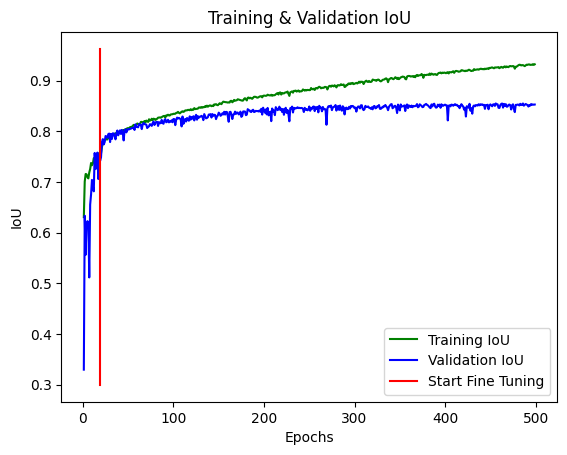

In [16]:
# Zusammenführen von Training- und Fine-Tuning-History
iou = model_history.history['binary_iou']
iou += history_fine.history['binary_iou']

val_iou = model_history.history['val_binary_iou']
val_iou += history_fine.history['val_binary_iou']


# laden des besten models
checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'
unet = tf.keras.models.load_model(checkpoint_path, compile= False)
compile_model(unet, learning_rate)


# Evaluieren & Ergebnisse in Tabelle
eval_out = unet.evaluate(test_data_generator)

eval_out_path = '../output/final_runs.csv'
# Anlegen der Datei für ersten Durchlauf
if not os.path.isfile(FT_output_path):
    with open(eval_out_path, 'w', newline='') as f_object:
        writer_object = csv.writer(f_object, delimiter= ';')

        header = ['model_name', 'loss', 'accuracy', 'binary_iou', 'true_pos', 'false_pos', 'true_neg', 'false_neg', 'precision', 'recall', 'training_time [min]', 'max_val_iou', 'idx_max_val_iou' ]
        writer_object.writerow(header)

        row = []
    
        row.append(model_name)

        for x in eval_out:
            row.append(x)            

        writer_object.writerow(row)

# Anhängen an Datei für weitere Durchläufe
else:
    with open(FT_output_path, 'a', newline='') as f_object:
        row = []
        
        row.append(model_name)

        for x in eval_out:
            row.append(x)

        # Einfügen der Trainingszeit in Minuten
        row.append(training_time/60)

        # Einfügen der maximalen Val-IoU
        row.append(max(val_iou))

        # Einfügen des Index der maximalen Val-IoU
        row.append(np.argmax(val_iou))

        writer_object = csv.writer(f_object, delimiter= ';')

        writer_object.writerow(row)




"""
# Schreiben der Eval-Ergebnisse in csv
with open('../output/final_runs.csv', 'a') as f_object:
    row = []
    
    row.append(model_name)

    for x in eval_out:
        row.append(x)

    # Einfügen der Trainingszeit in Minuten
    row.append(training_time/60)

    # Einfügen der maximalen Val-IoU
    row.append(max(val_iou))

    # Einfügen des Index der maximalen Val-IoU
    row.append(np.argmax(val_iou))

    writer_object = csv.writer(f_object, delimiter= ';')

    writer_object.writerow(row)
"""

# Plotten
epochs = range(1, len(val_iou)+1)

plt.plot(epochs[0:(len(val_iou) - 1)], iou[0:(len(val_iou) - 1)], 'g', label= 'Training IoU')
plt.plot(epochs[0:(len(val_iou) - 1)], val_iou[0:(len(val_iou) - 1)], 'b', label= 'Validation IoU')

plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'r', label='Start Fine Tuning')

plt.title('Training & Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.savefig(f'../output/plots/IoU/iou_{model_name}.png', bbox_inches='tight', dpi= 500)

plt.show()

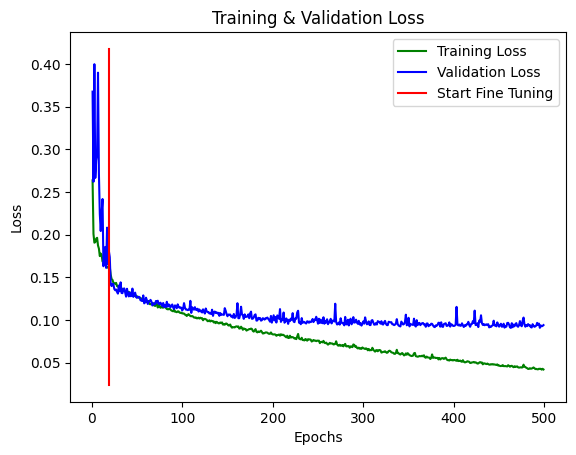

In [17]:
loss = model_history.history['loss']
loss += history_fine.history['loss']

val_loss = model_history.history['val_loss']
val_loss += history_fine.history['val_loss']

plt.plot(epochs[0:(len(val_iou) - 1)], loss[0:(len(val_iou) - 1)], 'g', label= 'Training Loss')
plt.plot(epochs[0:(len(val_iou) - 1)], val_loss[0:(len(val_iou) - 1)], 'b', label= 'Validation Loss')

plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), 'r', label='Start Fine Tuning')

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig(f'../output/plots/Loss/loss_{model_name}.png', bbox_inches='tight', dpi= 500)

plt.show()

In [18]:
#checkpoint_path = f'../output/{output_folder_prefix}_checkpoints/{model_name}'

#unet = tf.keras.models.load_model(checkpoint_path, compile= False)
#compile_model(unet, learning_rate)

# Prognose mit Hilfe des geladenen besten Modells
prediction = unet.predict(test_data_generator)

# Erstellung einer binären Maske aus den wahrscheinlichkeiten, Schwellwert 0.5
out = (prediction > 0.5).astype(np.uint8)

# lediglich halbe Batch Size in eine Abbildung wegen Übersichtlichkeit
rows = int(batch_size / 2)
columns = 3

# Anzahl verfügbarer Batches des Data-Generators
no_of_batches = test_data_generator.__len__()

# Prognose kommt als Tensor mit der Länge der Anzahl der Beispiele
out_idx = 0

# Erstellen des Prognosen-Ordners
if not os.path.isdir(f'../output/predictions/{model_name}'):
    os.makedirs(f'../output/predictions/{model_name}')

# Input und Masken kommen als Batches, über die iteriert wird
for batch_no in range(0, no_of_batches):

    # iterieren über erste Hälfte des Batches
    fig, axs = plt.subplots(rows, columns, figsize=(5, 20))

    for i in range(rows):
        axs[i, 0].imshow(out[out_idx])
        axs[i, 0].set_title('Prediction')

        axs[i, 1].imshow(test_data_generator[batch_no][1][i])
        axs[i, 1].set_title('Truth')

        axs[i, 2].imshow(reverse_scaling(test_data_generator[batch_no][0][i])[:,:,:3])
        axs[i, 2].set_title('Input')

        out_idx += 1

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    plt.savefig(f'../output/predictions/{model_name}/prediction_{model_name}_{batch_no}_I.png', bbox_inches='tight')
    plt.close(fig)

    # iterieren über zweite Hälfte des Batches
    fig, axs = plt.subplots(rows, columns, figsize=(5, 20))

    for i in range(rows):
        axs[i, 0].imshow(out[out_idx])
        axs[i, 0].set_title('Prediction')

        axs[i, 1].imshow(test_data_generator[batch_no][1][rows + i])
        axs[i, 1].set_title('Truth')

        axs[i, 2].imshow(reverse_scaling(test_data_generator[batch_no][0][rows + i])[:,:,:3])
        axs[i, 2].set_title('Input')

        out_idx += 1

    fig.tight_layout(w_pad=0.1, h_pad=0.1)

    print(batch_no)
    plt.savefig(f'../output/predictions/{model_name}/prediction_{model_name}_{batch_no}_II.png', bbox_inches='tight', dpi= 400)
    plt.close(fig)

# Zusammenführen der .log-Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
combine_log_files(output_folder_prefix, model_name)

66/66 [==============================] - 9s 120ms/step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65


In [35]:
import re
idx = 0

conv_idx_list = []

for i, layer in enumerate(reversed(unet.layers)):
    if layer.name == 'up_sampling2d':
        idx = 0
    #print(layer.name)
    if re.search(r"conv$", layer.name):
        conv_idx_list.append(idx)
        #print(idx, layer.name)

    idx +=1

conv_idx_list   



[4,
 7,
 11,
 15,
 18,
 22,
 26,
 27,
 30,
 34,
 38,
 42,
 46,
 50,
 53,
 57,
 61,
 64,
 68,
 72,
 75,
 79,
 83,
 86,
 90,
 94,
 95,
 98,
 102,
 106,
 110,
 114,
 118,
 121,
 125,
 129,
 132,
 136,
 140,
 141,
 144,
 148,
 152,
 156,
 160,
 164,
 167,
 171,
 175,
 176,
 179,
 183,
 188]

In [7]:
unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 4  0           []                               
                                )]                                                                
                                                                                                  
 split_input (Lambda)           [(None, 224, 224, 1  0           ['input[0][0]']                  
                                ),                                                                
                                 (None, 224, 224, 1                                               
                                ),                                                                
                                 (None, 224, 224, 1                                         

In [32]:
#model_name = "Final_AVG_rgbDrop_0_earlyStop_True_e500"

def combine_log_files():
    # Zusammenführen der .log Dateien von Initial- und Fine-Tuning Training und Schreiben in neue CSV-Datei
    filenames = [f'../output/{output_folder_prefix}_logger/{model_name}_I.log', f'../output/{output_folder_prefix}_logger/{model_name}.log']
    with open(f'../output/{output_folder_prefix}_logger/{model_name}.csv', 'w') as outfile:
        # spezifizieren des Delimiters für Excel in erster Zeile
        outfile.write('sep=,\n')

        for i, fname in enumerate(filenames):
            with open(fname) as infile:
                reader = csv.reader(infile)

                for j, row in enumerate(reader):
                    # überspringen des 2. Headers
                    if i == 1 and j == 0:
                        continue

                    delimiter = ','
                    list_to_string = delimiter.join(row)
                    list_to_string += '\n'

                    outfile.write(list_to_string)

In [14]:
with open(f'../output/{output_folder_prefix}_logger/{model_name}_I.log') as infile:
    reader = csv.reader(infile)
    for i, row in enumerate(reader):
        if i == 0:
            continue
        print(row)

['0', '0.7961242198944092', '0.6587730646133423', '20309084.0', '44833484.0', '0.24731293320655823', '0.7116237282752991', '0.8449028730392456', '143743008.0', '110635216.0', '0.8323593139648438', '0.7104504108428955', '6571040.0', '11194135.0', '0.19853559136390686', '0.7745783925056458', '0.8540922403335571', '49742008.0', '38464532.0']
['1', '0.8555810451507568', '0.7428621053695679', '19262012.0', '26882816.0', '0.17415392398834229', '0.8062108755111694', '0.8530752658843994', '161536704.0', '111839176.0', '0.8509215116500854', '0.7363330125808716', '7721061.0', '8077029.0', '0.17862582206726074', '0.8224303126335144', '0.8289172649383545', '52764112.0', '37409496.0']
['2', '0.868036687374115', '0.7619959115982056', '18203548.0', '23961460.0', '0.15954600274562836', '0.8248876929283142', '0.8611232042312622', '164482416.0', '112873368.0', '0.855846107006073', '0.7469853162765503', '3632307.0', '11643931.0', '0.15823477506637573', '0.7808046936988831', '0.9194782376289368', '4921813

In [158]:
unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 224, 224, 4  0           []                               
                                )]                                                                
                                                                                                  
 split_input (Lambda)           [(None, 224, 224, 1  0           ['input[0][0]']                  
                                ),                                                                
                                 (None, 224, 224, 1                                               
                                ),                                                                
                                 (None, 224, 224, 1                                         

In [12]:
unet.save(f'{model_name}.h5')